# import package

In [24]:
# package
# data analysis
import pandas as pd
import numpy as np
import datetime

# text
import re

# ML
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import ParameterGrid
import pickle
import joblib
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# cluster
from sklearn.cluster import KMeans

# data visual
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from matplotlib.ticker import FuncFormatter, MultipleLocator

# show chinese
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# check date
from datetime import datetime
from datetime import date
import holidays

# os
import os

# web crawler
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

plt.style.use("seaborn")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False


# import data(df)

In [2]:
# read excel
excel_file = "112年1-10月交通事故簡訊通報資料.xlsx"
df = pd.read_excel(excel_file)

In [3]:
# show
df

年  月   日   時   分  國道名稱 方向    里程      事件發生  交控中心\n接獲通報  ...  車輛4  \
0      2023  2   9  19  21  國道3號  南  54.0  19:21:00         NaN  ...  NaN   
1      2023  2  10   3  36  國道1號  南   6.0  03:36:00         NaN  ...  NaN   
2      2023  2  10   5  33  國道3號  南  76.0  05:33:00         NaN  ...  NaN   
3      2023  2  10   7  35  國道3號  北  98.0  07:35:00         NaN  ...  NaN   
4      2023  2  10   7  52  國道1號  北  23.0  07:52:00         NaN  ...  NaN   
...     ... ..  ..  ..  ..   ... ..   ...       ...         ...  ...  ...   
26734  2023  8   8   9  35  國道1號  南  23.0  09:35:00         NaN  ...  NaN   
26735  2023  8   8   9  44  國道3號  南  34.0  09:44:00         NaN  ...  NaN   
26736  2023  8   8   9  43  國道1號  北   6.0  09:43:00         NaN  ...  NaN   
26737  2023  8   8   9  42  國道1號  南  39.4  09:42:00         NaN  ...  NaN   
26738  2023  8   8   9  51  國道1號  北  23.3  09:51:00         NaN  ...  NaN   

       車輛5  車輛6  車輛7  車輛8  車輛9 車輛10  車輛11 車輛12  分局  
0      NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
1      NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
2      NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
3      NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
4      NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
...    ...  ...  ...  ...  ...  ...   ...  ...  ..  
26734  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
26735  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
26736  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
26737  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
26738  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  

[26739 rows x 50 columns]

## 填補"車輛"遺失值

In [4]:
# fill "車輛{i}" NA
# find "車輛1" is NA & "肇事車輛" != 0
filtered_df = df.loc[(df["車輛1"].isna()) & (df["肇事車輛"] != 0), ["車輛1", "肇事車輛", "簡訊內容"]]

# adjust "簡訊內容"
def process_message(message):
    if "追撞" in message:
        if "," in message:
            return message[message.find(")") + 1:].split(",")[0].split("追撞")[0]
        else:
            return message[message.find(")") + 1:].split("追撞")[0]
    elif "," in message:
        return message.split(",")[0]
    else:
        return message

filtered_df["簡訊內容"] = filtered_df["簡訊內容"].apply(process_message)

# fill "車輛{i}", with adjusted "簡訊內容"
def fill_vehicles(row):
    message = row["簡訊內容"]
    # use RE to find "num + vehicle_type"(數量以及車輛類型)
    # match num & vehicle_type, not include "+"
    matches = re.findall(r'(\d+)\s*([^+]+)', message)
    # save vehicle_type
    vehicles = []
    for count, vehicle_type in matches:
        count = int(count)
        # del " "
        vehicle_type = vehicle_type.strip()
        # save times of vehicle_type
        vehicles.extend([vehicle_type] * count)
    # if no num, spilt by "+"
    if not matches:
        parts = message.split("+")
        for i, part in enumerate(parts, start=1):
            row[f"車輛{i}"] = part.strip()
    else:
        # fill
        for i, vehicle in enumerate(vehicles, start=1):
            row[f"車輛{i}"] = vehicle
    return row

filtered_df = filtered_df.apply(fill_vehicles, axis=1)

# show
filtered_df


簡訊內容  肇事車輛  車輛1  車輛2  車輛3  車輛4
476      3小客+1貨櫃車   4.0   小客   小客   小客  貨櫃車
8936         2小客車   2.0  小客車  小客車  NaN  NaN
10107  佔用內+外線4小客車   4.0  小客車  小客車  小客車  小客車
15161    佔用內線2小客車   2.0  小客車  小客車  NaN  NaN
20745    佔用內線2小客車   2.0  小客車  小客車  NaN  NaN
22945         2小車   2.0   小車   小車  NaN  NaN
22946         3小車   3.0   小車   小車   小車  NaN
22947         4小車   4.0   小車   小車   小車   小車
22948      小貨車+自小   2.0  小貨車   自小  NaN  NaN
22949         2小車   2.0   小車   小車  NaN  NaN
22950         2小車   2.0   小車   小車  NaN  NaN
22951         2小車   2.0   小車   小車  NaN  NaN
22952         2小車   2.0   小車   小車  NaN  NaN
22953         3小車   3.0   小車   小車   小車  NaN
22954         4小車   4.0   小車   小車   小車   小車
22955      小貨車+自小   2.0  小貨車   自小  NaN  NaN
22956         2小車   2.0   小車   小車  NaN  NaN
23365         2小車   2.0   小車   小車  NaN  NaN
23367         2小車   2.0   小車   小車  NaN  NaN
23368         2小車   2.0   小車   小車  NaN  NaN
23369         3小車   3.0   小車   小車   小車  NaN
23370         4小車   3.0   小車   小車   小車   小車
23374      小貨車+自小   2.0  小貨車   自小  NaN  NaN

## 回填到原始資料當中

In [5]:
# fill filtered_df in df with corresponding col
for index, row in filtered_df.iterrows():
    # check NA, to avoid error
    if pd.isna(df.at[index, "車輛1"]):
        # max "車輛" is 4, can change
        for i in range(1, 5):
            if f"車輛{i}" in row:
                df.at[index, f"車輛{i}"] = row[f"車輛{i}"]


## 檢查是否成功填入

In [6]:
# check 
i_col = 8936
sms_content = df.iloc[i_col]['車輛2']
print(sms_content)

小客車


# adjust data(sorted_df)

## 依照時間做排序

In [7]:
# sort by time
sorted_df = df.sort_values(by=["月", "日", "時", "分"])
sorted_df

年   月   日   時   分  國道名稱  方向     里程      事件發生  交控中心\n接獲通報  ...  車輛4  \
1747   2023   1   1   0  31  國道1號  北向  286.0  00:31:00         NaN  ...  NaN   
5090   2023   1   1   1  52  國道3號   北   42.0  01:52:00         NaN  ...  NaN   
4560   2023   1   1   4  52  國道3號   北  195.3  04:07:00         NaN  ...  NaN   
5091   2023   1   1   9   2  國道2號   東   16.2  09:02:00         NaN  ...  NaN   
1748   2023   1   1   9   3  國道1號  南向  367.4  09:03:00         NaN  ...  NaN   
...     ...  ..  ..  ..  ..   ...  ..    ...       ...         ...  ...  ...   
489    2023  10  31  18  56  國道4號  東向   26.3  18:26:00         NaN  ...  NaN   
16274  2023  10  31  19  28  國道3號   南   55.8  19:28:00         NaN  ...  NaN   
16275  2023  10  31  22  13  國道1號   南   96.0  22:13:00         NaN  ...  NaN   
12020  2023  10  31  22  34  國道3號  北向  360.4  22:34:00         NaN  ...  NaN   
16276  2023  10  31  23  11  國道1號   南   49.0  23:11:00         NaN  ...  NaN   

       車輛5  車輛6  車輛7  車輛8  車輛9 車輛10  車輛11 車輛12  分局  
1747   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   3  
5090   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
4560   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   2  
5091   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
1748   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   3  
...    ...  ...  ...  ...  ...  ...   ...  ...  ..  
489    NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   2  
16274  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
16275  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
12020  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   3  
16276  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  

[26739 rows x 50 columns]

## 把方向改成統一規格
只有標示 "北"或"南"


In [8]:
# adjust "方向"
sorted_df["方向"] = df["方向"].str.replace("向", "")
sorted_df["方向"] = sorted_df["方向"].str.replace("南北|雙", "雙", regex=True)
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生  交控中心\n接獲通報  ...  車輛4  \
1747   2023   1   1   0  31  國道1號  北  286.0  00:31:00         NaN  ...  NaN   
5090   2023   1   1   1  52  國道3號  北   42.0  01:52:00         NaN  ...  NaN   
4560   2023   1   1   4  52  國道3號  北  195.3  04:07:00         NaN  ...  NaN   
5091   2023   1   1   9   2  國道2號  東   16.2  09:02:00         NaN  ...  NaN   
1748   2023   1   1   9   3  國道1號  南  367.4  09:03:00         NaN  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...         ...  ...  ...   
489    2023  10  31  18  56  國道4號  東   26.3  18:26:00         NaN  ...  NaN   
16274  2023  10  31  19  28  國道3號  南   55.8  19:28:00         NaN  ...  NaN   
16275  2023  10  31  22  13  國道1號  南   96.0  22:13:00         NaN  ...  NaN   
12020  2023  10  31  22  34  國道3號  北  360.4  22:34:00         NaN  ...  NaN   
16276  2023  10  31  23  11  國道1號  南   49.0  23:11:00         NaN  ...  NaN   

       車輛5  車輛6  車輛7  車輛8  車輛9 車輛10  車輛11 車輛12  分局  
1747   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   3  
5090   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
4560   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   2  
5091   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
1748   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   3  
...    ...  ...  ...  ...  ...  ...   ...  ...  ..  
489    NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   2  
16274  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
16275  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  
12020  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   3  
16276  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   1  

[26739 rows x 50 columns]

## 刪除不必要的欄位

In [9]:
# del not important var
columns_to_drop = ["交控中心\n接獲通報", "CCTV\n監看現場", "CMS\n發布資訊","交控中心\n通報工務段", "事故處理\n小組出發", "事故處理\n小組抵達", "事故處理\n小組完成"]
sorted_df = sorted_df.drop(columns_to_drop, axis=1)
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛4  \
1747   2023   1   1   0  31  國道1號  北  286.0  00:31:00  00:39:00  ...  NaN   
5090   2023   1   1   1  52  國道3號  北   42.0  01:52:00  02:27:00  ...  NaN   
4560   2023   1   1   4  52  國道3號  北  195.3  04:07:00  04:52:00  ...  NaN   
5091   2023   1   1   9   2  國道2號  東   16.2  09:02:00  09:36:00  ...  NaN   
1748   2023   1   1   9   3  國道1號  南  367.4  09:03:00  09:22:00  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...  ...   
489    2023  10  31  18  56  國道4號  東   26.3  18:26:00  18:56:00  ...  NaN   
16274  2023  10  31  19  28  國道3號  南   55.8  19:28:00  20:09:00  ...  NaN   
16275  2023  10  31  22  13  國道1號  南   96.0  22:13:00  22:25:00  ...  NaN   
12020  2023  10  31  22  34  國道3號  北  360.4  22:34:00  23:16:00  ...  NaN   
16276  2023  10  31  23  11  國道1號  南   49.0  23:11:00  23:18:00  ...  NaN   

       車輛5  車輛6  車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  分局  
1747   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   3  
5090   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1  
4560   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   2  
5091   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1  
1748   NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   3  
...    ...  ...  ...  ...  ...   ...   ...   ...  ..  
489    NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   2  
16274  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1  
16275  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1  
12020  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   3  
16276  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1  

[26739 rows x 43 columns]

## 修正時間欄位
有些欄位的時間格式錯亂 <br>
因此進行修正 <br>

---

修正的部分包含 : "事件發生"、"事件排除" <br>

In [10]:
# def fun to change type into date
def convert_to_time(x):
    if isinstance(x, datetime.time):
        return x
    else:
        # change into str, fill to len==4
        x_str = str(x).zfill(4)
        
        # del ";"
        if ";" in x_str:
            x_str = x_str.replace(";", "")
        
        # check len==4, else return none
        if len(x_str) != 4 or not x_str.isdigit():
            return None
        
        # change into date
        hour = int(x_str[:2])
        minute = int(x_str[2:])
        
        # check time range, else return none
        if hour < 0 or hour > 23 or minute < 0 or minute > 59:
            return None
        
        # change type into date
        return datetime.time(hour, minute)

In [11]:
# change "事件發生"
sorted_df["事件發生"] = sorted_df["事件發生"].apply(convert_to_time)
# change "事件排除"
sorted_df["事件排除"] = sorted_df["事件排除"].apply(convert_to_time)

# check "事件發生"
non_time_values = sorted_df[sorted_df["事件發生"].apply(lambda x: type(x) != datetime.time)]["事件發生"]
print((non_time_values))
# check "事件排除"
non_time_values = sorted_df[sorted_df["事件排除"].apply(lambda x: type(x) != datetime.time)]["事件排除"]
print((non_time_values))

# show
sorted_df

TypeError: isinstance() arg 2 must be a type or tuple of types

## 修正里程數欄位錯誤

In [13]:
# correct "里程"
## only 1 place is wrong, change 1715.0 to 4.1
sorted_df.loc[(sorted_df['國道名稱'] == '國道5號') & (sorted_df['里程'] == 1715.0), '里程'] = 4.1

# check
sorted_df[sorted_df['國道名稱'] == '國道5號']

年   月   日   時   分  國道名稱 方向    里程  事件發生  事件排除  ...  車輛4  車輛5  車輛6  \
14455  2023   1   1  13  28  國道5號  南  15.6  1328  1421  ...  NaN  NaN  NaN   
19661  2023   1   1  13  28  國道5號  南  15.6  1328  1421  ...  NaN  NaN  NaN   
19662  2023   1   1  13  48  國道5號  南  15.6  1348  1355  ...  NaN  NaN  NaN   
19663  2023   1   1  16  51  國道5號  北  24.3  1651  1655  ...  NaN  NaN  NaN   
19664  2023   1   2   1  32  國道5號  南  48.7   132   216  ...  NaN  NaN  NaN   
...     ...  ..  ..  ..  ..   ... ..   ...   ...   ...  ...  ...  ...  ...   
16186  2023  10  27  18  11  國道5號  南  14.8  1811  1820  ...  NaN  NaN  NaN   
16192  2023  10  28   8  35  國道5號  北  36.4   835   920  ...  NaN  NaN  NaN   
16191  2023  10  28  15  10  國道5號  北   6.4  1510  1549  ...  NaN  NaN  NaN   
16190  2023  10  28  16  49  國道5號  北  20.0  1649  1651  ...  NaN  NaN  NaN   
16193  2023  10  31  11  51  國道5號  南  23.6  1151  1305  ...  小客車  NaN  NaN   

       車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  分局  
14455  NaN  NaN  NaN   NaN   NaN   NaN   4  
19661  NaN  NaN  NaN   NaN   NaN   NaN   4  
19662  NaN  NaN  NaN   NaN   NaN   NaN   4  
19663  NaN  NaN  NaN   NaN   NaN   NaN   4  
19664  NaN  NaN  NaN   NaN   NaN   NaN   4  
...    ...  ...  ...   ...   ...   ...  ..  
16186  NaN  NaN  NaN   NaN   NaN   NaN   4  
16192  NaN  NaN  NaN   NaN   NaN   NaN   4  
16191  NaN  NaN  NaN   NaN   NaN   NaN   4  
16190  NaN  NaN  NaN   NaN   NaN   NaN   4  
16193  NaN  NaN  NaN   NaN   NaN   NaN   4  

[327 rows x 43 columns]

## 取出回堵長度

In [340]:
# def fun to take out "回堵長度"
def calculate_traffic_jam_length(text):
    if "回堵" in text:
        # use RE to match
        match = re.search(r'回堵(\d+)\s*(?:K|公里|k)', text)
        if match:
            return int(match.group(1))
    return 0


In [367]:
# add new col
sorted_df["回堵長度"] = sorted_df["簡訊內容"].apply(calculate_traffic_jam_length)
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛9  \
0      2023   1   1   0  31  國道1號  北  286.0  00:31:00  00:39:00  ...  NaN   
1      2023   1   1   1  52  國道3號  北   42.0  01:52:00  02:27:00  ...  NaN   
2      2023   1   1   4  52  國道3號  北  195.3  04:07:00  04:52:00  ...  NaN   
3      2023   1   1   9   2  國道2號  東   16.2  09:02:00  09:36:00  ...  NaN   
4      2023   1   1   9   3  國道1號  南  367.4  09:03:00  09:22:00  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...  ...   
17737  2023  10  31  18  56  國道4號  東   26.3  18:26:00  18:56:00  ...  NaN   
17738  2023  10  31  19  28  國道3號  南   55.8  19:28:00  20:09:00  ...  NaN   
17739  2023  10  31  22  13  國道1號  南   96.0  22:13:00  22:25:00  ...  NaN   
17740  2023  10  31  22  34  國道3號  北  360.4  22:34:00  23:16:00  ...  NaN   
17741  2023  10  31  23  11  國道1號  南   49.0  23:11:00  23:18:00  ...  NaN   

      車輛10  車輛11  車輛12  分局  回堵長度  是否為假日  是否為相近時間  是否為相近地點  相近時間&地點是否有事件  
0      NaN   NaN   NaN   3     0      1        0        0             0  
1      NaN   NaN   NaN   1     0      1        0        0             0  
2      NaN   NaN   NaN   2     0      1        0        0             0  
3      NaN   NaN   NaN   1     0      1        0        0             0  
4      NaN   NaN   NaN   3     0      1        0        0             0  
...    ...   ...   ...  ..   ...    ...      ...      ...           ...  
17737  NaN   NaN   NaN   2     0      0        0        0             0  
17738  NaN   NaN   NaN   1     0      0        0        0             0  
17739  NaN   NaN   NaN   1     1      0        0        0             0  
17740  NaN   NaN   NaN   3     0      0        0        0             0  
17741  NaN   NaN   NaN   1     0      0        0        0             0  

[17742 rows x 48 columns]

In [35]:
# check some row
subset_df = sorted_df[sorted_df["回堵長度"] != 0][["簡訊內容", "回堵長度"]]
subset_df

簡訊內容  回堵長度
5092   北控通報3級01/01,09:39國1南向88K(結報)佔用內+中線3小客車追撞事故,無人傷...     4
5094   北控通報3級01/01,11:15國1高架南向70K(結報)佔用內線4小客車追撞事故,無人傷...     3
14455  坪控通報3升2級 01/01,13:28國5南向15.6K(結報)2小自追撞佔用內線事故,無...     2
19661  坪控通報3升2級 01/01,13:28國5南向15.6K(結報)2小自追撞佔用內線事故,無...     2
5099   北控通報3級01/01,15:46國1北向87.6K(結報)佔用內線3小客車追撞事故,無人傷...     4
...                                                  ...   ...
16272  北控通報3級10/31,15:19國1北向五股出口(結報)2小車追撞佔用外線事故,無人受傷,...     1
493    中控通報3級10/31,15:59國3南向157.9K(結報)1小客追撞施工緩撞車事故占內2...     3
491    中控通報3級10/31,17:43國3北向166.5K(結報)3小客車追撞事故占中間車道,1...     1
16273  北控通報3級10/31,18:33國2東向4.8K(結報)2小車追撞佔用內線事故,無人受傷,...     3
16275  北控通報3級10/31,22:13國1南向96K(結報)2小自追撞佔用中內線車道事故,無人受...     1

[7774 rows x 2 columns]

## 修正 "國道名稱"

In [36]:
# change "國3甲" to "國道3甲", "國2甲" to "國道2甲"
sorted_df.loc[sorted_df['國道名稱'] == "國3甲", '國道名稱'] = "國道3甲"
sorted_df.loc[sorted_df['國道名稱'] == "國2甲", '國道名稱'] = "國道2甲"

## 刪除 "國道名稱" 有遺失的橫列

In [37]:
# del NA
sorted_df.dropna(subset=['國道名稱'], inplace=True)

In [38]:
# check
na_values = sorted_df[sorted_df['國道名稱'].isna()]
na_values

Empty DataFrame
Columns: [年, 月, 日, 時, 分, 國道名稱, 方向, 里程, 事件發生, 事件排除, 處理分鐘, 事故類型, 死亡, 受傷, 內路肩, 內車道, 中內車道, 中車道, 中外車道, 外車道, 外路肩, 匝道, 簡訊內容, 翻覆事故
註記, 施工事故
註記, 危險物品車輛
註記, 車輛起火
註記, 冒煙車事故
註記, 主線中斷
註記, 肇事車輛, 車輛1, 車輛2, 車輛3, 車輛4, 車輛5, 車輛6, 車輛7, 車輛8, 車輛9, 車輛10, 車輛11, 車輛12, 分局, 回堵長度]
Index: []

[0 rows x 44 columns]

## 把相同的橫列留下其一

In [39]:
# unique
sorted_df = sorted_df.drop_duplicates(subset=['年', '月', '日', '時', '分', '國道名稱', '方向', '里程'])
# check
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛5  \
1747   2023   1   1   0  31  國道1號  北  286.0  00:31:00  00:39:00  ...  NaN   
5090   2023   1   1   1  52  國道3號  北   42.0  01:52:00  02:27:00  ...  NaN   
4560   2023   1   1   4  52  國道3號  北  195.3  04:07:00  04:52:00  ...  NaN   
5091   2023   1   1   9   2  國道2號  東   16.2  09:02:00  09:36:00  ...  NaN   
1748   2023   1   1   9   3  國道1號  南  367.4  09:03:00  09:22:00  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...  ...   
489    2023  10  31  18  56  國道4號  東   26.3  18:26:00  18:56:00  ...  NaN   
16274  2023  10  31  19  28  國道3號  南   55.8  19:28:00  20:09:00  ...  NaN   
16275  2023  10  31  22  13  國道1號  南   96.0  22:13:00  22:25:00  ...  NaN   
12020  2023  10  31  22  34  國道3號  北  360.4  22:34:00  23:16:00  ...  NaN   
16276  2023  10  31  23  11  國道1號  南   49.0  23:11:00  23:18:00  ...  NaN   

       車輛6  車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  分局  回堵長度  
1747   NaN  NaN  NaN  NaN   NaN   NaN   NaN   3     0  
5090   NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  
4560   NaN  NaN  NaN  NaN   NaN   NaN   NaN   2     0  
5091   NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  
1748   NaN  NaN  NaN  NaN   NaN   NaN   NaN   3     0  
...    ...  ...  ...  ...   ...   ...   ...  ..   ...  
489    NaN  NaN  NaN  NaN   NaN   NaN   NaN   2     0  
16274  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  
16275  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     1  
12020  NaN  NaN  NaN  NaN   NaN   NaN   NaN   3     0  
16276  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  

[17742 rows x 44 columns]

 ## 修改車輛欄位

In [40]:
# # show how many different elements
# # with how many
# counts = df["車輛5"].value_counts()
# print(counts)

# # show how many different elements
# # with id
# unique_vehicle1 = df.drop_duplicates("車輛5", keep="first")
# print(unique_vehicle1[["車輛5"]])


In [41]:
# use copy to avoid error
sorted_df_copy = sorted_df.copy()
# all columns to adjust
vehicle_columns = ["車輛1", "車輛2", "車輛3", "車輛4", "車輛5",
                   "車輛6", "車輛7", "車輛8", "車輛9", "車輛10", "車輛11", "車輛12"]

# replace values
replace_dict = {
    "重型機車": "重機",
    "小自客\n": "小自客", "小客車": "小自客", "小客": "小自客", "小車": "小自客", '小自客\"\n': "小自客", " 小自客": "小自客", "自小": "小自客", "小自車": "小自客", "小自客_x000D_\n": "小自客",
    "大客車": "大客車", "大客車\n": "大客車", "大客": "大客車", "大客車_x000D_\n": "大客車",
    "貨車": "貨車",
    "小貨車": "小貨車", "小貨車\n": "小貨車", "小自貨": "小貨車", "小營業貨": "小貨車", "小貨": "小貨車", "小貨車_x000D_\n": "小貨車",
    "中型貨車": "中貨車",
    "大貨車": "大貨車", "貨櫃車": "大貨車", " 大貨車": "大貨車", "大貨車\n": "大貨車", "大貨": "大貨車", "大貨車ˉ": "大貨車", "284貨車": "大貨車", "大貨\n": "大貨車", "大貨車_x000D_\n": "大貨車",
    "聯結車": "聯結車", "聯結車\n": "聯結車",
    "拖吊車": "拖吊車",
    "槽車": "槽車",
    "垃圾車": "垃圾車",
    "貨櫃車": "貨櫃車",
    "工工程車": "工程車", "工程車\n": "工程車",
    "施工車": "施工車",
    "緩撞車": "緩撞車", "緩撞車\n": "緩撞車", "施工緩撞車": "緩撞車", "\"事故班緩撞車": "緩撞車", "事故班緩撞車": "緩撞車",
    "油罐車": "油罐車",
    "預拌水泥車": "預拌車", "預拌混泥土車": "預拌車",
    "砂石車": "砂石車",
    "公警": "公警",
    "拖板車": "拖板車",
    "計程車": "計程車",
    "起重機": "起重機",
    "其他": "其他",
    "國光客運": "中型巴士",
    "施工高空車": "高空作業車",
    "     ": np.nan
}

# adjust and replace values in columns
for column in vehicle_columns:
    sorted_df_copy.loc[:, column] = sorted_df_copy.loc[:, column].replace(replace_dict)
    sorted_df = sorted_df_copy

    # show the adjusted results
    counts = sorted_df[column].value_counts()
    print(f"{column} 調整後的結果：")
    print(counts)
    print("-" * 50)


車輛1 調整後的結果：
小自客    15831
小貨車      923
大貨車      665
大客車      133
其他        87
聯結車       56
緩撞車        6
貨櫃車        5
貨車         5
拖吊車        5
計程車        4
施工車        4
槽車         4
中貨車        2
垃圾車        2
起重機        2
工程車        1
油罐車        1
連結車        1
砂石車        1
預拌車        1
拖板車        1
公警         1
Name: 車輛1, dtype: int64
--------------------------------------------------
車輛2 調整後的結果：
小自客       13476
小貨車        1227
大貨車         836
其他          254
大客車         117
聯結車          29
緩撞車          29
計程車          25
拖吊車           5
施工車           3
砂石車           2
重機            2
槽車            2
高空作業車         2
工程車           2
垃圾車           2
機車            2
中型巴士          2
小客貨           1
貨車            1
施工標緻車         1
中客車           1
救護車           1
貨櫃車           1
中貨車           1
施工掃地車         1
事故班標誌車        1
板車            1
警戒車           1
油罐車           1
水泥車           1
Name: 車輛2, dtype: int64
--------------------------------------------------
車輛3 調整後的結果：
小自客    2506
小貨車    

### 檢查是否存在遺失值

In [42]:
# fill "車輛{i}" NA
# find "車輛1" is NA & "肇事車輛" != 0
filtered_df = df.loc[(df["車輛1"].isna()) & (df["肇事車輛"] != 0), ["車輛1", "肇事車輛", "簡訊內容"]]

# adjust "簡訊內容"
def process_message(message):
    if "追撞" in message:
        if "," in message:
            return message[message.find(")") + 1:].split(",")[0].split("追撞")[0]
        else:
            return message[message.find(")") + 1:].split("追撞")[0]
    elif "," in message:
        return message.split(",")[0]
    else:
        return message

filtered_df["簡訊內容"] = filtered_df["簡訊內容"].apply(process_message)

# show
filtered_df

Empty DataFrame
Columns: [車輛1, 肇事車輛, 簡訊內容]
Index: []

## 查看目前剩下哪些變數

In [130]:
# check saved cols
column_names = sorted_df.columns.tolist()
print(column_names)

['年', '月', '日', '時', '分', '國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘', '事故類型', '死亡', '受傷', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', '簡訊內容', '翻覆事故\n註記', '施工事故\n註記', '危險物品車輛\n註記', '車輛起火\n註記', '冒煙車事故\n註記', '主線中斷\n註記', '肇事車輛', '車輛1', '車輛2', '車輛3', '車輛4', '車輛5', '車輛6', '車輛7', '車輛8', '車輛9', '車輛10', '車輛11', '車輛12', '分局', '回堵長度', '是否為假日', '是否為相近時間', '是否為相近地點', '相近時間&時間是否有事件']


## 儲存目前已經調整過的資料集

In [44]:
# save
sorted_df.to_excel('adjusted_df.xlsx', index=False)

# 匯入已經修正過的資料集--1

In [150]:
# read excel
excel_file = "adjusted_df.xlsx"
sorted_df = pd.read_excel(excel_file)

In [151]:
# show
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛5  \
0      2023   1   1   0  31  國道1號  北  286.0  00:31:00  00:39:00  ...  NaN   
1      2023   1   1   1  52  國道3號  北   42.0  01:52:00  02:27:00  ...  NaN   
2      2023   1   1   4  52  國道3號  北  195.3  04:07:00  04:52:00  ...  NaN   
3      2023   1   1   9   2  國道2號  東   16.2  09:02:00  09:36:00  ...  NaN   
4      2023   1   1   9   3  國道1號  南  367.4  09:03:00  09:22:00  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...  ...   
17737  2023  10  31  18  56  國道4號  東   26.3  18:26:00  18:56:00  ...  NaN   
17738  2023  10  31  19  28  國道3號  南   55.8  19:28:00  20:09:00  ...  NaN   
17739  2023  10  31  22  13  國道1號  南   96.0  22:13:00  22:25:00  ...  NaN   
17740  2023  10  31  22  34  國道3號  北  360.4  22:34:00  23:16:00  ...  NaN   
17741  2023  10  31  23  11  國道1號  南   49.0  23:11:00  23:18:00  ...  NaN   

       車輛6  車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  分局  回堵長度  
0      NaN  NaN  NaN  NaN   NaN   NaN   NaN   3     0  
1      NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  
2      NaN  NaN  NaN  NaN   NaN   NaN   NaN   2     0  
3      NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  
4      NaN  NaN  NaN  NaN   NaN   NaN   NaN   3     0  
...    ...  ...  ...  ...   ...   ...   ...  ..   ...  
17737  NaN  NaN  NaN  NaN   NaN   NaN   NaN   2     0  
17738  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  
17739  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     1  
17740  NaN  NaN  NaN  NaN   NaN   NaN   NaN   3     0  
17741  NaN  NaN  NaN  NaN   NaN   NaN   NaN   1     0  

[17742 rows x 44 columns]

## 新增變數 "是否為假日"
假日包含 六、日、節日

### 定義函數 is_holiday 判斷假日

In [141]:
# set country--TW is in CN
cn_holidays = holidays.CountryHoliday('CN')

# def func to know is holiday/weekend or weekday
def is_holiday(check_date):
    # check whether in holiday
    if check_date in cn_holidays:
        return True
    # check whether in weekend
    ## 6,7 is day num
    if check_date.isoweekday() in [6, 7]:
        return True
    return False

### 加入變數

In [153]:
# add new var --"是否為假日"
sorted_df['是否為假日'] = sorted_df.apply(
    lambda row: 1 if is_holiday(date(row['年'], row['月'], row['日'])) else 0, axis=1)

In [154]:
# show
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛6  \
0      2023   1   1   0  31  國道1號  北  286.0  00:31:00  00:39:00  ...  NaN   
1      2023   1   1   1  52  國道3號  北   42.0  01:52:00  02:27:00  ...  NaN   
2      2023   1   1   4  52  國道3號  北  195.3  04:07:00  04:52:00  ...  NaN   
3      2023   1   1   9   2  國道2號  東   16.2  09:02:00  09:36:00  ...  NaN   
4      2023   1   1   9   3  國道1號  南  367.4  09:03:00  09:22:00  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...  ...   
17737  2023  10  31  18  56  國道4號  東   26.3  18:26:00  18:56:00  ...  NaN   
17738  2023  10  31  19  28  國道3號  南   55.8  19:28:00  20:09:00  ...  NaN   
17739  2023  10  31  22  13  國道1號  南   96.0  22:13:00  22:25:00  ...  NaN   
17740  2023  10  31  22  34  國道3號  北  360.4  22:34:00  23:16:00  ...  NaN   
17741  2023  10  31  23  11  國道1號  南   49.0  23:11:00  23:18:00  ...  NaN   

       車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  分局  回堵長度  是否為假日  
0      NaN  NaN  NaN   NaN   NaN   NaN   3     0      1  
1      NaN  NaN  NaN   NaN   NaN   NaN   1     0      1  
2      NaN  NaN  NaN   NaN   NaN   NaN   2     0      1  
3      NaN  NaN  NaN   NaN   NaN   NaN   1     0      1  
4      NaN  NaN  NaN   NaN   NaN   NaN   3     0      1  
...    ...  ...  ...   ...   ...   ...  ..   ...    ...  
17737  NaN  NaN  NaN   NaN   NaN   NaN   2     0      0  
17738  NaN  NaN  NaN   NaN   NaN   NaN   1     0      0  
17739  NaN  NaN  NaN   NaN   NaN   NaN   1     1      0  
17740  NaN  NaN  NaN   NaN   NaN   NaN   3     0      0  
17741  NaN  NaN  NaN   NaN   NaN   NaN   1     0      0  

[17742 rows x 45 columns]

## 新增變數 "相近時間是否有事件"
同時符合相近時間&相近地點才會將此變數設為 1 <br>
相近時間定義 : B 的發生時間在 A 的發生時間+處理時間 $\rightarrow$ B 在此為 True <br>
相近地點定義 : B 的發生地點(里程) 與 A 的發生地點(里程) 相差 10km 之內 <br>

### 加入變數

In [155]:
# add new var --"是否為相近時間"、"是否為相近地點"、"相近時間是否有事件"
sorted_df['是否為相近時間'] = 0
sorted_df['是否為相近地點'] = 0
sorted_df['相近時間&地點是否有事件'] = 0
# first--group to process
grouped = sorted_df.groupby(['年', '月', '日', '國道名稱', '方向'])

In [156]:
# loop
for name, group in grouped:
    # repeat every group
    for i in range(len(group)):
        current_event = group.iloc[i]
        current_start = current_event['事件發生']
        current_end = current_event['事件排除']
        current_mileage = current_event['里程']
        
        # check the logic
        for j in range(i):
            previous_event = group.iloc[j]
            previous_start = previous_event['事件發生']
            previous_end = previous_event['事件排除']
            previous_mileage = previous_event['里程']
            
            # check place
            if abs(current_mileage - previous_mileage) <= 10:
                sorted_df.at[current_event.name, '是否為相近地點'] = 1
            # check time
            if (previous_start <= current_start <= previous_end):
                sorted_df.at[current_event.name, '是否為相近時間'] = 1
            # check both
            if abs(current_mileage - previous_mileage) <= 10:
                if (previous_start <= current_start <= previous_end):
                    sorted_df.at[current_event.name, '相近時間&地點是否有事件'] = 1
                    break
# # cross 2 var
# sorted_df['相近時間是否有事件'] = sorted_df['是否為相近時間'] * sorted_df['是否為相近地點']
print("finish")

finish


### 檢查變數是否正確判斷

In [280]:
# id connect to mdndhm.xlsx
# id +2 == xlsx id
new_df = sorted_df.sort_values(
    by=["年", "月", "日", "國道名稱", "方向", "時", "分"]).reset_index(drop=True)
# filtered_df = new_df[new_df["是否為相近地點"] == 1]
# filtered_df = new_df[new_df["是否為相近時間"] == 1]
filtered_df = new_df[new_df["相近時間&地點是否有事件"] == 1]
# filtered_df = new_df[(new_df["是否為相近地點"] == 1) & (new_df["是否為相近時間"] == 0)]
filtered_df

# 8318/17742 hace accident in near place with mile set == 10
# 3705/17742 have accident in near time
# 837/17742 have accident in near time and near place

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛9  \
40     2023   1   1  18  58  國道3號  北  230.8  18:35:00  18:58:00  ...  NaN   
58     2023   1   1  13  48  國道5號  南   15.6  13:48:00  13:55:00  ...  NaN   
75     2023   1   2  17  33  國道1號  北   35.7  17:33:00  18:01:00  ...  NaN   
81     2023   1   2  18  37  國道1號  北  121.0  17:55:00  18:37:00  ...  NaN   
82     2023   1   2  18  39  國道1號  北  355.1  18:39:00  18:42:00  ...  NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...  ...   
17610  2023  10  28  16  20  國道1號  南  210.0  16:01:00  16:20:00  ...  NaN   
17611  2023  10  28  16  23  國道1號  南  210.5  16:02:00  16:23:00  ...  NaN   
17630  2023  10  28  11  44  國道3號  南   58.3  11:44:00  11:47:00  ...  NaN   
17632  2023  10  28  12   2  國道3號  南   55.8  12:02:00  12:08:00  ...  NaN   
17711  2023  10  30  18  49  國道2號  西   12.2  18:49:00  18:50:00  ...  NaN   

      車輛10  車輛11  車輛12  分局  回堵長度  是否為假日  是否為相近時間  是否為相近地點  相近時間&地點是否有事件  
40     NaN   NaN   NaN   2     2      1        1        1             1  
58     NaN   NaN   NaN   4     0      1        1        1             1  
75     NaN   NaN   NaN   1     4      1        1        1             1  
81     NaN   NaN   NaN   2     3      1        1        1             1  
82     NaN   NaN   NaN   3     0      1        1        1             1  
...    ...   ...   ...  ..   ...    ...      ...      ...           ...  
17610  NaN   NaN   NaN   2     3      1        1        1             1  
17611  NaN   NaN   NaN   2     3      1        1        1             1  
17630  NaN   NaN   NaN   1     4      1        1        1             1  
17632  NaN   NaN   NaN   1     3      1        1        1             1  
17711  NaN   NaN   NaN   1     1      0        1        1             1  

[837 rows x 48 columns]

## 新增變數 "事故車是否包含非小客車"

In [466]:
# def func to know every "車輛", without NA
def check_vehicle_type(row):
    # set ori 0
    vehicle_status = 0
    vehicle_columns = [col for col in sorted_df.columns if col.startswith('車輛')]
    
    # check every "車輛{i}" col
    for col in vehicle_columns:
        # check not NA
        if pd.notna(row[col]):
            # check "小客車"
            if "小自客" in str(row[col]):
                vehicle_status = 0
            else:
                vehicle_status = 1
    return vehicle_status

# add new col"事故車是否包含非小客車"
sorted_df['事故車是否包含非小客車'] = sorted_df.apply(check_vehicle_type, axis=1)
# check
sorted_df[['事故車是否包含非小客車'] + vehicle_columns + ["簡訊內容"]]

事故車是否包含非小客車                                               簡訊內容
0                0  南控通報3級01/01,00:31國1北向286k(結報)小客車撞護欄,00:39事故排除,...
1                0  北控通報3級01/01,01:52國3北向土城入口(結報)1小客自撞事故,無傷亡,無回堵,0...
2                0  中控通報3級01/01,04:07國3北向195.3K(結報)2小客車追撞事故占內2車道,0...
3                0  北控通報3級01/01,09:02國2東向16.2K(結報)外路肩(更正)2小客車追撞事故,...
4                0  南控通報3級01/01,09:03國1南向高雄中正路入口(結報)2小客車追撞,09:22事故...
...            ...                                                ...
17737            0  中控通報3級10/31,18:26國4東向26.3K(結報)2小客車追撞事故占內車道,18:...
17738            0  北控通報3級10/31,19:28國3南向55.8K(結報)2小自追撞佔用內線車道事故,無人...
17739            0  北控通報3級10/31,22:13國1南向96K(結報)2小自追撞佔用中內線車道事故,無人受...
17740            1  南控通報2級10/31,22:34國3北向360.4k(結報修正)小客車撞鹿,23:16事故...
17741            0  北控通報3級10/31,23:11國1南向桃園出口(結報)2小自追撞佔用外側車道事故,無人受...

[17742 rows x 2 columns]

In [468]:
# get "事故車是否包含非小客車" counts
value_counts = sorted_df['事故車是否包含非小客車'].value_counts()
value_counts

0    14419
1     3323
Name: 事故車是否包含非小客車, dtype: int64

## 儲存目前已經調整過的資料集

In [469]:
# save
sorted_df.to_excel('seven_edit_df.xlsx', index=False)

# 匯入已經調整過的資料集--2

In [54]:
# read excel
excel_file = "seven_edit_df.xlsx"
sorted_df = pd.read_excel(excel_file)

In [5]:
# show
sorted_df

年   月   日   時   分  國道名稱 方向     里程      事件發生      事件排除  ...  車輛10  \
0      2023   1   1   0  31  國道1號  北  286.0  00:31:00  00:39:00  ...   NaN   
1      2023   1   1   1  52  國道3號  北   42.0  01:52:00  02:27:00  ...   NaN   
2      2023   1   1   4  52  國道3號  北  195.3  04:07:00  04:52:00  ...   NaN   
3      2023   1   1   9   2  國道2號  東   16.2  09:02:00  09:36:00  ...   NaN   
4      2023   1   1   9   3  國道1號  南  367.4  09:03:00  09:22:00  ...   NaN   
...     ...  ..  ..  ..  ..   ... ..    ...       ...       ...  ...   ...   
17737  2023  10  31  18  56  國道4號  東   26.3  18:26:00  18:56:00  ...   NaN   
17738  2023  10  31  19  28  國道3號  南   55.8  19:28:00  20:09:00  ...   NaN   
17739  2023  10  31  22  13  國道1號  南   96.0  22:13:00  22:25:00  ...   NaN   
17740  2023  10  31  22  34  國道3號  北  360.4  22:34:00  23:16:00  ...   NaN   
17741  2023  10  31  23  11  國道1號  南   49.0  23:11:00  23:18:00  ...   NaN   

      車輛11  車輛12  分局  回堵長度  是否為假日  是否為相近時間  是否為相近地點  相近時間&地點是否有事件  事故車是否包含非小客車  
0      NaN   NaN   3     0      1        0        0             0            0  
1      NaN   NaN   1     0      1        0        0             0            0  
2      NaN   NaN   2     0      1        0        0             0            0  
3      NaN   NaN   1     0      1        0        0             0            0  
4      NaN   NaN   3     0      1        0        0             0            0  
...    ...   ...  ..   ...    ...      ...      ...           ...          ...  
17737  NaN   NaN   2     0      0        0        0             0            0  
17738  NaN   NaN   1     0      0        0        0             0            0  
17739  NaN   NaN   1     1      0        0        0             0            0  
17740  NaN   NaN   3     0      0        0        0             0            1  
17741  NaN   NaN   1     0      0        0        0             0            0  

[17742 rows x 49 columns]

In [6]:
# check saved cols
column_names = sorted_df.columns.tolist()
print(column_names)

['年', '月', '日', '時', '分', '國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘', '事故類型', '死亡', '受傷', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', '簡訊內容', '翻覆事故\n註記', '施工事故\n註記', '危險物品車輛\n註記', '車輛起火\n註記', '冒煙車事故\n註記', '主線中斷\n註記', '肇事車輛', '車輛1', '車輛2', '車輛3', '車輛4', '車輛5', '車輛6', '車輛7', '車輛8', '車輛9', '車輛10', '車輛11', '車輛12', '分局', '回堵長度', '是否為假日', '是否為相近時間', '是否為相近地點', '相近時間&地點是否有事件', '事故車是否包含非小客車']


# 新增變數 "距離交流道多遠"

## 載入"國道一號"的交流道表格

In [856]:
# webdriver
driver_path = "D:/geckodriver/chromedriver.exe"
service = Service(driver_path)
# open driver
driver = webdriver.Chrome(service=service)
# page url
url = "https://www.freeway.gov.tw/Publish.aspx?cnid=1906&p=4617"
driver.get(url)

# turn into table's XPATH
xpath = "/html/body/form/div[4]/div/div/div[2]/div[2]/div/div/table[1]/tbody"
table_element = driver.find_element(By.XPATH, xpath)

# get every col
rows = table_element.find_elements(By.TAG_NAME, "tr")
# save in list
table_data = []
# get every val in df
for row in rows:
    cols = row.find_elements(By.TAG_NAME, "td")
    cols = [col.text for col in cols]
    table_data.append(cols)
# quit
driver.quit()
# change to df
aaa = pd.DataFrame(table_data)

In [866]:
# 保留第2列是整數的行，並忽略空值
aaa = aaa[aaa.iloc[:, 1].apply(lambda x: str(x).isdigit())]
aaa

0    1
1        基隆端    0
2      基隆交流道    1
3      八堵交流道    2
4    大華系統交流道    5
5      五堵交流道    6
..       ...  ...
100    高雄交流道  367
106  瑞隆路出口匝道  369
107  五甲系統交流道  370
108    五甲交流道  372
114  交流道數量合計   75

[82 rows x 2 columns]

In [863]:
aaa.to_csv("table_data_numeric_second_column.csv", index=False, encoding="utf-8-sig")

pandas.core.frame.DataFrame

# visualize

## "處理分鐘" box & bar plot

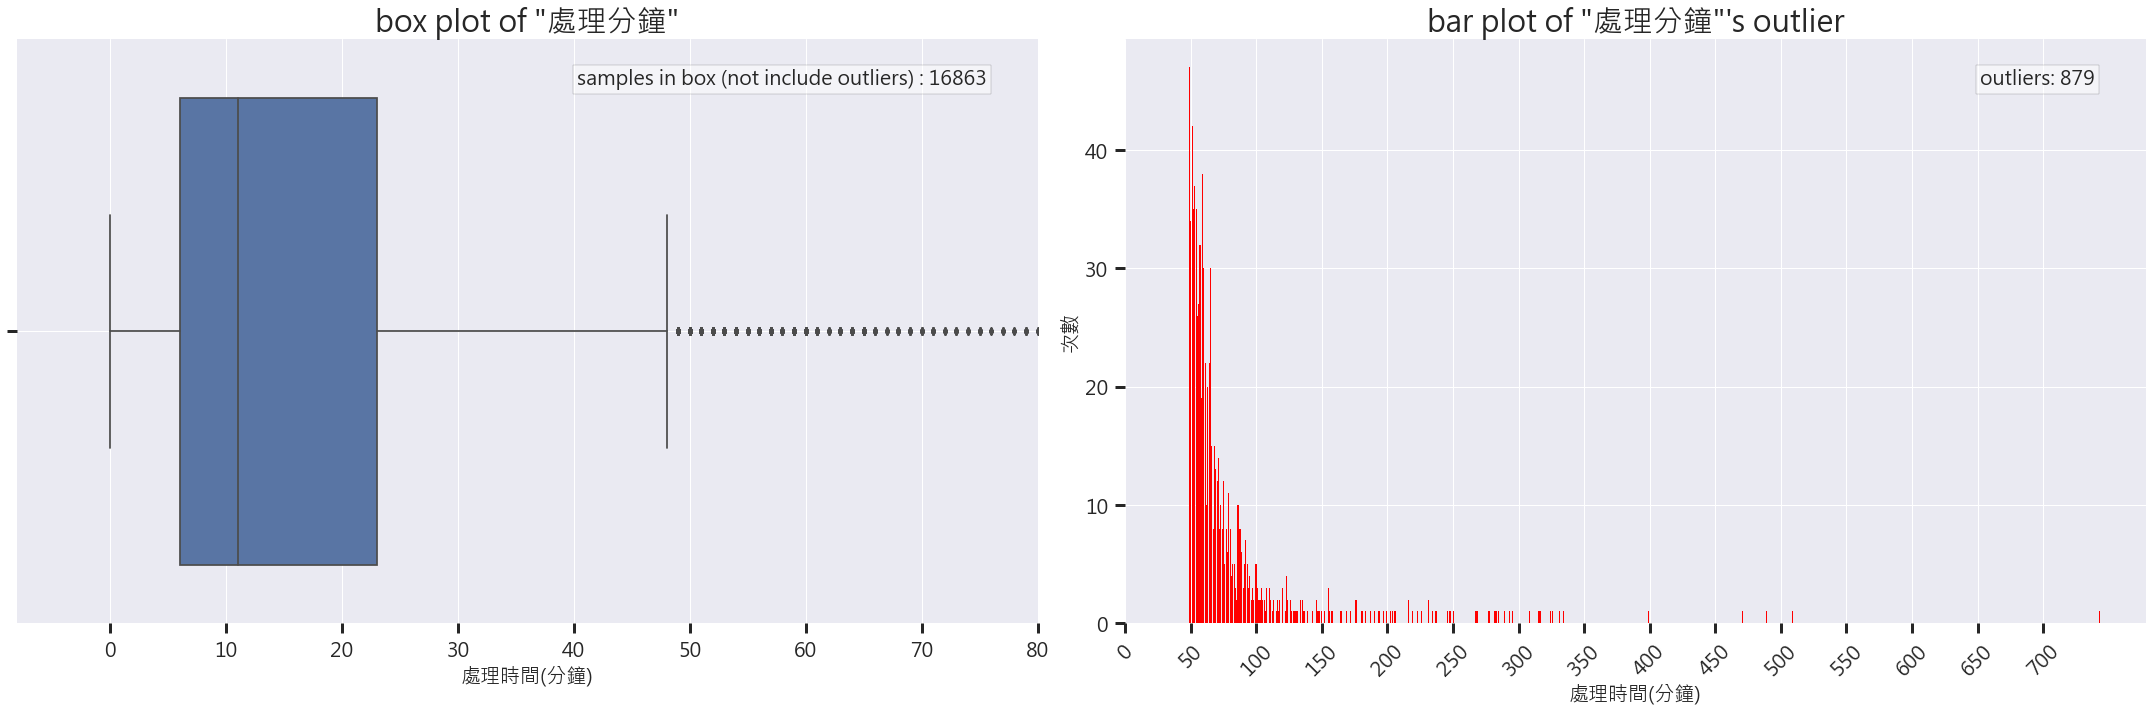

In [14]:
# "處理分鐘" box & bar plot
# find outlier
q1 = sorted_df['處理分鐘'].quantile(0.25)
q3 = sorted_df['處理分鐘'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = sorted_df[(sorted_df['處理分鐘'] < lower_bound) |
                     (sorted_df['處理分鐘'] > upper_bound)]['處理分鐘']

# count how many
total_samples = len(sorted_df)
total_outliers = len(outliers)

# set fig
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 1st subplot : box plot
sns.boxplot(x=sorted_df['處理分鐘'], ax=axes[0])
axes[0].grid(True)
axes[0].set_xlim(-8, 80)
axes[0].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[0].set_title('box plot of "處理分鐘"', fontsize=30)
axes[0].set_xlabel('處理時間(分鐘)', fontsize=20)
axes[0].text(0.95, 0.95, f'samples in box (not include outliers) : {total_samples-total_outliers}', transform=axes[0].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# 2nd subplot : bar plot of outlier
axes[1].bar(outliers.value_counts().index, outliers.value_counts(), color='r')
axes[1].set_title('bar plot of "處理分鐘"\'s outlier', fontsize=30)
axes[1].set_xlabel('處理時間(分鐘)', fontsize=20)
axes[1].set_ylabel('次數', fontsize=20)
axes[1].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[1].set_xticks(range(0, int(max(outliers)) + 1, 50))
axes[1].tick_params(axis='x', labelsize=20, rotation=45)
axes[1].text(0.95, 0.95, f'outliers: {total_outliers}', transform=axes[1].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# show
plt.tight_layout()
plt.show()

## "事故類型" pie chart

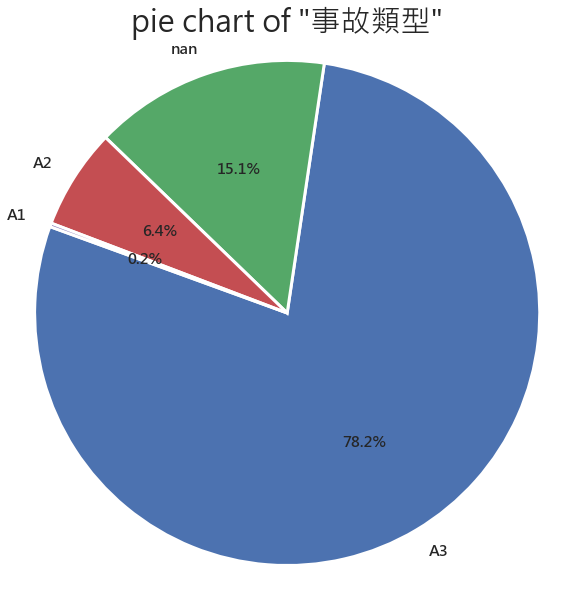

In [666]:
# "事故類型" pie chart
# count
value_counts = sorted_df['事故類型'].value_counts(dropna=False)

# set font
plt.rcParams.update({'font.size': 15})
# pie
plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=160, textprops={
        'weight': 'bold', 'size': 15}, wedgeprops={'linewidth': 3, 'edgecolor': 'w'})
plt.title('pie chart of "事故類型"', fontsize=30)
plt.axis('equal')
# show
plt.show()

## "事故發生車道" bar plot

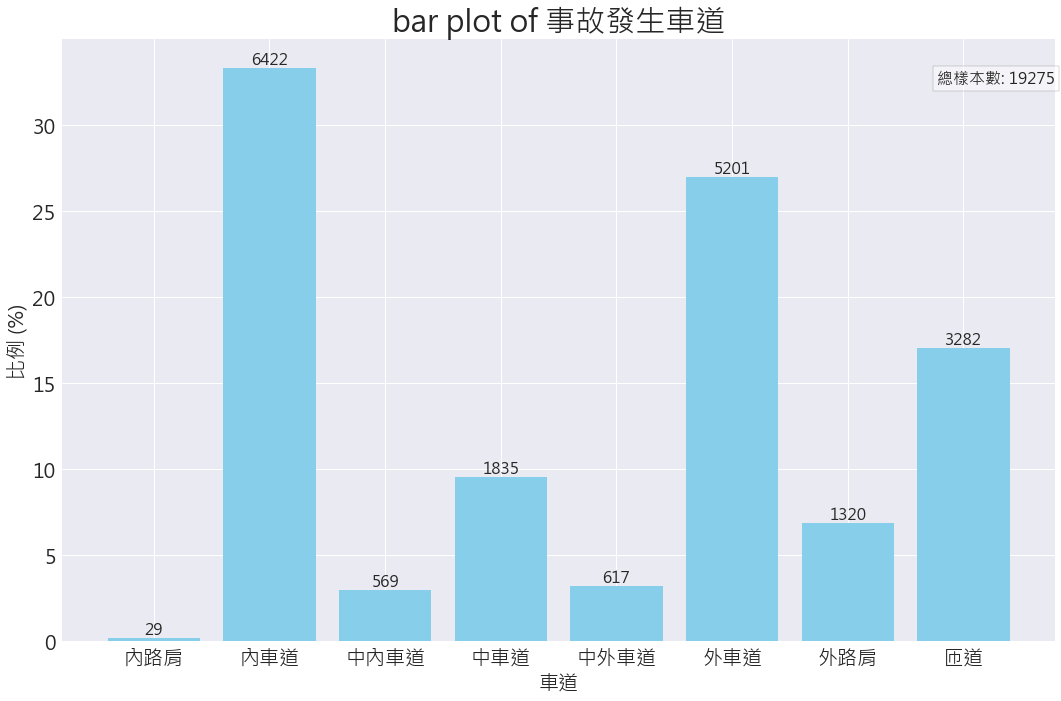

In [16]:
# "事故發生車道" bar plot
# find col
cols_to_sum = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
# count
sum_dict = {col: int(sorted_df[col].sum()) for col in cols_to_sum}
total_sum = sum(sum_dict.values())
# change into ratio
percentage_dict = {col: (value / total_sum * 100)
                   for col, value in sum_dict.items()}

# bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(percentage_dict.keys(),
               percentage_dict.values(), color='skyblue')
plt.title('bar plot of 事故發生車道', fontsize=30)
plt.xlabel('車道', fontsize=20)
plt.ylabel('比例 (%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(1, 0.95, f'總樣本數: {total_sum}', transform=plt.gca().transAxes, fontsize=16,
         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# text on bar
for bar, value in zip(bars, sum_dict.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value),
             ha='center', va='bottom', fontsize=16)

# show
plt.tight_layout()
plt.show()

## "事故車詳情" bar plot

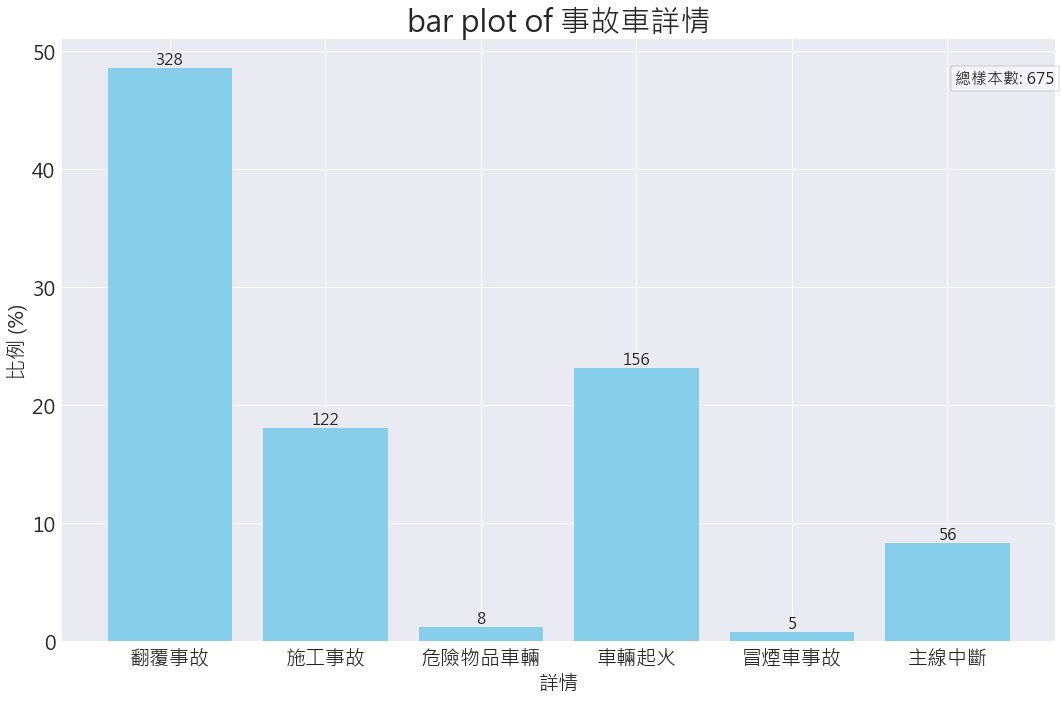

In [17]:
# "事故車詳情" bar plot
# find out there is a " " in col
sorted_df['翻覆事故\n註記'] = sorted_df['翻覆事故\n註記'].replace(" ", np.nan)

# find col
cols_to_sum = ['翻覆事故\n註記', '施工事故\n註記', '危險物品車輛\n註記',
               '車輛起火\n註記', '冒煙車事故\n註記', '主線中斷\n註記']
# count
sum_dict = {col: int(sorted_df[col].sum()) for col in cols_to_sum}
total_sum = sum(sum_dict.values())
# change into ratio
percentage_dict = {col: (value / total_sum * 100)
                   for col, value in sum_dict.items()}
# adjust col name
percentage_dict = {col.replace("\n註記", ""): (
    value / total_sum * 100) for col, value in sum_dict.items()}

# bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(percentage_dict.keys(),
               percentage_dict.values(), color='skyblue')
plt.title('bar plot of 事故車詳情', fontsize=30)
plt.xlabel('詳情', fontsize=20)
plt.ylabel('比例 (%)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(1, 0.95, f'總樣本數: {total_sum}', transform=plt.gca().transAxes, fontsize=16,
         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# text on bar
for bar, value in zip(bars, sum_dict.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value),
             ha='center', va='bottom', fontsize=16)

# show
plt.tight_layout()
plt.show()

## "肇事車輛數" box & bar plot

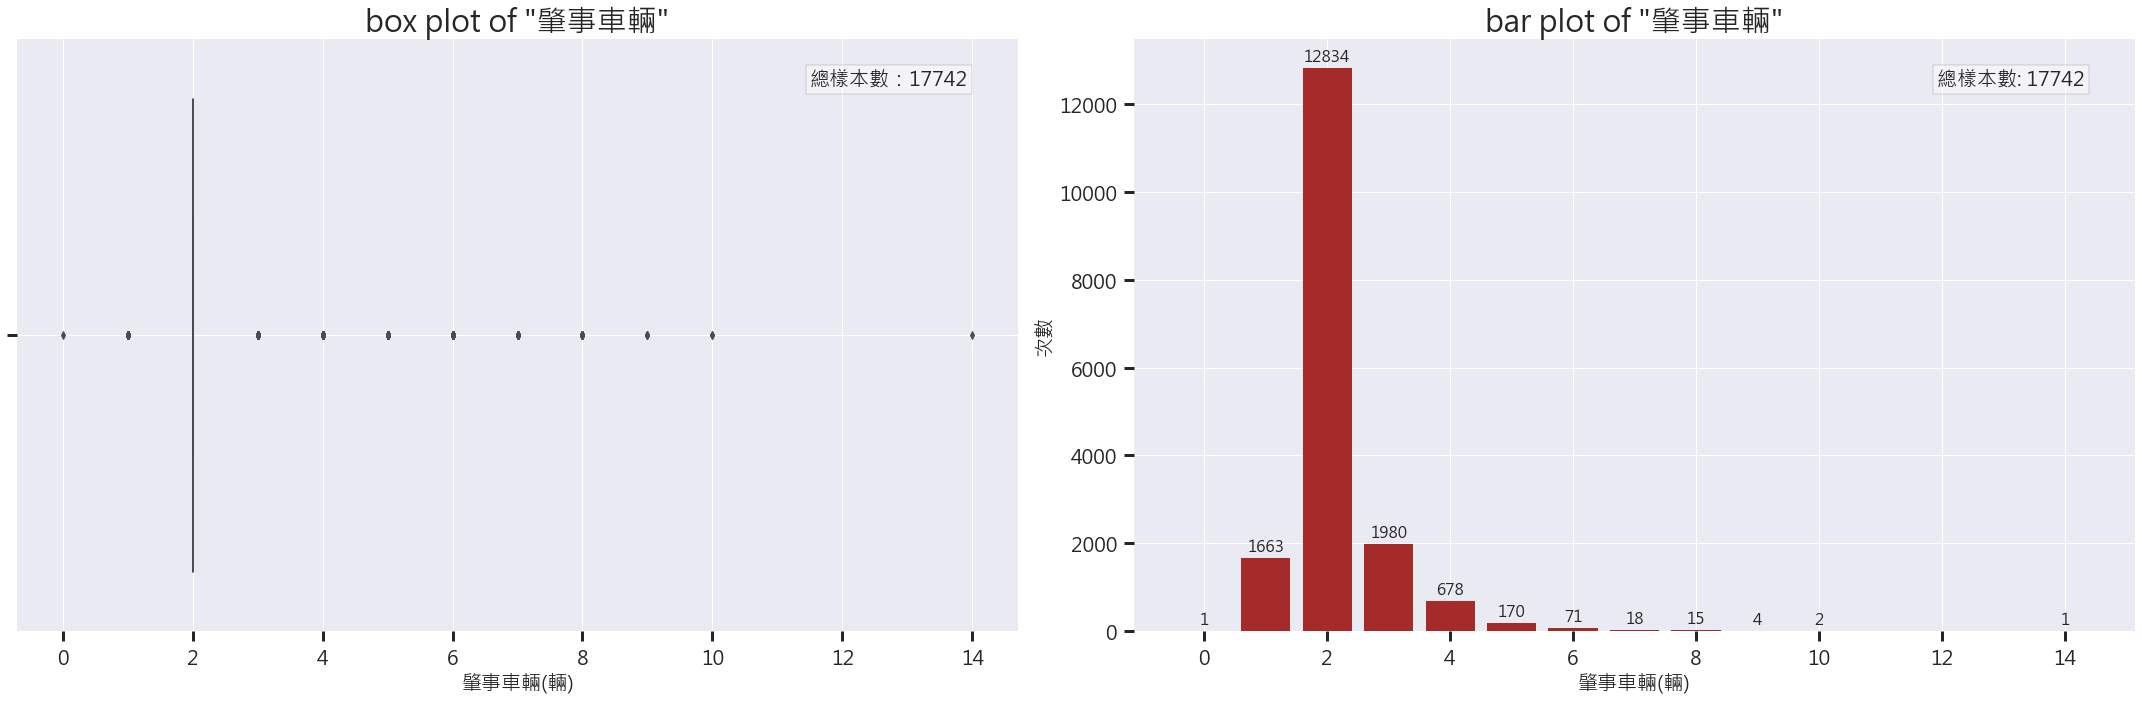

In [374]:
# "肇事車輛" box & bar plot
# count how many
total_samples = len(sorted_df)

# set fig
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 1st subplot : box plot
sns.boxplot(x=sorted_df['肇事車輛'], ax=axes[0])
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[0].set_title('box plot of "肇事車輛"', fontsize=30)
axes[0].set_xlabel('肇事車輛(輛)', fontsize=20)
axes[0].text(0.95, 0.95, f'總樣本數：{total_samples}',
             transform=axes[0].transAxes, fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# 2nd subplot : bar plot
bar_plot = axes[1].bar(sorted_df['肇事車輛'].value_counts(
).index, sorted_df['肇事車輛'].value_counts(), color='brown')
axes[1].set_title('bar plot of "肇事車輛"', fontsize=30)
axes[1].set_xlabel('肇事車輛(輛)', fontsize=20)
axes[1].set_ylabel('次數', fontsize=20)
axes[1].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[1].text(0.95, 0.95, f'總樣本數: {total_samples}', transform=axes[1].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# text on bar
for bar in bar_plot:
    height = bar.get_height()
    axes[1].annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=16)

# show
plt.tight_layout()
plt.show()

## "事故車輛類型" bar plot

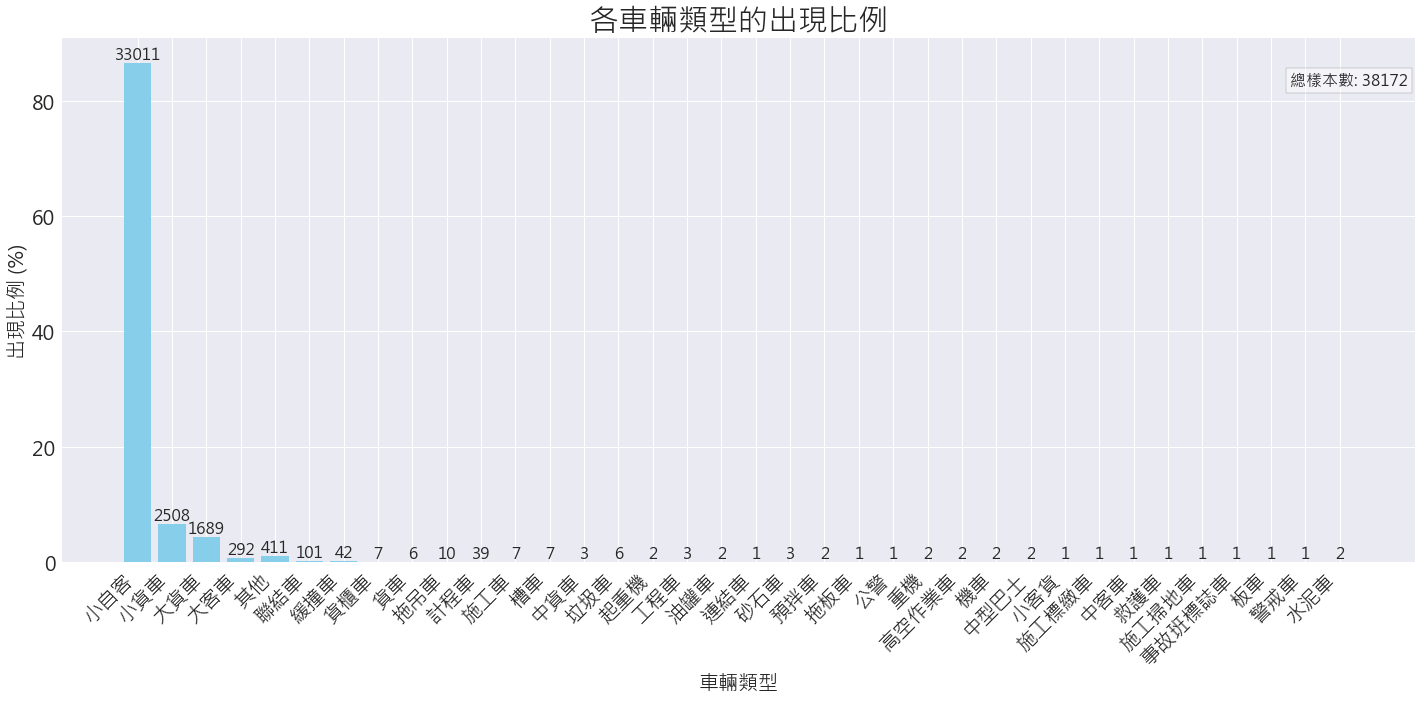

In [19]:
# "事故車輛類型" bar plot
# find col
cols_to_process = ['車輛1', '車輛2', '車輛3', '車輛4', '車輛5',
                   '車輛6', '車輛7', '車輛8', '車輛9', '車輛10', '車輛11', '車輛12']
# count
total_samples = 0
type_counts = {}
for col in cols_to_process:
    unique_values = sorted_df[col].value_counts()
    for value, count in unique_values.items():
        if value in type_counts:
            type_counts[value] += count
            total_samples += count
        else:
            type_counts[value] = count
            total_samples += count
# change into ratio
type_percentage = {key: count / total_samples *
                   100 for key, count in type_counts.items()}

# bar plot
plt.figure(figsize=(20, 10))
bars = plt.bar(type_percentage.keys(),
               type_percentage.values(), color='skyblue')
plt.title('各車輛類型的出現比例', fontsize=30)
plt.xlabel('車輛類型', fontsize=20)
plt.ylabel('出現比例 (%)', fontsize=20)
plt.xticks(fontsize=20, rotation=45, ha='right')
plt.yticks(fontsize=20)
plt.text(37, 85, f'總樣本數: {total_samples}', fontsize=16,
         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# text on bar
for bar, count in zip(bars, type_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=16)

# show
plt.tight_layout()
plt.show()

## "回堵長度" box & bar plot

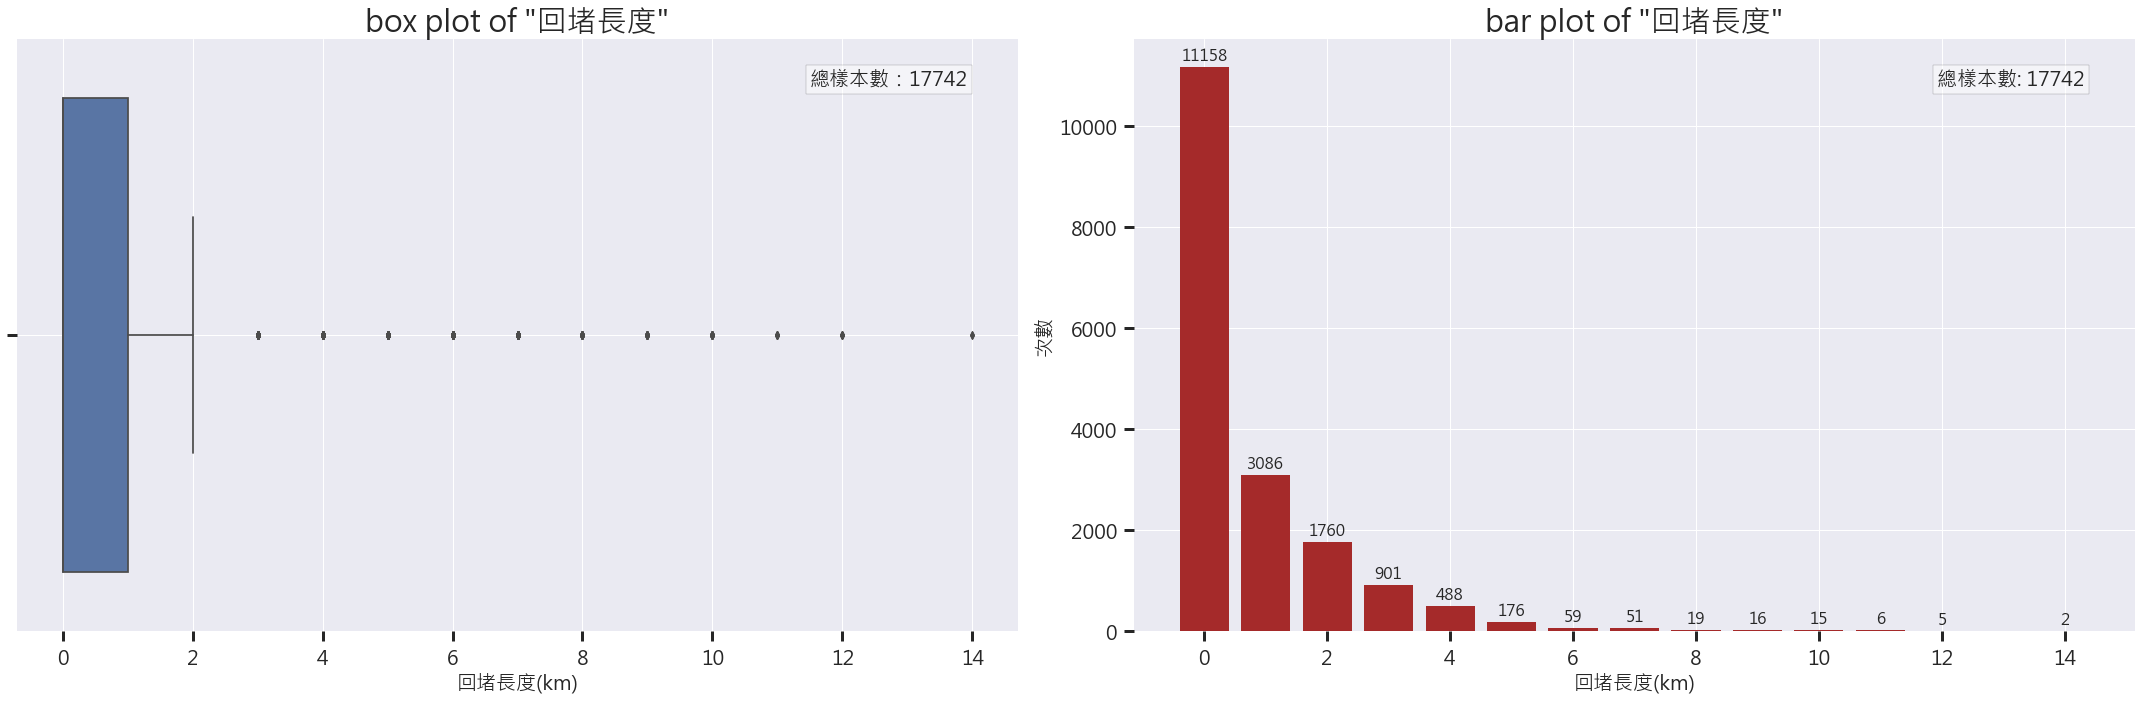

In [371]:
# "回堵長度" box & bar plot
# count how many
total_samples = len(sorted_df)

# set fig
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 1st subplot : box plot
sns.boxplot(x=sorted_df['回堵長度'], ax=axes[0])
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[0].set_title('box plot of "回堵長度"', fontsize=30)
axes[0].set_xlabel('回堵長度(km)', fontsize=20)
axes[0].text(0.95, 0.95, f'總樣本數：{total_samples}',
             transform=axes[0].transAxes, fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# 2nd subplot : bar plot
bar_plot = axes[1].bar(sorted_df['回堵長度'].value_counts(
).index, sorted_df['回堵長度'].value_counts(), color='brown')
axes[1].set_title('bar plot of "回堵長度"', fontsize=30)
axes[1].set_xlabel('回堵長度(km)', fontsize=20)
axes[1].set_ylabel('次數', fontsize=20)
axes[1].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[1].text(0.95, 0.95, f'總樣本數: {total_samples}', transform=axes[1].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# text on bar
for bar in bar_plot:
    height = bar.get_height()
    axes[1].annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=16)

# show
plt.tight_layout()
plt.show()

## "國道名稱" bar plot

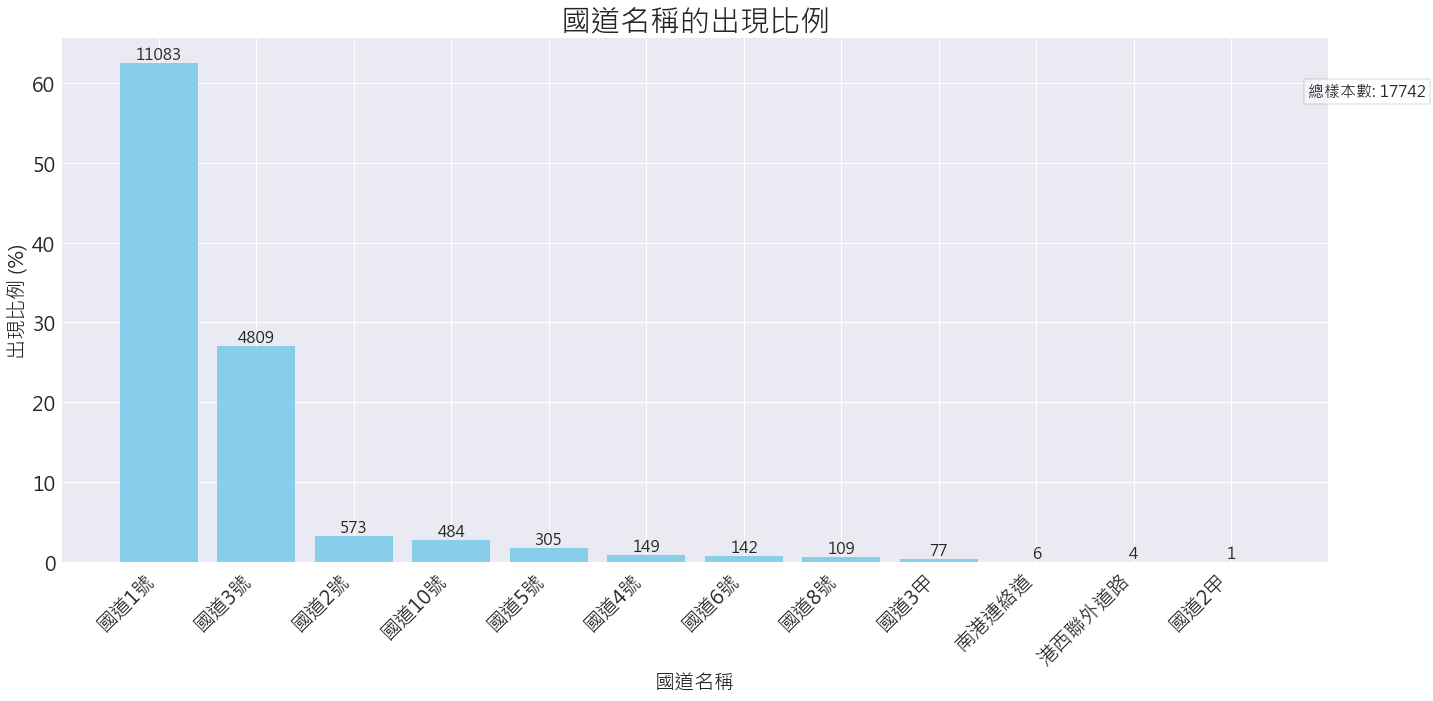

In [21]:
# "國道名稱" bar plot
# find col
cols_to_process = ['國道名稱']
# count
total_samples = 0
type_counts = {}
for col in cols_to_process:
    unique_values = sorted_df[col].value_counts()
    for value, count in unique_values.items():
        if value in type_counts:
            type_counts[value] += count
            total_samples += count
        else:
            type_counts[value] = count
            total_samples += count
# change into ratio
type_percentage = {key: count / total_samples *
                   100 for key, count in type_counts.items()}

# bar plot
plt.figure(figsize=(20, 10))
bars = plt.bar(type_percentage.keys(),
               type_percentage.values(), color='skyblue')
plt.title('國道名稱的出現比例', fontsize=30)
plt.xlabel('國道名稱', fontsize=20)
plt.ylabel('出現比例 (%)', fontsize=20)
plt.xticks(fontsize=20, rotation=45, ha='right')
plt.yticks(fontsize=20)
plt.text(13, 60, f'總樣本數: {total_samples}', fontsize=16,
         ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# text on bar
for bar, count in zip(bars, type_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=16)

# show
plt.tight_layout()
plt.show()

## "相近時間&地點" box & bar plot

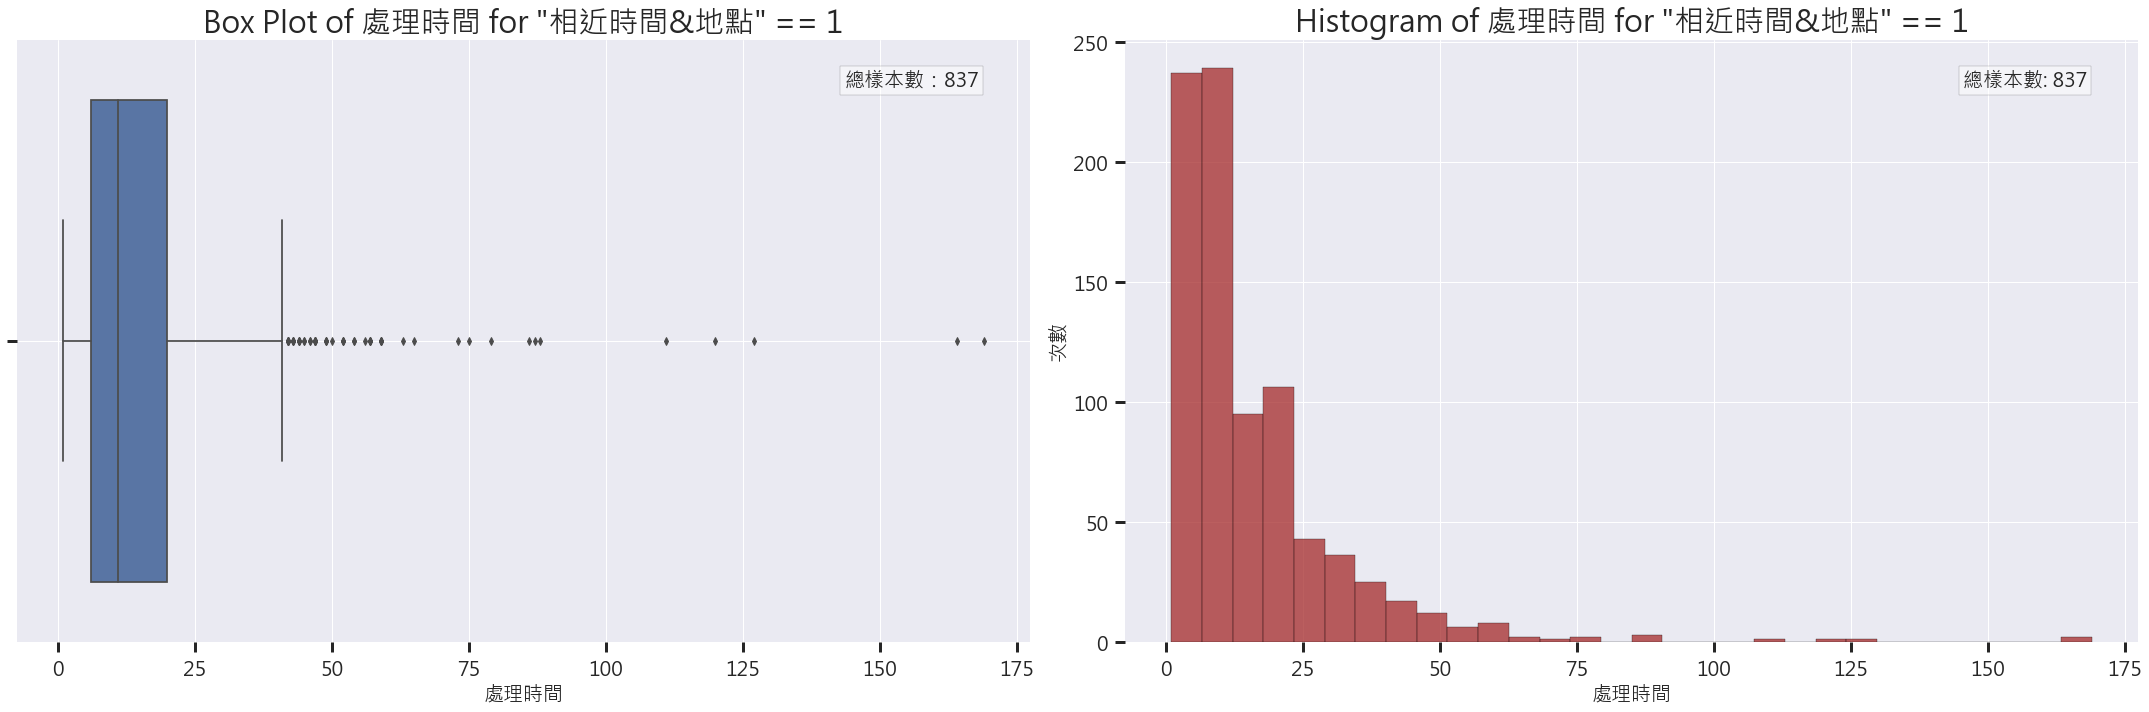

In [283]:
# 篩選 "相近時間&地點" == 1 的資料
filtered_df = sorted_df[sorted_df['相近時間&地點是否有事件'] == 1]

# 計算樣本總數
total_samples = len(filtered_df)

# 設定圖表
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 1st subplot : box plot
sns.boxplot(x=filtered_df['處理分鐘'], ax=axes[0])
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[0].set_title('Box Plot of "相近時間&地點" 有事件發生', fontsize=30)
axes[0].set_xlabel('處理分鐘', fontsize=20)
axes[0].text(0.95, 0.95, f'總樣本數：{total_samples}',
             transform=axes[0].transAxes, fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# 2nd subplot : histogram
sns.histplot(filtered_df['處理分鐘'], bins=30, kde=False, color='brown', ax=axes[1])
axes[1].set_title('Histogram of "相近時間&地點" 有事件發生', fontsize=30)
axes[1].set_xlabel('處理分鐘', fontsize=20)
axes[1].set_ylabel('次數', fontsize=20)
axes[1].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[1].text(0.95, 0.95, f'總樣本數: {total_samples}', transform=axes[1].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# show
plt.tight_layout()
plt.show()

# new visualize

## def func 計算&顯示時間

In [6]:
# change time into sec
def time_to_seconds(time_val):
    return time_val.hour * 3600 + time_val.minute * 60 + time_val.second

# Convert seconds to 6-hour intervals format
def format_seconds(x, pos):
    hours = int(x / 3600)
    # Round to the nearest 6-hour interval
    rounded_hours = 6 * round(hours / 6)
    return f"{rounded_hours:02d}:00:00"

# change str into datetime
def str_to_time(time_str):
    return datetime.strptime(time_str, "%H:%M:%S")

# change str to 24hr time format
def format_time_label(time_bin_label):
    start_sec = int(time_bin_label.split(",")[0][1:])
    start_hour = start_sec // 3600
    end_hour = (start_sec + 3 * 3600) // 3600
    return f"{start_hour:02d}:00~{end_hour:02d}:00"

## 抓出繪圖的重要變數

### 國道1號

In [30]:
# "國道1號"
df_highway_1 = sorted_df[sorted_df['國道名稱'] == '國道1號']
# variable
df_highway_1 = df_highway_1[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]

# change str into datetime to caculate
df_highway_1['事件發生'] = df_highway_1['事件發生'].apply(str_to_time)
df_highway_1['事件排除'] = df_highway_1['事件排除'].apply(str_to_time)

# check
df_highway_1

國道名稱 方向     里程                事件發生                事件排除  處理分鐘
0      國道1號  北  286.0 1900-01-01 00:31:00 1900-01-01 00:39:00     8
4      國道1號  南  367.4 1900-01-01 09:03:00 1900-01-01 09:22:00    19
6      國道1號  南   88.0 1900-01-01 09:39:00 1900-01-01 10:06:00    27
7      國道1號  北  308.3 1900-01-01 09:55:00 1900-01-01 09:59:00     4
8      國道1號  南  156.0 1900-01-01 10:27:00 1900-01-01 10:34:00     7
...     ... ..    ...                 ...                 ...   ...
17730  國道1號  南  205.5 1900-01-01 16:10:00 1900-01-01 16:17:00     7
17734  國道1號  南  317.7 1900-01-01 18:37:00 1900-01-01 18:40:00     3
17735  國道1號  南  353.0 1900-01-01 18:40:00 1900-01-01 19:04:00    24
17739  國道1號  南   96.0 1900-01-01 22:13:00 1900-01-01 22:25:00    12
17741  國道1號  南   49.0 1900-01-01 23:11:00 1900-01-01 23:18:00     7

[11083 rows x 6 columns]

In [57]:
# save "事件發生" sec to new col "事件發生(秒數)"
df_highway_1['事件發生(秒數)'] = df_highway_1['事件發生'].apply(time_to_seconds)

# save "事件排除" sec to new col "事件排除(秒數)"
df_highway_1['事件排除(秒數)'] = df_highway_1['事件排除'].apply(time_to_seconds)

# save "處理分鐘" sec to new col "處理分鐘(秒數)"
df_highway_1['處理分鐘(秒數)'] = df_highway_1['處理分鐘'] * 60

# take "北"向的
df_north_direction = df_highway_1[df_highway_1['方向'] == '北']
df_north_direction

# take "南"向的
df_south_direction = df_highway_1[df_highway_1['方向'] == '南']
df_south_direction

國道名稱 方向     里程                事件發生                事件排除  處理分鐘  事件發生(秒數)  \
4      國道1號  南  367.4 1900-01-01 09:03:00 1900-01-01 09:22:00    19     32580   
6      國道1號  南   88.0 1900-01-01 09:39:00 1900-01-01 10:06:00    27     34740   
8      國道1號  南  156.0 1900-01-01 10:27:00 1900-01-01 10:34:00     7     37620   
9      國道1號  南   41.0 1900-01-01 10:34:00 1900-01-01 11:01:00    27     38040   
10     國道1號  南   70.0 1900-01-01 11:15:00 1900-01-01 11:26:00    11     40500   
...     ... ..    ...                 ...                 ...   ...       ...   
17730  國道1號  南  205.5 1900-01-01 16:10:00 1900-01-01 16:17:00     7     58200   
17734  國道1號  南  317.7 1900-01-01 18:37:00 1900-01-01 18:40:00     3     67020   
17735  國道1號  南  353.0 1900-01-01 18:40:00 1900-01-01 19:04:00    24     67200   
17739  國道1號  南   96.0 1900-01-01 22:13:00 1900-01-01 22:25:00    12     79980   
17741  國道1號  南   49.0 1900-01-01 23:11:00 1900-01-01 23:18:00     7     83460   

       事件排除(秒數)  處理分鐘(秒數)  
4         33720      1140  
6         36360      1620  
8         38040       420  
9         39660      1620  
10        41160       660  
...         ...       ...  
17730     58620       420  
17734     67200       180  
17735     68640      1440  
17739     80700       720  
17741     83880       420  

[5313 rows x 9 columns]

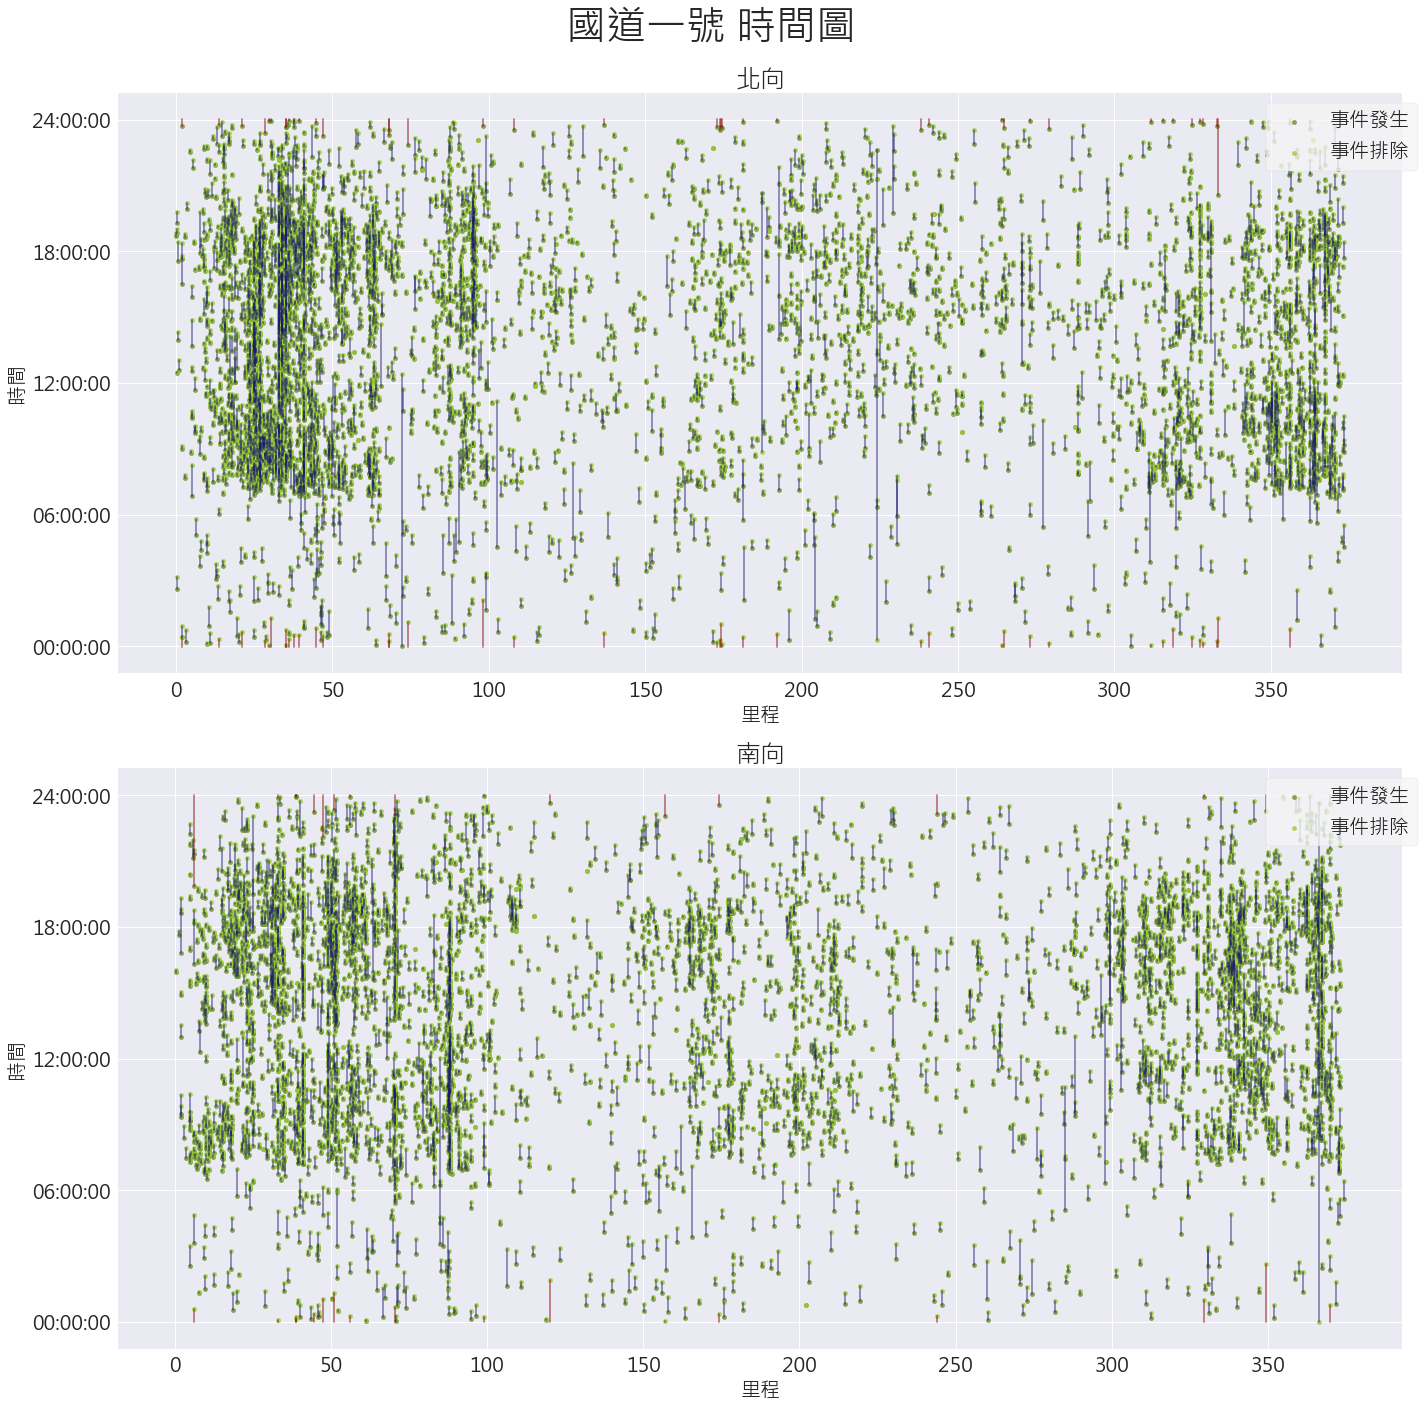

In [25]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# 上半部分 - 北向資料
# def x, y
x = df_north_direction['里程']
y_event = df_north_direction['事件發生(秒數)']
y_clear = df_north_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_north_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('北向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 南向資料
# def x, y
x = df_south_direction['里程']
y_event = df_south_direction['事件發生(秒數)']
y_clear = df_south_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_south_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('南向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道一號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


#### 里程 --- 處理分鐘

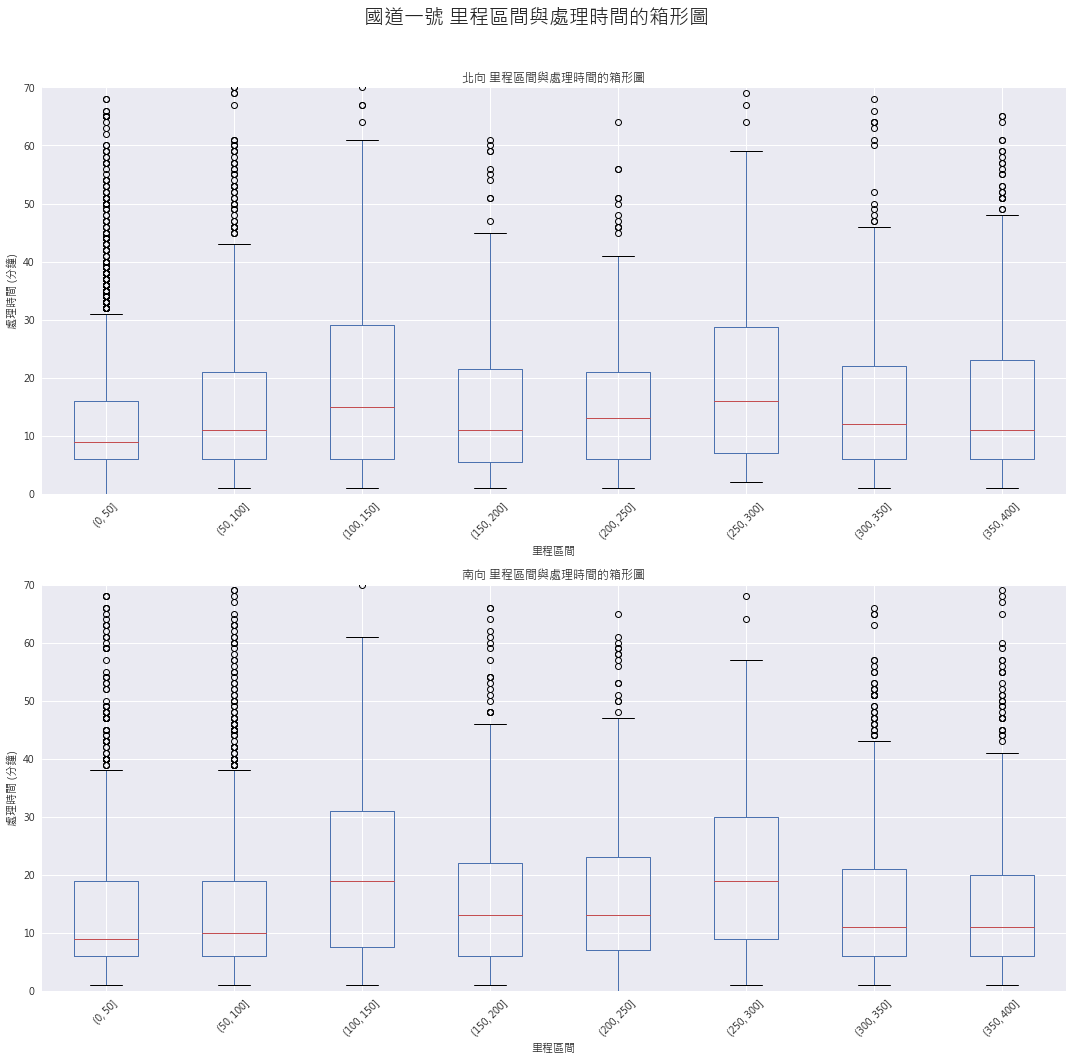

In [9]:
# create copy df
df_north_direction_copy = df_north_direction.copy()
df_south_direction_copy = df_south_direction.copy()

# change sec into min
df_north_direction_copy.loc[:, '處理分鐘(分鐘)'] = df_north_direction_copy['處理分鐘(秒數)'] / 60
df_south_direction_copy.loc[:, '處理分鐘(分鐘)'] = df_south_direction_copy['處理分鐘(秒數)'] / 60

# change "里程" to every 50km
bins = range(0, int(max(df_north_direction_copy['里程'].max(), df_south_direction_copy['里程'].max())) + 50, 50)
df_north_direction_copy.loc[:, '里程區間'] = pd.cut(df_north_direction_copy['里程'], bins=bins)
df_south_direction_copy.loc[:, '里程區間'] = pd.cut(df_south_direction_copy['里程'], bins=bins)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# box plot for "北向"
df_north_boxplot = df_north_direction_copy[['里程區間', '處理分鐘(分鐘)']]
df_north_boxplot.boxplot(by='里程區間', column=['處理分鐘(分鐘)'], ax=ax1)
ax1.set_title('北向 里程區間與處理時間的箱形圖')
ax1.set_xlabel('里程區間')
ax1.set_ylabel('處理時間 (分鐘)')
ax1.set_ylim(0,70)
ax1.tick_params(axis='x', rotation=45)

# box plot for "南向"
df_south_boxplot = df_south_direction_copy[['里程區間', '處理分鐘(分鐘)']]
df_south_boxplot.boxplot(by='里程區間', column=['處理分鐘(分鐘)'], ax=ax2)
ax2.set_title('南向 里程區間與處理時間的箱形圖')
ax2.set_xlabel('里程區間')
ax2.set_ylabel('處理時間 (分鐘)')
ax2.set_ylim(0,70)
ax2.tick_params(axis='x', rotation=45)

# adjust
plt.suptitle('國道一號 里程區間與處理時間的箱形圖', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show
plt.show()


In [37]:
# count samples in every time group
north_sample_count = df_north_boxplot.groupby('里程區間').size()
south_sample_count = df_south_boxplot.groupby('里程區間').size()

# use df to show
df_sample_count = pd.DataFrame({
    '北向樣本數': north_sample_count,
    '南向樣本數': south_sample_count
})
df_sample_count.reset_index(inplace=True)
df_sample_count.rename(columns={'發生時間(小時)': '時間區間'}, inplace=True)
df_sample_count

里程區間  北向樣本數  南向樣本數
0     (0, 50]   2397   1264
1   (50, 100]    991   1333
2  (100, 150]    221    191
3  (150, 200]    367    533
4  (200, 250]    355    282
5  (250, 300]    214    202
6  (300, 350]    562    976
7  (350, 400]    657    529

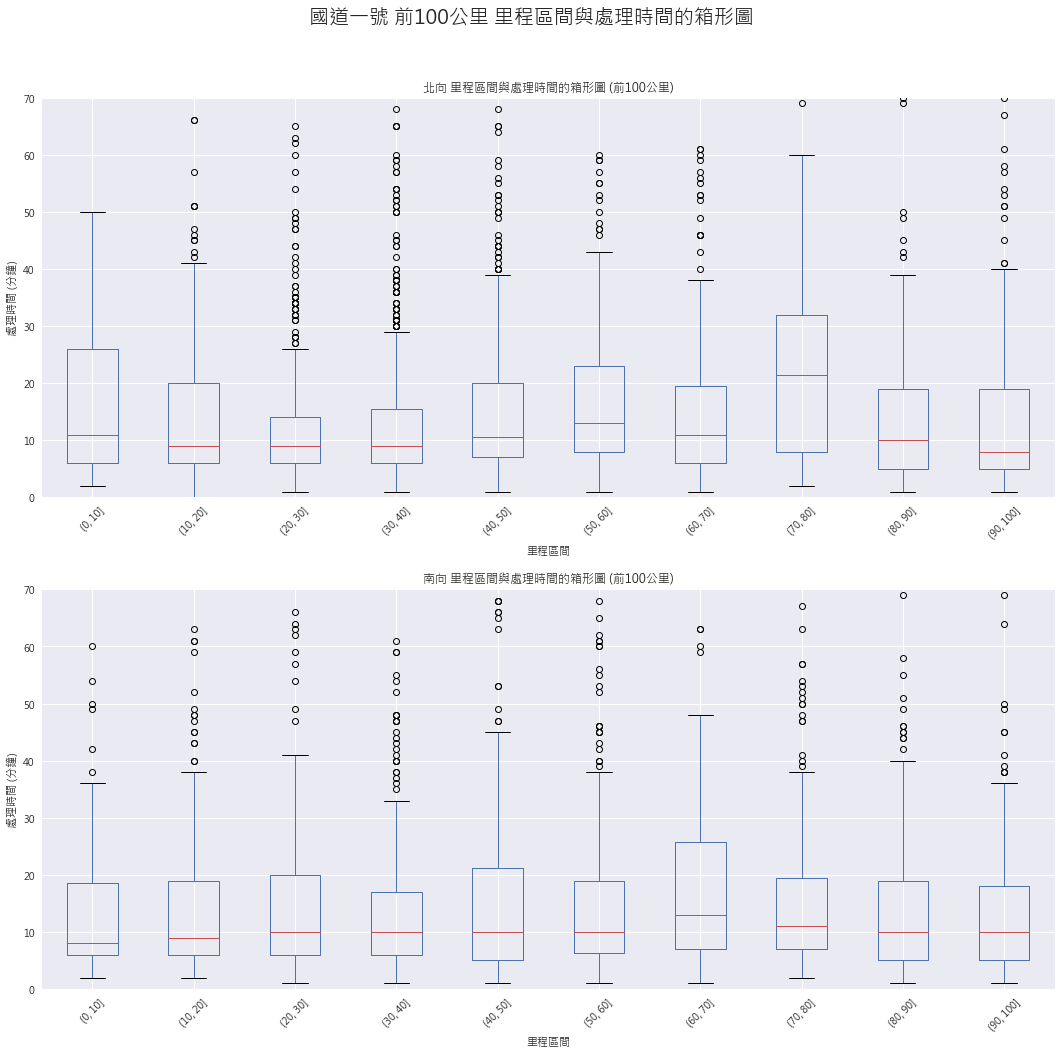

In [41]:
# create copy df
df_north_direction_copy = df_north_direction.copy()
df_south_direction_copy = df_south_direction.copy()

# change sec into min
df_north_direction_copy.loc[:, '處理分鐘(分鐘)'] = df_north_direction_copy['處理分鐘(秒數)'] / 60
df_south_direction_copy.loc[:, '處理分鐘(分鐘)'] = df_south_direction_copy['處理分鐘(秒數)'] / 60

# change "里程" to first 100km
df_north_100km = df_north_direction_copy[df_north_direction_copy['里程'] <= 100]
df_south_100km = df_south_direction_copy[df_south_direction_copy['里程'] <= 100]

# create copy df
df_north_100km_copy = df_north_100km.copy()
df_south_100km_copy = df_south_100km.copy()

# every 10km a group
bins = range(0, 110, 10)
df_north_100km_copy.loc[:, '里程區間'] = pd.cut(df_north_100km_copy['里程'], bins=bins)
df_south_100km_copy.loc[:, '里程區間'] = pd.cut(df_south_100km_copy['里程'], bins=bins)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

# box plot for "北向"
df_north_boxplot = df_north_100km_copy[['里程區間', '處理分鐘(分鐘)']]
df_north_boxplot.boxplot(by='里程區間', column=['處理分鐘(分鐘)'], ax=ax1)
ax1.set_title('北向 里程區間與處理時間的箱形圖 (前100公里)')
ax1.set_xlabel('里程區間')
ax1.set_ylabel('處理時間 (分鐘)')
ax1.set_ylim(0, 70)
ax1.tick_params(axis='x', rotation=45)

# box plot for "南向"
df_south_boxplot = df_south_100km_copy[['里程區間', '處理分鐘(分鐘)']]
df_south_boxplot.boxplot(by='里程區間', column=['處理分鐘(分鐘)'], ax=ax2)
ax2.set_title('南向 里程區間與處理時間的箱形圖 (前100公里)')
ax2.set_xlabel('里程區間')
ax2.set_ylabel('處理時間 (分鐘)')
ax2.set_ylim(0, 70)
ax2.tick_params(axis='x', rotation=45)

# adjust
plt.suptitle('國道一號 前100公里 里程區間與處理時間的箱形圖', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show
plt.show()


In [42]:
# count samples in every time group
north_sample_count = df_north_boxplot.groupby('里程區間').size()
south_sample_count = df_south_boxplot.groupby('里程區間').size()

# use df to show
df_sample_count = pd.DataFrame({
    '北向樣本數': north_sample_count,
    '南向樣本數': south_sample_count
})
df_sample_count.reset_index(inplace=True)
df_sample_count.rename(columns={'發生時間(小時)': '時間區間'}, inplace=True)
df_sample_count

里程區間  北向樣本數  南向樣本數
0    (0, 10]     83    119
1   (10, 20]    281    217
2   (20, 30]    700    245
3   (30, 40]    887    375
4   (40, 50]    446    308
5   (50, 60]    234    410
6   (60, 70]    235    170
7   (70, 80]     52    235
8   (80, 90]    161    357
9  (90, 100]    309    161

#### 事件發生 --- 處理分鐘

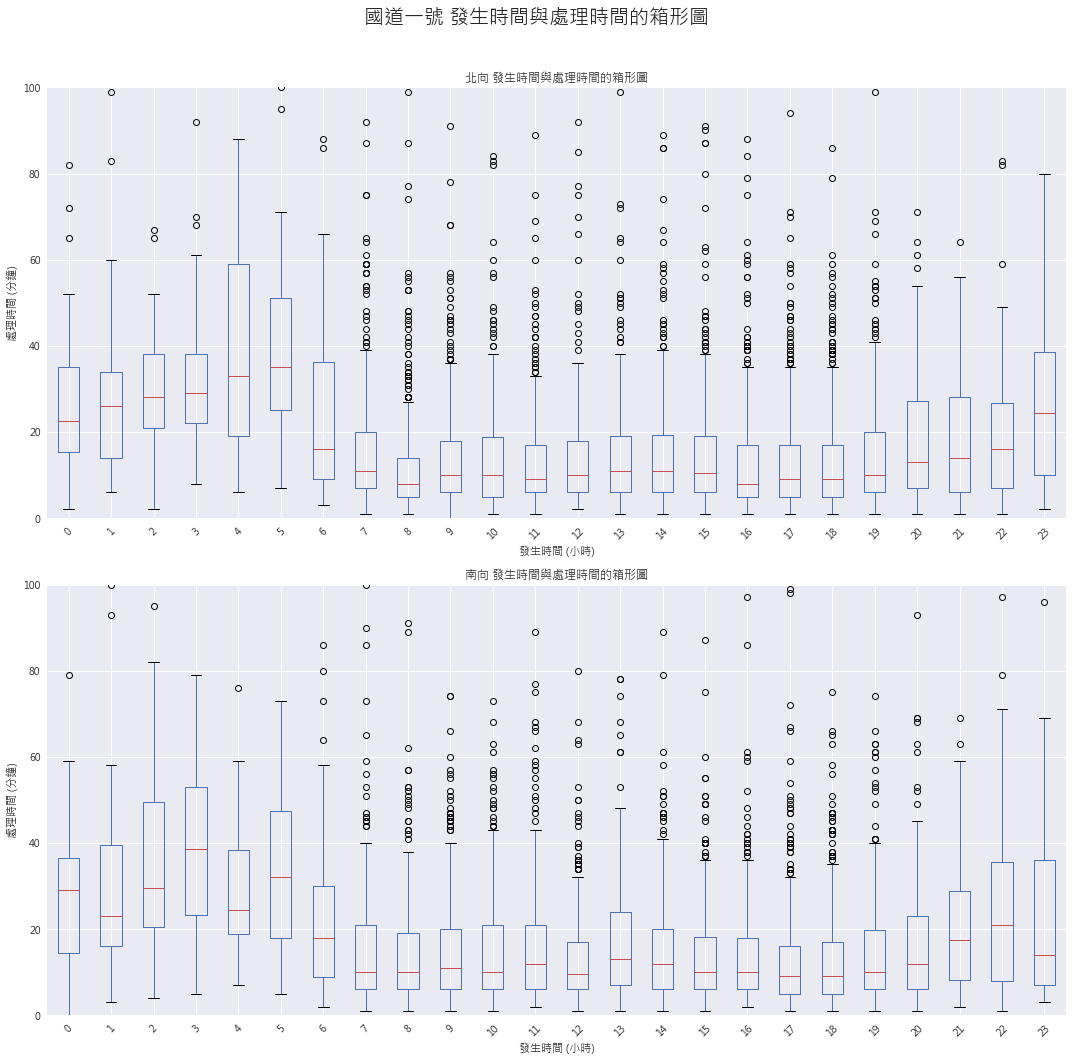

In [10]:
# create copy df
df_north_direction_copy = df_north_direction.copy()
df_south_direction_copy = df_south_direction.copy()

# change sec into min
df_north_direction_copy.loc[:, '處理分鐘(分鐘)'] = df_north_direction_copy['處理分鐘(秒數)'] / 60
df_south_direction_copy.loc[:, '處理分鐘(分鐘)'] = df_south_direction_copy['處理分鐘(秒數)'] / 60

# change "事件發生時間" into hr & group
df_north_direction_copy.loc[:, '發生時間(小時)'] = df_north_direction_copy['事件發生(秒數)'] // 3600
df_south_direction_copy.loc[:, '發生時間(小時)'] = df_south_direction_copy['事件發生(秒數)'] // 3600

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# box plot for "北向"
df_north_boxplot = df_north_direction_copy[['發生時間(小時)', '處理分鐘(分鐘)']]
df_north_boxplot.boxplot(by='發生時間(小時)', column=['處理分鐘(分鐘)'], ax=ax1)
ax1.set_title('北向 發生時間與處理時間的箱形圖')
ax1.set_xlabel('發生時間 (小時)')
ax1.set_ylabel('處理時間 (分鐘)')
ax1.set_ylim(0,100)
ax1.tick_params(axis='x', rotation=45)

# box plot for "南向"
df_south_boxplot = df_south_direction_copy[['發生時間(小時)', '處理分鐘(分鐘)']]
df_south_boxplot.boxplot(by='發生時間(小時)', column=['處理分鐘(分鐘)'], ax=ax2)
ax2.set_title('南向 發生時間與處理時間的箱形圖')
ax2.set_xlabel('發生時間 (小時)')
ax2.set_ylabel('處理時間 (分鐘)')
ax2.set_ylim(0,100)
ax2.tick_params(axis='x', rotation=45)

# adjust
plt.suptitle('國道一號 發生時間與處理時間的箱形圖', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show
plt.show()


In [45]:
# count samples in every time group
north_sample_count = df_north_boxplot.groupby('發生時間(小時)').size()
south_sample_count = df_south_boxplot.groupby('發生時間(小時)').size()

# use df to show
df_sample_count = pd.DataFrame({
    '北向樣本數': north_sample_count,
    '南向樣本數': south_sample_count
})
df_sample_count.reset_index(inplace=True)
df_sample_count.rename(columns={'發生時間(小時)': '時間區間'}, inplace=True)
df_sample_count

時間區間  北向樣本數  南向樣本數
0      0     46     47
1      1     28     39
2      2     35     40
3      3     41     30
4      4     41     24
5      5     41     40
6      6     80     76
7      7    377    267
8      8    463    341
9      9    426    309
10    10    366    366
11    11    345    323
12    12    245    224
13    13    270    214
14    14    376    336
15    15    398    380
16    16    442    453
17    17    450    482
18    18    548    508
19    19    294    338
20    20    172    202
21    21    119    118
22    22     94    103
23    23     72     53

#### heat map

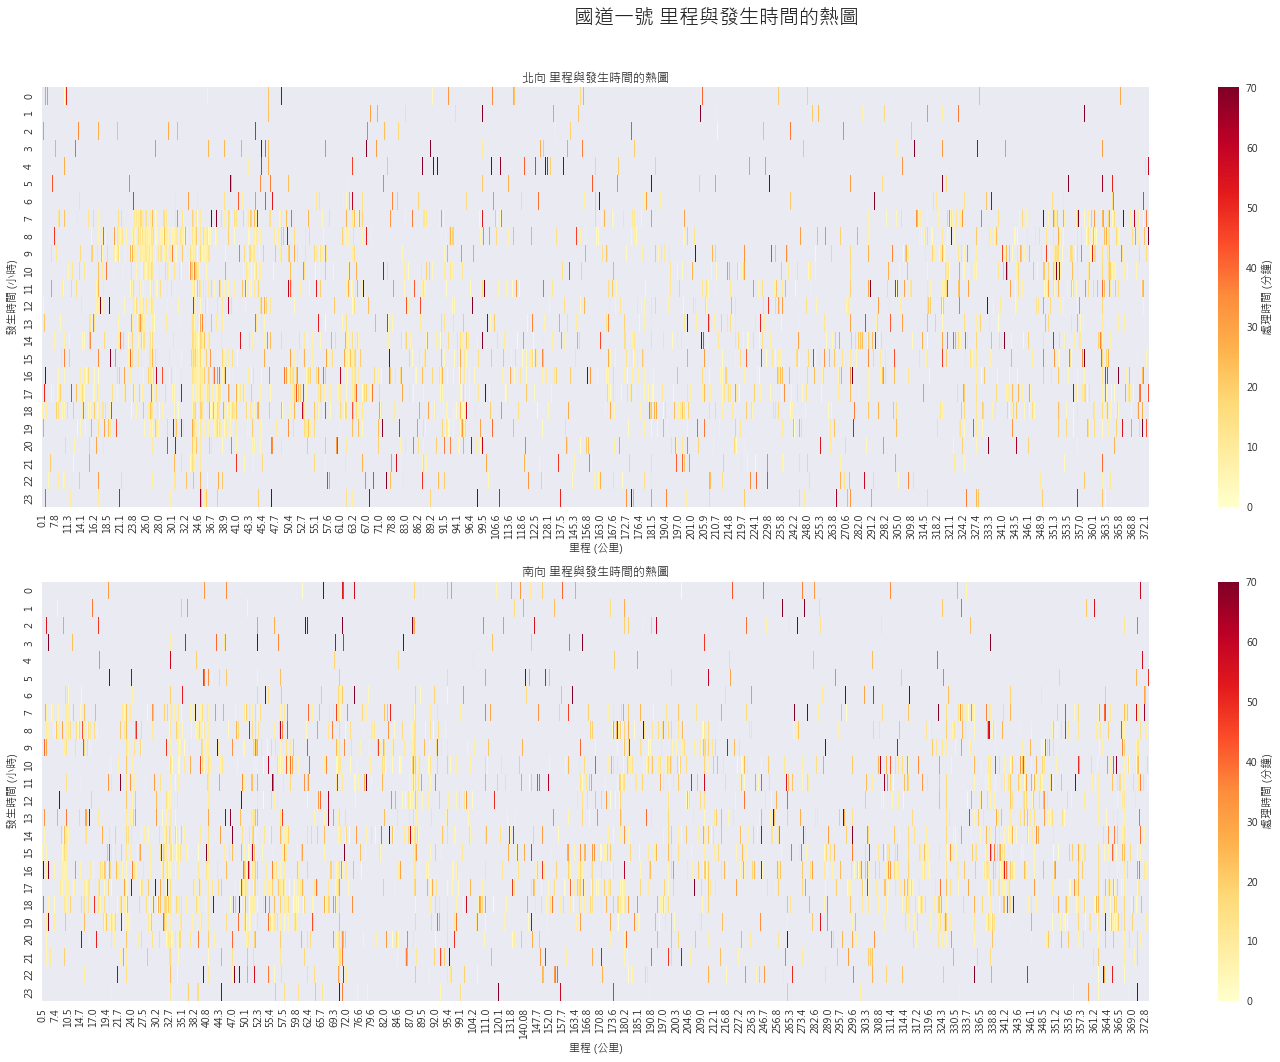

In [134]:
# create copy df
df_north_direction_copy = df_north_direction.copy()
df_south_direction_copy = df_south_direction.copy()

# change sec into min
df_north_direction_copy['處理分鐘(分鐘)'] = df_north_direction_copy['處理分鐘(秒數)'] / 60
df_south_direction_copy['處理分鐘(分鐘)'] = df_south_direction_copy['處理分鐘(秒數)'] / 60

# seg time into slice
df_north_direction_copy['發生時間(小時)'] = df_north_direction_copy['事件發生(秒數)'] // 3600
df_south_direction_copy['發生時間(小時)'] = df_south_direction_copy['事件發生(秒數)'] // 3600

# limit 處理時間 in 0~70, over 70 == 70
df_north_direction_copy['處理分鐘(分鐘)'] = df_north_direction_copy['處理分鐘(分鐘)'].clip(upper=70)
df_south_direction_copy['處理分鐘(分鐘)'] = df_south_direction_copy['處理分鐘(分鐘)'].clip(upper=70)

# def create heatmap
def create_heatmap_df(df):
    heatmap_df = df.pivot_table(values='處理分鐘(分鐘)', index='發生時間(小時)', columns='里程', aggfunc='mean')
    return heatmap_df

# df heatmap
## north
heatmap_north = create_heatmap_df(df_north_direction_copy)
## south
heatmap_south = create_heatmap_df(df_south_direction_copy)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# heatmap
## north
sns.heatmap(heatmap_north, cmap='YlOrRd', ax=ax1, cbar_kws={'label': '處理時間 (分鐘)'})
ax1.set_title('北向 里程與發生時間的熱圖')
ax1.set_xlabel('里程 (公里)')
ax1.set_ylabel('發生時間 (小時)')
## south
sns.heatmap(heatmap_south, cmap='YlOrRd', ax=ax2, cbar_kws={'label': '處理時間 (分鐘)'})
ax2.set_title('南向 里程與發生時間的熱圖')
ax2.set_xlabel('里程 (公里)')
ax2.set_ylabel('發生時間 (小時)')

# adjust
plt.suptitle('國道一號 里程與發生時間的熱圖', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show
plt.show()


#### 改成新的分格區間

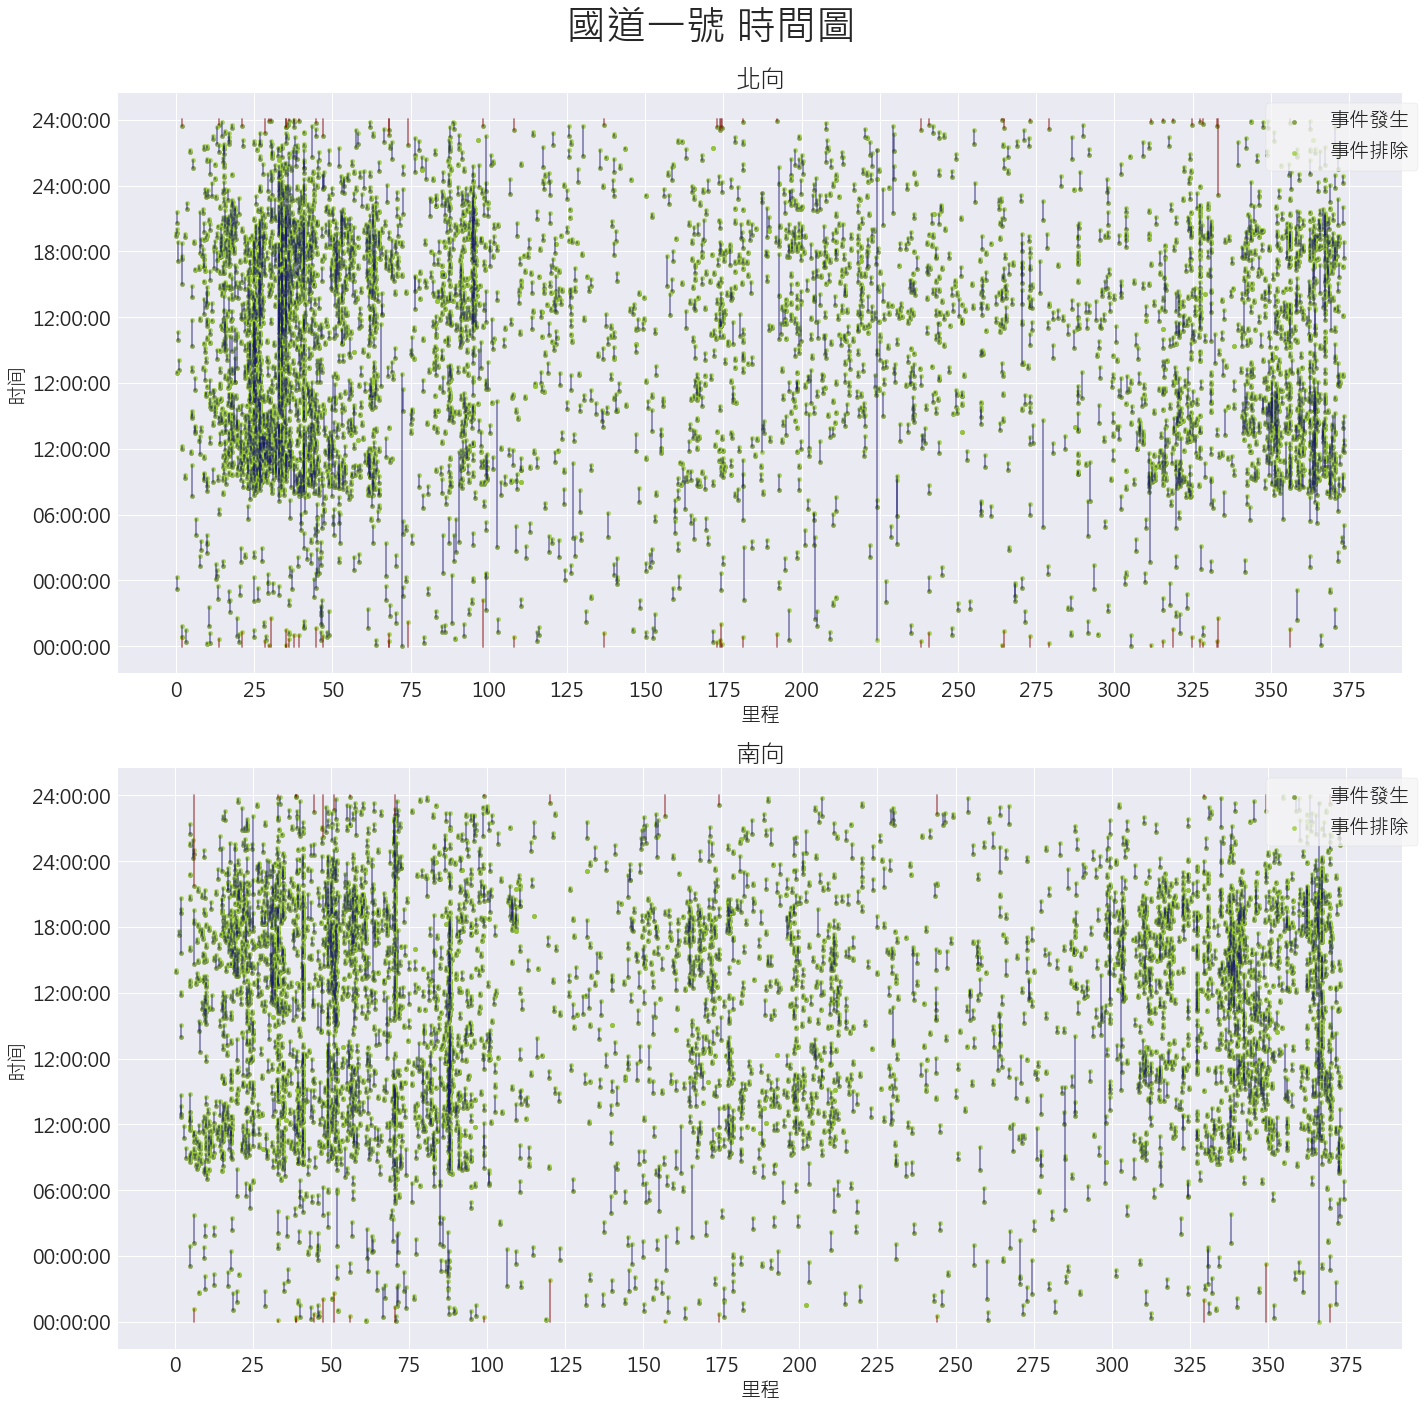

In [49]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# 上半部分 - north
# def x, y
x = df_north_direction['里程']
y_event = df_north_direction['事件發生(秒數)']
y_clear = df_north_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    if y_event.iloc[i] + df_north_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('北向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('时间', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_locator(MultipleLocator(3 * 3600))
ax1.xaxis.set_major_locator(MultipleLocator(25))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - south
# 定义x, y
x = df_south_direction['里程']
y_event = df_south_direction['事件發生(秒數)']
y_clear = df_south_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    if y_event.iloc[i] + df_south_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('南向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('时间', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_locator(MultipleLocator(3 * 3600))
ax2.xaxis.set_major_locator(MultipleLocator(25))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')
plt.suptitle('國道一號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


#### 用 heat map 顯示各區間的樣本數 (total)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '00:00~03:00'),
  Text(0, 1.5, '03:00~06:00'),
  Text(0, 2.5, '06:00~09:00'),
  Text(0, 3.5, '09:00~12:00'),
  Text(0, 4.5, '12:00~15:00'),
  Text(0, 5.5, '15:00~18:00'),
  Text(0, 6.5, '18:00~21:00'),
  Text(0, 7.5, '21:00~24:00')])

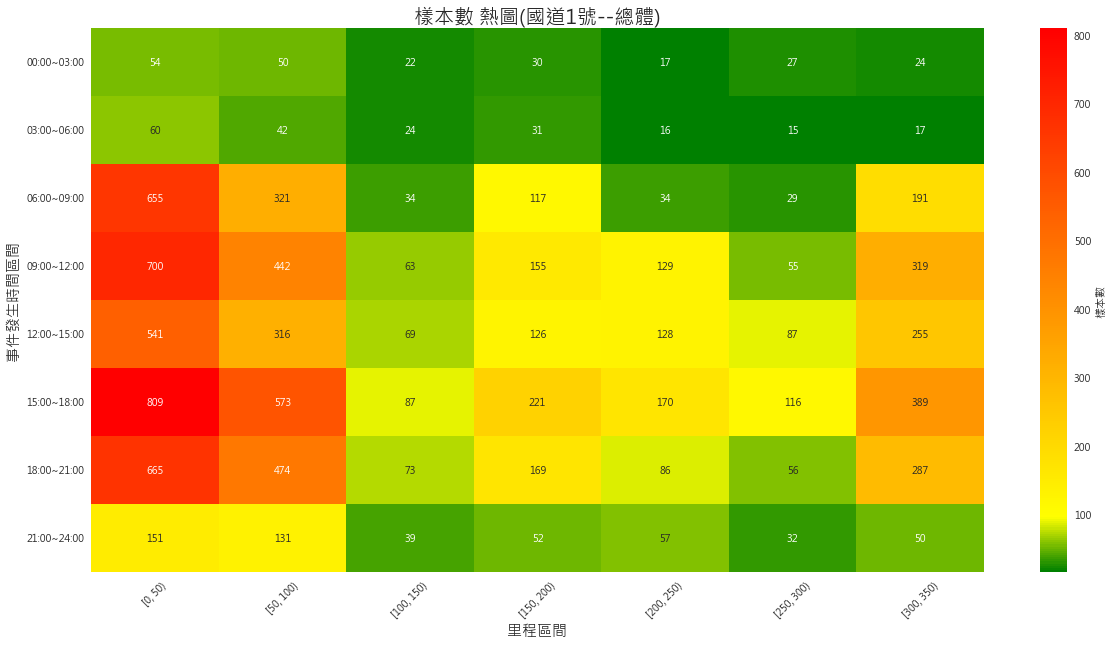

In [431]:
# show sample heatmap(total)
# def block
## time : 3 hr
## mile : 50 km
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(df_highway_1['里程'].min(), df_highway_1['里程'].max() + 1, mile_block, dtype=int)

# add newe col to separate sample
df_highway_1['事件發生時間區間'] = pd.cut(df_highway_1['事件發生(秒數)'], bins=time_bins, right=False)
df_highway_1['里程區間'] = pd.cut(df_highway_1['里程'], bins=mile_bins, right=False)

# caculate the sample
## type(sample_counts) == dataframe
sample_counts = df_highway_1.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')

# change into str to create pivot
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
# pivot
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# use func to change str into 24hr
pivot_table.index = pivot_table.index.map(format_time_label)

# sort x axis(so hard)
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))

# default color to highlight 100
## 0.1 is for (max*0.1)~100
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.1, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# show heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道1號--總體)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

#### 切割看有哪些格子的編號

In [460]:
# init result
result_indices = []

# num
time_intervals = 8
mile_intervals = 7
# every interval
time_interval_size = 10800
mile_interval_size = 50

# save
for i in range(time_intervals):
    for j in range(mile_intervals):
        time_start = i * time_interval_size
        time_end = (i + 1) * time_interval_size
        mile_start = j * mile_interval_size
        mile_end = (j + 1) * mile_interval_size
        # filter
        filtered_data = df_highway_1[
            (df_highway_1['事件發生(秒數)'] >= time_start) & (df_highway_1['事件發生(秒數)'] < time_end) &
            (df_highway_1['里程'] >= mile_start) & (df_highway_1['里程'] < mile_end)
        ]
        # save to list
        result_indices.append(filtered_data.index.tolist())

# result
for idx, indices in enumerate(result_indices):
    print(f"Filtered Data {idx} Indices: {len(indices)}")

Filtered Data 0 Indices: 54
Filtered Data 1 Indices: 50
Filtered Data 2 Indices: 22
Filtered Data 3 Indices: 30
Filtered Data 4 Indices: 17
Filtered Data 5 Indices: 27
Filtered Data 6 Indices: 24
Filtered Data 7 Indices: 60
Filtered Data 8 Indices: 42
Filtered Data 9 Indices: 24
Filtered Data 10 Indices: 31
Filtered Data 11 Indices: 16
Filtered Data 12 Indices: 15
Filtered Data 13 Indices: 17
Filtered Data 14 Indices: 655
Filtered Data 15 Indices: 321
Filtered Data 16 Indices: 34
Filtered Data 17 Indices: 117
Filtered Data 18 Indices: 34
Filtered Data 19 Indices: 29
Filtered Data 20 Indices: 191
Filtered Data 21 Indices: 700
Filtered Data 22 Indices: 442
Filtered Data 23 Indices: 63
Filtered Data 24 Indices: 155
Filtered Data 25 Indices: 129
Filtered Data 26 Indices: 55
Filtered Data 27 Indices: 319
Filtered Data 28 Indices: 541
Filtered Data 29 Indices: 316
Filtered Data 30 Indices: 69
Filtered Data 31 Indices: 126
Filtered Data 32 Indices: 128
Filtered Data 33 Indices: 87
Filtered Da

#### 切割需要的格子

In [461]:
# filter
indices_to_use = result_indices[14]
filtered_df = sorted_df.loc[indices_to_use]
filtered_df

年   月   日  時   分  國道名稱 方向    里程      事件發生      事件排除  ...  車輛10 車輛11  \
131    2023   1   3  8   9  國道1號  南  18.0  08:09:00  08:52:00  ...   NaN  NaN   
137    2023   1   3  8  54  國道1號  北  26.6  08:54:00  09:01:00  ...   NaN  NaN   
229    2023   1   5  8  41  國道1號  北  36.3  08:41:00  08:43:00  ...   NaN  NaN   
231    2023   1   5  8  53  國道1號  北  24.1  08:53:00  09:02:00  ...   NaN  NaN   
348    2023   1   7  7  35  國道1號  南  23.8  07:35:00  08:34:00  ...   NaN  NaN   
...     ...  ..  .. ..  ..   ... ..   ...       ...       ...  ...   ...  ...   
17513  2023  10  27  8  23  國道1號  北  33.0  08:23:00  08:27:00  ...   NaN  NaN   
17588  2023  10  28  7  24  國道1號  北  16.1  07:24:00  07:40:00  ...   NaN  NaN   
17590  2023  10  28  8  37  國道1號  南  25.0  08:37:00  08:45:00  ...   NaN  NaN   
17688  2023  10  30  7  55  國道1號  北  23.0  07:55:00  08:15:00  ...   NaN  NaN   
17689  2023  10  30  8  18  國道1號  北  18.1  08:18:00  08:23:00  ...   NaN  NaN   

       車輛12  分局  回堵長度  是否為假日  是否為相近時間  是否為相近地點  相近時間&地點是否有事件  事故車是否包含非小客車  
131     NaN   1     2      0        0        0             0            0  
137     NaN   1     7      0        0        0             0            0  
229     NaN   1     0      0        0        0             0            0  
231     NaN   1     0      0        0        0             0            1  
348     NaN   1     6      1        0        0             0            0  
...     ...  ..   ...    ...      ...      ...           ...          ...  
17513   NaN   1     0      0        0        0             0            0  
17588   NaN   1     1      1        0        0             0            0  
17590   NaN   1     0      1        0        0             0            0  
17688   NaN   1     1      0        0        0             0            0  
17689   NaN   1     1      0        0        1             0            0  

[655 rows x 49 columns]

#### new 用 heat map 顯示各區間的樣本數 (total)
將樣本數少的部分(時間為 21:00~06:00) 合併起來

In [58]:
# def func to change sec into 24hr type
def format_time_label(time_interval):
    try:
        # get start time & end time
        start_str, end_str = time_interval.split('-')
        start_hour = int(start_str.split(':')[0])
        end_hour = int(end_str.split(':')[0])
        # change into 24hr type
        return f"{start_hour:02d}:00-{end_hour:02d}:00"
    except (IndexError, ValueError) as e:
        print(f"Error formatting time interval '{time_interval}': {e}")
        return time_interval

# def func to merge time interval
def merge_time_intervals(interval):
    start_hour = int(interval.left // 3600)
    end_hour = int(interval.right // 3600)
    if (start_hour == 0 and end_hour <= 6) or (start_hour < 6 and end_hour <= 6):
        return "21:00-06:00"
    elif start_hour >= 6 and end_hour <= 9:
        return "06:00-09:00"
    elif start_hour >= 9 and end_hour <= 12:
        return "09:00-12:00"
    elif start_hour >= 12 and end_hour <= 15:
        return "12:00-15:00"
    elif start_hour >= 15 and end_hour <= 18:
        return "15:00-18:00"
    elif start_hour >= 18 and end_hour <= 21:
        return "18:00-21:00"
    elif start_hour >= 21 and end_hour <= 24:
        return "21:00-06:00"
    return f"{start_hour:02d}:00-{end_hour:02d}:00"

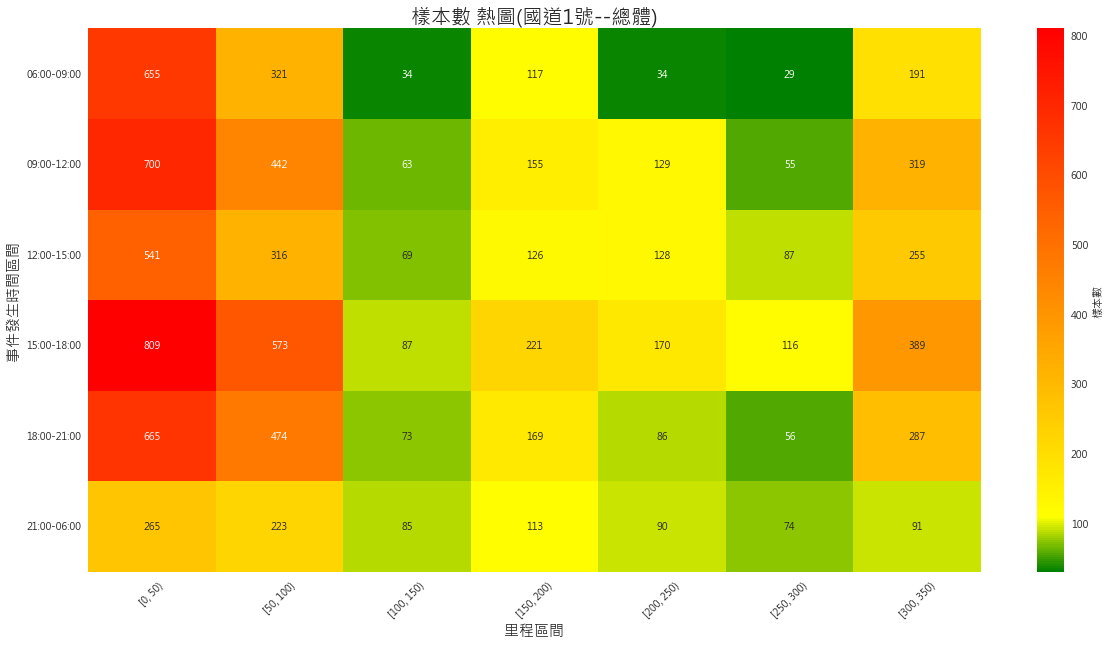

In [10]:
# set time & mile interval
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(df_highway_1['里程'].min(), df_highway_1['里程'].max() + 1, mile_block, dtype=int)

# add new row to cut
df_highway_1['事件發生時間區間'] = pd.cut(df_highway_1['事件發生(秒數)'], bins=time_bins, right=False)
df_highway_1['里程區間'] = pd.cut(df_highway_1['里程'], bins=mile_bins, right=False)

# count sample
sample_counts = df_highway_1.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].apply(merge_time_intervals)

# del repeat row and sum sample
sample_counts = sample_counts.groupby(['事件發生時間區間', '里程區間'], as_index=False).sum()

# pivot table
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# reset index
pivot_table.index = pivot_table.index.map(format_time_label)

# adjust
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.1, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道1號--總體)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

#### new 切割看有哪些格子的編號

In [59]:
# def time interval
time_intervals = [
    (6 * 3600, 9 * 3600),    # 06:00-09:00
    (9 * 3600, 12 * 3600),   # 09:00-12:00
    (12 * 3600, 15 * 3600),  # 12:00-15:00
    (15 * 3600, 18 * 3600),  # 15:00-18:00
    (18 * 3600, 21 * 3600),   # 18:00-21:00
    (21 * 3600, 6 * 3600),  # 21:00-06:00
]
# def mile interval with every 50km
mile_interval_size = 50
mile_intervals = [(0, 50), (50, 100), (100, 150), (150, 200),
                  (200, 250), (250, 300), (300, 350)]

# init result saving
result_indices = {}

# mile interval
mile_intervals = 7
mile_interval_size = 50

# save
for time_idx, (time_start, time_end) in enumerate(time_intervals):
    for mile_idx in range(mile_intervals):
        mile_start = mile_idx * mile_interval_size
        mile_end = (mile_idx + 1) * mile_interval_size
        # for 21:00~06:00 doing special case
        if time_start > time_end:
            filtered_data = df_highway_1[
                ((df_highway_1['事件發生(秒數)'] >= time_start) | (df_highway_1['事件發生(秒數)'] < time_end)) &
                (df_highway_1['里程'] >= mile_start) & (
                    df_highway_1['里程'] < mile_end)
            ]
        else:
            filtered_data = df_highway_1[
                (df_highway_1['事件發生(秒數)'] >= time_start) & (df_highway_1['事件發生(秒數)'] < time_end) &
                (df_highway_1['里程'] >= mile_start) & (
                    df_highway_1['里程'] < mile_end)
            ]

        # save
        result_indices[(time_idx, mile_idx)] = filtered_data.index.tolist()

# result
for (time_idx, mile_idx), indices in result_indices.items():
    print(f"格子 [時間區間: {time_idx}, 里程區間: {mile_idx}] 共有 {len(indices)} 筆資料。")

格子 [時間區間: 0, 里程區間: 0] 共有 655 筆資料。
格子 [時間區間: 0, 里程區間: 1] 共有 321 筆資料。
格子 [時間區間: 0, 里程區間: 2] 共有 34 筆資料。
格子 [時間區間: 0, 里程區間: 3] 共有 117 筆資料。
格子 [時間區間: 0, 里程區間: 4] 共有 34 筆資料。
格子 [時間區間: 0, 里程區間: 5] 共有 29 筆資料。
格子 [時間區間: 0, 里程區間: 6] 共有 191 筆資料。
格子 [時間區間: 1, 里程區間: 0] 共有 700 筆資料。
格子 [時間區間: 1, 里程區間: 1] 共有 442 筆資料。
格子 [時間區間: 1, 里程區間: 2] 共有 63 筆資料。
格子 [時間區間: 1, 里程區間: 3] 共有 155 筆資料。
格子 [時間區間: 1, 里程區間: 4] 共有 129 筆資料。
格子 [時間區間: 1, 里程區間: 5] 共有 55 筆資料。
格子 [時間區間: 1, 里程區間: 6] 共有 319 筆資料。
格子 [時間區間: 2, 里程區間: 0] 共有 541 筆資料。
格子 [時間區間: 2, 里程區間: 1] 共有 316 筆資料。
格子 [時間區間: 2, 里程區間: 2] 共有 69 筆資料。
格子 [時間區間: 2, 里程區間: 3] 共有 126 筆資料。
格子 [時間區間: 2, 里程區間: 4] 共有 128 筆資料。
格子 [時間區間: 2, 里程區間: 5] 共有 87 筆資料。
格子 [時間區間: 2, 里程區間: 6] 共有 255 筆資料。
格子 [時間區間: 3, 里程區間: 0] 共有 809 筆資料。
格子 [時間區間: 3, 里程區間: 1] 共有 573 筆資料。
格子 [時間區間: 3, 里程區間: 2] 共有 87 筆資料。
格子 [時間區間: 3, 里程區間: 3] 共有 221 筆資料。
格子 [時間區間: 3, 里程區間: 4] 共有 170 筆資料。
格子 [時間區間: 3, 里程區間: 5] 共有 116 筆資料。
格子 [時間區間: 3, 里程區間: 6] 共有 389 筆資料。
格子 [時間區間: 4, 里程區間: 0] 共有 665 筆資料。
格子 [時間區間: 4, 里程區間: 1] 

In [60]:
# filter
indices_to_use = result_indices[(0, 0)]
filtered_df = sorted_df.loc[indices_to_use]
filtered_df

年   月   日  時   分  國道名稱 方向    里程      事件發生      事件排除  ...  車輛10 車輛11  \
131    2023   1   3  8   9  國道1號  南  18.0  08:09:00  08:52:00  ...   NaN  NaN   
137    2023   1   3  8  54  國道1號  北  26.6  08:54:00  09:01:00  ...   NaN  NaN   
229    2023   1   5  8  41  國道1號  北  36.3  08:41:00  08:43:00  ...   NaN  NaN   
231    2023   1   5  8  53  國道1號  北  24.1  08:53:00  09:02:00  ...   NaN  NaN   
348    2023   1   7  7  35  國道1號  南  23.8  07:35:00  08:34:00  ...   NaN  NaN   
...     ...  ..  .. ..  ..   ... ..   ...       ...       ...  ...   ...  ...   
17513  2023  10  27  8  23  國道1號  北  33.0  08:23:00  08:27:00  ...   NaN  NaN   
17588  2023  10  28  7  24  國道1號  北  16.1  07:24:00  07:40:00  ...   NaN  NaN   
17590  2023  10  28  8  37  國道1號  南  25.0  08:37:00  08:45:00  ...   NaN  NaN   
17688  2023  10  30  7  55  國道1號  北  23.0  07:55:00  08:15:00  ...   NaN  NaN   
17689  2023  10  30  8  18  國道1號  北  18.1  08:18:00  08:23:00  ...   NaN  NaN   

       車輛12  分局  回堵長度  是否為假日  是否為相近時間  是否為相近地點  相近時間&地點是否有事件  事故車是否包含非小客車  
131     NaN   1     2      0        0        0             0            0  
137     NaN   1     7      0        0        0             0            0  
229     NaN   1     0      0        0        0             0            0  
231     NaN   1     0      0        0        0             0            1  
348     NaN   1     6      1        0        0             0            0  
...     ...  ..   ...    ...      ...      ...           ...          ...  
17513   NaN   1     0      0        0        0             0            0  
17588   NaN   1     1      1        0        0             0            0  
17590   NaN   1     0      1        0        0             0            0  
17688   NaN   1     1      0        0        0             0            0  
17689   NaN   1     1      0        0        1             0            0  

[655 rows x 49 columns]

#### 預處理
**原始 y 值 :** <br>
X_train, X_test, y_train, y_test <br>

---

**y 值取 log :** <br>
X_train_log, X_test_log, y_train_log, y_test_log <br>

In [61]:
# preprocess
# keep specific & target var
## '國道名稱'、"回堵長度"、"處理分鐘"
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
                     '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
selected_df = filtered_df[selected_features].copy()

# specify the var to process
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# fill NA to 0
selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

# if >1 --> ==1
selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

# label encoding for cate var
label_encoders = {}
categorical_features = [
    '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    selected_df[feature] = label_encoders[feature].fit_transform(
        selected_df[feature].astype(str))

# fill NA to 0
# selected_df['死亡'].fillna(0, inplace=True)
# selected_df['受傷'].fillna(0, inplace=True)
selected_df['肇事車輛'].fillna(0, inplace=True)

# split specific & target var
X = selected_df.drop(columns=['回堵長度'])
y = selected_df['回堵長度']
y_log = np.log1p(y)

# split train & test
# y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# y_log
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42)

In [63]:
# check selected df
selected_df

里程  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  匝道  肇事車輛  是否為假日  \
8392   41.0   0     2    0    0     0    0     0    0    0   1   2.0      0   
12284  40.6   0     2    0    0     0    0     0    1    0   0   2.0      0   
8778   35.2   0     2    0    0     0    0     0    1    0   0   5.0      0   
1959   11.6   1     2    0    0     0    0     0    1    0   0   3.0      0   
15151  44.8   0     2    0    1     0    0     0    0    0   0   2.0      0   
...     ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ..   ...    ...   
2691   35.5   0     2    0    0     0    0     0    1    0   0   2.0      0   
3338   15.0   0     2    0    0     0    0     0    0    0   1   2.0      0   
7160    5.0   1     2    0    0     0    0     0    0    0   1   2.0      0   
11482   9.0   1     2    0    1     0    0     0    0    0   0   3.0      0   
3327   22.9   1     2    0    1     0    0     0    0    0   0   2.0      0   

       相近時間&地點是否有事件  事故車是否包含非小客車  
8392              0            0  
12284             1            0  
8778              1            1  
1959              0            0  
15151             0            0  
...             ...          ...  
2691              0            0  
3338              0            0  
7160              0            0  
11482             0            1  
3327              0            0  

[524 rows x 15 columns]

#### 觀察 y 變數(處理分鐘) 的分布 box, bar

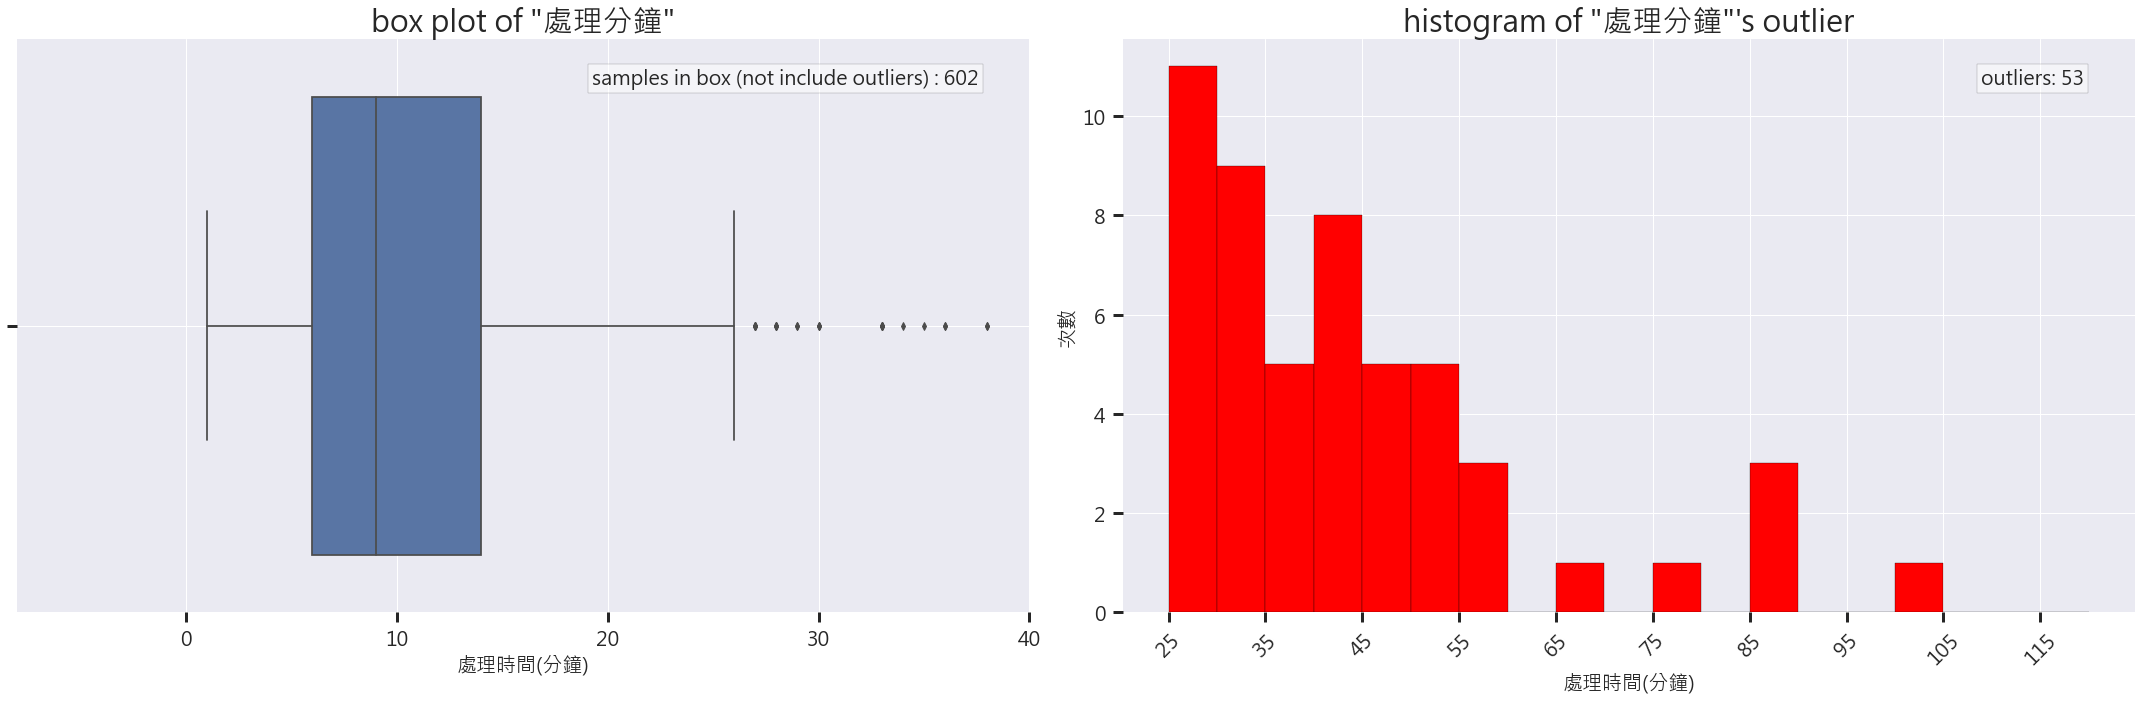

In [1148]:
# "處理分鐘" box & bar plot
# find outlier
q1 = selected_df['處理分鐘'].quantile(0.25)
q3 = selected_df['處理分鐘'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = selected_df[(selected_df['處理分鐘'] < lower_bound) |
                       (selected_df['處理分鐘'] > upper_bound)]['處理分鐘']

# count how many
total_samples = len(selected_df)
total_outliers = len(outliers)

# set fig
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 1st subplot : box plot
sns.boxplot(x=selected_df['處理分鐘'], ax=axes[0])
axes[0].grid(True)
axes[0].set_xlim(-8, 40)
axes[0].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[0].set_title('box plot of "處理分鐘"', fontsize=30)
axes[0].set_xlabel('處理時間(分鐘)', fontsize=20)
axes[0].text(0.95, 0.95, f'samples in box (not include outliers) : {total_samples-total_outliers}', transform=axes[0].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# 2nd subplot : hist plot of outlier
axes[1].hist(outliers, bins=range(25, int(max(outliers)) + 2, 5), color='r', edgecolor='black')
axes[1].set_title('histogram of "處理分鐘"\'s outlier', fontsize=30)
axes[1].set_xlabel('處理時間(分鐘)', fontsize=20)
axes[1].set_ylabel('次數', fontsize=20)
axes[1].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[1].set_xticks(range(25, int(max(outliers)) + 1, 10))
axes[1].tick_params(axis='x', labelsize=20, rotation=45)
axes[1].text(0.95, 0.95, f'outliers: {total_outliers}', transform=axes[1].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# show
plt.tight_layout()
plt.show()

#### 觀察 y 變數(回堵長度) 的分布 box, bar

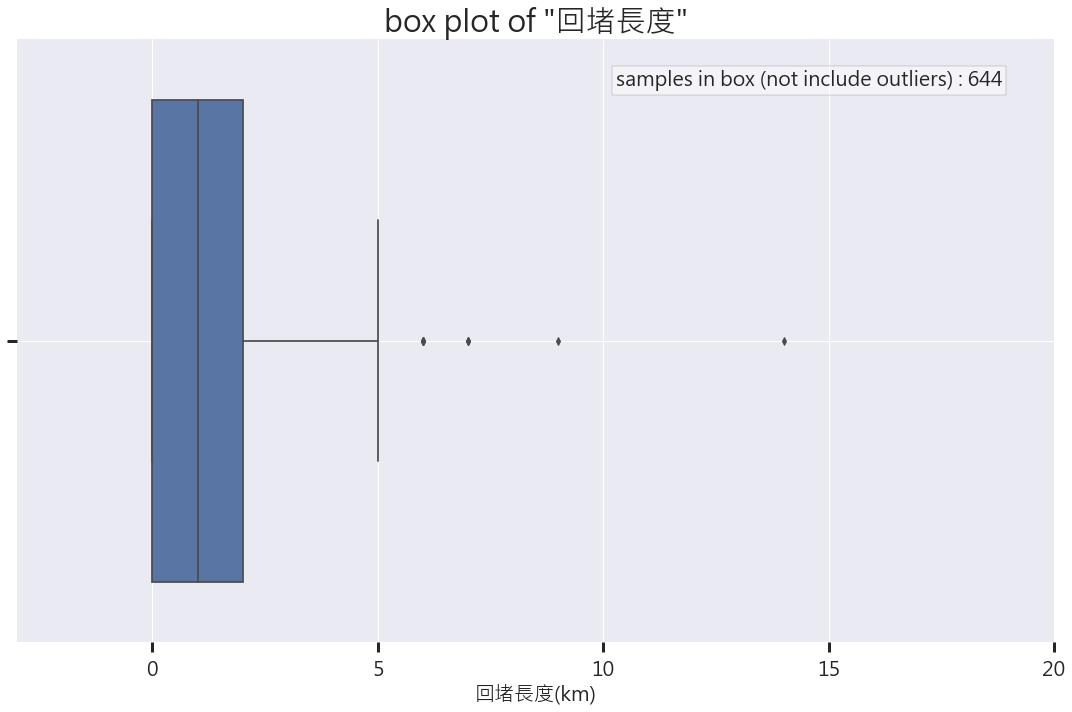

In [15]:
# "回堵長度" box & bar plot
# find outlier
q1 = selected_df['回堵長度'].quantile(0.25)
q3 = selected_df['回堵長度'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = selected_df[(selected_df['回堵長度'] < lower_bound) |
                       (selected_df['回堵長度'] > upper_bound)]['回堵長度']

# count how many
total_samples = len(selected_df)
total_outliers = len(outliers)

# set fig
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

# 1st subplot : box plot
sns.boxplot(x=selected_df['回堵長度'])
axes.grid(True)
axes.set_xlim(-3, 20)
axes.tick_params(axis='both', labelsize=20, width=3, length=10)
axes.set_title('box plot of "回堵長度"', fontsize=30)
axes.set_xlabel('回堵長度(km)', fontsize=20)
axes.text(0.95, 0.95, f'samples in box (not include outliers) : {total_samples-total_outliers}', transform=axes.transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# show
plt.tight_layout()
plt.show()

#### 建立 xgb model

In [1149]:
# def train xgb model
def train_xgboost_model(X_train, y_train, X_test, y_test, param_grid, log_transform=False):
    # set xgb model
    xgboost_model = xgb.XGBRegressor()

    # grid search
    grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                               cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

    # fit
    grid_search.fit(X_train, y_train)

    # get best model
    best_params = grid_search.best_params_
    best_xgboost_model = grid_search.best_estimator_

    # predict
    y_pred = best_xgboost_model.predict(X_test)
    if log_transform:
        y_pred = np.expm1(y_pred)

    # evaluate
    mse = round(mean_squared_error(y_test, y_pred),4)
    mae = round(mean_absolute_error(y_test, y_pred),4)
#     r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
#     print(f"R-squared: {r2}")
    print(f"Best Parameters: {best_params}")

    return best_xgboost_model, mse, mae

In [809]:
# set grid param
param_grid_ori_xgb = {
    'gamma': [0, 0.01, 0.03, 0.05, 0.1, 0.15],
    'learning_rate': [0, 0.01, 0.03, 0.05, 0.1, 0.13, 0.15],
    'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [20, 25, 30, 35, 40, 45, 50, 55],
}

# ori xgb model
ori_xgb_model, ori_xgb_mse, ori_xgb_mae = train_xgboost_model(
    X_train, y_train, X_test, y_test, param_grid_ori_xgb)

Mean Squared Error: 90.7944
Mean Absolute Error: 7.555
Best Parameters: {'gamma': 0, 'learning_rate': 0.13, 'max_depth': 3, 'n_estimators': 30}


In [810]:
# set grid param
param_grid_log_xgb = {
    'gamma': [0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25],
    'learning_rate': [0, 0.01, 0.03, 0.05, 0.1, 0.13, 0.15],
    'max_depth': [1, 2, 3],
    'n_estimators': [30, 35, 40, 45, 50, 55, 60],
}

# log xgb model
log_xgb_model, log_xgb_mse, log_xgb_mae = train_xgboost_model(
    X_train_log, y_train_log, X_test_log, y_test_log, param_grid_log_xgb, log_transform=True)

Mean Squared Error: 102.8613
Mean Absolute Error: 9.3788
Best Parameters: {'gamma': 0, 'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 55}


In [811]:
# pred
y_pred_ori = ori_xgb_model.predict(X)
y_pred_log = log_xgb_model.predict(X)

# caculate res
ori_residuals = y_pred_ori - y
log_residuals = np.expm1(y_pred_log) - y

# save to df
ori_residuals_df = pd.DataFrame({'Residuals': ori_residuals})
log_residuals_df = pd.DataFrame({'Residuals': log_residuals})

# get total samples
ori_total_samples = ori_residuals_df.shape[0]
log_total_samples = log_residuals_df.shape[0]

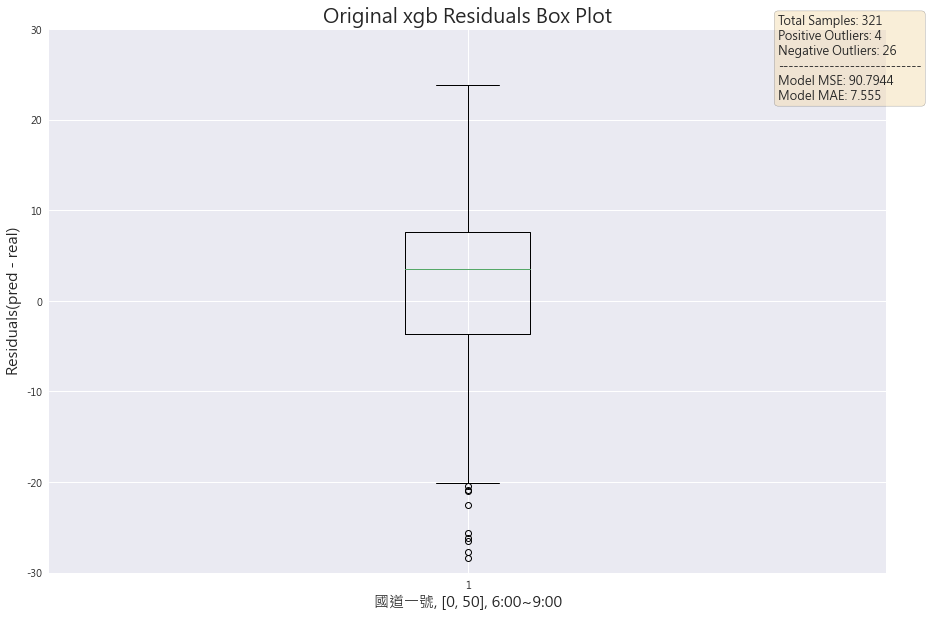

In [818]:
# get outlier
std_residuals = ori_residuals_df['Residuals'].std()
positive_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(ori_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-4, 4)
plt.title('Original xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {ori_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {ori_xgb_mse}\n"
    f"Model MAE: {ori_xgb_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

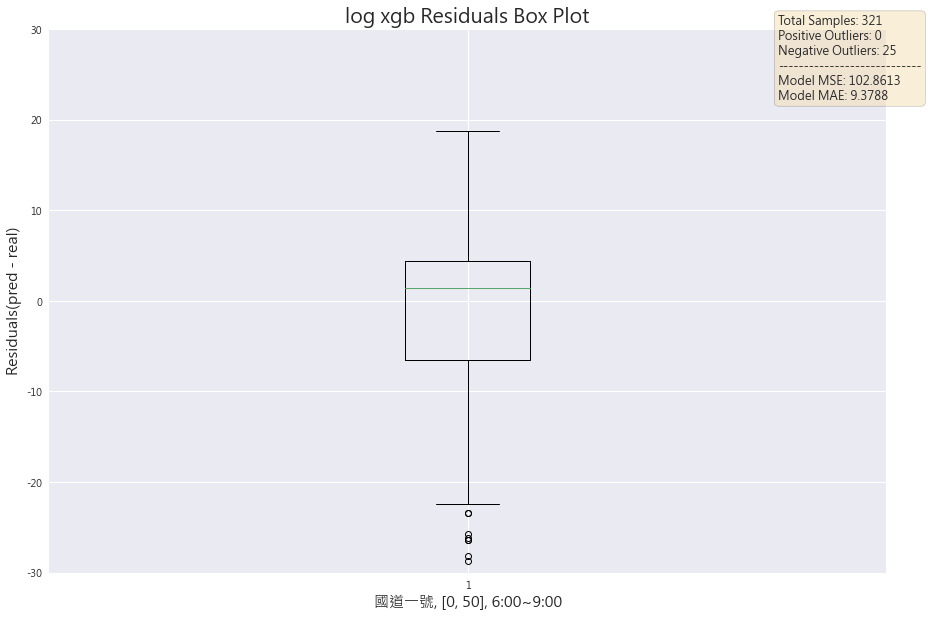

In [817]:
# get outlier
std_residuals = log_residuals_df['Residuals'].std()
positive_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(log_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-4, 4)
plt.title('log xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {log_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {log_xgb_mse}\n"
    f"Model MAE: {log_xgb_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

In [819]:
# show feature importance
feature_importances = log_xgb_model.feature_importances_
column_names = X.columns.tolist()
# use df to show
feature_importances_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

Feature  Importance
2           事故類型    0.508622
14   事故車是否包含非小客車    0.172055
11          肇事車輛    0.150290
0             里程    0.086374
6            中車道    0.050467
5           中內車道    0.032193
1             方向    0.000000
3            內路肩    0.000000
4            內車道    0.000000
7           中外車道    0.000000
8            外車道    0.000000
9            外路肩    0.000000
10            匝道    0.000000
12         是否為假日    0.000000
13  相近時間&地點是否有事件    0.000000

In [820]:
file_name = "log_xgb_imp.xlsx"
feature_importances_df.to_excel(file_name, index=False)

#### 改成使用 reg 來預測
使用 y_log 預估

In [827]:
# use median --> quantile==0.5
# set param
param_grid = {
    # set quantile
    'quantile': [0.5],
    # solver : 'highs', 'highs-ds', 'highs-ipm', 'highs-simplex'
    'solver': ['highs'],
    # alpha
    'alpha': [0, 0.002, 0.0025, 0.005, 0.01, 0.02, 0.03],
}

# set Quantile Regression model
qreg_model = QuantileRegressor()

# grid search
grid_search = GridSearchCV(estimator=qreg_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# fit
grid_search.fit(X_train_log, y_train_log)

# get best model
best_params = grid_search.best_params_
mid_qreg_model = grid_search.best_estimator_

# pred
y_pred = mid_qreg_model.predict(X_test_log)
y_pred = np.expm1(y_pred)

# evaluate
mid_qreg_mse = round(mean_squared_error(y_test, y_pred), 4)
mid_qreg_mae = round(mean_absolute_error(y_test, y_pred), 4)
#r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mid_qreg_mse}")
print(f"Mean Absolute Error: {mid_qreg_mae}")
#print(f"R-squared: {r2}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 66.0777
Mean Absolute Error: 5.9775
Best Parameters: {'alpha': 0.02, 'quantile': 0.5, 'solver': 'highs'}


In [828]:
# use median --> quantile==all
# set param
param_grid = {
    # set quantile
    'quantile': [0.2,0.4 ,0.45, 0.5, 0.55, 0.6,0.8],
    # solver : 'highs', 'highs-ds', 'highs-ipm', 'highs-simplex'
    'solver': ['highs'],
    # alpha
    'alpha': [0, 0.002, 0.0025, 0.005, 0.01, 0.02, 0.03],
}

# set Quantile Regression model
qreg_model = QuantileRegressor()

# grid search
grid_search = GridSearchCV(estimator=qreg_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# fit
grid_search.fit(X_train_log, y_train_log)

# get best model
best_params = grid_search.best_params_
best_qreg_model = grid_search.best_estimator_

# pred
y_pred = best_qreg_model.predict(X_test_log)
y_pred = np.expm1(y_pred)

# evaluate
best_qreg_mse = round(mean_squared_error(y_test, y_pred), 4)
best_qreg_mae = round(mean_absolute_error(y_test, y_pred), 4)
#r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {best_qreg_mse}")
print(f"Mean Absolute Error: {best_qreg_mae}")
#print(f"R-squared: {r2}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 66.0777
Mean Absolute Error: 5.9775
Best Parameters: {'alpha': 0.02, 'quantile': 0.5, 'solver': 'highs'}


In [829]:
# pred
y_pred_mid = mid_qreg_model.predict(X)
y_pred_best = best_qreg_model.predict(X)

# caculate res
mid_log_residuals = np.expm1(y_pred_mid) - y
best_log_residuals = np.expm1(y_pred_best) - y

# save to df
mid_qreg_residuals_df = pd.DataFrame({'Residuals': mid_log_residuals})
best_qreg_residuals_df = pd.DataFrame({'Residuals': best_log_residuals})

# get total samples
mid_qreg_total_samples = mid_qreg_residuals_df.shape[0]
best_qreg_total_samples = best_qreg_residuals_df.shape[0]

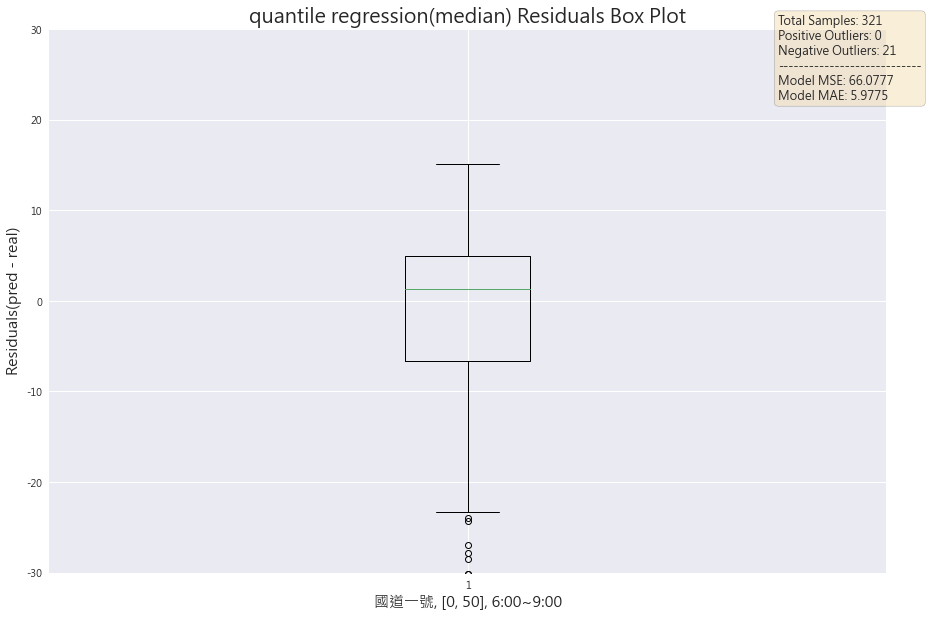

In [831]:
# get outlier
std_residuals = mid_qreg_residuals_df['Residuals'].std()
positive_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(mid_qreg_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('quantile regression(median) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mid_qreg_mse}\n"
    f"Model MAE: {mid_qreg_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

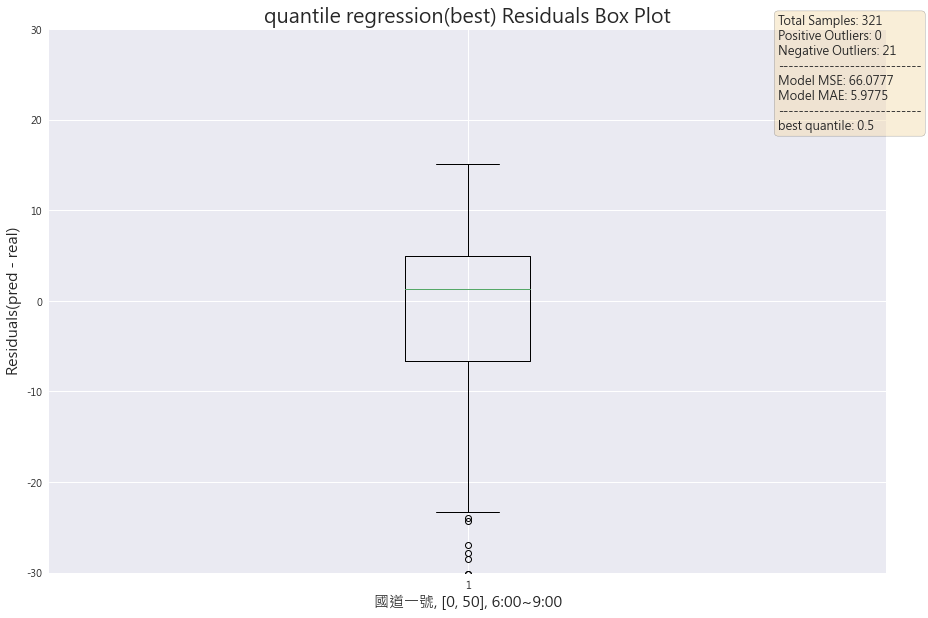

In [832]:
# get outlier
std_residuals = best_qreg_residuals_df['Residuals'].std()
positive_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(best_qreg_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('quantile regression(best) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {best_qreg_mse}\n"
    f"Model MAE: {best_qreg_mae}\n"
    "----------------------------\n"
    f"best quantile: {best_params['quantile']}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

#### xgboost 結合 quantile regression

In [833]:
# def func of quantile loss
def quantile_loss(alpha, y_true, y_pred):
    # count res
    residual = y_true - y_pred
    # return quantile loss
    return np.mean(np.maximum(alpha * residual, (alpha - 1) * residual))

# '''
# param : 
#     alpha --> quantile (0<alpha<1), for 0.5 == median regression
#     y_true --> real val
#     y_pred --> pred val
# return : 
#     mean val of quantile loss
# purpose : 
#     quantile loss is a weighting loss function for the difference of true value & predict value
#     alpha is setting the quantile that we want to know
# '''

In [834]:
# def func of gradient & Hessian matrices of the quantile loss
# in order to custom objective function in xgboost
def quantile_loss_obj(y_pred, dtrain):
    # get real val
    y_true = dtrain.get_label()
    # set quantile
    alpha = 0.5
    # count res
    residual = y_true - y_pred
    # count gd : 
    ## res > 0 ==> -alpha
    ## o.w. ==> 1 - alpha
    grad = np.where(residual > 0, -alpha, 1 - alpha)
    # Hessian matrices == 1 (constant)
    hess = np.ones_like(y_true)
    return grad, hess

# '''
# param : 
#     y_true --> real val
#     dtrain --> training data in DMatrix type
# return : 
#     gradient & Hessian matrices
# purpose : 
#     count gradient & Hessian matrices of quantile loss, use in xgboost training
#     gradient : first derivative of loss funcion --> to update model param
#     Hessian matrices : second derivative of loss funcion --> to describe the curvature of the loss surface
# '''

In [835]:
# def evaluate func of quantile loss
# in order to custom evaluation index
def custom_metric(y_pred, dmatrix):
    # get real val
    y_true = dmatrix.get_label()
    # set quantile
    alpha = 0.5
    # count quantile loss, return loss name & loss val
    return 'quantile_loss', quantile_loss(alpha, y_true, y_pred)

# '''
# param : 
#      y_true --> real val
#      dtrain --> training data in DMatrix type
# return : 
#     loss name & loss val
# purpose : 
#     to evaluate model, count the quantile loss
#     use in evaluate model when training, trace the model performance
# '''

In [836]:
# # try
# # change type to DMatrix
# dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
# dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)

# # set param
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'mae',
#     'eta': 0.1,
#     'max_depth': 6,
#     'silent': 1
# }

# bst = xgb.train(params, dtrain_log, num_boost_round=1000, obj=quantile_loss_obj,
#                 feval=custom_metric, early_stopping_rounds=50, evals=[(dtest_log, 'eval')])

# y_pred_log = bst.predict(dtest_log)
# y_pred = np.expm1(y_pred_log) 

In [837]:
# set param
param_grid = {
    'alpha': [0],
    'colsample_bytree': [1.0],
    'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 0.05, 0.1, 0.5, 0.7],
    'lambda': [0.1, 0.3, 0.5, 1],
    'max_depth': [1, 2, 3],
    'min_child_weight': [1],
    'subsample': [1.0],
}

# fixed param
params_fixed = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'n_jobs': -1,
}

# change data tyoe into DMatrix
dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)

# evaluate
evals = [(dtest_log, 'eval')]

# save best result
best_mae = float("inf")
best_params = None

# grid search
for params in ParameterGrid(param_grid):
    # combine fixed & param
    current_params = {**params_fixed, **params}
    
    # train
    bst = xgb.train(
        params=current_params, 
        dtrain=dtrain_log, 
        num_boost_round=1000, 
        obj=quantile_loss_obj,
        custom_metric=custom_metric,
        early_stopping_rounds=50, 
        evals=evals, 
        verbose_eval=False
    )
    
    # predict
    y_pred_log = bst.predict(dtest_log)
    
    # mae
    mae = mean_absolute_error(y_test_log, y_pred_log)
    # save best model, use mae to define
    if mae < best_mae:
        best_mae = mae
        best_params = params

# show best para,
print(f"Best parameters found: {best_params}")

# use best param to train
xgb_qreg_best_model = xgb.train(
    params={**params_fixed, **best_params},
    dtrain=dtrain_log,
    num_boost_round=1000,
    obj=quantile_loss_obj,
    custom_metric=custom_metric,
    early_stopping_rounds=50,
    evals=evals,
    verbose_eval=True
)


Best parameters found: {'alpha': 0, 'colsample_bytree': 1.0, 'eta': 0.01, 'gamma': 0.5, 'lambda': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 1.0}
[0]	eval-mae:1.79007	eval-quantile_loss:0.89503
[1]	eval-mae:1.78507	eval-quantile_loss:0.89253
[2]	eval-mae:1.78007	eval-quantile_loss:0.89004
[3]	eval-mae:1.77507	eval-quantile_loss:0.88754
[4]	eval-mae:1.77007	eval-quantile_loss:0.88504
[5]	eval-mae:1.76508	eval-quantile_loss:0.88254
[6]	eval-mae:1.76008	eval-quantile_loss:0.88004
[7]	eval-mae:1.75508	eval-quantile_loss:0.87754
[8]	eval-mae:1.75008	eval-quantile_loss:0.87504
[9]	eval-mae:1.74508	eval-quantile_loss:0.87254
[10]	eval-mae:1.74009	eval-quantile_loss:0.87004
[11]	eval-mae:1.73509	eval-quantile_loss:0.86754
[12]	eval-mae:1.73009	eval-quantile_loss:0.86504
[13]	eval-mae:1.72509	eval-quantile_loss:0.86255
[14]	eval-mae:1.72009	eval-quantile_loss:0.86005
[15]	eval-mae:1.71510	eval-quantile_loss:0.85755
[16]	eval-mae:1.71010	eval-quantile_loss:0.85505
[17]	eval-mae:1.7

[163]	eval-mae:1.00739	eval-quantile_loss:0.50369
[164]	eval-mae:1.00299	eval-quantile_loss:0.50149
[165]	eval-mae:0.99859	eval-quantile_loss:0.49929
[166]	eval-mae:0.99419	eval-quantile_loss:0.49710
[167]	eval-mae:0.98980	eval-quantile_loss:0.49490
[168]	eval-mae:0.98540	eval-quantile_loss:0.49270
[169]	eval-mae:0.98100	eval-quantile_loss:0.49050
[170]	eval-mae:0.97660	eval-quantile_loss:0.48830
[171]	eval-mae:0.97221	eval-quantile_loss:0.48610
[172]	eval-mae:0.96781	eval-quantile_loss:0.48390
[173]	eval-mae:0.96341	eval-quantile_loss:0.48171
[174]	eval-mae:0.95901	eval-quantile_loss:0.47951
[175]	eval-mae:0.95462	eval-quantile_loss:0.47731
[176]	eval-mae:0.95022	eval-quantile_loss:0.47511
[177]	eval-mae:0.94582	eval-quantile_loss:0.47291
[178]	eval-mae:0.94143	eval-quantile_loss:0.47071
[179]	eval-mae:0.93703	eval-quantile_loss:0.46851
[180]	eval-mae:0.93263	eval-quantile_loss:0.46632
[181]	eval-mae:0.92823	eval-quantile_loss:0.46412
[182]	eval-mae:0.92410	eval-quantile_loss:0.46205


[327]	eval-mae:0.50425	eval-quantile_loss:0.25212
[328]	eval-mae:0.50268	eval-quantile_loss:0.25134
[329]	eval-mae:0.50112	eval-quantile_loss:0.25056
[330]	eval-mae:0.49956	eval-quantile_loss:0.24978
[331]	eval-mae:0.49833	eval-quantile_loss:0.24916
[332]	eval-mae:0.49746	eval-quantile_loss:0.24873
[333]	eval-mae:0.49670	eval-quantile_loss:0.24835
[334]	eval-mae:0.49594	eval-quantile_loss:0.24797
[335]	eval-mae:0.49518	eval-quantile_loss:0.24759
[336]	eval-mae:0.49443	eval-quantile_loss:0.24721
[337]	eval-mae:0.49367	eval-quantile_loss:0.24683
[338]	eval-mae:0.49291	eval-quantile_loss:0.24645
[339]	eval-mae:0.49215	eval-quantile_loss:0.24607
[340]	eval-mae:0.49139	eval-quantile_loss:0.24569
[341]	eval-mae:0.49063	eval-quantile_loss:0.24532
[342]	eval-mae:0.48987	eval-quantile_loss:0.24494
[343]	eval-mae:0.48911	eval-quantile_loss:0.24456
[344]	eval-mae:0.48835	eval-quantile_loss:0.24418
[345]	eval-mae:0.48770	eval-quantile_loss:0.24385
[346]	eval-mae:0.48705	eval-quantile_loss:0.24353


[491]	eval-mae:0.43533	eval-quantile_loss:0.21766
[492]	eval-mae:0.43534	eval-quantile_loss:0.21767
[493]	eval-mae:0.43536	eval-quantile_loss:0.21768
[494]	eval-mae:0.43537	eval-quantile_loss:0.21769
[495]	eval-mae:0.43539	eval-quantile_loss:0.21769
[496]	eval-mae:0.43540	eval-quantile_loss:0.21770
[497]	eval-mae:0.43542	eval-quantile_loss:0.21771
[498]	eval-mae:0.43543	eval-quantile_loss:0.21772
[499]	eval-mae:0.43545	eval-quantile_loss:0.21772
[500]	eval-mae:0.43547	eval-quantile_loss:0.21774
[501]	eval-mae:0.43552	eval-quantile_loss:0.21776
[502]	eval-mae:0.43556	eval-quantile_loss:0.21778
[503]	eval-mae:0.43560	eval-quantile_loss:0.21780
[504]	eval-mae:0.43565	eval-quantile_loss:0.21782
[505]	eval-mae:0.43569	eval-quantile_loss:0.21785
[506]	eval-mae:0.43573	eval-quantile_loss:0.21787
[507]	eval-mae:0.43577	eval-quantile_loss:0.21789
[508]	eval-mae:0.43582	eval-quantile_loss:0.21791
[509]	eval-mae:0.43587	eval-quantile_loss:0.21793
[510]	eval-mae:0.43593	eval-quantile_loss:0.21797


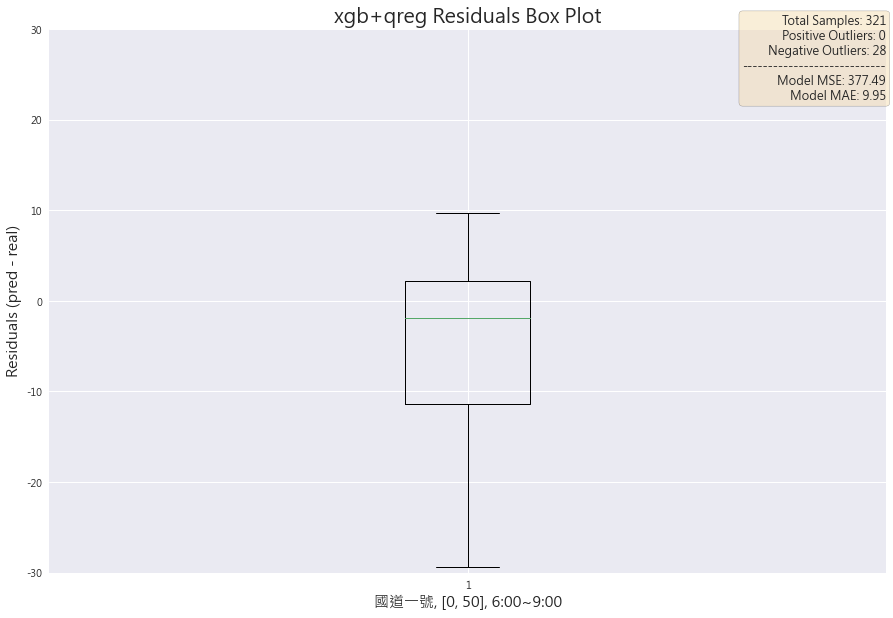

In [839]:
# change data type into DMatrix
dall = xgb.DMatrix(X)

# use best model
y_all_pred_log = xgb_qreg_best_model.predict(dall)
y_all_pred = np.expm1(y_all_pred_log)

# count res and build df
residuals = y_all_pred - y
residuals_df = pd.DataFrame({'Residuals': residuals})

# count samples & std
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()

# count outlier
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]

# count mse & mae
mse = mean_squared_error(y, y_all_pred)
mae = mean_absolute_error(y, y_all_pred)

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-15, 20)
# plt.ylim(-5, 5)
plt.title('xgb+qreg Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# show
plt.show()

#### 零膨脹POI模型+XGB(回堵長度)

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


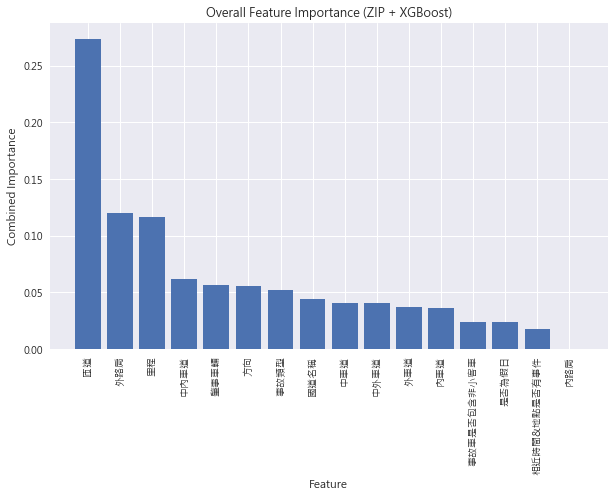

Mean Squared Error: 1.5603
Mean Absolute Error: 0.6756
Feature Importance DataFrame:
         Feature  ZIP Importance  XGB Importance  Combined Importance  \
0             匝道        0.250130        0.297684             0.273907   
1            外路肩        0.092084        0.147297             0.119691   
2             里程        0.126823        0.106892             0.116858   
3           中內車道        0.082786        0.041845             0.062316   
4           肇事車輛        0.063620        0.049055             0.056337   
5             方向        0.076954        0.034096             0.055525   
6           事故類型        0.061357        0.042290             0.051824   
7           國道名稱        0.010044        0.077621             0.043833   
8            中車道        0.049151        0.032035             0.040593   
9           中外車道        0.054750        0.025893             0.040321   
10           外車道        0.039356        0.034387             0.036872   
11           內車道        0.050173       

In [55]:
# 函數：將 Zero-Inflated Poisson 模型與 XGBoost 結合
def train_and_evaluate_zip_xgb(X_train, y_train, X_test, y_test, feature_names):
    # 對數據進行對數轉換
    scaler = StandardScaler()
    X_train_log = scaler.fit_transform(np.log1p(X_train))
    X_test_log = scaler.transform(np.log1p(X_test))
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 1. 訓練 Zero-Inflated Poisson 模型
    zip_model = sm.ZeroInflatedPoisson(y_train_log, X_train_log, inflation='logit')
    zip_result = zip_model.fit(maxiter=100, disp=False, method='bfgs')

    # 2. 訓練 XGBoost 模型
    xgb_model = xgb.XGBRegressor(objective='count:poisson')
    xgb_model.fit(X_train_log, y_train_log)

    # 3. 預測
    # 使用 Zero-Inflated Poisson 模型進行預測
    zero_inflation_preds = zip_result.predict(X_test_log)
    zero_inflation_preds = np.round(zero_inflation_preds)

    # 使用 XGBoost 模型進行預測
    xgb_preds_log = xgb_model.predict(X_test_log)
    xgb_preds = np.expm1(xgb_preds_log)

    # 4. 合併預測結果
    y_pred = np.where(zero_inflation_preds == 0, 0, xgb_preds)

    # 5. 評估模型
    mse = round(mean_squared_error(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)

    # 6. 提取變數重要性
    # Zero-Inflated Poisson 模型的變數重要性（使用係數的絕對值）
    zip_importance = np.abs(zip_result.params[1:])  # 忽略截距項
    zip_importance_normalized = zip_importance / np.sum(zip_importance)

    # XGBoost 模型的變數重要性
    xgb_importance = xgb_model.feature_importances_
    xgb_importance_normalized = xgb_importance / np.sum(xgb_importance)

    # 7. 加權合併變數重要性（可以根據需求調整權重）
    combined_importance = 0.5 * zip_importance_normalized + 0.5 * xgb_importance_normalized

    # 8. 存儲變數重要性到 DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'ZIP Importance': zip_importance_normalized,
        'XGB Importance': xgb_importance_normalized,
        'Combined Importance': combined_importance
    })
    importance_df['ZIP Importance (%)'] = importance_df['ZIP Importance'] * 100
    importance_df['XGB Importance (%)'] = importance_df['XGB Importance'] * 100
    importance_df['Combined Importance (%)'] = importance_df['Combined Importance'] * 100

    # 9. 按照綜合重要性排序
    importance_df = importance_df.sort_values(by='Combined Importance', ascending=False).reset_index(drop=True)

    # 10. 視覺化整體變數重要性
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Combined Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Combined Importance')
    plt.title('Overall Feature Importance (ZIP + XGBoost)')
    plt.xticks(rotation=90)
    plt.show()

    return mse, mae, zero_inflation_preds, xgb_preds, importance_df

# 訓練和評估模型，並將變數名稱傳入函數
feature_names = X_train.columns  # 如果 X_train 是 DataFrame 格式
mse, mae, zip_preds, xgb_preds, importance_df = train_and_evaluate_zip_xgb(X_train, y_train, X_test, y_test, feature_names)

# 輸出結果
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print("Feature Importance DataFrame:")
print(importance_df)


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


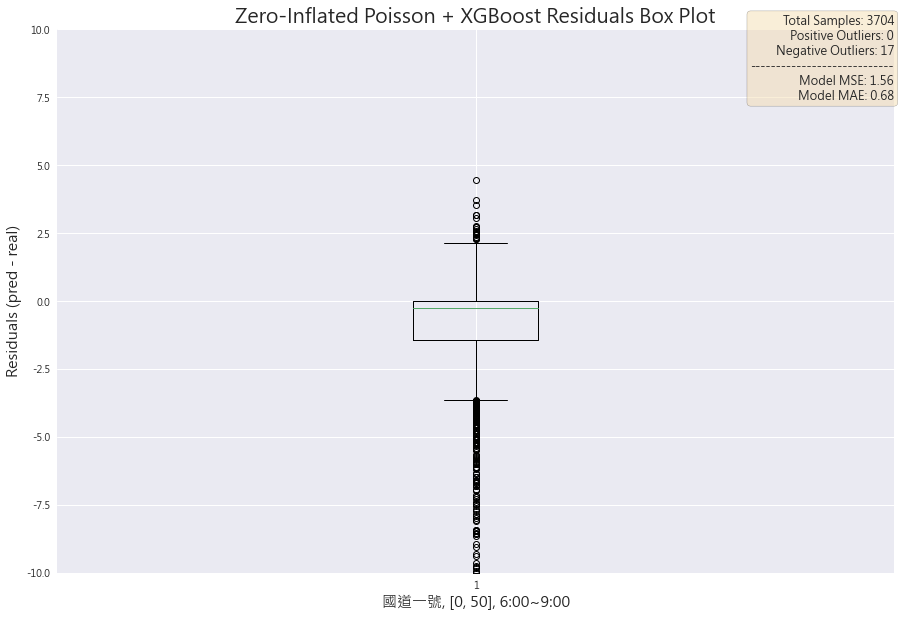

In [56]:
# 訓練 Zero-Inflated Poisson 模型
zip_model = sm.ZeroInflatedPoisson(y, X, inflation='logit')
zip_result = zip_model.fit(maxiter=100, disp=False)

# 使用 Zero-Inflated Poisson 模型進行預測
zip_preds = zip_result.predict(X)

# 訓練 XGBoost 模型
xgb_model = xgb.XGBRegressor(objective='count:poisson')
xgb_model.fit(X, y)

# 使用 XGBoost 模型進行預測
xgb_preds_log = xgb_model.predict(X)
xgb_preds = np.expm1(xgb_preds_log)

# 合併預測結果
y_pred = np.where(zip_preds == 0, 0, xgb_preds)

# 計算殘差
residuals = y - y_pred
residuals_df = pd.DataFrame({'Residuals': residuals})

# 計算統計量
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]


# 繪製箱型圖
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
plt.ylim(-10, 10)  # 根據需要調整範圍
plt.title('Zero-Inflated Poisson + XGBoost Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# 添加統計信息
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# 顯示圖形
plt.show()


In [22]:
importance_df

Feature  ZIP Importance  XGB Importance  Combined Importance  \
0             匝道        0.174985        0.523722             0.349354   
1            內車道        0.142208        0.026310             0.084259   
2            外車道        0.137353        0.030882             0.084118   
3           中內車道        0.100814        0.059320             0.080067   
4            中車道        0.114807        0.024793             0.069800   
5    事故車是否包含非小客車        0.053555        0.045682             0.049618   
6          是否為假日        0.056217        0.040427             0.048322   
7            外路肩        0.065768        0.029953             0.047861   
8             方向        0.047909        0.032414             0.040162   
9   相近時間&地點是否有事件        0.018204        0.048591             0.033398   
10          肇事車輛        0.015764        0.046376             0.031070   
11            里程        0.021657        0.040321             0.030989   
12          事故類型        0.029788        0.031091             0.030440   
13          中外車道        0.020673        0.020117             0.020395   
14           內路肩        0.000296        0.000000             0.000148   

    ZIP Importance (%)  XGB Importance (%)  Combined Importance (%)  
0            17.498519           52.372223                34.935371  
1            14.220752            2.631015                 8.425884  
2            13.735312            3.088204                 8.411758  
3            10.081436            5.932021                 8.006728  
4            11.480728            2.479346                 6.980037  
5             5.355470            4.568213                 4.961841  
6             5.621727            4.042688                 4.832208  
7             6.576831            2.995277                 4.786054  
8             4.790930            3.241393                 4.016161  
9             1.820429            4.859074                 3.339752  
10            1.576436            4.637632                 3.107034  
11            2.165661            4.032124                 3.098893  
12            2.978845            3.109138                 3.043992  
13            2.067314            2.011651                 2.039482  
14            0.029611            0.000000                 0.014806

In [23]:
file_name = "zero_xgb_imp.xlsx"
importance_df.to_excel(file_name, index=False)

#### save model

In [840]:
# set dir
save_dir = 'saved_model'
os.makedirs(save_dir, exist_ok=True)

# save xgb model
ori_xgb_model.save_model(os.path.join(save_dir, 'r1_0609_100km_ori_xgb_model_km.pkl'))
log_xgb_model.save_model(os.path.join(save_dir, 'r1_0609_100km_log_xgb_model_km.pkl'))

# save qreg model
joblib.dump(mid_qreg_model, os.path.join(save_dir, 'r1_0609_100km_mid_qreg_model_km.pkl'))
joblib.dump(best_qreg_model, os.path.join(save_dir, 'r1_0609_100km_best_qreg_model_km.pkl'))

# save xgb+qreg model
joblib.dump(xgb_qreg_best_model, os.path.join(save_dir, 'r1_0609_100km_xgbqreg_best_model_km.pkl'))

['saved_model\\r1_0609_100km_xgbqreg_best_model_km.pkl']

#### open model

In [841]:
# load xgb model
ori_xgb_model = xgb.XGBRegressor()
ori_xgb_model.load_model(os.path.join('saved_model', 'r1_0609_100km_ori_xgb_model_km.pkl'))

log_xgb_model = xgb.XGBRegressor()
log_xgb_model.load_model(os.path.join('saved_model', 'r1_0609_100km_log_xgb_model_km.pkl'))

# load qreg model
mid_qreg_model = joblib.load(os.path.join('saved_model', 'r1_0609_100km_mid_qreg_model_km.pkl'))
best_qreg_model = joblib.load(os.path.join('saved_model', 'r1_0609_100km_best_qreg_model_km.pkl'))

# load xgb+qreg model
xgb_qreg_best_model = joblib.load(os.path.join('saved_model', 'r1_0609_100km_xgbqreg_best_model_km.pkl'))


#### 儲存各模型的指標到 df 當中(training)

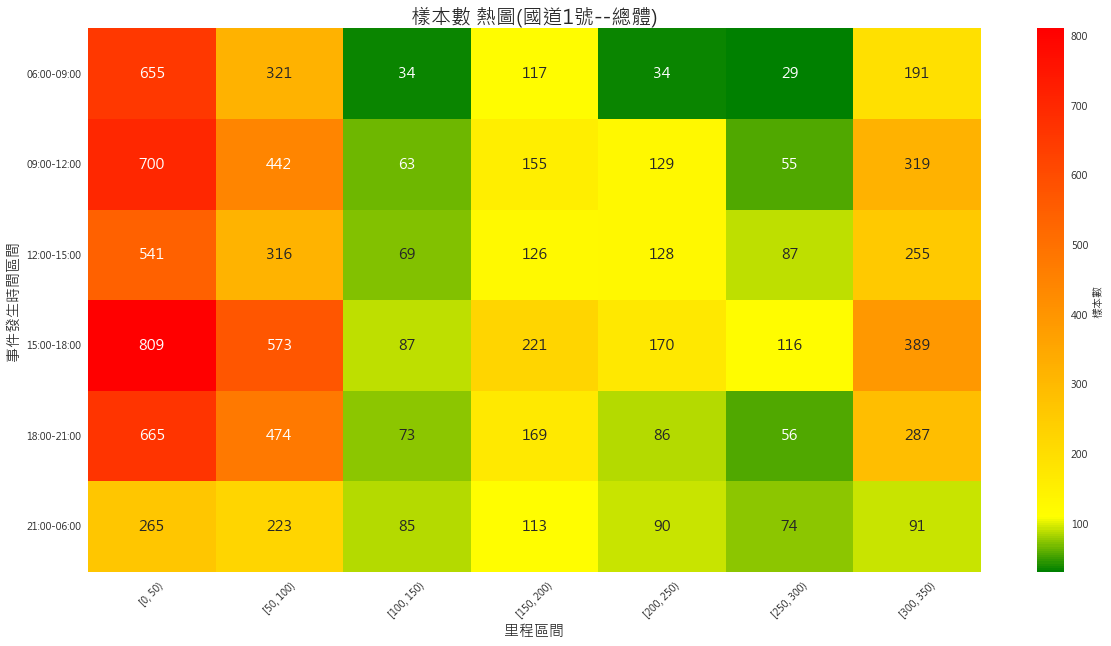

格子 [時間區間: 0, 里程區間: 0] 共有 655 筆資料。
格子 [時間區間: 0, 里程區間: 1] 共有 321 筆資料。
格子 [時間區間: 0, 里程區間: 2] 共有 34 筆資料。
格子 [時間區間: 0, 里程區間: 3] 共有 117 筆資料。
格子 [時間區間: 0, 里程區間: 4] 共有 34 筆資料。
格子 [時間區間: 0, 里程區間: 5] 共有 29 筆資料。
格子 [時間區間: 0, 里程區間: 6] 共有 191 筆資料。
格子 [時間區間: 1, 里程區間: 0] 共有 700 筆資料。
格子 [時間區間: 1, 里程區間: 1] 共有 442 筆資料。
格子 [時間區間: 1, 里程區間: 2] 共有 63 筆資料。
格子 [時間區間: 1, 里程區間: 3] 共有 155 筆資料。
格子 [時間區間: 1, 里程區間: 4] 共有 129 筆資料。
格子 [時間區間: 1, 里程區間: 5] 共有 55 筆資料。
格子 [時間區間: 1, 里程區間: 6] 共有 319 筆資料。
格子 [時間區間: 2, 里程區間: 0] 共有 541 筆資料。
格子 [時間區間: 2, 里程區間: 1] 共有 316 筆資料。
格子 [時間區間: 2, 里程區間: 2] 共有 69 筆資料。
格子 [時間區間: 2, 里程區間: 3] 共有 126 筆資料。
格子 [時間區間: 2, 里程區間: 4] 共有 128 筆資料。
格子 [時間區間: 2, 里程區間: 5] 共有 87 筆資料。
格子 [時間區間: 2, 里程區間: 6] 共有 255 筆資料。
格子 [時間區間: 3, 里程區間: 0] 共有 809 筆資料。
格子 [時間區間: 3, 里程區間: 1] 共有 573 筆資料。
格子 [時間區間: 3, 里程區間: 2] 共有 87 筆資料。
格子 [時間區間: 3, 里程區間: 3] 共有 221 筆資料。
格子 [時間區間: 3, 里程區間: 4] 共有 170 筆資料。
格子 [時間區間: 3, 里程區間: 5] 共有 116 筆資料。
格子 [時間區間: 3, 里程區間: 6] 共有 389 筆資料。
格子 [時間區間: 4, 里程區間: 0] 共有 665 筆資料。
格子 [時間區間: 4, 里程區間: 1] 

In [1150]:
# set time & mile interval
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(df_highway_1['里程'].min(), df_highway_1['里程'].max() + 1, mile_block, dtype=int)

# add new row to cut
df_highway_1['事件發生時間區間'] = pd.cut(df_highway_1['事件發生(秒數)'], bins=time_bins, right=False)
df_highway_1['里程區間'] = pd.cut(df_highway_1['里程'], bins=mile_bins, right=False)

# count sample
sample_counts = df_highway_1.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].apply(merge_time_intervals)

# del repeat row and sum sample
sample_counts = sample_counts.groupby(['事件發生時間區間', '里程區間'], as_index=False).sum()

# pivot table
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# reset index
pivot_table.index = pivot_table.index.map(format_time_label)

# adjust
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.1, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道1號--總體)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# def time interval
time_intervals = [
    (6 * 3600, 9 * 3600),    # 06:00-09:00
    (9 * 3600, 12 * 3600),   # 09:00-12:00
    (12 * 3600, 15 * 3600),  # 12:00-15:00
    (15 * 3600, 18 * 3600),  # 15:00-18:00
    (18 * 3600, 21 * 3600),   # 18:00-21:00
    (21 * 3600, 6 * 3600),  # 21:00-06:00
]
# def mile interval with every 50km
mile_interval_size = 50
mile_intervals = [(0, 50), (50, 100), (100, 150), (150, 200),
                  (200, 250), (250, 300), (300, 350)]

# init result saving
result_indices = {}

# mile interval
mile_intervals = 7
mile_interval_size = 50

# save
for time_idx, (time_start, time_end) in enumerate(time_intervals):
    for mile_idx in range(mile_intervals):
        mile_start = mile_idx * mile_interval_size
        mile_end = (mile_idx + 1) * mile_interval_size
        # for 21:00~06:00 doing special case
        if time_start > time_end:
            filtered_data = df_highway_1[
                ((df_highway_1['事件發生(秒數)'] >= time_start) | (df_highway_1['事件發生(秒數)'] < time_end)) &
                (df_highway_1['里程'] >= mile_start) & (
                    df_highway_1['里程'] < mile_end)
            ]
        else:
            filtered_data = df_highway_1[
                (df_highway_1['事件發生(秒數)'] >= time_start) & (df_highway_1['事件發生(秒數)'] < time_end) &
                (df_highway_1['里程'] >= mile_start) & (
                    df_highway_1['里程'] < mile_end)
            ]

        # save
        result_indices[(time_idx, mile_idx)] = filtered_data.index.tolist()

# result
for (time_idx, mile_idx), indices in result_indices.items():
    print(f"格子 [時間區間: {time_idx}, 里程區間: {mile_idx}] 共有 {len(indices)} 筆資料。")

In [1151]:
# 設定儲存資料夾
save_dir = 'saved_model'
os.makedirs(save_dir, exist_ok=True)

# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
         '肇事車輛', '處理分鐘', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
categorical_features = [
    '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
# 設定參數網格
param_grid = {
    'alpha': [0],
    'colsample_bytree': [1.0],
    'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 0.05, 0.1, 0.5, 0.7],
    'lambda': [0.1, 0.3, 0.5, 1],
    'max_depth': [1, 2, 3],
    'min_child_weight': [1],
    'subsample': [1.0],
}

# 固定參數
params_fixed = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'n_jobs': -1,
}

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(7):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = sorted_df.loc[indices_to_use]
            print(f"start {grid_key} with {filtered_df.shape[0]} samples")
            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            # 指定要處理的變數
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)
            selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

            # 類別變數的Label Encoding
            label_encoders = {}
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割特徵和目標變數
            X = selected_df.drop(columns=['處理分鐘'])
            y = selected_df['處理分鐘']
            y_log = np.log1p(y)

            # 訓練與測試集切分
            X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
                X, y_log, test_size=0.2, random_state=42)
            
            # XGBoost模型參數
            dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
            dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)
            evals = [(dtest_log, 'eval')]

            best_mae = float("inf")
            best_params = None

            for params in ParameterGrid(param_grid):
                current_params = {**params_fixed, **params}

                bst = xgb.train(
                    params=current_params,
                    dtrain=dtrain_log,
                    num_boost_round=1000,
                    obj=quantile_loss_obj,
                    custom_metric=custom_metric,
                    early_stopping_rounds=50,
                    evals=evals,
                    verbose_eval=False
                )

                y_pred_log = bst.predict(dtest_log)
                mae = mean_absolute_error(y_test_log, y_pred_log)
                if mae < best_mae:
                    best_mae = mae
                    best_params = params

            # 用最佳參數重訓模型
            xgb_qreg_best_model = xgb.train(
                params={**params_fixed, **best_params},
                dtrain=dtrain_log,
                num_boost_round=1000,
                obj=quantile_loss_obj,
                custom_metric=custom_metric,
                early_stopping_rounds=50,
                evals=evals,
                verbose_eval=True
            )

            # 預測與殘差計算
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)
            residuals = y_all_pred - y
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_all_pred)
            mae = mean_absolute_error(y, y_all_pred)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存模型
            model_filename = f'r1_{grid_key[0]}_{grid_key[1]}.pkl'
            xgb_qreg_best_model.save_model(os.path.join(save_dir, model_filename))
            print(f"Model saved: {model_filename}")

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"saved {grid_key} data")

# 將結果轉為DataFrame
training_r1all_results_df = pd.DataFrame(results)
print("finish")


start (0, 0) with 655 samples
[0]	eval-mae:1.50890	eval-quantile_loss:0.75445
[1]	eval-mae:1.17552	eval-quantile_loss:0.58776
[2]	eval-mae:0.88602	eval-quantile_loss:0.44301
[3]	eval-mae:0.67643	eval-quantile_loss:0.33821
[4]	eval-mae:0.58331	eval-quantile_loss:0.29165
[5]	eval-mae:0.54708	eval-quantile_loss:0.27354
[6]	eval-mae:0.54185	eval-quantile_loss:0.27092
[7]	eval-mae:0.53749	eval-quantile_loss:0.26874
[8]	eval-mae:0.53774	eval-quantile_loss:0.26887
[9]	eval-mae:0.53194	eval-quantile_loss:0.26597
[10]	eval-mae:0.52400	eval-quantile_loss:0.26200
[11]	eval-mae:0.52037	eval-quantile_loss:0.26019
[12]	eval-mae:0.52156	eval-quantile_loss:0.26078
[13]	eval-mae:0.51685	eval-quantile_loss:0.25842
[14]	eval-mae:0.51668	eval-quantile_loss:0.25834
[15]	eval-mae:0.51936	eval-quantile_loss:0.25968
[16]	eval-mae:0.51437	eval-quantile_loss:0.25719
[17]	eval-mae:0.51002	eval-quantile_loss:0.25501
[18]	eval-mae:0.51023	eval-quantile_loss:0.25511
[19]	eval-mae:0.50956	eval-quantile_loss:0.25478


[59]	eval-mae:1.49682	eval-quantile_loss:0.74841
[60]	eval-mae:1.49190	eval-quantile_loss:0.74595
[61]	eval-mae:1.48698	eval-quantile_loss:0.74349
[62]	eval-mae:1.48206	eval-quantile_loss:0.74103
[63]	eval-mae:1.47714	eval-quantile_loss:0.73857
[64]	eval-mae:1.47222	eval-quantile_loss:0.73611
[65]	eval-mae:1.46730	eval-quantile_loss:0.73365
[66]	eval-mae:1.46238	eval-quantile_loss:0.73119
[67]	eval-mae:1.45746	eval-quantile_loss:0.72873
[68]	eval-mae:1.45254	eval-quantile_loss:0.72627
[69]	eval-mae:1.44762	eval-quantile_loss:0.72381
[70]	eval-mae:1.44270	eval-quantile_loss:0.72135
[71]	eval-mae:1.43778	eval-quantile_loss:0.71889
[72]	eval-mae:1.43286	eval-quantile_loss:0.71643
[73]	eval-mae:1.42794	eval-quantile_loss:0.71397
[74]	eval-mae:1.42302	eval-quantile_loss:0.71151
[75]	eval-mae:1.41810	eval-quantile_loss:0.70905
[76]	eval-mae:1.41318	eval-quantile_loss:0.70659
[77]	eval-mae:1.40826	eval-quantile_loss:0.70413
[78]	eval-mae:1.40334	eval-quantile_loss:0.70167
[79]	eval-mae:1.3984

[224]	eval-mae:0.78141	eval-quantile_loss:0.39071
[225]	eval-mae:0.77801	eval-quantile_loss:0.38901
[226]	eval-mae:0.77461	eval-quantile_loss:0.38731
[227]	eval-mae:0.77122	eval-quantile_loss:0.38561
[228]	eval-mae:0.76782	eval-quantile_loss:0.38391
[229]	eval-mae:0.76457	eval-quantile_loss:0.38228
[230]	eval-mae:0.76143	eval-quantile_loss:0.38072
[231]	eval-mae:0.75830	eval-quantile_loss:0.37915
[232]	eval-mae:0.75516	eval-quantile_loss:0.37758
[233]	eval-mae:0.75203	eval-quantile_loss:0.37601
[234]	eval-mae:0.74889	eval-quantile_loss:0.37445
[235]	eval-mae:0.74576	eval-quantile_loss:0.37288
[236]	eval-mae:0.74262	eval-quantile_loss:0.37131
[237]	eval-mae:0.73949	eval-quantile_loss:0.36974
[238]	eval-mae:0.73635	eval-quantile_loss:0.36818
[239]	eval-mae:0.73322	eval-quantile_loss:0.36661
[240]	eval-mae:0.73008	eval-quantile_loss:0.36504
[241]	eval-mae:0.72695	eval-quantile_loss:0.36347
[242]	eval-mae:0.72388	eval-quantile_loss:0.36194
[243]	eval-mae:0.72104	eval-quantile_loss:0.36052


[388]	eval-mae:0.46253	eval-quantile_loss:0.23126
[389]	eval-mae:0.46206	eval-quantile_loss:0.23103
[390]	eval-mae:0.46159	eval-quantile_loss:0.23080
[391]	eval-mae:0.46129	eval-quantile_loss:0.23065
[392]	eval-mae:0.46099	eval-quantile_loss:0.23050
[393]	eval-mae:0.46061	eval-quantile_loss:0.23030
[394]	eval-mae:0.46022	eval-quantile_loss:0.23011
[395]	eval-mae:0.45984	eval-quantile_loss:0.22992
[396]	eval-mae:0.45945	eval-quantile_loss:0.22973
[397]	eval-mae:0.45907	eval-quantile_loss:0.22954
[398]	eval-mae:0.45875	eval-quantile_loss:0.22938
[399]	eval-mae:0.45843	eval-quantile_loss:0.22922
[400]	eval-mae:0.45812	eval-quantile_loss:0.22906
[401]	eval-mae:0.45780	eval-quantile_loss:0.22890
[402]	eval-mae:0.45748	eval-quantile_loss:0.22874
[403]	eval-mae:0.45716	eval-quantile_loss:0.22858
[404]	eval-mae:0.45684	eval-quantile_loss:0.22842
[405]	eval-mae:0.45652	eval-quantile_loss:0.22826
[406]	eval-mae:0.45620	eval-quantile_loss:0.22810
[407]	eval-mae:0.45588	eval-quantile_loss:0.22794


[18]	eval-mae:2.38579	eval-quantile_loss:1.19289
[19]	eval-mae:2.38081	eval-quantile_loss:1.19040
[20]	eval-mae:2.37582	eval-quantile_loss:1.18791
[21]	eval-mae:2.37084	eval-quantile_loss:1.18542
[22]	eval-mae:2.36586	eval-quantile_loss:1.18293
[23]	eval-mae:2.36088	eval-quantile_loss:1.18044
[24]	eval-mae:2.35590	eval-quantile_loss:1.17795
[25]	eval-mae:2.35092	eval-quantile_loss:1.17546
[26]	eval-mae:2.34593	eval-quantile_loss:1.17297
[27]	eval-mae:2.34095	eval-quantile_loss:1.17048
[28]	eval-mae:2.33597	eval-quantile_loss:1.16799
[29]	eval-mae:2.33099	eval-quantile_loss:1.16549
[30]	eval-mae:2.32601	eval-quantile_loss:1.16300
[31]	eval-mae:2.32103	eval-quantile_loss:1.16051
[32]	eval-mae:2.31604	eval-quantile_loss:1.15802
[33]	eval-mae:2.31106	eval-quantile_loss:1.15553
[34]	eval-mae:2.30608	eval-quantile_loss:1.15304
[35]	eval-mae:2.30110	eval-quantile_loss:1.15055
[36]	eval-mae:2.29612	eval-quantile_loss:1.14806
[37]	eval-mae:2.29114	eval-quantile_loss:1.14557
[38]	eval-mae:2.2861

[184]	eval-mae:1.58685	eval-quantile_loss:0.79343
[185]	eval-mae:1.58409	eval-quantile_loss:0.79204
[186]	eval-mae:1.58132	eval-quantile_loss:0.79066
[187]	eval-mae:1.57855	eval-quantile_loss:0.78928
[188]	eval-mae:1.57578	eval-quantile_loss:0.78789
[189]	eval-mae:1.57302	eval-quantile_loss:0.78651
[190]	eval-mae:1.57025	eval-quantile_loss:0.78512
[191]	eval-mae:1.56748	eval-quantile_loss:0.78374
[192]	eval-mae:1.56471	eval-quantile_loss:0.78236
[193]	eval-mae:1.56195	eval-quantile_loss:0.78097
[194]	eval-mae:1.55918	eval-quantile_loss:0.77959
[195]	eval-mae:1.55641	eval-quantile_loss:0.77821
[196]	eval-mae:1.55364	eval-quantile_loss:0.77682
[197]	eval-mae:1.55088	eval-quantile_loss:0.77544
[198]	eval-mae:1.54811	eval-quantile_loss:0.77406
[199]	eval-mae:1.54534	eval-quantile_loss:0.77267
[200]	eval-mae:1.54257	eval-quantile_loss:0.77129
[201]	eval-mae:1.53981	eval-quantile_loss:0.76990
[202]	eval-mae:1.53704	eval-quantile_loss:0.76852
[203]	eval-mae:1.53427	eval-quantile_loss:0.76714


[348]	eval-mae:1.14243	eval-quantile_loss:0.57122
[349]	eval-mae:1.13984	eval-quantile_loss:0.56992
[350]	eval-mae:1.13728	eval-quantile_loss:0.56864
[351]	eval-mae:1.13557	eval-quantile_loss:0.56778
[352]	eval-mae:1.13385	eval-quantile_loss:0.56693
[353]	eval-mae:1.13127	eval-quantile_loss:0.56564
[354]	eval-mae:1.12956	eval-quantile_loss:0.56478
[355]	eval-mae:1.12698	eval-quantile_loss:0.56349
[356]	eval-mae:1.12439	eval-quantile_loss:0.56220
[357]	eval-mae:1.12181	eval-quantile_loss:0.56091
[358]	eval-mae:1.11923	eval-quantile_loss:0.55961
[359]	eval-mae:1.11665	eval-quantile_loss:0.55832
[360]	eval-mae:1.11407	eval-quantile_loss:0.55703
[361]	eval-mae:1.11148	eval-quantile_loss:0.55574
[362]	eval-mae:1.10977	eval-quantile_loss:0.55488
[363]	eval-mae:1.10719	eval-quantile_loss:0.55359
[364]	eval-mae:1.10461	eval-quantile_loss:0.55230
[365]	eval-mae:1.10202	eval-quantile_loss:0.55101
[366]	eval-mae:1.09944	eval-quantile_loss:0.54972
[367]	eval-mae:1.09686	eval-quantile_loss:0.54843


[512]	eval-mae:0.82499	eval-quantile_loss:0.41249
[513]	eval-mae:0.82251	eval-quantile_loss:0.41125
[514]	eval-mae:0.82132	eval-quantile_loss:0.41066
[515]	eval-mae:0.81884	eval-quantile_loss:0.40942
[516]	eval-mae:0.81766	eval-quantile_loss:0.40883
[517]	eval-mae:0.81518	eval-quantile_loss:0.40759
[518]	eval-mae:0.81270	eval-quantile_loss:0.40635
[519]	eval-mae:0.81152	eval-quantile_loss:0.40576
[520]	eval-mae:0.80904	eval-quantile_loss:0.40452
[521]	eval-mae:0.80656	eval-quantile_loss:0.40328
[522]	eval-mae:0.80537	eval-quantile_loss:0.40269
[523]	eval-mae:0.80290	eval-quantile_loss:0.40145
[524]	eval-mae:0.80171	eval-quantile_loss:0.40086
[525]	eval-mae:0.79923	eval-quantile_loss:0.39962
[526]	eval-mae:0.79676	eval-quantile_loss:0.39838
[527]	eval-mae:0.79557	eval-quantile_loss:0.39778
[528]	eval-mae:0.79309	eval-quantile_loss:0.39655
[529]	eval-mae:0.79061	eval-quantile_loss:0.39531
[530]	eval-mae:0.78943	eval-quantile_loss:0.39471
[531]	eval-mae:0.78695	eval-quantile_loss:0.39348


[839]	eval-mae:0.43405	eval-quantile_loss:0.21702
[840]	eval-mae:0.43386	eval-quantile_loss:0.21693
[841]	eval-mae:0.43304	eval-quantile_loss:0.21652
[842]	eval-mae:0.43265	eval-quantile_loss:0.21632
[843]	eval-mae:0.43183	eval-quantile_loss:0.21591
[844]	eval-mae:0.43112	eval-quantile_loss:0.21556
[845]	eval-mae:0.43030	eval-quantile_loss:0.21515
[846]	eval-mae:0.42990	eval-quantile_loss:0.21495
[847]	eval-mae:0.42908	eval-quantile_loss:0.21454
[848]	eval-mae:0.42837	eval-quantile_loss:0.21419
[849]	eval-mae:0.42755	eval-quantile_loss:0.21378
[850]	eval-mae:0.42716	eval-quantile_loss:0.21358
[851]	eval-mae:0.42639	eval-quantile_loss:0.21319
[852]	eval-mae:0.42671	eval-quantile_loss:0.21336
[853]	eval-mae:0.42648	eval-quantile_loss:0.21324
[854]	eval-mae:0.42566	eval-quantile_loss:0.21283
[855]	eval-mae:0.42542	eval-quantile_loss:0.21271
[856]	eval-mae:0.42518	eval-quantile_loss:0.21259
[857]	eval-mae:0.42429	eval-quantile_loss:0.21214
[858]	eval-mae:0.42405	eval-quantile_loss:0.21203


[2]	eval-mae:1.24099	eval-quantile_loss:0.62050
[3]	eval-mae:1.09132	eval-quantile_loss:0.54566
[4]	eval-mae:0.95045	eval-quantile_loss:0.47523
[5]	eval-mae:0.85254	eval-quantile_loss:0.42627
[6]	eval-mae:0.85319	eval-quantile_loss:0.42660
[7]	eval-mae:0.78806	eval-quantile_loss:0.39403
[8]	eval-mae:0.72523	eval-quantile_loss:0.36262
[9]	eval-mae:0.65463	eval-quantile_loss:0.32731
[10]	eval-mae:0.66993	eval-quantile_loss:0.33497
[11]	eval-mae:0.67721	eval-quantile_loss:0.33860
[12]	eval-mae:0.69013	eval-quantile_loss:0.34506
[13]	eval-mae:0.67208	eval-quantile_loss:0.33604
[14]	eval-mae:0.67451	eval-quantile_loss:0.33726
[15]	eval-mae:0.68191	eval-quantile_loss:0.34095
[16]	eval-mae:0.70491	eval-quantile_loss:0.35245
[17]	eval-mae:0.69718	eval-quantile_loss:0.34859
[18]	eval-mae:0.70763	eval-quantile_loss:0.35382
[19]	eval-mae:0.69822	eval-quantile_loss:0.34911
[20]	eval-mae:0.71358	eval-quantile_loss:0.35679
[21]	eval-mae:0.68433	eval-quantile_loss:0.34216
[22]	eval-mae:0.69463	eval-q

[91]	eval-mae:0.32435	eval-quantile_loss:0.16218
[92]	eval-mae:0.32514	eval-quantile_loss:0.16257
[93]	eval-mae:0.32487	eval-quantile_loss:0.16244
[94]	eval-mae:0.32461	eval-quantile_loss:0.16231
[95]	eval-mae:0.32487	eval-quantile_loss:0.16244
[96]	eval-mae:0.32461	eval-quantile_loss:0.16231
[97]	eval-mae:0.32487	eval-quantile_loss:0.16244
[98]	eval-mae:0.32461	eval-quantile_loss:0.16231
[99]	eval-mae:0.32487	eval-quantile_loss:0.16244
[100]	eval-mae:0.32461	eval-quantile_loss:0.16231
[101]	eval-mae:0.32487	eval-quantile_loss:0.16244
[102]	eval-mae:0.32461	eval-quantile_loss:0.16231
[103]	eval-mae:0.32487	eval-quantile_loss:0.16244
[104]	eval-mae:0.32461	eval-quantile_loss:0.16231
[105]	eval-mae:0.32487	eval-quantile_loss:0.16244
[106]	eval-mae:0.32461	eval-quantile_loss:0.16231
[107]	eval-mae:0.32487	eval-quantile_loss:0.16244
[108]	eval-mae:0.32461	eval-quantile_loss:0.16231
[109]	eval-mae:0.32487	eval-quantile_loss:0.16244
[110]	eval-mae:0.32461	eval-quantile_loss:0.16231
[111]	eva

[54]	eval-mae:0.44210	eval-quantile_loss:0.22105
[55]	eval-mae:0.42839	eval-quantile_loss:0.21419
[56]	eval-mae:0.44210	eval-quantile_loss:0.22105
[57]	eval-mae:0.42839	eval-quantile_loss:0.21419
[58]	eval-mae:0.44210	eval-quantile_loss:0.22105
[59]	eval-mae:0.42839	eval-quantile_loss:0.21419
[60]	eval-mae:0.44210	eval-quantile_loss:0.22105
[61]	eval-mae:0.42839	eval-quantile_loss:0.21419
[62]	eval-mae:0.44210	eval-quantile_loss:0.22105
[63]	eval-mae:0.42839	eval-quantile_loss:0.21419
[64]	eval-mae:0.44210	eval-quantile_loss:0.22105
[65]	eval-mae:0.42839	eval-quantile_loss:0.21419
[66]	eval-mae:0.44210	eval-quantile_loss:0.22105
[67]	eval-mae:0.42839	eval-quantile_loss:0.21419
[68]	eval-mae:0.44210	eval-quantile_loss:0.22105
[69]	eval-mae:0.42839	eval-quantile_loss:0.21419
Model saved: r1_0_6.pkl
saved (0, 6) data
start (1, 0) with 700 samples
[0]	eval-mae:1.50950	eval-quantile_loss:0.75475
[1]	eval-mae:1.17220	eval-quantile_loss:0.58610
[2]	eval-mae:0.87617	eval-quantile_loss:0.43809


[75]	eval-mae:0.51321	eval-quantile_loss:0.25660
[76]	eval-mae:0.51652	eval-quantile_loss:0.25826
[77]	eval-mae:0.51667	eval-quantile_loss:0.25834
[78]	eval-mae:0.51964	eval-quantile_loss:0.25982
[79]	eval-mae:0.51713	eval-quantile_loss:0.25856
[80]	eval-mae:0.52251	eval-quantile_loss:0.26125
[81]	eval-mae:0.51898	eval-quantile_loss:0.25949
[82]	eval-mae:0.52342	eval-quantile_loss:0.26171
[83]	eval-mae:0.51958	eval-quantile_loss:0.25979
[84]	eval-mae:0.52261	eval-quantile_loss:0.26130
[85]	eval-mae:0.51957	eval-quantile_loss:0.25979
[86]	eval-mae:0.52280	eval-quantile_loss:0.26140
[87]	eval-mae:0.51938	eval-quantile_loss:0.25969
[88]	eval-mae:0.52332	eval-quantile_loss:0.26166
[89]	eval-mae:0.52111	eval-quantile_loss:0.26056
[90]	eval-mae:0.52252	eval-quantile_loss:0.26126
[91]	eval-mae:0.52197	eval-quantile_loss:0.26098
[92]	eval-mae:0.52518	eval-quantile_loss:0.26259
[93]	eval-mae:0.52443	eval-quantile_loss:0.26221
[94]	eval-mae:0.52191	eval-quantile_loss:0.26095
[95]	eval-mae:0.5239

[18]	eval-mae:0.48438	eval-quantile_loss:0.24219
[19]	eval-mae:0.48438	eval-quantile_loss:0.24219
[20]	eval-mae:0.48438	eval-quantile_loss:0.24219
[21]	eval-mae:0.48438	eval-quantile_loss:0.24219
[22]	eval-mae:0.48438	eval-quantile_loss:0.24219
[23]	eval-mae:0.48438	eval-quantile_loss:0.24219
[24]	eval-mae:0.48438	eval-quantile_loss:0.24219
[25]	eval-mae:0.48438	eval-quantile_loss:0.24219
[26]	eval-mae:0.48438	eval-quantile_loss:0.24219
[27]	eval-mae:0.48438	eval-quantile_loss:0.24219
[28]	eval-mae:0.48438	eval-quantile_loss:0.24219
[29]	eval-mae:0.48438	eval-quantile_loss:0.24219
[30]	eval-mae:0.48438	eval-quantile_loss:0.24219
[31]	eval-mae:0.48438	eval-quantile_loss:0.24219
[32]	eval-mae:0.48438	eval-quantile_loss:0.24219
[33]	eval-mae:0.48438	eval-quantile_loss:0.24219
[34]	eval-mae:0.48438	eval-quantile_loss:0.24219
[35]	eval-mae:0.48438	eval-quantile_loss:0.24219
[36]	eval-mae:0.48438	eval-quantile_loss:0.24219
[37]	eval-mae:0.48438	eval-quantile_loss:0.24219
[38]	eval-mae:0.4843

[35]	eval-mae:0.55236	eval-quantile_loss:0.27618
[36]	eval-mae:0.59818	eval-quantile_loss:0.29909
[37]	eval-mae:0.55692	eval-quantile_loss:0.27846
[38]	eval-mae:0.58404	eval-quantile_loss:0.29202
[39]	eval-mae:0.55236	eval-quantile_loss:0.27618
[40]	eval-mae:0.59818	eval-quantile_loss:0.29909
[41]	eval-mae:0.55692	eval-quantile_loss:0.27846
[42]	eval-mae:0.58404	eval-quantile_loss:0.29202
[43]	eval-mae:0.55236	eval-quantile_loss:0.27618
[44]	eval-mae:0.59818	eval-quantile_loss:0.29909
[45]	eval-mae:0.55692	eval-quantile_loss:0.27846
[46]	eval-mae:0.58404	eval-quantile_loss:0.29202
[47]	eval-mae:0.55236	eval-quantile_loss:0.27618
[48]	eval-mae:0.59818	eval-quantile_loss:0.29909
[49]	eval-mae:0.55692	eval-quantile_loss:0.27846
[50]	eval-mae:0.58404	eval-quantile_loss:0.29202
[51]	eval-mae:0.55236	eval-quantile_loss:0.27618
[52]	eval-mae:0.59818	eval-quantile_loss:0.29909
[53]	eval-mae:0.55692	eval-quantile_loss:0.27846
[54]	eval-mae:0.58404	eval-quantile_loss:0.29202
[55]	eval-mae:0.5523

[39]	eval-mae:0.52544	eval-quantile_loss:0.26272
[40]	eval-mae:0.52544	eval-quantile_loss:0.26272
[41]	eval-mae:0.52544	eval-quantile_loss:0.26272
[42]	eval-mae:0.52544	eval-quantile_loss:0.26272
[43]	eval-mae:0.52544	eval-quantile_loss:0.26272
[44]	eval-mae:0.52544	eval-quantile_loss:0.26272
[45]	eval-mae:0.52544	eval-quantile_loss:0.26272
[46]	eval-mae:0.52544	eval-quantile_loss:0.26272
[47]	eval-mae:0.52544	eval-quantile_loss:0.26272
[48]	eval-mae:0.52544	eval-quantile_loss:0.26272
[49]	eval-mae:0.52544	eval-quantile_loss:0.26272
[50]	eval-mae:0.52544	eval-quantile_loss:0.26272
[51]	eval-mae:0.52544	eval-quantile_loss:0.26272
[52]	eval-mae:0.52544	eval-quantile_loss:0.26272
[53]	eval-mae:0.52544	eval-quantile_loss:0.26272
[54]	eval-mae:0.52544	eval-quantile_loss:0.26272
[55]	eval-mae:0.52544	eval-quantile_loss:0.26272
[56]	eval-mae:0.52544	eval-quantile_loss:0.26272
[57]	eval-mae:0.52544	eval-quantile_loss:0.26272
[58]	eval-mae:0.52544	eval-quantile_loss:0.26272
[59]	eval-mae:0.5254

[123]	eval-mae:0.49682	eval-quantile_loss:0.24841
[124]	eval-mae:0.49354	eval-quantile_loss:0.24677
[125]	eval-mae:0.49682	eval-quantile_loss:0.24841
Model saved: r1_2_1.pkl
saved (2, 1) data
start (2, 2) with 69 samples
[0]	eval-mae:2.02422	eval-quantile_loss:1.01211
[1]	eval-mae:1.97431	eval-quantile_loss:0.98715
[2]	eval-mae:1.92440	eval-quantile_loss:0.96220
[3]	eval-mae:1.87449	eval-quantile_loss:0.93724
[4]	eval-mae:1.82821	eval-quantile_loss:0.91410
[5]	eval-mae:1.78193	eval-quantile_loss:0.89096
[6]	eval-mae:1.73565	eval-quantile_loss:0.86782
[7]	eval-mae:1.68937	eval-quantile_loss:0.84469
[8]	eval-mae:1.64309	eval-quantile_loss:0.82154
[9]	eval-mae:1.59681	eval-quantile_loss:0.79841
[10]	eval-mae:1.55053	eval-quantile_loss:0.77527
[11]	eval-mae:1.50425	eval-quantile_loss:0.75213
[12]	eval-mae:1.46298	eval-quantile_loss:0.73149
[13]	eval-mae:1.43894	eval-quantile_loss:0.71947
[14]	eval-mae:1.41490	eval-quantile_loss:0.70745
[15]	eval-mae:1.39086	eval-quantile_loss:0.69543
[16]	

[162]	eval-mae:0.91651	eval-quantile_loss:0.45826
[163]	eval-mae:0.91638	eval-quantile_loss:0.45819
[164]	eval-mae:0.91625	eval-quantile_loss:0.45813
[165]	eval-mae:0.91612	eval-quantile_loss:0.45806
[166]	eval-mae:0.91653	eval-quantile_loss:0.45826
[167]	eval-mae:0.91640	eval-quantile_loss:0.45820
[168]	eval-mae:0.91627	eval-quantile_loss:0.45813
[169]	eval-mae:0.91614	eval-quantile_loss:0.45807
[170]	eval-mae:0.91654	eval-quantile_loss:0.45827
[171]	eval-mae:0.91641	eval-quantile_loss:0.45821
[172]	eval-mae:0.91628	eval-quantile_loss:0.45814
[173]	eval-mae:0.91615	eval-quantile_loss:0.45808
[174]	eval-mae:0.91602	eval-quantile_loss:0.45801
[175]	eval-mae:0.91643	eval-quantile_loss:0.45821
[176]	eval-mae:0.91630	eval-quantile_loss:0.45815
[177]	eval-mae:0.91617	eval-quantile_loss:0.45808
[178]	eval-mae:0.91604	eval-quantile_loss:0.45802
[179]	eval-mae:0.91644	eval-quantile_loss:0.45822
[180]	eval-mae:0.91631	eval-quantile_loss:0.45816
[181]	eval-mae:0.91618	eval-quantile_loss:0.45809


[326]	eval-mae:0.74606	eval-quantile_loss:0.37303
[327]	eval-mae:0.74619	eval-quantile_loss:0.37309
[328]	eval-mae:0.74632	eval-quantile_loss:0.37316
[329]	eval-mae:0.74645	eval-quantile_loss:0.37322
[330]	eval-mae:0.74658	eval-quantile_loss:0.37329
[331]	eval-mae:0.74671	eval-quantile_loss:0.37335
[332]	eval-mae:0.74684	eval-quantile_loss:0.37342
[333]	eval-mae:0.74697	eval-quantile_loss:0.37348
[334]	eval-mae:0.74710	eval-quantile_loss:0.37355
[335]	eval-mae:0.74723	eval-quantile_loss:0.37361
[336]	eval-mae:0.74735	eval-quantile_loss:0.37368
[337]	eval-mae:0.74748	eval-quantile_loss:0.37374
[338]	eval-mae:0.74761	eval-quantile_loss:0.37381
[339]	eval-mae:0.74723	eval-quantile_loss:0.37361
[340]	eval-mae:0.74735	eval-quantile_loss:0.37368
[341]	eval-mae:0.74748	eval-quantile_loss:0.37374
[342]	eval-mae:0.74761	eval-quantile_loss:0.37381
[343]	eval-mae:0.74723	eval-quantile_loss:0.37361
[344]	eval-mae:0.74735	eval-quantile_loss:0.37368
[345]	eval-mae:0.74748	eval-quantile_loss:0.37374


[41]	eval-mae:1.69439	eval-quantile_loss:0.84719
[42]	eval-mae:1.68940	eval-quantile_loss:0.84470
[43]	eval-mae:1.68442	eval-quantile_loss:0.84221
[44]	eval-mae:1.67943	eval-quantile_loss:0.83972
[45]	eval-mae:1.67445	eval-quantile_loss:0.83722
[46]	eval-mae:1.66946	eval-quantile_loss:0.83473
[47]	eval-mae:1.66447	eval-quantile_loss:0.83224
[48]	eval-mae:1.65949	eval-quantile_loss:0.82974
[49]	eval-mae:1.65450	eval-quantile_loss:0.82725
[50]	eval-mae:1.64952	eval-quantile_loss:0.82476
[51]	eval-mae:1.64453	eval-quantile_loss:0.82227
[52]	eval-mae:1.63955	eval-quantile_loss:0.81977
[53]	eval-mae:1.63456	eval-quantile_loss:0.81728
[54]	eval-mae:1.62958	eval-quantile_loss:0.81479
[55]	eval-mae:1.62459	eval-quantile_loss:0.81230
[56]	eval-mae:1.61961	eval-quantile_loss:0.80980
[57]	eval-mae:1.61462	eval-quantile_loss:0.80731
[58]	eval-mae:1.60964	eval-quantile_loss:0.80482
[59]	eval-mae:1.60465	eval-quantile_loss:0.80233
[60]	eval-mae:1.59967	eval-quantile_loss:0.79983
[61]	eval-mae:1.5946

[207]	eval-mae:0.90182	eval-quantile_loss:0.45091
[208]	eval-mae:0.89770	eval-quantile_loss:0.44885
[209]	eval-mae:0.89358	eval-quantile_loss:0.44679
[210]	eval-mae:0.88945	eval-quantile_loss:0.44473
[211]	eval-mae:0.88536	eval-quantile_loss:0.44268
[212]	eval-mae:0.88123	eval-quantile_loss:0.44062
[213]	eval-mae:0.87714	eval-quantile_loss:0.43857
[214]	eval-mae:0.87302	eval-quantile_loss:0.43651
[215]	eval-mae:0.86892	eval-quantile_loss:0.43446
[216]	eval-mae:0.86480	eval-quantile_loss:0.43240
[217]	eval-mae:0.86068	eval-quantile_loss:0.43034
[218]	eval-mae:0.85655	eval-quantile_loss:0.42828
[219]	eval-mae:0.85246	eval-quantile_loss:0.42623
[220]	eval-mae:0.84833	eval-quantile_loss:0.42417
[221]	eval-mae:0.84424	eval-quantile_loss:0.42212
[222]	eval-mae:0.84012	eval-quantile_loss:0.42006
[223]	eval-mae:0.83600	eval-quantile_loss:0.41800
[224]	eval-mae:0.83187	eval-quantile_loss:0.41594
[225]	eval-mae:0.82778	eval-quantile_loss:0.41389
[226]	eval-mae:0.82365	eval-quantile_loss:0.41183


[371]	eval-mae:0.55632	eval-quantile_loss:0.27816
[372]	eval-mae:0.55540	eval-quantile_loss:0.27770
[373]	eval-mae:0.55448	eval-quantile_loss:0.27724
[374]	eval-mae:0.55356	eval-quantile_loss:0.27678
[375]	eval-mae:0.55249	eval-quantile_loss:0.27624
[376]	eval-mae:0.55170	eval-quantile_loss:0.27585
[377]	eval-mae:0.55091	eval-quantile_loss:0.27545
[378]	eval-mae:0.55012	eval-quantile_loss:0.27506
[379]	eval-mae:0.54933	eval-quantile_loss:0.27466
[380]	eval-mae:0.54854	eval-quantile_loss:0.27427
[381]	eval-mae:0.54775	eval-quantile_loss:0.27388
[382]	eval-mae:0.54696	eval-quantile_loss:0.27348
[383]	eval-mae:0.54617	eval-quantile_loss:0.27309
[384]	eval-mae:0.54539	eval-quantile_loss:0.27269
[385]	eval-mae:0.54460	eval-quantile_loss:0.27230
[386]	eval-mae:0.54381	eval-quantile_loss:0.27190
[387]	eval-mae:0.54302	eval-quantile_loss:0.27151
[388]	eval-mae:0.54223	eval-quantile_loss:0.27111
[389]	eval-mae:0.54144	eval-quantile_loss:0.27072
[390]	eval-mae:0.54065	eval-quantile_loss:0.27033


[535]	eval-mae:0.46137	eval-quantile_loss:0.23069
[536]	eval-mae:0.46122	eval-quantile_loss:0.23061
[537]	eval-mae:0.46107	eval-quantile_loss:0.23053
[538]	eval-mae:0.46061	eval-quantile_loss:0.23031
[539]	eval-mae:0.46046	eval-quantile_loss:0.23023
[540]	eval-mae:0.46031	eval-quantile_loss:0.23015
[541]	eval-mae:0.46016	eval-quantile_loss:0.23008
[542]	eval-mae:0.46001	eval-quantile_loss:0.23000
[543]	eval-mae:0.45986	eval-quantile_loss:0.22993
[544]	eval-mae:0.45970	eval-quantile_loss:0.22985
[545]	eval-mae:0.45924	eval-quantile_loss:0.22962
[546]	eval-mae:0.45909	eval-quantile_loss:0.22955
[547]	eval-mae:0.45894	eval-quantile_loss:0.22947
[548]	eval-mae:0.45879	eval-quantile_loss:0.22939
[549]	eval-mae:0.45864	eval-quantile_loss:0.22932
[550]	eval-mae:0.45849	eval-quantile_loss:0.22924
[551]	eval-mae:0.45834	eval-quantile_loss:0.22917
[552]	eval-mae:0.45819	eval-quantile_loss:0.22909
[553]	eval-mae:0.45773	eval-quantile_loss:0.22886
[554]	eval-mae:0.45758	eval-quantile_loss:0.22879


[699]	eval-mae:0.41397	eval-quantile_loss:0.20699
[700]	eval-mae:0.41380	eval-quantile_loss:0.20690
[701]	eval-mae:0.41351	eval-quantile_loss:0.20675
[702]	eval-mae:0.41334	eval-quantile_loss:0.20667
[703]	eval-mae:0.41304	eval-quantile_loss:0.20652
[704]	eval-mae:0.41287	eval-quantile_loss:0.20644
[705]	eval-mae:0.41257	eval-quantile_loss:0.20629
[706]	eval-mae:0.41241	eval-quantile_loss:0.20620
[707]	eval-mae:0.41211	eval-quantile_loss:0.20605
[708]	eval-mae:0.41181	eval-quantile_loss:0.20590
[709]	eval-mae:0.41164	eval-quantile_loss:0.20582
[710]	eval-mae:0.41134	eval-quantile_loss:0.20567
[711]	eval-mae:0.41117	eval-quantile_loss:0.20559
[712]	eval-mae:0.41088	eval-quantile_loss:0.20544
[713]	eval-mae:0.41071	eval-quantile_loss:0.20535
[714]	eval-mae:0.41041	eval-quantile_loss:0.20520
[715]	eval-mae:0.41024	eval-quantile_loss:0.20512
[716]	eval-mae:0.40994	eval-quantile_loss:0.20497
[717]	eval-mae:0.40964	eval-quantile_loss:0.20482
[718]	eval-mae:0.40948	eval-quantile_loss:0.20474


[3]	eval-mae:1.53287	eval-quantile_loss:0.76644
[4]	eval-mae:1.35924	eval-quantile_loss:0.67962
[5]	eval-mae:1.23890	eval-quantile_loss:0.61945
[6]	eval-mae:1.15658	eval-quantile_loss:0.57829
[7]	eval-mae:1.05879	eval-quantile_loss:0.52939
[8]	eval-mae:0.96677	eval-quantile_loss:0.48339
[9]	eval-mae:0.94010	eval-quantile_loss:0.47005
[10]	eval-mae:0.90253	eval-quantile_loss:0.45126
[11]	eval-mae:0.85404	eval-quantile_loss:0.42702
[12]	eval-mae:0.81776	eval-quantile_loss:0.40888
[13]	eval-mae:0.76647	eval-quantile_loss:0.38323
[14]	eval-mae:0.76265	eval-quantile_loss:0.38133
[15]	eval-mae:0.71354	eval-quantile_loss:0.35677
[16]	eval-mae:0.71176	eval-quantile_loss:0.35588
[17]	eval-mae:0.68850	eval-quantile_loss:0.34425
[18]	eval-mae:0.68897	eval-quantile_loss:0.34448
[19]	eval-mae:0.67136	eval-quantile_loss:0.33568
[20]	eval-mae:0.67182	eval-quantile_loss:0.33591
[21]	eval-mae:0.65421	eval-quantile_loss:0.32711
[22]	eval-mae:0.65468	eval-quantile_loss:0.32734
[23]	eval-mae:0.63707	eval-

[5]	eval-mae:0.53844	eval-quantile_loss:0.26922
[6]	eval-mae:0.52385	eval-quantile_loss:0.26193
[7]	eval-mae:0.51094	eval-quantile_loss:0.25547
[8]	eval-mae:0.50134	eval-quantile_loss:0.25067
[9]	eval-mae:0.50094	eval-quantile_loss:0.25047
[10]	eval-mae:0.48984	eval-quantile_loss:0.24492
[11]	eval-mae:0.47576	eval-quantile_loss:0.23788
[12]	eval-mae:0.47741	eval-quantile_loss:0.23871
[13]	eval-mae:0.47670	eval-quantile_loss:0.23835
[14]	eval-mae:0.47847	eval-quantile_loss:0.23923
[15]	eval-mae:0.47609	eval-quantile_loss:0.23805
[16]	eval-mae:0.46952	eval-quantile_loss:0.23476
[17]	eval-mae:0.46146	eval-quantile_loss:0.23073
[18]	eval-mae:0.46401	eval-quantile_loss:0.23201
[19]	eval-mae:0.46182	eval-quantile_loss:0.23091
[20]	eval-mae:0.46412	eval-quantile_loss:0.23206
[21]	eval-mae:0.45951	eval-quantile_loss:0.22976
[22]	eval-mae:0.45992	eval-quantile_loss:0.22996
[23]	eval-mae:0.45532	eval-quantile_loss:0.22766
[24]	eval-mae:0.45788	eval-quantile_loss:0.22894
[25]	eval-mae:0.45545	eva

[171]	eval-mae:0.43886	eval-quantile_loss:0.21943
[172]	eval-mae:0.44114	eval-quantile_loss:0.22057
[173]	eval-mae:0.43967	eval-quantile_loss:0.21984
[174]	eval-mae:0.43934	eval-quantile_loss:0.21967
[175]	eval-mae:0.43967	eval-quantile_loss:0.21984
[176]	eval-mae:0.43934	eval-quantile_loss:0.21967
[177]	eval-mae:0.43967	eval-quantile_loss:0.21984
[178]	eval-mae:0.43934	eval-quantile_loss:0.21967
[179]	eval-mae:0.43967	eval-quantile_loss:0.21984
[180]	eval-mae:0.43934	eval-quantile_loss:0.21967
[181]	eval-mae:0.43967	eval-quantile_loss:0.21984
[182]	eval-mae:0.43934	eval-quantile_loss:0.21967
[183]	eval-mae:0.43967	eval-quantile_loss:0.21984
[184]	eval-mae:0.43934	eval-quantile_loss:0.21967
[185]	eval-mae:0.43967	eval-quantile_loss:0.21984
[186]	eval-mae:0.43934	eval-quantile_loss:0.21967
[187]	eval-mae:0.43967	eval-quantile_loss:0.21984
[188]	eval-mae:0.43934	eval-quantile_loss:0.21967
[189]	eval-mae:0.43967	eval-quantile_loss:0.21984
[190]	eval-mae:0.43934	eval-quantile_loss:0.21967


[74]	eval-mae:0.43530	eval-quantile_loss:0.21765
[75]	eval-mae:0.43921	eval-quantile_loss:0.21960
[76]	eval-mae:0.43530	eval-quantile_loss:0.21765
[77]	eval-mae:0.43921	eval-quantile_loss:0.21960
[78]	eval-mae:0.43530	eval-quantile_loss:0.21765
[79]	eval-mae:0.43921	eval-quantile_loss:0.21960
[80]	eval-mae:0.43530	eval-quantile_loss:0.21765
[81]	eval-mae:0.43921	eval-quantile_loss:0.21960
[82]	eval-mae:0.43530	eval-quantile_loss:0.21765
[83]	eval-mae:0.43921	eval-quantile_loss:0.21960
[84]	eval-mae:0.43530	eval-quantile_loss:0.21765
[85]	eval-mae:0.43921	eval-quantile_loss:0.21960
[86]	eval-mae:0.43530	eval-quantile_loss:0.21765
[87]	eval-mae:0.43921	eval-quantile_loss:0.21960
[88]	eval-mae:0.43530	eval-quantile_loss:0.21765
[89]	eval-mae:0.43921	eval-quantile_loss:0.21960
[90]	eval-mae:0.43530	eval-quantile_loss:0.21765
[91]	eval-mae:0.43921	eval-quantile_loss:0.21960
Model saved: r1_3_2.pkl
saved (3, 2) data
start (3, 3) with 221 samples
[0]	eval-mae:1.48857	eval-quantile_loss:0.7442

[79]	eval-mae:0.58950	eval-quantile_loss:0.29475
[80]	eval-mae:0.58563	eval-quantile_loss:0.29282
[81]	eval-mae:0.58950	eval-quantile_loss:0.29475
[82]	eval-mae:0.58563	eval-quantile_loss:0.29282
[83]	eval-mae:0.58950	eval-quantile_loss:0.29475
[84]	eval-mae:0.58563	eval-quantile_loss:0.29282
[85]	eval-mae:0.58950	eval-quantile_loss:0.29475
[86]	eval-mae:0.58563	eval-quantile_loss:0.29282
[87]	eval-mae:0.58950	eval-quantile_loss:0.29475
[88]	eval-mae:0.58563	eval-quantile_loss:0.29282
[89]	eval-mae:0.58950	eval-quantile_loss:0.29475
[90]	eval-mae:0.58563	eval-quantile_loss:0.29282
[91]	eval-mae:0.58950	eval-quantile_loss:0.29475
[92]	eval-mae:0.58563	eval-quantile_loss:0.29282
[93]	eval-mae:0.58950	eval-quantile_loss:0.29475
[94]	eval-mae:0.58563	eval-quantile_loss:0.29282
[95]	eval-mae:0.58950	eval-quantile_loss:0.29475
[96]	eval-mae:0.58563	eval-quantile_loss:0.29282
[97]	eval-mae:0.58950	eval-quantile_loss:0.29475
[98]	eval-mae:0.58563	eval-quantile_loss:0.29282
[99]	eval-mae:0.5895

[40]	eval-mae:0.47536	eval-quantile_loss:0.23768
[41]	eval-mae:0.47234	eval-quantile_loss:0.23617
[42]	eval-mae:0.47536	eval-quantile_loss:0.23768
[43]	eval-mae:0.47234	eval-quantile_loss:0.23617
[44]	eval-mae:0.47536	eval-quantile_loss:0.23768
[45]	eval-mae:0.47234	eval-quantile_loss:0.23617
[46]	eval-mae:0.47536	eval-quantile_loss:0.23768
[47]	eval-mae:0.47234	eval-quantile_loss:0.23617
[48]	eval-mae:0.47536	eval-quantile_loss:0.23768
[49]	eval-mae:0.47234	eval-quantile_loss:0.23617
[50]	eval-mae:0.47536	eval-quantile_loss:0.23768
[51]	eval-mae:0.47234	eval-quantile_loss:0.23617
[52]	eval-mae:0.47536	eval-quantile_loss:0.23768
[53]	eval-mae:0.47234	eval-quantile_loss:0.23617
[54]	eval-mae:0.47536	eval-quantile_loss:0.23768
[55]	eval-mae:0.47234	eval-quantile_loss:0.23617
[56]	eval-mae:0.47536	eval-quantile_loss:0.23768
[57]	eval-mae:0.47234	eval-quantile_loss:0.23617
[58]	eval-mae:0.47536	eval-quantile_loss:0.23768
[59]	eval-mae:0.47234	eval-quantile_loss:0.23617
[60]	eval-mae:0.4753

[126]	eval-mae:1.40295	eval-quantile_loss:0.70148
[127]	eval-mae:1.39879	eval-quantile_loss:0.69939
[128]	eval-mae:1.39460	eval-quantile_loss:0.69730
[129]	eval-mae:1.39044	eval-quantile_loss:0.69522
[130]	eval-mae:1.38625	eval-quantile_loss:0.69313
[131]	eval-mae:1.38209	eval-quantile_loss:0.69104
[132]	eval-mae:1.37790	eval-quantile_loss:0.68895
[133]	eval-mae:1.37374	eval-quantile_loss:0.68687
[134]	eval-mae:1.36955	eval-quantile_loss:0.68478
[135]	eval-mae:1.36536	eval-quantile_loss:0.68268
[136]	eval-mae:1.36120	eval-quantile_loss:0.68060
[137]	eval-mae:1.35701	eval-quantile_loss:0.67851
[138]	eval-mae:1.35285	eval-quantile_loss:0.67642
[139]	eval-mae:1.34866	eval-quantile_loss:0.67433
[140]	eval-mae:1.34450	eval-quantile_loss:0.67225
[141]	eval-mae:1.34031	eval-quantile_loss:0.67015
[142]	eval-mae:1.33615	eval-quantile_loss:0.66807
[143]	eval-mae:1.33196	eval-quantile_loss:0.66598
[144]	eval-mae:1.32780	eval-quantile_loss:0.66390
[145]	eval-mae:1.32361	eval-quantile_loss:0.66180


[290]	eval-mae:0.82733	eval-quantile_loss:0.41367
[291]	eval-mae:0.82532	eval-quantile_loss:0.41266
[292]	eval-mae:0.82327	eval-quantile_loss:0.41163
[293]	eval-mae:0.82122	eval-quantile_loss:0.41061
[294]	eval-mae:0.81917	eval-quantile_loss:0.40958
[295]	eval-mae:0.81718	eval-quantile_loss:0.40859
[296]	eval-mae:0.81525	eval-quantile_loss:0.40762
[297]	eval-mae:0.81333	eval-quantile_loss:0.40666
[298]	eval-mae:0.81140	eval-quantile_loss:0.40570
[299]	eval-mae:0.80948	eval-quantile_loss:0.40474
[300]	eval-mae:0.80755	eval-quantile_loss:0.40377
[301]	eval-mae:0.80563	eval-quantile_loss:0.40281
[302]	eval-mae:0.80370	eval-quantile_loss:0.40185
[303]	eval-mae:0.80179	eval-quantile_loss:0.40090
[304]	eval-mae:0.79987	eval-quantile_loss:0.39993
[305]	eval-mae:0.79796	eval-quantile_loss:0.39898
[306]	eval-mae:0.79604	eval-quantile_loss:0.39802
[307]	eval-mae:0.79413	eval-quantile_loss:0.39707
[308]	eval-mae:0.79221	eval-quantile_loss:0.39610
[309]	eval-mae:0.79030	eval-quantile_loss:0.39515


[454]	eval-mae:0.62451	eval-quantile_loss:0.31225
[455]	eval-mae:0.62397	eval-quantile_loss:0.31198
[456]	eval-mae:0.62343	eval-quantile_loss:0.31171
[457]	eval-mae:0.62289	eval-quantile_loss:0.31145
[458]	eval-mae:0.62236	eval-quantile_loss:0.31118
[459]	eval-mae:0.62182	eval-quantile_loss:0.31091
[460]	eval-mae:0.62128	eval-quantile_loss:0.31064
[461]	eval-mae:0.62077	eval-quantile_loss:0.31038
[462]	eval-mae:0.62026	eval-quantile_loss:0.31013
[463]	eval-mae:0.61983	eval-quantile_loss:0.30991
[464]	eval-mae:0.61939	eval-quantile_loss:0.30970
[465]	eval-mae:0.61896	eval-quantile_loss:0.30948
[466]	eval-mae:0.61852	eval-quantile_loss:0.30926
[467]	eval-mae:0.61809	eval-quantile_loss:0.30905
[468]	eval-mae:0.61766	eval-quantile_loss:0.30883
[469]	eval-mae:0.61723	eval-quantile_loss:0.30861
[470]	eval-mae:0.61680	eval-quantile_loss:0.30840
[471]	eval-mae:0.61637	eval-quantile_loss:0.30818
[472]	eval-mae:0.61594	eval-quantile_loss:0.30797
[473]	eval-mae:0.61551	eval-quantile_loss:0.30775


[618]	eval-mae:0.56596	eval-quantile_loss:0.28298
[619]	eval-mae:0.56574	eval-quantile_loss:0.28287
[620]	eval-mae:0.56557	eval-quantile_loss:0.28278
[621]	eval-mae:0.56534	eval-quantile_loss:0.28267
[622]	eval-mae:0.56517	eval-quantile_loss:0.28259
[623]	eval-mae:0.56495	eval-quantile_loss:0.28247
[624]	eval-mae:0.56479	eval-quantile_loss:0.28239
[625]	eval-mae:0.56457	eval-quantile_loss:0.28229
[626]	eval-mae:0.56442	eval-quantile_loss:0.28221
[627]	eval-mae:0.56420	eval-quantile_loss:0.28210
[628]	eval-mae:0.56404	eval-quantile_loss:0.28202
[629]	eval-mae:0.56383	eval-quantile_loss:0.28192
[630]	eval-mae:0.56367	eval-quantile_loss:0.28184
[631]	eval-mae:0.56347	eval-quantile_loss:0.28173
[632]	eval-mae:0.56326	eval-quantile_loss:0.28163
[633]	eval-mae:0.56307	eval-quantile_loss:0.28153
[634]	eval-mae:0.56287	eval-quantile_loss:0.28143
[635]	eval-mae:0.56267	eval-quantile_loss:0.28134
[636]	eval-mae:0.56248	eval-quantile_loss:0.28124
[637]	eval-mae:0.56228	eval-quantile_loss:0.28114


[782]	eval-mae:0.54475	eval-quantile_loss:0.27237
[783]	eval-mae:0.54462	eval-quantile_loss:0.27231
[784]	eval-mae:0.54461	eval-quantile_loss:0.27230
[785]	eval-mae:0.54447	eval-quantile_loss:0.27224
[786]	eval-mae:0.54442	eval-quantile_loss:0.27221
[787]	eval-mae:0.54429	eval-quantile_loss:0.27215
[788]	eval-mae:0.54428	eval-quantile_loss:0.27214
[789]	eval-mae:0.54415	eval-quantile_loss:0.27208
[790]	eval-mae:0.54413	eval-quantile_loss:0.27207
[791]	eval-mae:0.54401	eval-quantile_loss:0.27201
[792]	eval-mae:0.54399	eval-quantile_loss:0.27200
[793]	eval-mae:0.54400	eval-quantile_loss:0.27200
[794]	eval-mae:0.54401	eval-quantile_loss:0.27200
[795]	eval-mae:0.54388	eval-quantile_loss:0.27194
[796]	eval-mae:0.54386	eval-quantile_loss:0.27193
[797]	eval-mae:0.54387	eval-quantile_loss:0.27193
[798]	eval-mae:0.54388	eval-quantile_loss:0.27194
[799]	eval-mae:0.54376	eval-quantile_loss:0.27188
[800]	eval-mae:0.54374	eval-quantile_loss:0.27187
[801]	eval-mae:0.54374	eval-quantile_loss:0.27187


[946]	eval-mae:0.53849	eval-quantile_loss:0.26925
[947]	eval-mae:0.53855	eval-quantile_loss:0.26927
[948]	eval-mae:0.53860	eval-quantile_loss:0.26930
[949]	eval-mae:0.53866	eval-quantile_loss:0.26933
[950]	eval-mae:0.53858	eval-quantile_loss:0.26929
[951]	eval-mae:0.53851	eval-quantile_loss:0.26925
[952]	eval-mae:0.53856	eval-quantile_loss:0.26928
[953]	eval-mae:0.53862	eval-quantile_loss:0.26931
[954]	eval-mae:0.53867	eval-quantile_loss:0.26934
[955]	eval-mae:0.53873	eval-quantile_loss:0.26937
[956]	eval-mae:0.53879	eval-quantile_loss:0.26939
[957]	eval-mae:0.53885	eval-quantile_loss:0.26942
[958]	eval-mae:0.53876	eval-quantile_loss:0.26938
[959]	eval-mae:0.53868	eval-quantile_loss:0.26934
[960]	eval-mae:0.53874	eval-quantile_loss:0.26937
[961]	eval-mae:0.53880	eval-quantile_loss:0.26940
[962]	eval-mae:0.53881	eval-quantile_loss:0.26940
[963]	eval-mae:0.53881	eval-quantile_loss:0.26941
[964]	eval-mae:0.53882	eval-quantile_loss:0.26941
[965]	eval-mae:0.53883	eval-quantile_loss:0.26941


[48]	eval-mae:0.48686	eval-quantile_loss:0.24343
[49]	eval-mae:0.48686	eval-quantile_loss:0.24343
[50]	eval-mae:0.48686	eval-quantile_loss:0.24343
[51]	eval-mae:0.48686	eval-quantile_loss:0.24343
[52]	eval-mae:0.48686	eval-quantile_loss:0.24343
[53]	eval-mae:0.48686	eval-quantile_loss:0.24343
[54]	eval-mae:0.48686	eval-quantile_loss:0.24343
[55]	eval-mae:0.48686	eval-quantile_loss:0.24343
[56]	eval-mae:0.48686	eval-quantile_loss:0.24343
[57]	eval-mae:0.48686	eval-quantile_loss:0.24343
[58]	eval-mae:0.48686	eval-quantile_loss:0.24343
[59]	eval-mae:0.48686	eval-quantile_loss:0.24343
[60]	eval-mae:0.48686	eval-quantile_loss:0.24343
[61]	eval-mae:0.48686	eval-quantile_loss:0.24343
[62]	eval-mae:0.48686	eval-quantile_loss:0.24343
[63]	eval-mae:0.48686	eval-quantile_loss:0.24343
[64]	eval-mae:0.48686	eval-quantile_loss:0.24343
[65]	eval-mae:0.48686	eval-quantile_loss:0.24343
[66]	eval-mae:0.48686	eval-quantile_loss:0.24343
[67]	eval-mae:0.48686	eval-quantile_loss:0.24343
[68]	eval-mae:0.4868

[30]	eval-mae:0.55635	eval-quantile_loss:0.27818
[31]	eval-mae:0.54312	eval-quantile_loss:0.27156
[32]	eval-mae:0.55306	eval-quantile_loss:0.27653
[33]	eval-mae:0.47624	eval-quantile_loss:0.23812
[34]	eval-mae:0.53416	eval-quantile_loss:0.26708
[35]	eval-mae:0.47460	eval-quantile_loss:0.23730
[36]	eval-mae:0.51124	eval-quantile_loss:0.25562
[37]	eval-mae:0.49332	eval-quantile_loss:0.24666
[38]	eval-mae:0.50790	eval-quantile_loss:0.25395
[39]	eval-mae:0.49100	eval-quantile_loss:0.24550
[40]	eval-mae:0.51122	eval-quantile_loss:0.25561
[41]	eval-mae:0.49340	eval-quantile_loss:0.24670
[42]	eval-mae:0.50779	eval-quantile_loss:0.25390
[43]	eval-mae:0.49113	eval-quantile_loss:0.24556
[44]	eval-mae:0.51120	eval-quantile_loss:0.25560
[45]	eval-mae:0.49357	eval-quantile_loss:0.24679
[46]	eval-mae:0.50779	eval-quantile_loss:0.25389
[47]	eval-mae:0.49129	eval-quantile_loss:0.24565
[48]	eval-mae:0.51110	eval-quantile_loss:0.25555
[49]	eval-mae:0.49374	eval-quantile_loss:0.24687
[50]	eval-mae:0.5077

[111]	eval-mae:0.36563	eval-quantile_loss:0.18282
[112]	eval-mae:0.35355	eval-quantile_loss:0.17677
[113]	eval-mae:0.36381	eval-quantile_loss:0.18191
[114]	eval-mae:0.34608	eval-quantile_loss:0.17304
[115]	eval-mae:0.35471	eval-quantile_loss:0.17736
[116]	eval-mae:0.34382	eval-quantile_loss:0.17191
[117]	eval-mae:0.35705	eval-quantile_loss:0.17853
[118]	eval-mae:0.34287	eval-quantile_loss:0.17143
[119]	eval-mae:0.35801	eval-quantile_loss:0.17900
[120]	eval-mae:0.34382	eval-quantile_loss:0.17191
[121]	eval-mae:0.35705	eval-quantile_loss:0.17853
[122]	eval-mae:0.34287	eval-quantile_loss:0.17143
[123]	eval-mae:0.35801	eval-quantile_loss:0.17900
[124]	eval-mae:0.34382	eval-quantile_loss:0.17191
[125]	eval-mae:0.35705	eval-quantile_loss:0.17853
[126]	eval-mae:0.34287	eval-quantile_loss:0.17143
[127]	eval-mae:0.35801	eval-quantile_loss:0.17900
[128]	eval-mae:0.34382	eval-quantile_loss:0.17191
[129]	eval-mae:0.35705	eval-quantile_loss:0.17853
[130]	eval-mae:0.34287	eval-quantile_loss:0.17143


[29]	eval-mae:0.56722	eval-quantile_loss:0.28361
[30]	eval-mae:0.55382	eval-quantile_loss:0.27691
[31]	eval-mae:0.56600	eval-quantile_loss:0.28300
[32]	eval-mae:0.56697	eval-quantile_loss:0.28348
[33]	eval-mae:0.56573	eval-quantile_loss:0.28286
[34]	eval-mae:0.56697	eval-quantile_loss:0.28348
[35]	eval-mae:0.56641	eval-quantile_loss:0.28321
[36]	eval-mae:0.56697	eval-quantile_loss:0.28348
[37]	eval-mae:0.56641	eval-quantile_loss:0.28321
[38]	eval-mae:0.56697	eval-quantile_loss:0.28348
[39]	eval-mae:0.56641	eval-quantile_loss:0.28321
[40]	eval-mae:0.56697	eval-quantile_loss:0.28348
[41]	eval-mae:0.56641	eval-quantile_loss:0.28321
[42]	eval-mae:0.56697	eval-quantile_loss:0.28348
[43]	eval-mae:0.56641	eval-quantile_loss:0.28321
[44]	eval-mae:0.56697	eval-quantile_loss:0.28348
[45]	eval-mae:0.56641	eval-quantile_loss:0.28321
[46]	eval-mae:0.56697	eval-quantile_loss:0.28348
[47]	eval-mae:0.56641	eval-quantile_loss:0.28321
[48]	eval-mae:0.56697	eval-quantile_loss:0.28348
[49]	eval-mae:0.5664

[116]	eval-mae:1.96386	eval-quantile_loss:0.98193
[117]	eval-mae:1.95892	eval-quantile_loss:0.97946
[118]	eval-mae:1.95397	eval-quantile_loss:0.97699
[119]	eval-mae:1.94903	eval-quantile_loss:0.97452
[120]	eval-mae:1.94416	eval-quantile_loss:0.97208
[121]	eval-mae:1.93960	eval-quantile_loss:0.96980
[122]	eval-mae:1.93504	eval-quantile_loss:0.96752
[123]	eval-mae:1.93048	eval-quantile_loss:0.96524
[124]	eval-mae:1.92592	eval-quantile_loss:0.96296
[125]	eval-mae:1.92135	eval-quantile_loss:0.96068
[126]	eval-mae:1.91679	eval-quantile_loss:0.95840
[127]	eval-mae:1.91223	eval-quantile_loss:0.95612
[128]	eval-mae:1.90767	eval-quantile_loss:0.95384
[129]	eval-mae:1.90311	eval-quantile_loss:0.95156
[130]	eval-mae:1.89855	eval-quantile_loss:0.94928
[131]	eval-mae:1.89399	eval-quantile_loss:0.94700
[132]	eval-mae:1.88943	eval-quantile_loss:0.94472
[133]	eval-mae:1.88487	eval-quantile_loss:0.94244
[134]	eval-mae:1.88031	eval-quantile_loss:0.94015
[135]	eval-mae:1.87575	eval-quantile_loss:0.93788


[280]	eval-mae:1.28066	eval-quantile_loss:0.64033
[281]	eval-mae:1.27717	eval-quantile_loss:0.63859
[282]	eval-mae:1.27388	eval-quantile_loss:0.63694
[283]	eval-mae:1.27059	eval-quantile_loss:0.63530
[284]	eval-mae:1.26738	eval-quantile_loss:0.63369
[285]	eval-mae:1.26417	eval-quantile_loss:0.63208
[286]	eval-mae:1.26096	eval-quantile_loss:0.63048
[287]	eval-mae:1.25774	eval-quantile_loss:0.62887
[288]	eval-mae:1.25453	eval-quantile_loss:0.62726
[289]	eval-mae:1.25136	eval-quantile_loss:0.62568
[290]	eval-mae:1.24820	eval-quantile_loss:0.62410
[291]	eval-mae:1.24503	eval-quantile_loss:0.62252
[292]	eval-mae:1.24186	eval-quantile_loss:0.62093
[293]	eval-mae:1.23870	eval-quantile_loss:0.61935
[294]	eval-mae:1.23553	eval-quantile_loss:0.61777
[295]	eval-mae:1.23236	eval-quantile_loss:0.61618
[296]	eval-mae:1.22920	eval-quantile_loss:0.61460
[297]	eval-mae:1.22603	eval-quantile_loss:0.61301
[298]	eval-mae:1.22286	eval-quantile_loss:0.61143
[299]	eval-mae:1.21970	eval-quantile_loss:0.60985


[444]	eval-mae:0.89556	eval-quantile_loss:0.44778
[445]	eval-mae:0.89412	eval-quantile_loss:0.44706
[446]	eval-mae:0.89267	eval-quantile_loss:0.44633
[447]	eval-mae:0.89123	eval-quantile_loss:0.44561
[448]	eval-mae:0.88978	eval-quantile_loss:0.44489
[449]	eval-mae:0.88833	eval-quantile_loss:0.44417
[450]	eval-mae:0.88689	eval-quantile_loss:0.44344
[451]	eval-mae:0.88544	eval-quantile_loss:0.44272
[452]	eval-mae:0.88400	eval-quantile_loss:0.44200
[453]	eval-mae:0.88255	eval-quantile_loss:0.44128
[454]	eval-mae:0.88111	eval-quantile_loss:0.44055
[455]	eval-mae:0.87966	eval-quantile_loss:0.43983
[456]	eval-mae:0.87826	eval-quantile_loss:0.43913
[457]	eval-mae:0.87686	eval-quantile_loss:0.43843
[458]	eval-mae:0.87545	eval-quantile_loss:0.43773
[459]	eval-mae:0.87405	eval-quantile_loss:0.43702
[460]	eval-mae:0.87265	eval-quantile_loss:0.43632
[461]	eval-mae:0.87124	eval-quantile_loss:0.43562
[462]	eval-mae:0.86984	eval-quantile_loss:0.43492
[463]	eval-mae:0.86844	eval-quantile_loss:0.43422


[608]	eval-mae:0.65673	eval-quantile_loss:0.32836
[609]	eval-mae:0.65545	eval-quantile_loss:0.32773
[610]	eval-mae:0.65422	eval-quantile_loss:0.32711
[611]	eval-mae:0.65298	eval-quantile_loss:0.32649
[612]	eval-mae:0.65175	eval-quantile_loss:0.32587
[613]	eval-mae:0.65051	eval-quantile_loss:0.32526
[614]	eval-mae:0.64927	eval-quantile_loss:0.32464
[615]	eval-mae:0.64804	eval-quantile_loss:0.32402
[616]	eval-mae:0.64680	eval-quantile_loss:0.32340
[617]	eval-mae:0.64556	eval-quantile_loss:0.32278
[618]	eval-mae:0.64433	eval-quantile_loss:0.32216
[619]	eval-mae:0.64309	eval-quantile_loss:0.32155
[620]	eval-mae:0.64186	eval-quantile_loss:0.32093
[621]	eval-mae:0.64062	eval-quantile_loss:0.32031
[622]	eval-mae:0.63942	eval-quantile_loss:0.31971
[623]	eval-mae:0.63830	eval-quantile_loss:0.31915
[624]	eval-mae:0.63717	eval-quantile_loss:0.31859
[625]	eval-mae:0.63605	eval-quantile_loss:0.31802
[626]	eval-mae:0.63492	eval-quantile_loss:0.31746
[627]	eval-mae:0.63386	eval-quantile_loss:0.31693


[772]	eval-mae:0.51296	eval-quantile_loss:0.25648
[773]	eval-mae:0.51244	eval-quantile_loss:0.25622
[774]	eval-mae:0.51191	eval-quantile_loss:0.25596
[775]	eval-mae:0.51139	eval-quantile_loss:0.25570
[776]	eval-mae:0.51108	eval-quantile_loss:0.25554
[777]	eval-mae:0.51078	eval-quantile_loss:0.25539
[778]	eval-mae:0.51047	eval-quantile_loss:0.25524
[779]	eval-mae:0.51017	eval-quantile_loss:0.25508
[780]	eval-mae:0.50986	eval-quantile_loss:0.25493
[781]	eval-mae:0.50956	eval-quantile_loss:0.25478
[782]	eval-mae:0.50925	eval-quantile_loss:0.25463
[783]	eval-mae:0.50895	eval-quantile_loss:0.25447
[784]	eval-mae:0.50864	eval-quantile_loss:0.25432
[785]	eval-mae:0.50835	eval-quantile_loss:0.25417
[786]	eval-mae:0.50815	eval-quantile_loss:0.25408
[787]	eval-mae:0.50793	eval-quantile_loss:0.25397
[788]	eval-mae:0.50771	eval-quantile_loss:0.25386
[789]	eval-mae:0.50750	eval-quantile_loss:0.25375
[790]	eval-mae:0.50728	eval-quantile_loss:0.25364
[791]	eval-mae:0.50706	eval-quantile_loss:0.25353


[936]	eval-mae:0.47181	eval-quantile_loss:0.23591
[937]	eval-mae:0.47155	eval-quantile_loss:0.23578
[938]	eval-mae:0.47129	eval-quantile_loss:0.23564
[939]	eval-mae:0.47102	eval-quantile_loss:0.23551
[940]	eval-mae:0.47076	eval-quantile_loss:0.23538
[941]	eval-mae:0.47050	eval-quantile_loss:0.23525
[942]	eval-mae:0.47023	eval-quantile_loss:0.23512
[943]	eval-mae:0.46997	eval-quantile_loss:0.23498
[944]	eval-mae:0.46978	eval-quantile_loss:0.23489
[945]	eval-mae:0.46952	eval-quantile_loss:0.23476
[946]	eval-mae:0.46926	eval-quantile_loss:0.23463
[947]	eval-mae:0.46899	eval-quantile_loss:0.23450
[948]	eval-mae:0.46873	eval-quantile_loss:0.23436
[949]	eval-mae:0.46847	eval-quantile_loss:0.23423
[950]	eval-mae:0.46820	eval-quantile_loss:0.23410
[951]	eval-mae:0.46794	eval-quantile_loss:0.23397
[952]	eval-mae:0.46767	eval-quantile_loss:0.23384
[953]	eval-mae:0.46741	eval-quantile_loss:0.23370
[954]	eval-mae:0.46715	eval-quantile_loss:0.23357
[955]	eval-mae:0.46688	eval-quantile_loss:0.23344


[101]	eval-mae:0.52029	eval-quantile_loss:0.26014
[102]	eval-mae:0.51437	eval-quantile_loss:0.25718
[103]	eval-mae:0.50845	eval-quantile_loss:0.25422
[104]	eval-mae:0.50253	eval-quantile_loss:0.25127
[105]	eval-mae:0.49661	eval-quantile_loss:0.24831
[106]	eval-mae:0.49713	eval-quantile_loss:0.24857
[107]	eval-mae:0.49121	eval-quantile_loss:0.24561
[108]	eval-mae:0.48530	eval-quantile_loss:0.24265
[109]	eval-mae:0.47938	eval-quantile_loss:0.23969
[110]	eval-mae:0.47646	eval-quantile_loss:0.23823
[111]	eval-mae:0.47641	eval-quantile_loss:0.23821
[112]	eval-mae:0.47275	eval-quantile_loss:0.23638
[113]	eval-mae:0.46909	eval-quantile_loss:0.23455
[114]	eval-mae:0.47375	eval-quantile_loss:0.23688
[115]	eval-mae:0.46955	eval-quantile_loss:0.23477
[116]	eval-mae:0.46535	eval-quantile_loss:0.23267
[117]	eval-mae:0.46766	eval-quantile_loss:0.23383
[118]	eval-mae:0.46611	eval-quantile_loss:0.23305
[119]	eval-mae:0.46322	eval-quantile_loss:0.23161
[120]	eval-mae:0.46382	eval-quantile_loss:0.23191


[21]	eval-mae:0.72856	eval-quantile_loss:0.36428
[22]	eval-mae:0.72856	eval-quantile_loss:0.36428
[23]	eval-mae:0.73307	eval-quantile_loss:0.36653
[24]	eval-mae:0.72856	eval-quantile_loss:0.36428
[25]	eval-mae:0.73188	eval-quantile_loss:0.36594
[26]	eval-mae:0.72966	eval-quantile_loss:0.36483
[27]	eval-mae:0.72786	eval-quantile_loss:0.36393
[28]	eval-mae:0.71284	eval-quantile_loss:0.35642
[29]	eval-mae:0.69560	eval-quantile_loss:0.34780
[30]	eval-mae:0.69775	eval-quantile_loss:0.34888
[31]	eval-mae:0.69297	eval-quantile_loss:0.34649
[32]	eval-mae:0.69297	eval-quantile_loss:0.34649
[33]	eval-mae:0.69297	eval-quantile_loss:0.34649
[34]	eval-mae:0.69297	eval-quantile_loss:0.34649
[35]	eval-mae:0.69297	eval-quantile_loss:0.34649
[36]	eval-mae:0.69297	eval-quantile_loss:0.34649
[37]	eval-mae:0.69297	eval-quantile_loss:0.34649
[38]	eval-mae:0.69297	eval-quantile_loss:0.34649
[39]	eval-mae:0.69297	eval-quantile_loss:0.34649
[40]	eval-mae:0.69297	eval-quantile_loss:0.34649
[41]	eval-mae:0.6929

[37]	eval-mae:0.38989	eval-quantile_loss:0.19494
[38]	eval-mae:0.38923	eval-quantile_loss:0.19462
[39]	eval-mae:0.38989	eval-quantile_loss:0.19494
[40]	eval-mae:0.38923	eval-quantile_loss:0.19462
[41]	eval-mae:0.38989	eval-quantile_loss:0.19494
[42]	eval-mae:0.38923	eval-quantile_loss:0.19462
[43]	eval-mae:0.38989	eval-quantile_loss:0.19494
[44]	eval-mae:0.38923	eval-quantile_loss:0.19462
[45]	eval-mae:0.38989	eval-quantile_loss:0.19494
[46]	eval-mae:0.38923	eval-quantile_loss:0.19462
[47]	eval-mae:0.38989	eval-quantile_loss:0.19494
[48]	eval-mae:0.38923	eval-quantile_loss:0.19462
[49]	eval-mae:0.38989	eval-quantile_loss:0.19494
[50]	eval-mae:0.38923	eval-quantile_loss:0.19462
[51]	eval-mae:0.38989	eval-quantile_loss:0.19494
[52]	eval-mae:0.38923	eval-quantile_loss:0.19462
[53]	eval-mae:0.38989	eval-quantile_loss:0.19494
[54]	eval-mae:0.38923	eval-quantile_loss:0.19462
[55]	eval-mae:0.38989	eval-quantile_loss:0.19494
[56]	eval-mae:0.38923	eval-quantile_loss:0.19462
[57]	eval-mae:0.3898

In [1101]:
# 設定儲存資料夾
save_dir = 'saved_model'
os.makedirs(save_dir, exist_ok=True)

# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
                     '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
categorical_features = [
    '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# 設定參數網格
param_grid = {
    'colsample_bytree': [1.0],
    'eta': [0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 0.05, 0.1, 0.5],
    'lambda': [0.1, 0.3, 0.5, 1],
    'max_depth': [1, 2, 3],
    'min_child_weight': [1],
    'subsample': [1.0],
}

# 固定參數
params_fixed = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'n_jobs': -1,
}

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(7):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = sorted_df.loc[indices_to_use]
            print(f"Start processing {grid_key} with {filtered_df.shape[0]} samples")
            
            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            # 指定要處理的變數
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)
            selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

            # 類別變數的Label Encoding
            label_encoders = {}
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割資料集
            X = selected_df.drop(columns=['回堵長度'])
            y = selected_df['回堵長度']
            X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, np.log1p(y), test_size=0.2, random_state=42)
            
            # 訓練 Zero-Inflated Poisson 模型
            zip_model = sm.ZeroInflatedPoisson(y_train_log, X_train_log, inflation='logit')
            zip_result = zip_model.fit(maxiter=100, disp=False)
            zip_preds_train = zip_result.predict(X_train_log)
            zip_preds_test = zip_result.predict(X_test_log)

            # 使用 XGBoost 模型進行預測
            dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
            dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)
            evals = [(dtest_log, 'eval')]

            best_mae = float("inf")
            best_params = None

            for params in ParameterGrid(param_grid):
                current_params = {**params_fixed, **params}

                bst = xgb.train(
                    params=current_params,
                    dtrain=dtrain_log,
                    num_boost_round=1000,
                    obj=quantile_loss_obj,
                    custom_metric=custom_metric,
                    early_stopping_rounds=50,
                    evals=evals,
                    verbose_eval=False
                )

                y_pred_log = bst.predict(dtest_log)
                mae = mean_absolute_error(y_test_log, y_pred_log)
                if mae < best_mae:
                    best_mae = mae
                    best_params = params

            # 用最佳參數重訓模型
            xgb_qreg_best_model = xgb.train(
                params={**params_fixed, **best_params},
                dtrain=dtrain_log,
                num_boost_round=1000,
                obj=quantile_loss_obj,
                custom_metric=custom_metric,
                early_stopping_rounds=50,
                evals=evals,
                verbose_eval=True
            )

            # 使用最佳 XGBoost 模型進行預測
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)

            # 結合 ZIP 和 XGBoost 模型的預測
            zip_preds_all = zip_result.predict(X)
            y_pred_combined = np.where(zip_preds_all == 0, 0, y_all_pred)

            # 計算殘差
            residuals = y - y_pred_combined
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_pred_combined)
            mae = mean_absolute_error(y, y_pred_combined)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存模型
            model_filename = f'r1_zero_{grid_key[0]}_{grid_key[1]}.pkl'
            xgb_qreg_best_model.save_model(os.path.join(save_dir, model_filename))
            print(f"Model saved: {model_filename}")

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"Saved data for {grid_key}")

# 將結果轉為DataFrame
training_r1all_zero_results_df = pd.DataFrame(results)
print("Finish processing all grids")


Start processing (0, 0) with 655 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.51863	eval-quantile_loss:0.25931
[1]	eval-mae:0.51168	eval-quantile_loss:0.25584
[2]	eval-mae:0.50474	eval-quantile_loss:0.25237
[3]	eval-mae:0.49779	eval-quantile_loss:0.24890
[4]	eval-mae:0.49085	eval-quantile_loss:0.24543
[5]	eval-mae:0.48391	eval-quantile_loss:0.24195
[6]	eval-mae:0.47696	eval-quantile_loss:0.23848
[7]	eval-mae:0.47002	eval-quantile_loss:0.23501
[8]	eval-mae:0.46307	eval-quantile_loss:0.23154
[9]	eval-mae:0.45613	eval-quantile_loss:0.22806
[10]	eval-mae:0.44919	eval-quantile_loss:0.22459
[11]	eval-mae:0.44466	eval-quantile_loss:0.22233
[12]	eval-mae:0.44355	eval-quantile_loss:0.22178
[13]	eval-mae:0.44014	eval-quantile_loss:0.22007
[14]	eval-mae:0.43673	eval-quantile_loss:0.21837
[15]	eval-mae:0.43383	eval-quantile_loss:0.21691
[16]	eval-mae:0.43376	eval-quantile_loss:0.21688
[17]	eval-mae:0.43035	eval-quantile_loss:0.21518
[18]	eval-mae:0.42694	eval-quantile_loss:0.21347
[19]	eval-mae:0.42353	eval-quantile_loss:0.21177
[20]	eval-mae:0.42115	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.50495	eval-quantile_loss:0.25248
[1]	eval-mae:0.49751	eval-quantile_loss:0.24876
[2]	eval-mae:0.49007	eval-quantile_loss:0.24504
[3]	eval-mae:0.48263	eval-quantile_loss:0.24131
[4]	eval-mae:0.47519	eval-quantile_loss:0.23759
[5]	eval-mae:0.46774	eval-quantile_loss:0.23387
[6]	eval-mae:0.46030	eval-quantile_loss:0.23015
[7]	eval-mae:0.45286	eval-quantile_loss:0.22643
[8]	eval-mae:0.44542	eval-quantile_loss:0.22271
[9]	eval-mae:0.43798	eval-quantile_loss:0.21899
[10]	eval-mae:0.43053	eval-quantile_loss:0.21527
[11]	eval-mae:0.42309	eval-quantile_loss:0.21155
[12]	eval-mae:0.42108	eval-quantile_loss:0.21054
[13]	eval-mae:0.41702	eval-quantile_loss:0.20851
[14]	eval-mae:0.41570	eval-quantile_loss:0.20785
[15]	eval-mae:0.41150	eval-quantile_loss:0.20575
[16]	eval-mae:0.41240	eval-quantile_loss:0.20620
[17]	eval-mae:0.40612	eval-quantile_loss:0.20306
[18]	eval-mae:0.40641	eval-quantile_loss:0.20320
[19]	eval-mae:0.40074	eval-quantile_loss:0.20037
[20]	eval-mae:0.40478	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.49387	eval-quantile_loss:0.24693
[1]	eval-mae:0.46230	eval-quantile_loss:0.23115
[2]	eval-mae:0.43074	eval-quantile_loss:0.21537
[3]	eval-mae:0.39917	eval-quantile_loss:0.19959
[4]	eval-mae:0.36760	eval-quantile_loss:0.18380
[5]	eval-mae:0.33956	eval-quantile_loss:0.16978
[6]	eval-mae:0.31778	eval-quantile_loss:0.15889
[7]	eval-mae:0.29600	eval-quantile_loss:0.14800
[8]	eval-mae:0.27421	eval-quantile_loss:0.13711
[9]	eval-mae:0.25243	eval-quantile_loss:0.12622
[10]	eval-mae:0.23065	eval-quantile_loss:0.11532
[11]	eval-mae:0.20887	eval-quantile_loss:0.10443
[12]	eval-mae:0.18709	eval-quantile_loss:0.09354
[13]	eval-mae:0.16530	eval-quantile_loss:0.08265
[14]	eval-mae:0.14352	eval-quantile_loss:0.07176
[15]	eval-mae:0.12174	eval-quantile_loss:0.06087
[16]	eval-mae:0.10277	eval-quantile_loss:0.05139
[17]	eval-mae:0.11802	eval-quantile_loss:0.05901
[18]	eval-mae:0.10602	eval-quantile_loss:0.05301
[19]	eval-mae:0.10791	eval-quantile_loss:0.05395
[20]	eval-mae:0.11678	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.41546	eval-quantile_loss:0.20773
[1]	eval-mae:0.39959	eval-quantile_loss:0.19979
[2]	eval-mae:0.38372	eval-quantile_loss:0.19186
[3]	eval-mae:0.36785	eval-quantile_loss:0.18392
[4]	eval-mae:0.35535	eval-quantile_loss:0.17767
[5]	eval-mae:0.35803	eval-quantile_loss:0.17902
[6]	eval-mae:0.34475	eval-quantile_loss:0.17237
[7]	eval-mae:0.34048	eval-quantile_loss:0.17024
[8]	eval-mae:0.34077	eval-quantile_loss:0.17039
[9]	eval-mae:0.32860	eval-quantile_loss:0.16430
[10]	eval-mae:0.32485	eval-quantile_loss:0.16243
[11]	eval-mae:0.32445	eval-quantile_loss:0.16222
[12]	eval-mae:0.32157	eval-quantile_loss:0.16079
[13]	eval-mae:0.31629	eval-quantile_loss:0.15815
[14]	eval-mae:0.31955	eval-quantile_loss:0.15978
[15]	eval-mae:0.30972	eval-quantile_loss:0.15486
[16]	eval-mae:0.31263	eval-quantile_loss:0.15631
[17]	eval-mae:0.31278	eval-quantile_loss:0.15639
[18]	eval-mae:0.31947	eval-quantile_loss:0.15973
[19]	eval-mae:0.31547	eval-quantile_loss:0.15773
[20]	eval-mae:0.31690	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.38703	eval-quantile_loss:0.19352
[1]	eval-mae:0.29710	eval-quantile_loss:0.14855
[2]	eval-mae:0.26319	eval-quantile_loss:0.13159
[3]	eval-mae:0.29802	eval-quantile_loss:0.14901
[4]	eval-mae:0.29383	eval-quantile_loss:0.14692
[5]	eval-mae:0.28142	eval-quantile_loss:0.14071
[6]	eval-mae:0.22265	eval-quantile_loss:0.11133
[7]	eval-mae:0.27581	eval-quantile_loss:0.13790
[8]	eval-mae:0.25298	eval-quantile_loss:0.12649
[9]	eval-mae:0.28301	eval-quantile_loss:0.14150
[10]	eval-mae:0.21092	eval-quantile_loss:0.10546
[11]	eval-mae:0.23816	eval-quantile_loss:0.11908
[12]	eval-mae:0.21564	eval-quantile_loss:0.10782
[13]	eval-mae:0.30414	eval-quantile_loss:0.15207
[14]	eval-mae:0.14976	eval-quantile_loss:0.07488
[15]	eval-mae:0.27619	eval-quantile_loss:0.13809
[16]	eval-mae:0.14976	eval-quantile_loss:0.07488
[17]	eval-mae:0.27740	eval-quantile_loss:0.13870
[18]	eval-mae:0.14976	eval-quantile_loss:0.07488
[19]	eval-mae:0.27740	eval-quantile_loss:0.13870
[20]	eval-mae:0.15007	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45022	eval-quantile_loss:0.22511
[1]	eval-mae:0.40043	eval-quantile_loss:0.20022
[2]	eval-mae:0.35065	eval-quantile_loss:0.17533
[3]	eval-mae:0.30087	eval-quantile_loss:0.15043
[4]	eval-mae:0.25108	eval-quantile_loss:0.12554
[5]	eval-mae:0.20130	eval-quantile_loss:0.10065
[6]	eval-mae:0.15152	eval-quantile_loss:0.07576
[7]	eval-mae:0.10173	eval-quantile_loss:0.05087
[8]	eval-mae:0.05195	eval-quantile_loss:0.02597
[9]	eval-mae:0.00216	eval-quantile_loss:0.00108
[10]	eval-mae:0.04762	eval-quantile_loss:0.02381
[11]	eval-mae:0.00216	eval-quantile_loss:0.00108
[12]	eval-mae:0.04762	eval-quantile_loss:0.02381
[13]	eval-mae:0.00216	eval-quantile_loss:0.00108
[14]	eval-mae:0.04762	eval-quantile_loss:0.02381
[15]	eval-mae:0.00216	eval-quantile_loss:0.00108
[16]	eval-mae:0.04762	eval-quantile_loss:0.02381
[17]	eval-mae:0.00216	eval-quantile_loss:0.00108
[18]	eval-mae:0.04762	eval-quantile_loss:0.02381
[19]	eval-mae:0.00216	eval-quantile_loss:0.00108
[20]	eval-mae:0.04762	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45003	eval-quantile_loss:0.22502
[1]	eval-mae:0.40007	eval-quantile_loss:0.20003
[2]	eval-mae:0.35010	eval-quantile_loss:0.17505
[3]	eval-mae:0.30013	eval-quantile_loss:0.15007
[4]	eval-mae:0.25016	eval-quantile_loss:0.12508
[5]	eval-mae:0.20020	eval-quantile_loss:0.10010
[6]	eval-mae:0.15023	eval-quantile_loss:0.07512
[7]	eval-mae:0.10026	eval-quantile_loss:0.05013
[8]	eval-mae:0.05030	eval-quantile_loss:0.02515
[9]	eval-mae:0.00033	eval-quantile_loss:0.00016
[10]	eval-mae:0.04964	eval-quantile_loss:0.02482
[11]	eval-mae:0.00033	eval-quantile_loss:0.00016
[12]	eval-mae:0.04964	eval-quantile_loss:0.02482
[13]	eval-mae:0.00033	eval-quantile_loss:0.00016
[14]	eval-mae:0.04964	eval-quantile_loss:0.02482
[15]	eval-mae:0.00033	eval-quantile_loss:0.00016
[16]	eval-mae:0.04964	eval-quantile_loss:0.02482
[17]	eval-mae:0.00033	eval-quantile_loss:0.00016
[18]	eval-mae:0.04964	eval-quantile_loss:0.02482
[19]	eval-mae:0.00033	eval-quantile_loss:0.00016
[20]	eval-mae:0.04964	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.48933	eval-quantile_loss:0.24466
[1]	eval-mae:0.48421	eval-quantile_loss:0.24210
[2]	eval-mae:0.47909	eval-quantile_loss:0.23955
[3]	eval-mae:0.47397	eval-quantile_loss:0.23699
[4]	eval-mae:0.46885	eval-quantile_loss:0.23443
[5]	eval-mae:0.46305	eval-quantile_loss:0.23153
[6]	eval-mae:0.45794	eval-quantile_loss:0.22897
[7]	eval-mae:0.45235	eval-quantile_loss:0.22617
[8]	eval-mae:0.44757	eval-quantile_loss:0.22378
[9]	eval-mae:0.44229	eval-quantile_loss:0.22114
[10]	eval-mae:0.43769	eval-quantile_loss:0.21884
[11]	eval-mae:0.43241	eval-quantile_loss:0.21620
[12]	eval-mae:0.43322	eval-quantile_loss:0.21661
[13]	eval-mae:0.43034	eval-quantile_loss:0.21517
[14]	eval-mae:0.42885	eval-quantile_loss:0.21443
[15]	eval-mae:0.42756	eval-quantile_loss:0.21378
[16]	eval-mae:0.42362	eval-quantile_loss:0.21181
[17]	eval-mae:0.42589	eval-quantile_loss:0.21294
[18]	eval-mae:0.42267	eval-quantile_loss:0.21133
[19]	eval-mae:0.42117	eval-quantile_loss:0.21058
[20]	eval-mae:0.42017	eval-qua

[167]	eval-mae:0.38851	eval-quantile_loss:0.19426
[168]	eval-mae:0.38774	eval-quantile_loss:0.19387
[169]	eval-mae:0.38842	eval-quantile_loss:0.19421
[170]	eval-mae:0.38768	eval-quantile_loss:0.19384
[171]	eval-mae:0.38852	eval-quantile_loss:0.19426
[172]	eval-mae:0.38774	eval-quantile_loss:0.19387
[173]	eval-mae:0.38843	eval-quantile_loss:0.19421
[174]	eval-mae:0.38768	eval-quantile_loss:0.19384
[175]	eval-mae:0.38852	eval-quantile_loss:0.19426
[176]	eval-mae:0.38773	eval-quantile_loss:0.19387
[177]	eval-mae:0.38842	eval-quantile_loss:0.19421
[178]	eval-mae:0.38769	eval-quantile_loss:0.19384
[179]	eval-mae:0.38850	eval-quantile_loss:0.19425
[180]	eval-mae:0.38773	eval-quantile_loss:0.19387
[181]	eval-mae:0.38843	eval-quantile_loss:0.19421
[182]	eval-mae:0.38769	eval-quantile_loss:0.19384
[183]	eval-mae:0.38850	eval-quantile_loss:0.19425
[184]	eval-mae:0.38773	eval-quantile_loss:0.19387
[185]	eval-mae:0.38843	eval-quantile_loss:0.19421
[186]	eval-mae:0.38768	eval-quantile_loss:0.19384


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.55911	eval-quantile_loss:0.27955
[1]	eval-mae:0.54994	eval-quantile_loss:0.27497
[2]	eval-mae:0.54077	eval-quantile_loss:0.27039
[3]	eval-mae:0.53161	eval-quantile_loss:0.26581
[4]	eval-mae:0.52244	eval-quantile_loss:0.26122
[5]	eval-mae:0.51328	eval-quantile_loss:0.25664
[6]	eval-mae:0.50411	eval-quantile_loss:0.25206
[7]	eval-mae:0.49554	eval-quantile_loss:0.24777
[8]	eval-mae:0.48900	eval-quantile_loss:0.24450
[9]	eval-mae:0.48265	eval-quantile_loss:0.24133
[10]	eval-mae:0.47630	eval-quantile_loss:0.23815
[11]	eval-mae:0.46995	eval-quantile_loss:0.23498
[12]	eval-mae:0.47189	eval-quantile_loss:0.23594
[13]	eval-mae:0.46816	eval-quantile_loss:0.23408
[14]	eval-mae:0.46879	eval-quantile_loss:0.23440
[15]	eval-mae:0.46701	eval-quantile_loss:0.23350
[16]	eval-mae:0.46619	eval-quantile_loss:0.23310
[17]	eval-mae:0.46686	eval-quantile_loss:0.23343
[18]	eval-mae:0.46335	eval-quantile_loss:0.23167
[19]	eval-mae:0.46542	eval-quantile_loss:0.23271
[20]	eval-mae:0.46120	eval-qua

[167]	eval-mae:0.44646	eval-quantile_loss:0.22323
[168]	eval-mae:0.44367	eval-quantile_loss:0.22184
[169]	eval-mae:0.44734	eval-quantile_loss:0.22367
[170]	eval-mae:0.44286	eval-quantile_loss:0.22143
[171]	eval-mae:0.44786	eval-quantile_loss:0.22393
[172]	eval-mae:0.44244	eval-quantile_loss:0.22122
[173]	eval-mae:0.44784	eval-quantile_loss:0.22392
[174]	eval-mae:0.44359	eval-quantile_loss:0.22179
[175]	eval-mae:0.44678	eval-quantile_loss:0.22339
[176]	eval-mae:0.44428	eval-quantile_loss:0.22214
[177]	eval-mae:0.44639	eval-quantile_loss:0.22320
[178]	eval-mae:0.44552	eval-quantile_loss:0.22276
[179]	eval-mae:0.44590	eval-quantile_loss:0.22295
[180]	eval-mae:0.44657	eval-quantile_loss:0.22328
[181]	eval-mae:0.44527	eval-quantile_loss:0.22263
[182]	eval-mae:0.44763	eval-quantile_loss:0.22381
[183]	eval-mae:0.44493	eval-quantile_loss:0.22246
[184]	eval-mae:0.44890	eval-quantile_loss:0.22445
[185]	eval-mae:0.44540	eval-quantile_loss:0.22270
[186]	eval-mae:0.44854	eval-quantile_loss:0.22427


[331]	eval-mae:0.43408	eval-quantile_loss:0.21704
[332]	eval-mae:0.43561	eval-quantile_loss:0.21780
[333]	eval-mae:0.43321	eval-quantile_loss:0.21660
[334]	eval-mae:0.43609	eval-quantile_loss:0.21804
[335]	eval-mae:0.43289	eval-quantile_loss:0.21644
[336]	eval-mae:0.43522	eval-quantile_loss:0.21761
[337]	eval-mae:0.43362	eval-quantile_loss:0.21681
[338]	eval-mae:0.43413	eval-quantile_loss:0.21706
[339]	eval-mae:0.43414	eval-quantile_loss:0.21707
[340]	eval-mae:0.43325	eval-quantile_loss:0.21663
[341]	eval-mae:0.43480	eval-quantile_loss:0.21740
[342]	eval-mae:0.43223	eval-quantile_loss:0.21612
[343]	eval-mae:0.43536	eval-quantile_loss:0.21768
[344]	eval-mae:0.43131	eval-quantile_loss:0.21566
[345]	eval-mae:0.43638	eval-quantile_loss:0.21819
[346]	eval-mae:0.43029	eval-quantile_loss:0.21515
[347]	eval-mae:0.43691	eval-quantile_loss:0.21846
[348]	eval-mae:0.43065	eval-quantile_loss:0.21532
[349]	eval-mae:0.43556	eval-quantile_loss:0.21778
[350]	eval-mae:0.43160	eval-quantile_loss:0.21580


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.46914	eval-quantile_loss:0.23457
[1]	eval-mae:0.44208	eval-quantile_loss:0.22104
[2]	eval-mae:0.44950	eval-quantile_loss:0.22475
[3]	eval-mae:0.41153	eval-quantile_loss:0.20577
[4]	eval-mae:0.42130	eval-quantile_loss:0.21065
[5]	eval-mae:0.38054	eval-quantile_loss:0.19027
[6]	eval-mae:0.35442	eval-quantile_loss:0.17721
[7]	eval-mae:0.39626	eval-quantile_loss:0.19813
[8]	eval-mae:0.36238	eval-quantile_loss:0.18119
[9]	eval-mae:0.37700	eval-quantile_loss:0.18850
[10]	eval-mae:0.35393	eval-quantile_loss:0.17696
[11]	eval-mae:0.34270	eval-quantile_loss:0.17135
[12]	eval-mae:0.33700	eval-quantile_loss:0.16850
[13]	eval-mae:0.33390	eval-quantile_loss:0.16695
[14]	eval-mae:0.32645	eval-quantile_loss:0.16323
[15]	eval-mae:0.32301	eval-quantile_loss:0.16151
[16]	eval-mae:0.29728	eval-quantile_loss:0.14864
[17]	eval-mae:0.27897	eval-quantile_loss:0.13948
[18]	eval-mae:0.27911	eval-quantile_loss:0.13956
[19]	eval-mae:0.28755	eval-quantile_loss:0.14378
[20]	eval-mae:0.28347	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.48488	eval-quantile_loss:0.24244
[1]	eval-mae:0.46195	eval-quantile_loss:0.23098
[2]	eval-mae:0.43903	eval-quantile_loss:0.21951
[3]	eval-mae:0.41610	eval-quantile_loss:0.20805
[4]	eval-mae:0.39317	eval-quantile_loss:0.19659
[5]	eval-mae:0.38429	eval-quantile_loss:0.19215
[6]	eval-mae:0.38446	eval-quantile_loss:0.19223
[7]	eval-mae:0.38821	eval-quantile_loss:0.19411
[8]	eval-mae:0.38611	eval-quantile_loss:0.19305
[9]	eval-mae:0.38888	eval-quantile_loss:0.19444
[10]	eval-mae:0.39069	eval-quantile_loss:0.19534
[11]	eval-mae:0.39250	eval-quantile_loss:0.19625
[12]	eval-mae:0.39431	eval-quantile_loss:0.19715
[13]	eval-mae:0.39054	eval-quantile_loss:0.19527
[14]	eval-mae:0.39505	eval-quantile_loss:0.19753
[15]	eval-mae:0.39113	eval-quantile_loss:0.19556
[16]	eval-mae:0.38951	eval-quantile_loss:0.19476
[17]	eval-mae:0.38559	eval-quantile_loss:0.19279
[18]	eval-mae:0.38740	eval-quantile_loss:0.19370
[19]	eval-mae:0.38347	eval-quantile_loss:0.19174
[20]	eval-mae:0.38529	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.45537	eval-quantile_loss:0.22768
[1]	eval-mae:0.40647	eval-quantile_loss:0.20323
[2]	eval-mae:0.41856	eval-quantile_loss:0.20928
[3]	eval-mae:0.41856	eval-quantile_loss:0.20928
[4]	eval-mae:0.43064	eval-quantile_loss:0.21532
[5]	eval-mae:0.44273	eval-quantile_loss:0.22136
[6]	eval-mae:0.45481	eval-quantile_loss:0.22741
[7]	eval-mae:0.47137	eval-quantile_loss:0.23569
[8]	eval-mae:0.45284	eval-quantile_loss:0.22642
[9]	eval-mae:0.42970	eval-quantile_loss:0.21485
[10]	eval-mae:0.42579	eval-quantile_loss:0.21290
[11]	eval-mae:0.42933	eval-quantile_loss:0.21466
[12]	eval-mae:0.42797	eval-quantile_loss:0.21398
[13]	eval-mae:0.43141	eval-quantile_loss:0.21570
[14]	eval-mae:0.42296	eval-quantile_loss:0.21148
[15]	eval-mae:0.43301	eval-quantile_loss:0.21651
[16]	eval-mae:0.43106	eval-quantile_loss:0.21553
[17]	eval-mae:0.43499	eval-quantile_loss:0.21750
[18]	eval-mae:0.41971	eval-quantile_loss:0.20985
[19]	eval-mae:0.39809	eval-quantile_loss:0.19904
[20]	eval-mae:0.39703	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.26802	eval-quantile_loss:0.13401
[1]	eval-mae:0.06394	eval-quantile_loss:0.03197
[2]	eval-mae:0.31131	eval-quantile_loss:0.15566
[3]	eval-mae:0.06394	eval-quantile_loss:0.03197
[4]	eval-mae:0.31131	eval-quantile_loss:0.15566
[5]	eval-mae:0.06394	eval-quantile_loss:0.03197
[6]	eval-mae:0.31131	eval-quantile_loss:0.15566
[7]	eval-mae:0.06394	eval-quantile_loss:0.03197
[8]	eval-mae:0.31131	eval-quantile_loss:0.15566
[9]	eval-mae:0.06394	eval-quantile_loss:0.03197
[10]	eval-mae:0.31131	eval-quantile_loss:0.15566
[11]	eval-mae:0.06394	eval-quantile_loss:0.03197
[12]	eval-mae:0.31131	eval-quantile_loss:0.15566
[13]	eval-mae:0.06394	eval-quantile_loss:0.03197
[14]	eval-mae:0.31131	eval-quantile_loss:0.15566
[15]	eval-mae:0.06394	eval-quantile_loss:0.03197
[16]	eval-mae:0.31131	eval-quantile_loss:0.15566
[17]	eval-mae:0.06394	eval-quantile_loss:0.03197
[18]	eval-mae:0.31131	eval-quantile_loss:0.15566
[19]	eval-mae:0.06394	eval-quantile_loss:0.03197
[20]	eval-mae:0.31131	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45002	eval-quantile_loss:0.22501
[1]	eval-mae:0.40004	eval-quantile_loss:0.20002
[2]	eval-mae:0.35006	eval-quantile_loss:0.17503
[3]	eval-mae:0.30008	eval-quantile_loss:0.15004
[4]	eval-mae:0.25010	eval-quantile_loss:0.12505
[5]	eval-mae:0.20012	eval-quantile_loss:0.10006
[6]	eval-mae:0.15014	eval-quantile_loss:0.07507
[7]	eval-mae:0.10016	eval-quantile_loss:0.05008
[8]	eval-mae:0.05018	eval-quantile_loss:0.02509
[9]	eval-mae:0.00020	eval-quantile_loss:0.00010
[10]	eval-mae:0.04978	eval-quantile_loss:0.02489
[11]	eval-mae:0.00020	eval-quantile_loss:0.00010
[12]	eval-mae:0.04978	eval-quantile_loss:0.02489
[13]	eval-mae:0.00020	eval-quantile_loss:0.00010
[14]	eval-mae:0.04978	eval-quantile_loss:0.02489
[15]	eval-mae:0.00020	eval-quantile_loss:0.00010
[16]	eval-mae:0.04978	eval-quantile_loss:0.02489
[17]	eval-mae:0.00020	eval-quantile_loss:0.00010
[18]	eval-mae:0.04978	eval-quantile_loss:0.02489
[19]	eval-mae:0.00020	eval-quantile_loss:0.00010
[20]	eval-mae:0.04978	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.49278	eval-quantile_loss:0.24639
[1]	eval-mae:0.48642	eval-quantile_loss:0.24321
[2]	eval-mae:0.48006	eval-quantile_loss:0.24003
[3]	eval-mae:0.47370	eval-quantile_loss:0.23685
[4]	eval-mae:0.46797	eval-quantile_loss:0.23399
[5]	eval-mae:0.46160	eval-quantile_loss:0.23080
[6]	eval-mae:0.45714	eval-quantile_loss:0.22857
[7]	eval-mae:0.45349	eval-quantile_loss:0.22675
[8]	eval-mae:0.45047	eval-quantile_loss:0.22524
[9]	eval-mae:0.44735	eval-quantile_loss:0.22367
[10]	eval-mae:0.44523	eval-quantile_loss:0.22261
[11]	eval-mae:0.44034	eval-quantile_loss:0.22017
[12]	eval-mae:0.43810	eval-quantile_loss:0.21905
[13]	eval-mae:0.43853	eval-quantile_loss:0.21926
[14]	eval-mae:0.43714	eval-quantile_loss:0.21857
[15]	eval-mae:0.43372	eval-quantile_loss:0.21686
[16]	eval-mae:0.43715	eval-quantile_loss:0.21857
[17]	eval-mae:0.43305	eval-quantile_loss:0.21653
[18]	eval-mae:0.43396	eval-quantile_loss:0.21698
[19]	eval-mae:0.43063	eval-quantile_loss:0.21532
[20]	eval-mae:0.43130	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.56920	eval-quantile_loss:0.28460
[1]	eval-mae:0.55603	eval-quantile_loss:0.27802
[2]	eval-mae:0.54331	eval-quantile_loss:0.27165
[3]	eval-mae:0.53980	eval-quantile_loss:0.26990
[4]	eval-mae:0.53492	eval-quantile_loss:0.26746
[5]	eval-mae:0.54039	eval-quantile_loss:0.27020
[6]	eval-mae:0.52733	eval-quantile_loss:0.26366
[7]	eval-mae:0.52737	eval-quantile_loss:0.26369
[8]	eval-mae:0.52486	eval-quantile_loss:0.26243
[9]	eval-mae:0.52645	eval-quantile_loss:0.26322
[10]	eval-mae:0.52051	eval-quantile_loss:0.26026
[11]	eval-mae:0.51745	eval-quantile_loss:0.25872
[12]	eval-mae:0.51095	eval-quantile_loss:0.25548
[13]	eval-mae:0.51228	eval-quantile_loss:0.25614
[14]	eval-mae:0.50920	eval-quantile_loss:0.25460
[15]	eval-mae:0.51105	eval-quantile_loss:0.25553
[16]	eval-mae:0.50677	eval-quantile_loss:0.25338
[17]	eval-mae:0.50687	eval-quantile_loss:0.25343
[18]	eval-mae:0.50302	eval-quantile_loss:0.25151
[19]	eval-mae:0.50719	eval-quantile_loss:0.25360
[20]	eval-mae:0.50573	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.50663	eval-quantile_loss:0.25331
[1]	eval-mae:0.50837	eval-quantile_loss:0.25418
[2]	eval-mae:0.48497	eval-quantile_loss:0.24248
[3]	eval-mae:0.50156	eval-quantile_loss:0.25078
[4]	eval-mae:0.54907	eval-quantile_loss:0.27454
[5]	eval-mae:0.47128	eval-quantile_loss:0.23564
[6]	eval-mae:0.51886	eval-quantile_loss:0.25943
[7]	eval-mae:0.47375	eval-quantile_loss:0.23688
[8]	eval-mae:0.50413	eval-quantile_loss:0.25206
[9]	eval-mae:0.47524	eval-quantile_loss:0.23762
[10]	eval-mae:0.49206	eval-quantile_loss:0.24603
[11]	eval-mae:0.49479	eval-quantile_loss:0.24739
[12]	eval-mae:0.48743	eval-quantile_loss:0.24371
[13]	eval-mae:0.50611	eval-quantile_loss:0.25305
[14]	eval-mae:0.45355	eval-quantile_loss:0.22678
[15]	eval-mae:0.52113	eval-quantile_loss:0.26057
[16]	eval-mae:0.44161	eval-quantile_loss:0.22081
[17]	eval-mae:0.49745	eval-quantile_loss:0.24872
[18]	eval-mae:0.43667	eval-quantile_loss:0.21834
[19]	eval-mae:0.47956	eval-quantile_loss:0.23978
[20]	eval-mae:0.42924	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.38220	eval-quantile_loss:0.19110
[1]	eval-mae:0.32935	eval-quantile_loss:0.16467
[2]	eval-mae:0.35538	eval-quantile_loss:0.17769
[3]	eval-mae:0.43263	eval-quantile_loss:0.21632
[4]	eval-mae:0.34091	eval-quantile_loss:0.17045
[5]	eval-mae:0.41758	eval-quantile_loss:0.20879
[6]	eval-mae:0.34663	eval-quantile_loss:0.17332
[7]	eval-mae:0.38354	eval-quantile_loss:0.19177
[8]	eval-mae:0.33974	eval-quantile_loss:0.16987
[9]	eval-mae:0.36103	eval-quantile_loss:0.18052
[10]	eval-mae:0.30691	eval-quantile_loss:0.15345
[11]	eval-mae:0.32569	eval-quantile_loss:0.16284
[12]	eval-mae:0.33434	eval-quantile_loss:0.16717
[13]	eval-mae:0.34519	eval-quantile_loss:0.17260
[14]	eval-mae:0.35832	eval-quantile_loss:0.17916
[15]	eval-mae:0.34721	eval-quantile_loss:0.17361
[16]	eval-mae:0.36034	eval-quantile_loss:0.18017
[17]	eval-mae:0.34923	eval-quantile_loss:0.17461
[18]	eval-mae:0.36235	eval-quantile_loss:0.18118
[19]	eval-mae:0.35653	eval-quantile_loss:0.17827
[20]	eval-mae:0.34638	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.50222	eval-quantile_loss:0.25111
[1]	eval-mae:0.45549	eval-quantile_loss:0.22775
[2]	eval-mae:0.42414	eval-quantile_loss:0.21207
[3]	eval-mae:0.40688	eval-quantile_loss:0.20344
[4]	eval-mae:0.37667	eval-quantile_loss:0.18833
[5]	eval-mae:0.37584	eval-quantile_loss:0.18792
[6]	eval-mae:0.35161	eval-quantile_loss:0.17580
[7]	eval-mae:0.33657	eval-quantile_loss:0.16828
[8]	eval-mae:0.32775	eval-quantile_loss:0.16387
[9]	eval-mae:0.31456	eval-quantile_loss:0.15728
[10]	eval-mae:0.31036	eval-quantile_loss:0.15518
[11]	eval-mae:0.31722	eval-quantile_loss:0.15861
[12]	eval-mae:0.29978	eval-quantile_loss:0.14989
[13]	eval-mae:0.30444	eval-quantile_loss:0.15222
[14]	eval-mae:0.30410	eval-quantile_loss:0.15205
[15]	eval-mae:0.29294	eval-quantile_loss:0.14647
[16]	eval-mae:0.29316	eval-quantile_loss:0.14658
[17]	eval-mae:0.29140	eval-quantile_loss:0.14570
[18]	eval-mae:0.29335	eval-quantile_loss:0.14667
[19]	eval-mae:0.30086	eval-quantile_loss:0.15043
[20]	eval-mae:0.30599	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.43857	eval-quantile_loss:0.21929
[1]	eval-mae:0.39419	eval-quantile_loss:0.19710
[2]	eval-mae:0.34981	eval-quantile_loss:0.17491
[3]	eval-mae:0.30543	eval-quantile_loss:0.15272
[4]	eval-mae:0.26105	eval-quantile_loss:0.13053
[5]	eval-mae:0.21667	eval-quantile_loss:0.10834
[6]	eval-mae:0.17229	eval-quantile_loss:0.08615
[7]	eval-mae:0.12791	eval-quantile_loss:0.06396
[8]	eval-mae:0.08353	eval-quantile_loss:0.04177
[9]	eval-mae:0.03915	eval-quantile_loss:0.01958
[10]	eval-mae:0.08771	eval-quantile_loss:0.04386
[11]	eval-mae:0.03915	eval-quantile_loss:0.01958
[12]	eval-mae:0.08771	eval-quantile_loss:0.04386
[13]	eval-mae:0.03915	eval-quantile_loss:0.01958
[14]	eval-mae:0.08771	eval-quantile_loss:0.04386
[15]	eval-mae:0.03915	eval-quantile_loss:0.01958
[16]	eval-mae:0.08771	eval-quantile_loss:0.04386
[17]	eval-mae:0.03915	eval-quantile_loss:0.01958
[18]	eval-mae:0.08771	eval-quantile_loss:0.04386
[19]	eval-mae:0.03915	eval-quantile_loss:0.01958
[20]	eval-mae:0.08771	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45002	eval-quantile_loss:0.22501
[1]	eval-mae:0.40005	eval-quantile_loss:0.20002
[2]	eval-mae:0.35007	eval-quantile_loss:0.17504
[3]	eval-mae:0.30010	eval-quantile_loss:0.15005
[4]	eval-mae:0.25012	eval-quantile_loss:0.12506
[5]	eval-mae:0.20015	eval-quantile_loss:0.10007
[6]	eval-mae:0.15017	eval-quantile_loss:0.07509
[7]	eval-mae:0.10020	eval-quantile_loss:0.05010
[8]	eval-mae:0.05022	eval-quantile_loss:0.02511
[9]	eval-mae:0.00024	eval-quantile_loss:0.00012
[10]	eval-mae:0.04973	eval-quantile_loss:0.02487
[11]	eval-mae:0.00024	eval-quantile_loss:0.00012
[12]	eval-mae:0.04973	eval-quantile_loss:0.02487
[13]	eval-mae:0.00024	eval-quantile_loss:0.00012
[14]	eval-mae:0.04973	eval-quantile_loss:0.02487
[15]	eval-mae:0.00024	eval-quantile_loss:0.00012
[16]	eval-mae:0.04973	eval-quantile_loss:0.02487
[17]	eval-mae:0.00024	eval-quantile_loss:0.00012
[18]	eval-mae:0.04973	eval-quantile_loss:0.02487
[19]	eval-mae:0.00024	eval-quantile_loss:0.00012
[20]	eval-mae:0.04973	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.51880	eval-quantile_loss:0.25940
[1]	eval-mae:0.51478	eval-quantile_loss:0.25739
[2]	eval-mae:0.51077	eval-quantile_loss:0.25538
[3]	eval-mae:0.50675	eval-quantile_loss:0.25338
[4]	eval-mae:0.50273	eval-quantile_loss:0.25137
[5]	eval-mae:0.49872	eval-quantile_loss:0.24936
[6]	eval-mae:0.49470	eval-quantile_loss:0.24735
[7]	eval-mae:0.49068	eval-quantile_loss:0.24534
[8]	eval-mae:0.48667	eval-quantile_loss:0.24333
[9]	eval-mae:0.48265	eval-quantile_loss:0.24132
[10]	eval-mae:0.47863	eval-quantile_loss:0.23932
[11]	eval-mae:0.47461	eval-quantile_loss:0.23731
[12]	eval-mae:0.47060	eval-quantile_loss:0.23530
[13]	eval-mae:0.46658	eval-quantile_loss:0.23329
[14]	eval-mae:0.46256	eval-quantile_loss:0.23128
[15]	eval-mae:0.45855	eval-quantile_loss:0.22927
[16]	eval-mae:0.45453	eval-quantile_loss:0.22726
[17]	eval-mae:0.45059	eval-quantile_loss:0.22530
[18]	eval-mae:0.45225	eval-quantile_loss:0.22613
[19]	eval-mae:0.45025	eval-quantile_loss:0.22512
[20]	eval-mae:0.45030	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.52134	eval-quantile_loss:0.26067
[1]	eval-mae:0.51449	eval-quantile_loss:0.25725
[2]	eval-mae:0.50764	eval-quantile_loss:0.25382
[3]	eval-mae:0.50080	eval-quantile_loss:0.25040
[4]	eval-mae:0.49395	eval-quantile_loss:0.24698
[5]	eval-mae:0.48711	eval-quantile_loss:0.24355
[6]	eval-mae:0.48026	eval-quantile_loss:0.24013
[7]	eval-mae:0.47530	eval-quantile_loss:0.23765
[8]	eval-mae:0.47257	eval-quantile_loss:0.23628
[9]	eval-mae:0.47026	eval-quantile_loss:0.23513
[10]	eval-mae:0.46760	eval-quantile_loss:0.23380
[11]	eval-mae:0.46584	eval-quantile_loss:0.23292
[12]	eval-mae:0.46870	eval-quantile_loss:0.23435
[13]	eval-mae:0.46585	eval-quantile_loss:0.23292
[14]	eval-mae:0.46965	eval-quantile_loss:0.23483
[15]	eval-mae:0.46645	eval-quantile_loss:0.23322
[16]	eval-mae:0.46896	eval-quantile_loss:0.23448
[17]	eval-mae:0.46707	eval-quantile_loss:0.23353
[18]	eval-mae:0.46831	eval-quantile_loss:0.23416
[19]	eval-mae:0.46766	eval-quantile_loss:0.23383
[20]	eval-mae:0.46768	eval-qua

[167]	eval-mae:0.42837	eval-quantile_loss:0.21419
[168]	eval-mae:0.42874	eval-quantile_loss:0.21437
[169]	eval-mae:0.42838	eval-quantile_loss:0.21419
[170]	eval-mae:0.42879	eval-quantile_loss:0.21440
[171]	eval-mae:0.42855	eval-quantile_loss:0.21428
[172]	eval-mae:0.42901	eval-quantile_loss:0.21451
[173]	eval-mae:0.42812	eval-quantile_loss:0.21406
[174]	eval-mae:0.42814	eval-quantile_loss:0.21407
[175]	eval-mae:0.42783	eval-quantile_loss:0.21391
[176]	eval-mae:0.42763	eval-quantile_loss:0.21382
[177]	eval-mae:0.42716	eval-quantile_loss:0.21358
[178]	eval-mae:0.42740	eval-quantile_loss:0.21370
[179]	eval-mae:0.42722	eval-quantile_loss:0.21361
[180]	eval-mae:0.42736	eval-quantile_loss:0.21368
[181]	eval-mae:0.42712	eval-quantile_loss:0.21356
[182]	eval-mae:0.42727	eval-quantile_loss:0.21363
[183]	eval-mae:0.42707	eval-quantile_loss:0.21354
[184]	eval-mae:0.42721	eval-quantile_loss:0.21360
[185]	eval-mae:0.42696	eval-quantile_loss:0.21348
[186]	eval-mae:0.42710	eval-quantile_loss:0.21355


[331]	eval-mae:0.40003	eval-quantile_loss:0.20001
[332]	eval-mae:0.39959	eval-quantile_loss:0.19980
[333]	eval-mae:0.39961	eval-quantile_loss:0.19981
[334]	eval-mae:0.39954	eval-quantile_loss:0.19977
[335]	eval-mae:0.39945	eval-quantile_loss:0.19973
[336]	eval-mae:0.39973	eval-quantile_loss:0.19987
[337]	eval-mae:0.39930	eval-quantile_loss:0.19965
[338]	eval-mae:0.39923	eval-quantile_loss:0.19961
[339]	eval-mae:0.39978	eval-quantile_loss:0.19989
[340]	eval-mae:0.39951	eval-quantile_loss:0.19975
[341]	eval-mae:0.39950	eval-quantile_loss:0.19975
[342]	eval-mae:0.39938	eval-quantile_loss:0.19969
[343]	eval-mae:0.39970	eval-quantile_loss:0.19985
[344]	eval-mae:0.39936	eval-quantile_loss:0.19968
[345]	eval-mae:0.39859	eval-quantile_loss:0.19929
[346]	eval-mae:0.39953	eval-quantile_loss:0.19976
[347]	eval-mae:0.39862	eval-quantile_loss:0.19931
[348]	eval-mae:0.39842	eval-quantile_loss:0.19921
[349]	eval-mae:0.39881	eval-quantile_loss:0.19940
[350]	eval-mae:0.39846	eval-quantile_loss:0.19923


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.42887	eval-quantile_loss:0.21444
[1]	eval-mae:0.46223	eval-quantile_loss:0.23112
[2]	eval-mae:0.42943	eval-quantile_loss:0.21471
[3]	eval-mae:0.44030	eval-quantile_loss:0.22015
[4]	eval-mae:0.40488	eval-quantile_loss:0.20244
[5]	eval-mae:0.38970	eval-quantile_loss:0.19485
[6]	eval-mae:0.35517	eval-quantile_loss:0.17758
[7]	eval-mae:0.34404	eval-quantile_loss:0.17202
[8]	eval-mae:0.31113	eval-quantile_loss:0.15557
[9]	eval-mae:0.33595	eval-quantile_loss:0.16798
[10]	eval-mae:0.28546	eval-quantile_loss:0.14273
[11]	eval-mae:0.31547	eval-quantile_loss:0.15774
[12]	eval-mae:0.29207	eval-quantile_loss:0.14604
[13]	eval-mae:0.31223	eval-quantile_loss:0.15612
[14]	eval-mae:0.31574	eval-quantile_loss:0.15787
[15]	eval-mae:0.33568	eval-quantile_loss:0.16784
[16]	eval-mae:0.29237	eval-quantile_loss:0.14619
[17]	eval-mae:0.31085	eval-quantile_loss:0.15542
[18]	eval-mae:0.28998	eval-quantile_loss:0.14499
[19]	eval-mae:0.29191	eval-quantile_loss:0.14596
[20]	eval-mae:0.26948	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.46363	eval-quantile_loss:0.23182
[1]	eval-mae:0.44082	eval-quantile_loss:0.22041
[2]	eval-mae:0.41802	eval-quantile_loss:0.20901
[3]	eval-mae:0.39521	eval-quantile_loss:0.19760
[4]	eval-mae:0.37240	eval-quantile_loss:0.18620
[5]	eval-mae:0.34959	eval-quantile_loss:0.17479
[6]	eval-mae:0.33915	eval-quantile_loss:0.16957
[7]	eval-mae:0.33615	eval-quantile_loss:0.16807
[8]	eval-mae:0.33567	eval-quantile_loss:0.16784
[9]	eval-mae:0.33523	eval-quantile_loss:0.16761
[10]	eval-mae:0.33088	eval-quantile_loss:0.16544
[11]	eval-mae:0.32882	eval-quantile_loss:0.16441
[12]	eval-mae:0.32835	eval-quantile_loss:0.16417
[13]	eval-mae:0.32968	eval-quantile_loss:0.16484
[14]	eval-mae:0.33033	eval-quantile_loss:0.16517
[15]	eval-mae:0.32757	eval-quantile_loss:0.16378
[16]	eval-mae:0.32502	eval-quantile_loss:0.16251
[17]	eval-mae:0.32106	eval-quantile_loss:0.16053
[18]	eval-mae:0.32239	eval-quantile_loss:0.16120
[19]	eval-mae:0.32079	eval-quantile_loss:0.16040
[20]	eval-mae:0.32114	eval-qua

[167]	eval-mae:0.26434	eval-quantile_loss:0.13217
[168]	eval-mae:0.26392	eval-quantile_loss:0.13196
[169]	eval-mae:0.26654	eval-quantile_loss:0.13327
[170]	eval-mae:0.26521	eval-quantile_loss:0.13261
[171]	eval-mae:0.26568	eval-quantile_loss:0.13284
[172]	eval-mae:0.26671	eval-quantile_loss:0.13335
[173]	eval-mae:0.26973	eval-quantile_loss:0.13487
[174]	eval-mae:0.26959	eval-quantile_loss:0.13479
[175]	eval-mae:0.26892	eval-quantile_loss:0.13446
[176]	eval-mae:0.26829	eval-quantile_loss:0.13414
[177]	eval-mae:0.26981	eval-quantile_loss:0.13490
[178]	eval-mae:0.26993	eval-quantile_loss:0.13497
[179]	eval-mae:0.27099	eval-quantile_loss:0.13550
[180]	eval-mae:0.27084	eval-quantile_loss:0.13542
[181]	eval-mae:0.27212	eval-quantile_loss:0.13606
[182]	eval-mae:0.27179	eval-quantile_loss:0.13589
[183]	eval-mae:0.27301	eval-quantile_loss:0.13650
[184]	eval-mae:0.27587	eval-quantile_loss:0.13793
[185]	eval-mae:0.27708	eval-quantile_loss:0.13854
[186]	eval-mae:0.27670	eval-quantile_loss:0.13835


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.32993	eval-quantile_loss:0.16497
[1]	eval-mae:0.32927	eval-quantile_loss:0.16464
[2]	eval-mae:0.32862	eval-quantile_loss:0.16431
[3]	eval-mae:0.30589	eval-quantile_loss:0.15295
[4]	eval-mae:0.31612	eval-quantile_loss:0.15806
[5]	eval-mae:0.30958	eval-quantile_loss:0.15479
[6]	eval-mae:0.31024	eval-quantile_loss:0.15512
[7]	eval-mae:0.30205	eval-quantile_loss:0.15103
[8]	eval-mae:0.31842	eval-quantile_loss:0.15921
[9]	eval-mae:0.29374	eval-quantile_loss:0.14687
[10]	eval-mae:0.30949	eval-quantile_loss:0.15475
[11]	eval-mae:0.29871	eval-quantile_loss:0.14935
[12]	eval-mae:0.30475	eval-quantile_loss:0.15237
[13]	eval-mae:0.30724	eval-quantile_loss:0.15362
[14]	eval-mae:0.29456	eval-quantile_loss:0.14728
[15]	eval-mae:0.30306	eval-quantile_loss:0.15153
[16]	eval-mae:0.28800	eval-quantile_loss:0.14400
[17]	eval-mae:0.31072	eval-quantile_loss:0.15536
[18]	eval-mae:0.30931	eval-quantile_loss:0.15465
[19]	eval-mae:0.31919	eval-quantile_loss:0.15959
[20]	eval-mae:0.31046	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.24127	eval-quantile_loss:0.12063
[1]	eval-mae:0.01142	eval-quantile_loss:0.00571
[2]	eval-mae:0.25916	eval-quantile_loss:0.12958
[3]	eval-mae:0.01142	eval-quantile_loss:0.00571
[4]	eval-mae:0.25916	eval-quantile_loss:0.12958
[5]	eval-mae:0.01142	eval-quantile_loss:0.00571
[6]	eval-mae:0.25916	eval-quantile_loss:0.12958
[7]	eval-mae:0.01142	eval-quantile_loss:0.00571
[8]	eval-mae:0.25916	eval-quantile_loss:0.12958
[9]	eval-mae:0.01142	eval-quantile_loss:0.00571
[10]	eval-mae:0.25916	eval-quantile_loss:0.12958
[11]	eval-mae:0.01142	eval-quantile_loss:0.00571
[12]	eval-mae:0.25916	eval-quantile_loss:0.12958
[13]	eval-mae:0.01142	eval-quantile_loss:0.00571
[14]	eval-mae:0.25916	eval-quantile_loss:0.12958
[15]	eval-mae:0.01142	eval-quantile_loss:0.00571
[16]	eval-mae:0.25916	eval-quantile_loss:0.12958
[17]	eval-mae:0.01142	eval-quantile_loss:0.00571
[18]	eval-mae:0.25916	eval-quantile_loss:0.12958
[19]	eval-mae:0.01142	eval-quantile_loss:0.00571
[20]	eval-mae:0.25916	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25008	eval-quantile_loss:0.12504
[1]	eval-mae:0.00016	eval-quantile_loss:0.00008
[2]	eval-mae:0.24976	eval-quantile_loss:0.12488
[3]	eval-mae:0.00016	eval-quantile_loss:0.00008
[4]	eval-mae:0.24976	eval-quantile_loss:0.12488
[5]	eval-mae:0.00016	eval-quantile_loss:0.00008
[6]	eval-mae:0.24976	eval-quantile_loss:0.12488
[7]	eval-mae:0.00016	eval-quantile_loss:0.00008
[8]	eval-mae:0.24976	eval-quantile_loss:0.12488
[9]	eval-mae:0.00016	eval-quantile_loss:0.00008
[10]	eval-mae:0.24976	eval-quantile_loss:0.12488
[11]	eval-mae:0.00016	eval-quantile_loss:0.00008
[12]	eval-mae:0.24976	eval-quantile_loss:0.12488
[13]	eval-mae:0.00016	eval-quantile_loss:0.00008
[14]	eval-mae:0.24976	eval-quantile_loss:0.12488
[15]	eval-mae:0.00016	eval-quantile_loss:0.00008
[16]	eval-mae:0.24976	eval-quantile_loss:0.12488
[17]	eval-mae:0.00016	eval-quantile_loss:0.00008
[18]	eval-mae:0.24976	eval-quantile_loss:0.12488
[19]	eval-mae:0.00016	eval-quantile_loss:0.00008
[20]	eval-mae:0.24976	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.49273	eval-quantile_loss:0.24637
[1]	eval-mae:0.48806	eval-quantile_loss:0.24403
[2]	eval-mae:0.48338	eval-quantile_loss:0.24169
[3]	eval-mae:0.47871	eval-quantile_loss:0.23936
[4]	eval-mae:0.47404	eval-quantile_loss:0.23702
[5]	eval-mae:0.46936	eval-quantile_loss:0.23468
[6]	eval-mae:0.46469	eval-quantile_loss:0.23234
[7]	eval-mae:0.46002	eval-quantile_loss:0.23001
[8]	eval-mae:0.45534	eval-quantile_loss:0.22767
[9]	eval-mae:0.45067	eval-quantile_loss:0.22533
[10]	eval-mae:0.44599	eval-quantile_loss:0.22300
[11]	eval-mae:0.44175	eval-quantile_loss:0.22087
[12]	eval-mae:0.43719	eval-quantile_loss:0.21860
[13]	eval-mae:0.43285	eval-quantile_loss:0.21643
[14]	eval-mae:0.42858	eval-quantile_loss:0.21429
[15]	eval-mae:0.42424	eval-quantile_loss:0.21212
[16]	eval-mae:0.42072	eval-quantile_loss:0.21036
[17]	eval-mae:0.41614	eval-quantile_loss:0.20807
[18]	eval-mae:0.41155	eval-quantile_loss:0.20578
[19]	eval-mae:0.40717	eval-quantile_loss:0.20359
[20]	eval-mae:0.40402	eval-qua

[167]	eval-mae:0.39884	eval-quantile_loss:0.19942
[168]	eval-mae:0.39801	eval-quantile_loss:0.19901
[169]	eval-mae:0.39382	eval-quantile_loss:0.19691
[170]	eval-mae:0.39845	eval-quantile_loss:0.19922
[171]	eval-mae:0.39752	eval-quantile_loss:0.19876
[172]	eval-mae:0.39438	eval-quantile_loss:0.19719
[173]	eval-mae:0.39710	eval-quantile_loss:0.19855
[174]	eval-mae:0.39808	eval-quantile_loss:0.19904
[175]	eval-mae:0.39393	eval-quantile_loss:0.19697
[176]	eval-mae:0.39676	eval-quantile_loss:0.19838
[177]	eval-mae:0.39764	eval-quantile_loss:0.19882
[178]	eval-mae:0.39450	eval-quantile_loss:0.19725
[179]	eval-mae:0.39541	eval-quantile_loss:0.19771
[180]	eval-mae:0.39820	eval-quantile_loss:0.19910
[181]	eval-mae:0.39405	eval-quantile_loss:0.19703
[182]	eval-mae:0.39508	eval-quantile_loss:0.19754
[183]	eval-mae:0.39770	eval-quantile_loss:0.19885
[184]	eval-mae:0.39456	eval-quantile_loss:0.19728
[185]	eval-mae:0.39367	eval-quantile_loss:0.19684
[186]	eval-mae:0.39827	eval-quantile_loss:0.19913


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45979	eval-quantile_loss:0.22990
[1]	eval-mae:0.45373	eval-quantile_loss:0.22686
[2]	eval-mae:0.44766	eval-quantile_loss:0.22383
[3]	eval-mae:0.44160	eval-quantile_loss:0.22080
[4]	eval-mae:0.43553	eval-quantile_loss:0.21777
[5]	eval-mae:0.43406	eval-quantile_loss:0.21703
[6]	eval-mae:0.42960	eval-quantile_loss:0.21480
[7]	eval-mae:0.42514	eval-quantile_loss:0.21257
[8]	eval-mae:0.42090	eval-quantile_loss:0.21045
[9]	eval-mae:0.41926	eval-quantile_loss:0.20963
[10]	eval-mae:0.41403	eval-quantile_loss:0.20702
[11]	eval-mae:0.40854	eval-quantile_loss:0.20427
[12]	eval-mae:0.40491	eval-quantile_loss:0.20245
[13]	eval-mae:0.40503	eval-quantile_loss:0.20251
[14]	eval-mae:0.40641	eval-quantile_loss:0.20321
[15]	eval-mae:0.40173	eval-quantile_loss:0.20086
[16]	eval-mae:0.40887	eval-quantile_loss:0.20444
[17]	eval-mae:0.40548	eval-quantile_loss:0.20274
[18]	eval-mae:0.40559	eval-quantile_loss:0.20279
[19]	eval-mae:0.40547	eval-quantile_loss:0.20273
[20]	eval-mae:0.40399	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.49115	eval-quantile_loss:0.24557
[1]	eval-mae:0.46943	eval-quantile_loss:0.23472
[2]	eval-mae:0.43271	eval-quantile_loss:0.21636
[3]	eval-mae:0.40737	eval-quantile_loss:0.20368
[4]	eval-mae:0.39921	eval-quantile_loss:0.19961
[5]	eval-mae:0.36678	eval-quantile_loss:0.18339
[6]	eval-mae:0.39835	eval-quantile_loss:0.19917
[7]	eval-mae:0.37542	eval-quantile_loss:0.18771
[8]	eval-mae:0.35327	eval-quantile_loss:0.17663
[9]	eval-mae:0.36675	eval-quantile_loss:0.18338
[10]	eval-mae:0.34986	eval-quantile_loss:0.17493
[11]	eval-mae:0.37199	eval-quantile_loss:0.18599
[12]	eval-mae:0.36880	eval-quantile_loss:0.18440
[13]	eval-mae:0.39900	eval-quantile_loss:0.19950
[14]	eval-mae:0.38954	eval-quantile_loss:0.19477
[15]	eval-mae:0.38999	eval-quantile_loss:0.19500
[16]	eval-mae:0.39880	eval-quantile_loss:0.19940
[17]	eval-mae:0.35751	eval-quantile_loss:0.17876
[18]	eval-mae:0.39724	eval-quantile_loss:0.19862
[19]	eval-mae:0.36196	eval-quantile_loss:0.18098
[20]	eval-mae:0.40597	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.37515	eval-quantile_loss:0.18757
[1]	eval-mae:0.37084	eval-quantile_loss:0.18542
[2]	eval-mae:0.36654	eval-quantile_loss:0.18327
[3]	eval-mae:0.36223	eval-quantile_loss:0.18112
[4]	eval-mae:0.35793	eval-quantile_loss:0.17897
[5]	eval-mae:0.35363	eval-quantile_loss:0.17681
[6]	eval-mae:0.36278	eval-quantile_loss:0.18139
[7]	eval-mae:0.35503	eval-quantile_loss:0.17752
[8]	eval-mae:0.34729	eval-quantile_loss:0.17364
[9]	eval-mae:0.33965	eval-quantile_loss:0.16983
[10]	eval-mae:0.35664	eval-quantile_loss:0.17832
[11]	eval-mae:0.34889	eval-quantile_loss:0.17445
[12]	eval-mae:0.34196	eval-quantile_loss:0.17098
[13]	eval-mae:0.34120	eval-quantile_loss:0.17060
[14]	eval-mae:0.33346	eval-quantile_loss:0.16673
[15]	eval-mae:0.33596	eval-quantile_loss:0.16798
[16]	eval-mae:0.35049	eval-quantile_loss:0.17525
[17]	eval-mae:0.35349	eval-quantile_loss:0.17674
[18]	eval-mae:0.34511	eval-quantile_loss:0.17256
[19]	eval-mae:0.34486	eval-quantile_loss:0.17243
[20]	eval-mae:0.33973	eval-qua

[167]	eval-mae:0.30845	eval-quantile_loss:0.15422
[168]	eval-mae:0.30466	eval-quantile_loss:0.15233
[169]	eval-mae:0.30297	eval-quantile_loss:0.15148
[170]	eval-mae:0.32285	eval-quantile_loss:0.16143
[171]	eval-mae:0.31865	eval-quantile_loss:0.15933
[172]	eval-mae:0.31747	eval-quantile_loss:0.15873
[173]	eval-mae:0.31088	eval-quantile_loss:0.15544
[174]	eval-mae:0.31481	eval-quantile_loss:0.15740
[175]	eval-mae:0.30550	eval-quantile_loss:0.15275
[176]	eval-mae:0.30618	eval-quantile_loss:0.15309
[177]	eval-mae:0.30073	eval-quantile_loss:0.15036
[178]	eval-mae:0.32124	eval-quantile_loss:0.16062
[179]	eval-mae:0.31843	eval-quantile_loss:0.15921
[180]	eval-mae:0.31261	eval-quantile_loss:0.15630
[181]	eval-mae:0.31305	eval-quantile_loss:0.15652
[182]	eval-mae:0.30646	eval-quantile_loss:0.15323
[183]	eval-mae:0.30876	eval-quantile_loss:0.15438
[184]	eval-mae:0.30108	eval-quantile_loss:0.15054
[185]	eval-mae:0.30255	eval-quantile_loss:0.15127
[186]	eval-mae:0.31927	eval-quantile_loss:0.15963


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.43750	eval-quantile_loss:0.21875
[1]	eval-mae:0.46122	eval-quantile_loss:0.23061
[2]	eval-mae:0.41097	eval-quantile_loss:0.20549
[3]	eval-mae:0.35705	eval-quantile_loss:0.17852
[4]	eval-mae:0.30936	eval-quantile_loss:0.15468
[5]	eval-mae:0.31761	eval-quantile_loss:0.15881
[6]	eval-mae:0.30829	eval-quantile_loss:0.15414
[7]	eval-mae:0.32542	eval-quantile_loss:0.16271
[8]	eval-mae:0.28871	eval-quantile_loss:0.14435
[9]	eval-mae:0.30489	eval-quantile_loss:0.15244
[10]	eval-mae:0.26274	eval-quantile_loss:0.13137
[11]	eval-mae:0.26228	eval-quantile_loss:0.13114
[12]	eval-mae:0.26896	eval-quantile_loss:0.13448
[13]	eval-mae:0.28403	eval-quantile_loss:0.14202
[14]	eval-mae:0.27870	eval-quantile_loss:0.13935
[15]	eval-mae:0.27353	eval-quantile_loss:0.13676
[16]	eval-mae:0.26728	eval-quantile_loss:0.13364
[17]	eval-mae:0.24903	eval-quantile_loss:0.12452
[18]	eval-mae:0.25577	eval-quantile_loss:0.12789
[19]	eval-mae:0.24631	eval-quantile_loss:0.12315
[20]	eval-mae:0.24742	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25058	eval-quantile_loss:0.12529
[1]	eval-mae:0.00116	eval-quantile_loss:0.00058
[2]	eval-mae:0.24826	eval-quantile_loss:0.12413
[3]	eval-mae:0.00116	eval-quantile_loss:0.00058
[4]	eval-mae:0.24826	eval-quantile_loss:0.12413
[5]	eval-mae:0.00116	eval-quantile_loss:0.00058
[6]	eval-mae:0.24826	eval-quantile_loss:0.12413
[7]	eval-mae:0.00116	eval-quantile_loss:0.00058
[8]	eval-mae:0.24826	eval-quantile_loss:0.12413
[9]	eval-mae:0.00116	eval-quantile_loss:0.00058
[10]	eval-mae:0.24826	eval-quantile_loss:0.12413
[11]	eval-mae:0.00116	eval-quantile_loss:0.00058
[12]	eval-mae:0.24826	eval-quantile_loss:0.12413
[13]	eval-mae:0.00116	eval-quantile_loss:0.00058
[14]	eval-mae:0.24826	eval-quantile_loss:0.12413
[15]	eval-mae:0.00116	eval-quantile_loss:0.00058
[16]	eval-mae:0.24826	eval-quantile_loss:0.12413
[17]	eval-mae:0.00116	eval-quantile_loss:0.00058
[18]	eval-mae:0.24826	eval-quantile_loss:0.12413
[19]	eval-mae:0.00116	eval-quantile_loss:0.00058
[20]	eval-mae:0.24826	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25011	eval-quantile_loss:0.12505
[1]	eval-mae:0.00022	eval-quantile_loss:0.00011
[2]	eval-mae:0.24967	eval-quantile_loss:0.12484
[3]	eval-mae:0.00022	eval-quantile_loss:0.00011
[4]	eval-mae:0.24967	eval-quantile_loss:0.12484
[5]	eval-mae:0.00022	eval-quantile_loss:0.00011
[6]	eval-mae:0.24967	eval-quantile_loss:0.12484
[7]	eval-mae:0.00022	eval-quantile_loss:0.00011
[8]	eval-mae:0.24967	eval-quantile_loss:0.12484
[9]	eval-mae:0.00022	eval-quantile_loss:0.00011
[10]	eval-mae:0.24967	eval-quantile_loss:0.12484
[11]	eval-mae:0.00022	eval-quantile_loss:0.00011
[12]	eval-mae:0.24967	eval-quantile_loss:0.12484
[13]	eval-mae:0.00022	eval-quantile_loss:0.00011
[14]	eval-mae:0.24967	eval-quantile_loss:0.12484
[15]	eval-mae:0.00022	eval-quantile_loss:0.00011
[16]	eval-mae:0.24967	eval-quantile_loss:0.12484
[17]	eval-mae:0.00022	eval-quantile_loss:0.00011
[18]	eval-mae:0.24967	eval-quantile_loss:0.12484
[19]	eval-mae:0.00022	eval-quantile_loss:0.00011
[20]	eval-mae:0.24967	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.48711	eval-quantile_loss:0.24355
[1]	eval-mae:0.45442	eval-quantile_loss:0.22721
[2]	eval-mae:0.42173	eval-quantile_loss:0.21086
[3]	eval-mae:0.38904	eval-quantile_loss:0.19452
[4]	eval-mae:0.35635	eval-quantile_loss:0.17817
[5]	eval-mae:0.32366	eval-quantile_loss:0.16183
[6]	eval-mae:0.29097	eval-quantile_loss:0.14548
[7]	eval-mae:0.25828	eval-quantile_loss:0.12914
[8]	eval-mae:0.22558	eval-quantile_loss:0.11279
[9]	eval-mae:0.19289	eval-quantile_loss:0.09645
[10]	eval-mae:0.16020	eval-quantile_loss:0.08010
[11]	eval-mae:0.16179	eval-quantile_loss:0.08090
[12]	eval-mae:0.16358	eval-quantile_loss:0.08179
[13]	eval-mae:0.15525	eval-quantile_loss:0.07763
[14]	eval-mae:0.16695	eval-quantile_loss:0.08347
[15]	eval-mae:0.14871	eval-quantile_loss:0.07436
[16]	eval-mae:0.17032	eval-quantile_loss:0.08516
[17]	eval-mae:0.14217	eval-quantile_loss:0.07109
[18]	eval-mae:0.17369	eval-quantile_loss:0.08685
[19]	eval-mae:0.14100	eval-quantile_loss:0.07050
[20]	eval-mae:0.17027	eval-qua

[167]	eval-mae:0.14096	eval-quantile_loss:0.07048
[168]	eval-mae:0.16210	eval-quantile_loss:0.08105
[169]	eval-mae:0.14690	eval-quantile_loss:0.07345
Model saved: r1_zero_5_0.pkl
Saved data for (5, 0)
Start processing (5, 1) with 223 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.49302	eval-quantile_loss:0.24651
[1]	eval-mae:0.47412	eval-quantile_loss:0.23706
[2]	eval-mae:0.45521	eval-quantile_loss:0.22761
[3]	eval-mae:0.43631	eval-quantile_loss:0.21815
[4]	eval-mae:0.41740	eval-quantile_loss:0.20870
[5]	eval-mae:0.39850	eval-quantile_loss:0.19925
[6]	eval-mae:0.37959	eval-quantile_loss:0.18980
[7]	eval-mae:0.36069	eval-quantile_loss:0.18034
[8]	eval-mae:0.34178	eval-quantile_loss:0.17089
[9]	eval-mae:0.32355	eval-quantile_loss:0.16178
[10]	eval-mae:0.30449	eval-quantile_loss:0.15225
[11]	eval-mae:0.28561	eval-quantile_loss:0.14280
[12]	eval-mae:0.26728	eval-quantile_loss:0.13364
[13]	eval-mae:0.27558	eval-quantile_loss:0.13779
[14]	eval-mae:0.26309	eval-quantile_loss:0.13154
[15]	eval-mae:0.26497	eval-quantile_loss:0.13249
[16]	eval-mae:0.25392	eval-quantile_loss:0.12696
[17]	eval-mae:0.25503	eval-quantile_loss:0.12752
[18]	eval-mae:0.25076	eval-quantile_loss:0.12538
[19]	eval-mae:0.24334	eval-quantile_loss:0.12167
[20]	eval-mae:0.25327	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.40213	eval-quantile_loss:0.20106
[1]	eval-mae:0.37646	eval-quantile_loss:0.18823
[2]	eval-mae:0.35079	eval-quantile_loss:0.17540
[3]	eval-mae:0.32513	eval-quantile_loss:0.16256
[4]	eval-mae:0.29946	eval-quantile_loss:0.14973
[5]	eval-mae:0.27379	eval-quantile_loss:0.13689
[6]	eval-mae:0.24812	eval-quantile_loss:0.12406
[7]	eval-mae:0.22245	eval-quantile_loss:0.11123
[8]	eval-mae:0.19678	eval-quantile_loss:0.09839
[9]	eval-mae:0.17111	eval-quantile_loss:0.08556
[10]	eval-mae:0.14545	eval-quantile_loss:0.07272
[11]	eval-mae:0.11978	eval-quantile_loss:0.05989
[12]	eval-mae:0.11813	eval-quantile_loss:0.05906
[13]	eval-mae:0.12620	eval-quantile_loss:0.06310
[14]	eval-mae:0.10937	eval-quantile_loss:0.05469
[15]	eval-mae:0.13261	eval-quantile_loss:0.06631
[16]	eval-mae:0.10694	eval-quantile_loss:0.05347
[17]	eval-mae:0.13563	eval-quantile_loss:0.06781
[18]	eval-mae:0.11336	eval-quantile_loss:0.05668
[19]	eval-mae:0.12688	eval-quantile_loss:0.06344
[20]	eval-mae:0.11978	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.46680	eval-quantile_loss:0.23340
[1]	eval-mae:0.44284	eval-quantile_loss:0.22142
[2]	eval-mae:0.41888	eval-quantile_loss:0.20944
[3]	eval-mae:0.39493	eval-quantile_loss:0.19746
[4]	eval-mae:0.37097	eval-quantile_loss:0.18548
[5]	eval-mae:0.34701	eval-quantile_loss:0.17350
[6]	eval-mae:0.32305	eval-quantile_loss:0.16152
[7]	eval-mae:0.29909	eval-quantile_loss:0.14955
[8]	eval-mae:0.27513	eval-quantile_loss:0.13756
[9]	eval-mae:0.25117	eval-quantile_loss:0.12559
[10]	eval-mae:0.22721	eval-quantile_loss:0.11361
[11]	eval-mae:0.24384	eval-quantile_loss:0.12192
[12]	eval-mae:0.22474	eval-quantile_loss:0.11237
[13]	eval-mae:0.23542	eval-quantile_loss:0.11771
[14]	eval-mae:0.22226	eval-quantile_loss:0.11113
[15]	eval-mae:0.22700	eval-quantile_loss:0.11350
[16]	eval-mae:0.21979	eval-quantile_loss:0.10990
[17]	eval-mae:0.21859	eval-quantile_loss:0.10929
[18]	eval-mae:0.21750	eval-quantile_loss:0.10875
[19]	eval-mae:0.21029	eval-quantile_loss:0.10515
[20]	eval-mae:0.21516	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.51382	eval-quantile_loss:0.25691
[1]	eval-mae:0.50892	eval-quantile_loss:0.25446
[2]	eval-mae:0.50402	eval-quantile_loss:0.25201
[3]	eval-mae:0.49912	eval-quantile_loss:0.24956
[4]	eval-mae:0.49421	eval-quantile_loss:0.24711
[5]	eval-mae:0.48931	eval-quantile_loss:0.24466
[6]	eval-mae:0.48441	eval-quantile_loss:0.24221
[7]	eval-mae:0.47951	eval-quantile_loss:0.23976
[8]	eval-mae:0.47461	eval-quantile_loss:0.23731
[9]	eval-mae:0.46971	eval-quantile_loss:0.23486
[10]	eval-mae:0.46818	eval-quantile_loss:0.23409
[11]	eval-mae:0.46971	eval-quantile_loss:0.23486
[12]	eval-mae:0.46876	eval-quantile_loss:0.23438
[13]	eval-mae:0.47024	eval-quantile_loss:0.23512
[14]	eval-mae:0.46934	eval-quantile_loss:0.23467
[15]	eval-mae:0.47077	eval-quantile_loss:0.23539
[16]	eval-mae:0.46993	eval-quantile_loss:0.23496
[17]	eval-mae:0.47130	eval-quantile_loss:0.23565
[18]	eval-mae:0.47273	eval-quantile_loss:0.23636
[19]	eval-mae:0.46362	eval-quantile_loss:0.23181
[20]	eval-mae:0.45753	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45008	eval-quantile_loss:0.22504
[1]	eval-mae:0.40017	eval-quantile_loss:0.20009
[2]	eval-mae:0.35025	eval-quantile_loss:0.17513
[3]	eval-mae:0.30034	eval-quantile_loss:0.15017
[4]	eval-mae:0.25042	eval-quantile_loss:0.12521
[5]	eval-mae:0.20051	eval-quantile_loss:0.10025
[6]	eval-mae:0.15059	eval-quantile_loss:0.07530
[7]	eval-mae:0.10068	eval-quantile_loss:0.05034
[8]	eval-mae:0.05076	eval-quantile_loss:0.02538
[9]	eval-mae:0.00085	eval-quantile_loss:0.00042
[10]	eval-mae:0.04907	eval-quantile_loss:0.02454
[11]	eval-mae:0.00085	eval-quantile_loss:0.00042
[12]	eval-mae:0.04907	eval-quantile_loss:0.02454
[13]	eval-mae:0.00085	eval-quantile_loss:0.00042
[14]	eval-mae:0.04907	eval-quantile_loss:0.02454
[15]	eval-mae:0.00085	eval-quantile_loss:0.00042
[16]	eval-mae:0.04907	eval-quantile_loss:0.02454
[17]	eval-mae:0.00085	eval-quantile_loss:0.00042
[18]	eval-mae:0.04907	eval-quantile_loss:0.02454
[19]	eval-mae:0.00085	eval-quantile_loss:0.00042
[20]	eval-mae:0.04907	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45007	eval-quantile_loss:0.22504
[1]	eval-mae:0.40014	eval-quantile_loss:0.20007
[2]	eval-mae:0.35021	eval-quantile_loss:0.17510
[3]	eval-mae:0.30028	eval-quantile_loss:0.15014
[4]	eval-mae:0.25035	eval-quantile_loss:0.12517
[5]	eval-mae:0.20042	eval-quantile_loss:0.10021
[6]	eval-mae:0.15049	eval-quantile_loss:0.07524
[7]	eval-mae:0.10055	eval-quantile_loss:0.05028
[8]	eval-mae:0.05062	eval-quantile_loss:0.02531
[9]	eval-mae:0.00069	eval-quantile_loss:0.00035
[10]	eval-mae:0.04924	eval-quantile_loss:0.02462
[11]	eval-mae:0.00069	eval-quantile_loss:0.00035
[12]	eval-mae:0.04924	eval-quantile_loss:0.02462
[13]	eval-mae:0.00069	eval-quantile_loss:0.00035
[14]	eval-mae:0.04924	eval-quantile_loss:0.02462
[15]	eval-mae:0.00069	eval-quantile_loss:0.00035
[16]	eval-mae:0.04924	eval-quantile_loss:0.02462
[17]	eval-mae:0.00069	eval-quantile_loss:0.00035
[18]	eval-mae:0.04924	eval-quantile_loss:0.02462
[19]	eval-mae:0.00069	eval-quantile_loss:0.00035
[20]	eval-mae:0.04924	eval-qua

#### 儲存各模型的指標到 df 當中(testing)

In [1012]:
# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
         '肇事車輛', '處理分鐘', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
categorical_features = [
    '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(7):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = real_sorted_df.loc[indices_to_use]
            print(f"start {grid_key} with {filtered_df.shape[0]} samples")
            
            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)
#             selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

            # 指定 "事故類型" 的編碼
            accident_type_mapping = {'A2': 1, 'A3': 2}
            selected_df['事故類型'] = selected_df['事故類型'].map(accident_type_mapping).fillna(-1).astype(int)

            # Label Encoding for categorical features
            label_encoders = {}
            categorical_features = [
                '方向', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
                "相近時間&地點是否有事件", "事故車是否包含非小客車"]
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割特徵和目標變數
            X = selected_df.drop(columns=['處理分鐘'])
            y = selected_df['處理分鐘']
            y_log = np.log1p(y)

            # 調用已儲存的模型
            model_path = os.path.join(save_dir, f'r1_{i}_{j}.pkl')
            xgb_qreg_best_model = xgb.Booster()
            xgb_qreg_best_model.load_model(model_path)

            # 預測與殘差計算
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)
            residuals = y_all_pred - y
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_all_pred)
            mae = mean_absolute_error(y, y_all_pred)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"saved {grid_key} data")

# 將結果轉為DataFrame
testing_r1all_results_df = pd.DataFrame(results)
print("finish")


start (0, 0) with 81 samples
saved (0, 0) data
start (0, 1) with 57 samples
saved (0, 1) data
start (0, 2) with 14 samples
saved (0, 2) data
start (0, 3) with 20 samples
saved (0, 3) data
start (0, 4) with 16 samples
saved (0, 4) data
start (0, 5) with 6 samples
saved (0, 5) data
start (0, 6) with 22 samples
saved (0, 6) data
start (1, 0) with 106 samples
saved (1, 0) data
start (1, 1) with 100 samples
saved (1, 1) data
start (1, 2) with 10 samples
saved (1, 2) data
start (1, 3) with 51 samples
saved (1, 3) data
start (1, 4) with 36 samples
saved (1, 4) data
start (1, 5) with 11 samples
saved (1, 5) data
start (1, 6) with 91 samples
saved (1, 6) data
start (2, 0) with 85 samples
saved (2, 0) data
start (2, 1) with 63 samples
saved (2, 1) data
start (2, 2) with 14 samples
saved (2, 2) data
start (2, 3) with 49 samples
saved (2, 3) data
start (2, 4) with 43 samples
saved (2, 4) data
start (2, 5) with 19 samples
saved (2, 5) data
start (2, 6) with 62 samples
saved (2, 6) data
start (3, 0)

In [1112]:
# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
         '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
categorical_features = [
    '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(7):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = real_sorted_df.loc[indices_to_use]
            print(f"start {grid_key} with {filtered_df.shape[0]} samples")
            
            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)
#             selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

            # 指定 "事故類型" 的編碼
            accident_type_mapping = {'A2': 1, 'A3': 2}
            selected_df['事故類型'] = selected_df['事故類型'].map(accident_type_mapping).fillna(-1).astype(int)

            # Label Encoding for categorical features
            label_encoders = {}
            categorical_features = [
                '方向', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
                "相近時間&地點是否有事件", "事故車是否包含非小客車"]
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割特徵和目標變數
            X = selected_df.drop(columns=['回堵長度'])
            y = selected_df['回堵長度']
            y_log = np.log1p(y)

            # 調用已儲存的模型
            model_path = os.path.join(save_dir, f'r1_zero_{i}_{j}.pkl')
            xgb_qreg_best_model = xgb.Booster()
            xgb_qreg_best_model.load_model(model_path)

            # 預測與殘差計算
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)
            residuals = y_all_pred - y
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_all_pred)
            mae = mean_absolute_error(y, y_all_pred)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"saved {grid_key} data")

# 將結果轉為DataFrame
testing_r1all_zero_results_df = pd.DataFrame(results)
print("finish")


start (0, 0) with 81 samples
saved (0, 0) data
start (0, 1) with 57 samples
saved (0, 1) data
start (0, 2) with 14 samples
saved (0, 2) data
start (0, 3) with 20 samples
saved (0, 3) data
start (0, 4) with 16 samples
saved (0, 4) data
start (0, 5) with 6 samples
saved (0, 5) data
start (0, 6) with 22 samples
saved (0, 6) data
start (1, 0) with 106 samples
saved (1, 0) data
start (1, 1) with 100 samples
saved (1, 1) data
start (1, 2) with 10 samples
saved (1, 2) data
start (1, 3) with 51 samples
saved (1, 3) data
start (1, 4) with 36 samples
saved (1, 4) data
start (1, 5) with 11 samples
saved (1, 5) data
start (1, 6) with 91 samples
saved (1, 6) data
start (2, 0) with 85 samples
saved (2, 0) data
start (2, 1) with 63 samples
saved (2, 1) data
start (2, 2) with 14 samples
saved (2, 2) data
start (2, 3) with 49 samples
saved (2, 3) data
start (2, 4) with 43 samples
saved (2, 4) data
start (2, 5) with 19 samples
saved (2, 5) data
start (2, 6) with 62 samples
saved (2, 6) data
start (3, 0)

#### 保存儲存好的指標到表格當中

In [898]:
# 新增「國道」變數並全部填上「國道一號」
training_r1all_results_df.insert(0, '國道', '國道一號')
training_r1all_results_df.insert(1, '月份資料', '112年1~10月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
training_r1all_results_df['時間'] = training_r1all_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
training_r1all_results_df['里程'] = training_r1all_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in training_r1all_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
training_r1all_results_df = training_r1all_results_df[cols]

# 刪除「grid」列
training_r1all_results_df.drop(columns=['Grid'], inplace=True)
# save
training_r1all_results_df.to_excel(
    'training_r1all_results_df.xlsx', index=False)
training_r1all_results_df

國道         月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道一號  112年1~10月資料  06:00-09:00     0~50            655                  3   
1   國道一號  112年1~10月資料  06:00-09:00   50~100            321                  0   
2   國道一號  112年1~10月資料  06:00-09:00  100~150             34                  0   
3   國道一號  112年1~10月資料  06:00-09:00  150~200            117                  0   
4   國道一號  112年1~10月資料  06:00-09:00  200~250             34                  0   
5   國道一號  112年1~10月資料  06:00-09:00  250~300             29                  0   
6   國道一號  112年1~10月資料  06:00-09:00  300~350            191                  1   
7   國道一號  112年1~10月資料  09:00-12:00     0~50            700                  3   
8   國道一號  112年1~10月資料  09:00-12:00   50~100            442                  5   
9   國道一號  112年1~10月資料  09:00-12:00  100~150             63                  4   
10  國道一號  112年1~10月資料  09:00-12:00  150~200            155                  0   
11  國道一號  112年1~10月資料  09:00-12:00  200~250            129                  2   
12  國道一號  112年1~10月資料  09:00-12:00  250~300             55                  0   
13  國道一號  112年1~10月資料  09:00-12:00  300~350            319                  1   
14  國道一號  112年1~10月資料  12:00-15:00     0~50            541                  1   
15  國道一號  112年1~10月資料  12:00-15:00   50~100            316                  0   
16  國道一號  112年1~10月資料  12:00-15:00  100~150             69                  1   
17  國道一號  112年1~10月資料  12:00-15:00  150~200            126                  0   
18  國道一號  112年1~10月資料  12:00-15:00  200~250            128                  0   
19  國道一號  112年1~10月資料  12:00-15:00  250~300             87                  0   
20  國道一號  112年1~10月資料  12:00-15:00  300~350            255                  0   
21  國道一號  112年1~10月資料  15:00-18:00     0~50            809                  6   
22  國道一號  112年1~10月資料  15:00-18:00   50~100            573                  0   
23  國道一號  112年1~10月資料  15:00-18:00  100~150             87                  1   
24  國道一號  112年1~10月資料  15:00-18:00  150~200            221                  0   
25  國道一號  112年1~10月資料  15:00-18:00  200~250            170                  0   
26  國道一號  112年1~10月資料  15:00-18:00  250~300            116                  1   
27  國道一號  112年1~10月資料  15:00-18:00  300~350            389                  3   
28  國道一號  112年1~10月資料  18:00-21:00     0~50            665                  0   
29  國道一號  112年1~10月資料  18:00-21:00   50~100            474                  3   
30  國道一號  112年1~10月資料  18:00-21:00  100~150             73                  0   
31  國道一號  112年1~10月資料  18:00-21:00  150~200            169                  0   
32  國道一號  112年1~10月資料  18:00-21:00  200~250             86                  2   
33  國道一號  112年1~10月資料  18:00-21:00  250~300             56                  1   
34  國道一號  112年1~10月資料  18:00-21:00  300~350            287                  0   
35  國道一號  112年1~10月資料  21:00-06:00     0~50            265                  0   
36  國道一號  112年1~10月資料  21:00-06:00   50~100            223                  0   
37  國道一號  112年1~10月資料  21:00-06:00  100~150             85                  0   
38  國道一號  112年1~10月資料  21:00-06:00  150~200            113                  0   
39  國道一號  112年1~10月資料  21:00-06:00  200~250             90                  0   
40  國道一號  112年1~10月資料  21:00-06:00  250~300             74                  0   
41  國道一號  112年1~10月資料  21:00-06:00  300~350             91                  0   

    Negative Outliers          MSE        MAE         Q1        Q2        Q3  \
0                  49   108.352514   5.570647  -4.221866  0.204227  2.460799   
1                  28   377.485846   9.946079 -11.407716 -1.866836  2.133164   
2                   8   143.099186   7.958875 -15.492879  0.019023  1.367408   
3                   3   168.539008   4.909813  -2.189791 -0.352591  1.697495   
4                   4   166.744226   8.025537  -9.736639  0.027950  2.074367   
5                   1  6949.267750  26.348

In [1013]:
# 新增「國道」變數並全部填上「國道一號」
testing_r1all_results_df.insert(0, '國道', '國道一號')
testing_r1all_results_df.insert(1, '月份資料', '113年1~2月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
testing_r1all_results_df['時間'] = testing_r1all_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
testing_r1all_results_df['里程'] = testing_r1all_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in testing_r1all_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
testing_r1all_results_df = testing_r1all_results_df[cols]

# 刪除「grid」列
testing_r1all_results_df.drop(columns=['Grid'], inplace=True)
# save
testing_r1all_results_df.to_excel(
    'testing_r1all_results_df.xlsx', index=False)
testing_r1all_results_df

國道        月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道一號  113年1~2月資料  06:00-09:00     0~50             81                  2   
1   國道一號  113年1~2月資料  06:00-09:00   50~100             57                  0   
2   國道一號  113年1~2月資料  06:00-09:00  100~150             14                  1   
3   國道一號  113年1~2月資料  06:00-09:00  150~200             20                  6   
4   國道一號  113年1~2月資料  06:00-09:00  200~250             16                  0   
5   國道一號  113年1~2月資料  06:00-09:00  250~300              6                  0   
6   國道一號  113年1~2月資料  06:00-09:00  300~350             22                  0   
7   國道一號  113年1~2月資料  09:00-12:00     0~50            106                  1   
8   國道一號  113年1~2月資料  09:00-12:00   50~100            100                  2   
9   國道一號  113年1~2月資料  09:00-12:00  100~150             10                  0   
10  國道一號  113年1~2月資料  09:00-12:00  150~200             51                  5   
11  國道一號  113年1~2月資料  09:00-12:00  200~250             36                  2   
12  國道一號  113年1~2月資料  09:00-12:00  250~300             11                  0   
13  國道一號  113年1~2月資料  09:00-12:00  300~350             91                  0   
14  國道一號  113年1~2月資料  12:00-15:00     0~50             85                  1   
15  國道一號  113年1~2月資料  12:00-15:00   50~100             63                  3   
16  國道一號  113年1~2月資料  12:00-15:00  100~150             14                  3   
17  國道一號  113年1~2月資料  12:00-15:00  150~200             49                  6   
18  國道一號  113年1~2月資料  12:00-15:00  200~250             43                  3   
19  國道一號  113年1~2月資料  12:00-15:00  250~300             19                  0   
20  國道一號  113年1~2月資料  12:00-15:00  300~350             62                  1   
21  國道一號  113年1~2月資料  15:00-18:00     0~50            135                  1   
22  國道一號  113年1~2月資料  15:00-18:00   50~100            107                  0   
23  國道一號  113年1~2月資料  15:00-18:00  100~150             30                  7   
24  國道一號  113年1~2月資料  15:00-18:00  150~200             49                  2   
25  國道一號  113年1~2月資料  15:00-18:00  200~250             54                  3   
26  國道一號  113年1~2月資料  15:00-18:00  250~300             34                  5   
27  國道一號  113年1~2月資料  15:00-18:00  300~350            106                  0   
28  國道一號  113年1~2月資料  18:00-21:00     0~50            115                  0   
29  國道一號  113年1~2月資料  18:00-21:00   50~100             92                  0   
30  國道一號  113年1~2月資料  18:00-21:00  100~150             20                  7   
31  國道一號  113年1~2月資料  18:00-21:00  150~200             51                  2   
32  國道一號  113年1~2月資料  18:00-21:00  200~250             32                  4   
33  國道一號  113年1~2月資料  18:00-21:00  250~300             13                  1   
34  國道一號  113年1~2月資料  18:00-21:00  300~350             55                  0   
35  國道一號  113年1~2月資料  21:00-06:00     0~50             44                  1   
36  國道一號  113年1~2月資料  21:00-06:00   50~100             29                  0   
37  國道一號  113年1~2月資料  21:00-06:00  100~150             20                  2   
38  國道一號  113年1~2月資料  21:00-06:00  150~200             16                  5   
39  國道一號  113年1~2月資料  21:00-06:00  200~250             24                  0   
40  國道一號  113年1~2月資料  21:00-06:00  250~300             14                  0   
41  國道一號  113年1~2月資料  21:00-06:00  300~350             11                  0   

    Negative Outliers          MSE        MAE         Q1         Q2  \
0                   6    87.070660   5.925382  -5.221396   0.564980   
1                   6   445.232857  10.889744  -7.940901   0.133164   
2                   1   239.972442  12.493205   0.237263   6.318153   
3                   0   962.686408  25.272402  11.554207  19.752370   
4                   2  1261.307688  21.497685  -7.468430   7.552571   
5                   1   385.907287  16.132320 -20.775561  -4.762352   
6                   2   333.384836  12.546506 -11.048601  -3.065298 

In [1103]:
# 新增「國道」變數並全部填上「國道一號」
training_r1all_zero_results_df.insert(0, '國道', '國道一號')
training_r1all_zero_results_df.insert(1, '月份資料', '112年1~10月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
training_r1all_zero_results_df['時間'] = training_r1all_zero_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
training_r1all_zero_results_df['里程'] = training_r1all_zero_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in training_r1all_zero_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
training_r1all_zero_results_df = training_r1all_zero_results_df[cols]

# 刪除「grid」列
training_r1all_zero_results_df.drop(columns=['Grid'], inplace=True)
# save
training_r1all_results_df.to_excel(
    'training_r1all_zero_results_df.xlsx', index=False)
training_r1all_zero_results_df

C:\Users\ACER\AppData\Local\Temp\ipykernel_34572\1704182167.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_r1all_zero_results_df.drop(columns=['Grid'], inplace=True)


國道         月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道一號  112年1~10月資料  06:00-09:00     0~50            655                 47   
1   國道一號  112年1~10月資料  06:00-09:00   50~100            321                 38   
2   國道一號  112年1~10月資料  06:00-09:00  100~150             34                  2   
3   國道一號  112年1~10月資料  06:00-09:00  150~200            117                 13   
4   國道一號  112年1~10月資料  06:00-09:00  200~250             34                  3   
5   國道一號  112年1~10月資料  06:00-09:00  250~300             29                  0   
6   國道一號  112年1~10月資料  06:00-09:00  300~350            191                  0   
7   國道一號  112年1~10月資料  09:00-12:00     0~50            700                 71   
8   國道一號  112年1~10月資料  09:00-12:00   50~100            442                 43   
9   國道一號  112年1~10月資料  09:00-12:00  100~150             63                  3   
10  國道一號  112年1~10月資料  09:00-12:00  150~200            155                 20   
11  國道一號  112年1~10月資料  09:00-12:00  200~250            129                  9   
12  國道一號  112年1~10月資料  09:00-12:00  250~300             55                  1   
13  國道一號  112年1~10月資料  09:00-12:00  300~350            319                  0   
14  國道一號  112年1~10月資料  12:00-15:00     0~50            541                 50   
15  國道一號  112年1~10月資料  12:00-15:00   50~100            316                 33   
16  國道一號  112年1~10月資料  12:00-15:00  100~150             69                  5   
17  國道一號  112年1~10月資料  12:00-15:00  150~200            126                  8   
18  國道一號  112年1~10月資料  12:00-15:00  200~250            128                  7   
19  國道一號  112年1~10月資料  12:00-15:00  250~300             87                  1   
20  國道一號  112年1~10月資料  12:00-15:00  300~350            255                  0   
21  國道一號  112年1~10月資料  15:00-18:00     0~50            809                 53   
22  國道一號  112年1~10月資料  15:00-18:00   50~100            573                 41   
23  國道一號  112年1~10月資料  15:00-18:00  100~150             87                  7   
24  國道一號  112年1~10月資料  15:00-18:00  150~200            221                 26   
25  國道一號  112年1~10月資料  15:00-18:00  200~250            170                 14   
26  國道一號  112年1~10月資料  15:00-18:00  250~300            116                  1   
27  國道一號  112年1~10月資料  15:00-18:00  300~350            389                  0   
28  國道一號  112年1~10月資料  18:00-21:00     0~50            665                 77   
29  國道一號  112年1~10月資料  18:00-21:00   50~100            474                 49   
30  國道一號  112年1~10月資料  18:00-21:00  100~150             73                  4   
31  國道一號  112年1~10月資料  18:00-21:00  150~200            169                 14   
32  國道一號  112年1~10月資料  18:00-21:00  200~250             86                  4   
33  國道一號  112年1~10月資料  18:00-21:00  250~300             56                  1   
34  國道一號  112年1~10月資料  18:00-21:00  300~350            287                  0   
35  國道一號  112年1~10月資料  21:00-06:00     0~50            265                 20   
36  國道一號  112年1~10月資料  21:00-06:00   50~100            223                 24   
37  國道一號  112年1~10月資料  21:00-06:00  100~150             85                  7   
38  國道一號  112年1~10月資料  21:00-06:00  150~200            113                  8   
39  國道一號  112年1~10月資料  21:00-06:00  200~250             90                  3   
40  國道一號  112年1~10月資料  21:00-06:00  250~300             74                  0   
41  國道一號  112年1~10月資料  21:00-06:00  300~350             91                  0   

    Negative Outliers           MSE       MAE        Q1        Q2        Q3  \
0                   0  2.112633e+00  0.881842 -0.842808 -0.003406  0.980605   
1                   0  2.930974e+00  1.118289 -1.020638 -0.020638  0.979362   
2                   0  6.788313e-01  0.447875  0.016456  0.016456  0.021385   
3                   1  7.307322e-01  0.473085 -0.099281 -0.010133  0.409156   
4                   1  1.965050e-01  0.303171  0.076064  0.094295  0.326005   
5                  29  4.694979e-06  0.002167 -0

In [1114]:
# 新增「國道」變數並全部填上「國道一號」
testing_r1all_zero_results_df.insert(0, '國道', '國道一號')
testing_r1all_zero_results_df.insert(1, '月份資料', '113年1~2月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
testing_r1all_zero_results_df['時間'] = testing_r1all_zero_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
testing_r1all_zero_results_df['里程'] = testing_r1all_zero_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in testing_r1all_zero_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
testing_r1all_zero_results_df = testing_r1all_zero_results_df[cols]

# 刪除「grid」列
testing_r1all_zero_results_df.drop(columns=['Grid'], inplace=True)
# save
testing_r1all_zero_results_df.to_excel(
    'testing_r1all_zero_results_df.xlsx', index=False)
testing_r1all_zero_results_df

國道        月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道一號  113年1~2月資料  06:00-09:00     0~50             81                  1   
1   國道一號  113年1~2月資料  06:00-09:00   50~100             57                  0   
2   國道一號  113年1~2月資料  06:00-09:00  100~150             14                  2   
3   國道一號  113年1~2月資料  06:00-09:00  150~200             20                  0   
4   國道一號  113年1~2月資料  06:00-09:00  200~250             16                  0   
5   國道一號  113年1~2月資料  06:00-09:00  250~300              6                  6   
6   國道一號  113年1~2月資料  06:00-09:00  300~350             22                 22   
7   國道一號  113年1~2月資料  09:00-12:00     0~50            106                  0   
8   國道一號  113年1~2月資料  09:00-12:00   50~100            100                  0   
9   國道一號  113年1~2月資料  09:00-12:00  100~150             10                  0   
10  國道一號  113年1~2月資料  09:00-12:00  150~200             51                  1   
11  國道一號  113年1~2月資料  09:00-12:00  200~250             36                  0   
12  國道一號  113年1~2月資料  09:00-12:00  250~300             11                 11   
13  國道一號  113年1~2月資料  09:00-12:00  300~350             91                 91   
14  國道一號  113年1~2月資料  12:00-15:00     0~50             85                  2   
15  國道一號  113年1~2月資料  12:00-15:00   50~100             63                  0   
16  國道一號  113年1~2月資料  12:00-15:00  100~150             14                  0   
17  國道一號  113年1~2月資料  12:00-15:00  150~200             49                  2   
18  國道一號  113年1~2月資料  12:00-15:00  200~250             43                  0   
19  國道一號  113年1~2月資料  12:00-15:00  250~300             19                 19   
20  國道一號  113年1~2月資料  12:00-15:00  300~350             62                 62   
21  國道一號  113年1~2月資料  15:00-18:00     0~50            135                  0   
22  國道一號  113年1~2月資料  15:00-18:00   50~100            107                  6   
23  國道一號  113年1~2月資料  15:00-18:00  100~150             30                  0   
24  國道一號  113年1~2月資料  15:00-18:00  150~200             49                  0   
25  國道一號  113年1~2月資料  15:00-18:00  200~250             54                  9   
26  國道一號  113年1~2月資料  15:00-18:00  250~300             34                  3   
27  國道一號  113年1~2月資料  15:00-18:00  300~350            106                106   
28  國道一號  113年1~2月資料  18:00-21:00     0~50            115                  0   
29  國道一號  113年1~2月資料  18:00-21:00   50~100             92                  0   
30  國道一號  113年1~2月資料  18:00-21:00  100~150             20                  3   
31  國道一號  113年1~2月資料  18:00-21:00  150~200             51                  0   
32  國道一號  113年1~2月資料  18:00-21:00  200~250             32                  0   
33  國道一號  113年1~2月資料  18:00-21:00  250~300             13                  1   
34  國道一號  113年1~2月資料  18:00-21:00  300~350             55                 55   
35  國道一號  113年1~2月資料  21:00-06:00     0~50             44                  0   
36  國道一號  113年1~2月資料  21:00-06:00   50~100             29                  0   
37  國道一號  113年1~2月資料  21:00-06:00  100~150             20                  0   
38  國道一號  113年1~2月資料  21:00-06:00  150~200             16                  1   
39  國道一號  113年1~2月資料  21:00-06:00  200~250             24                  1   
40  國道一號  113年1~2月資料  21:00-06:00  250~300             14                 14   
41  國道一號  113年1~2月資料  21:00-06:00  300~350             11                 11   

    Negative Outliers           MSE       MAE        Q1        Q2        Q3  \
0                   8  2.173961e+00  0.981012 -0.504088  0.006799  0.982687   
1                   6  2.452429e+00  0.963622  0.001000  0.020638  1.020638   
2                   0  6.319209e+00  1.415779 -0.016456  0.264642  1.067134   
3                   2  8.722219e-01  0.554910 -0.701519 -0.096284  0.039765   
4                   2  2.215450e+00  1.009543 -0.246621  0.024095  0.635392   
5                   0  4.694979e-06  0.002167  0.002167  0.002167  0.002167   
6           

#### 用 heat map 顯示各區間的樣本數 (北向)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '00:00~03:00'),
  Text(0, 1.5, '03:00~06:00'),
  Text(0, 2.5, '06:00~09:00'),
  Text(0, 3.5, '09:00~12:00'),
  Text(0, 4.5, '12:00~15:00'),
  Text(0, 5.5, '15:00~18:00'),
  Text(0, 6.5, '18:00~21:00'),
  Text(0, 7.5, '21:00~24:00')])

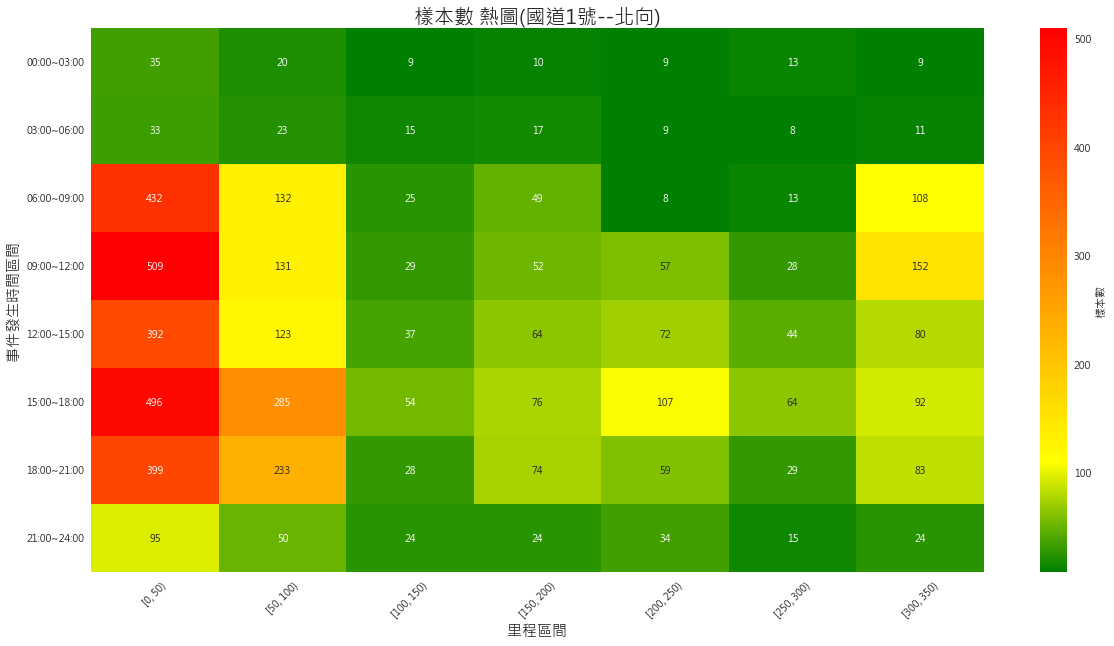

In [17]:
# show sample heatmap(north)
# create the copy to avoid warning
df_north_direction_copy = df_north_direction.copy()
# def block
## time : 3 hr
## mile : 50 km
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(df_north_direction_copy['里程'].min(), df_north_direction_copy['里程'].max() + 1, mile_block, dtype=int)

# add newe col to separate sample
df_north_direction_copy['事件發生時間區間'] = pd.cut(df_north_direction_copy['事件發生(秒數)'], bins=time_bins, right=False)
df_north_direction_copy['里程區間'] = pd.cut(df_north_direction_copy['里程'], bins=mile_bins, right=False)

# caculate the sample
sample_counts = df_north_direction_copy.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')

# change into str to create pivot
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
# pivot
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# use func to change str into 24hr
pivot_table.index = pivot_table.index.map(format_time_label)

# sort x axis(so hard)
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))

# default color to highlight 100
## 0.1 is for (max*0.1)~100
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.2, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# show heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道1號--北向)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

#### 用 heat map 顯示各區間的樣本數 (南向)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '00:00~03:00'),
  Text(0, 1.5, '03:00~06:00'),
  Text(0, 2.5, '06:00~09:00'),
  Text(0, 3.5, '09:00~12:00'),
  Text(0, 4.5, '12:00~15:00'),
  Text(0, 5.5, '15:00~18:00'),
  Text(0, 6.5, '18:00~21:00'),
  Text(0, 7.5, '21:00~24:00')])

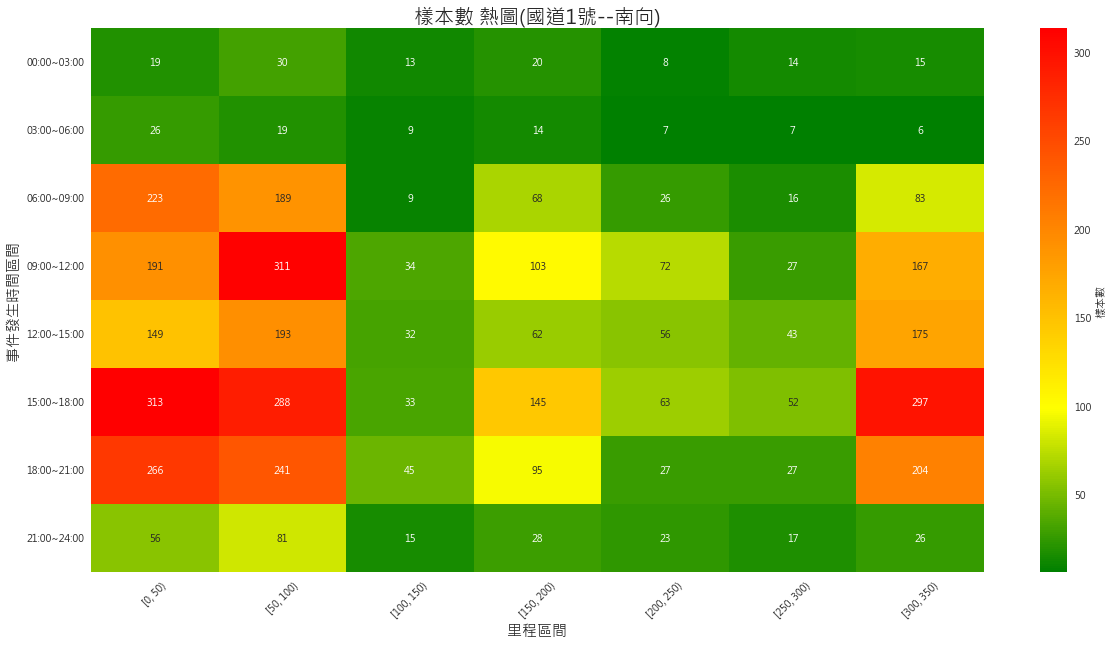

In [18]:
# show sample heatmap(south)
# create the copy to avoid warning
df_south_direction_copy = df_south_direction.copy()
# def block
## time : 3 hr
## mile : 50 km
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(df_south_direction_copy['里程'].min(), df_south_direction_copy['里程'].max() + 1, mile_block, dtype=int)

# add newe col to separate sample
df_south_direction_copy['事件發生時間區間'] = pd.cut(df_south_direction_copy['事件發生(秒數)'], bins=time_bins, right=False)
df_south_direction_copy['里程區間'] = pd.cut(df_south_direction_copy['里程'], bins=mile_bins, right=False)

# caculate the sample
sample_counts = df_south_direction_copy.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')

# change into str to create pivot
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
# pivot
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# use func to change str into 24hr
pivot_table.index = pivot_table.index.map(format_time_label)

# sort x axis(so hard)
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))

# default color to highlight 100
## 0.1 is for (max*0.1)~100
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.3, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# show heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道1號--南向)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

### 國道 1 號--實際測試資料

#### 匯入資料

In [49]:
# read excel
excel_file = "113年1-2月交通事故簡訊通報資料.xlsx"
real_df = pd.read_excel(excel_file)
real_df.head()

年  月   日   時   分  國道名稱 方向    里程   事件發生  交控中心接獲通報  ...  車輛3   車輛4   車輛5  \
0  2024  1  13  15  13    國3  北  10.0  15:13       NaN  ...  小自客   小自客   NaN   
1  2024  1  13  15  21    國1  南  43.8  15:21       NaN  ...  小自客   小自客   NaN   
2  2024  1  13  14  13    國2  西  11.5  14:13       NaN  ...  小自客   小自客   NaN   
3  2024  1  13  14  25    國2  東  19.5  14:25       NaN  ...  大貨車   大貨車   小貨車   
4  2024  1  13  15  28  國1高架  南  58.0  15:28       NaN  ...  小自客   小自客   NaN   

    車輛6  車輛7  車輛8  車輛9  車輛10 車輛11  車輛12  
0   NaN  NaN  NaN  NaN   NaN  NaN   NaN  
1   NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2   NaN  NaN  NaN  NaN   NaN  NaN   NaN  
3   小自客  NaN  NaN  NaN   NaN  NaN   NaN  
4   NaN  NaN  NaN  NaN   NaN  NaN   NaN  

[5 rows x 49 columns]

#### 填補"車輛"遺失值

In [121]:
# fill "車輛{i}" NA
# find "車輛1" is NA & "肇事車輛" != 0
filtered_df = real_df.loc[(real_df["車輛1"].isna()) & (real_df["肇事車輛"] != 0), ["車輛1", "肇事車輛", "簡訊內容"]]

# adjust "簡訊內容"
def process_message(message):
    if "追撞" in message:
        if "," in message:
            return message[message.find(")") + 1:].split(",")[0].split("追撞")[0]
        else:
            return message[message.find(")") + 1:].split("追撞")[0]
    elif "," in message:
        return message.split(",")[0]
    else:
        return message

filtered_df["簡訊內容"] = filtered_df["簡訊內容"].apply(process_message)

# fill "車輛{i}", with adjusted "簡訊內容"
def fill_vehicles(row):
    message = row["簡訊內容"]
    # use RE to find "num + vehicle_type"(數量以及車輛類型)
    # match num & vehicle_type, not include "+"
    matches = re.findall(r'(\d+)\s*([^+]+)', message)
    # save vehicle_type
    vehicles = []
    for count, vehicle_type in matches:
        count = int(count)
        # del " "
        vehicle_type = vehicle_type.strip()
        # save times of vehicle_type
        vehicles.extend([vehicle_type] * count)
    # if no num, spilt by "+"
    if not matches:
        parts = message.split("+")
        for i, part in enumerate(parts, start=1):
            row[f"車輛{i}"] = part.strip()
    else:
        # fill
        for i, vehicle in enumerate(vehicles, start=1):
            row[f"車輛{i}"] = vehicle
    return row

filtered_df = filtered_df.apply(fill_vehicles, axis=1)

# show
filtered_df


車輛1  肇事車輛  簡訊內容 車輛2 車輛3 車輛4 車輛5 車輛6 車輛7 車輛8 車輛9 車輛10
2499  小客   NaN  10小客  小客  小客  小客  小客  小客  小客  小客  小客   小客

In [122]:
# fill filtered_df in df with corresponding col
for index, row in filtered_df.iterrows():
    # check NA, to avoid error
    if pd.isna(real_df.at[index, "車輛1"]):
        # max "車輛" is 4, can change
        for i in range(1, 5):
            if f"車輛{i}" in row:
                real_df.at[index, f"車輛{i}"] = row[f"車輛{i}"]


In [123]:
# check 
i_col = 2499
sms_content = real_df.iloc[i_col]['肇事車輛']
print(sms_content)

nan


#### 根據時間排序

In [124]:
# sort by time
real_sorted_df = real_df.sort_values(by=["月", "日", "時", "分"])
real_sorted_df

年  月   日   時   分  國道名稱  方向     里程   事件發生  交控中心接獲通報  ...  車輛3  車輛4  \
2260  2024  1   1   0  30  國道1號  北向  155.8  00:22       NaN  ...  NaN  NaN   
2798  2024  1   1   1  37    國1  南向  268.9  01:37       NaN  ...  NaN  NaN   
2259  2024  1   1   2   2  國道1號  北向  117.9  02:01       NaN  ...  NaN  NaN   
151   2024  1   1   2  31  國1高架   南   66.5  02:31       NaN  ...  小自客  NaN   
2258  2024  1   1   4  51  國道3號  南向  160.8  04:46       NaN  ...  NaN  NaN   
...    ... ..  ..  ..  ..   ...  ..    ...    ...       ...  ...  ...  ...   
2459  2024  2  29  18  47  國道1號  南向  198.4  18:45       NaN  ...  NaN  NaN   
2460  2024  2  29  18  48  國道3號  南向  115.0  18:43       NaN  ...  NaN  NaN   
1698  2024  2  29  18  49    國1   南   95.0  18:49       NaN  ...  小自客  小自客   
2458  2024  2  29  19  10  國道1號  南向  109.5  19:08       NaN  ...  NaN  NaN   
3751  2024  2  29  23  17    國1  南向  294.8  23:17       NaN  ...  NaN  NaN   

      車輛5  車輛6  車輛7  車輛8  車輛9  車輛10 車輛11  車輛12  
2260  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2798  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2259  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
151   NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2258  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
...   ...  ...  ...  ...  ...   ...  ...   ...  
2459  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2460  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
1698  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2458  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
3751  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  

[3826 rows x 49 columns]

#### 把"方向"修正

In [125]:
# adjust "方向"
real_sorted_df["方向"] = real_df["方向"].str.replace("向", "")
real_sorted_df["方向"] = real_sorted_df["方向"].str.replace("南北|雙", "雙", regex=True)
real_sorted_df

年  月   日   時   分  國道名稱 方向     里程   事件發生  交控中心接獲通報  ...  車輛3  車輛4  \
2260  2024  1   1   0  30  國道1號  北  155.8  00:22       NaN  ...  NaN  NaN   
2798  2024  1   1   1  37    國1  南  268.9  01:37       NaN  ...  NaN  NaN   
2259  2024  1   1   2   2  國道1號  北  117.9  02:01       NaN  ...  NaN  NaN   
151   2024  1   1   2  31  國1高架  南   66.5  02:31       NaN  ...  小自客  NaN   
2258  2024  1   1   4  51  國道3號  南  160.8  04:46       NaN  ...  NaN  NaN   
...    ... ..  ..  ..  ..   ... ..    ...    ...       ...  ...  ...  ...   
2459  2024  2  29  18  47  國道1號  南  198.4  18:45       NaN  ...  NaN  NaN   
2460  2024  2  29  18  48  國道3號  南  115.0  18:43       NaN  ...  NaN  NaN   
1698  2024  2  29  18  49    國1  南   95.0  18:49       NaN  ...  小自客  小自客   
2458  2024  2  29  19  10  國道1號  南  109.5  19:08       NaN  ...  NaN  NaN   
3751  2024  2  29  23  17    國1  南  294.8  23:17       NaN  ...  NaN  NaN   

      車輛5  車輛6  車輛7  車輛8  車輛9  車輛10 車輛11  車輛12  
2260  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2798  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2259  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
151   NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2258  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
...   ...  ...  ...  ...  ...   ...  ...   ...  
2459  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2460  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
1698  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2458  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  
3751  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN  

[3826 rows x 49 columns]

#### 刪除不重要的變數

In [126]:
# del not important var
columns_to_drop = ["交控中心接獲通報", "CCTV監看現場", "CMS發布資訊","交控中心通報工務段", "事故處理小組出發", "事故處理小組抵達", "事故處理小組完成"]
real_sorted_df = real_sorted_df.drop(columns_to_drop, axis=1)
real_sorted_df

年  月   日   時   分  國道名稱 方向     里程   事件發生   事件排除  ...  車輛3  車輛4  車輛5  \
2260  2024  1   1   0  30  國道1號  北  155.8  00:22  00:30  ...  NaN  NaN  NaN   
2798  2024  1   1   1  37    國1  南  268.9  01:37  02:00  ...  NaN  NaN  NaN   
2259  2024  1   1   2   2  國道1號  北  117.9  02:01  02:02  ...  NaN  NaN  NaN   
151   2024  1   1   2  31  國1高架  南   66.5  02:31  03:12  ...  小自客  NaN  NaN   
2258  2024  1   1   4  51  國道3號  南  160.8  04:46  04:51  ...  NaN  NaN  NaN   
...    ... ..  ..  ..  ..   ... ..    ...    ...    ...  ...  ...  ...  ...   
2459  2024  2  29  18  47  國道1號  南  198.4  18:45  18:47  ...  NaN  NaN  NaN   
2460  2024  2  29  18  48  國道3號  南  115.0  18:43  18:48  ...  NaN  NaN  NaN   
1698  2024  2  29  18  49    國1  南   95.0  18:49  18:55  ...  小自客  小自客  NaN   
2458  2024  2  29  19  10  國道1號  南  109.5  19:08  19:10  ...  NaN  NaN  NaN   
3751  2024  2  29  23  17    國1  南  294.8  23:17  01:20  ...  NaN  NaN  NaN   

      車輛6  車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  
2260  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
2798  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
2259  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
151   NaN  NaN  NaN  NaN   NaN   NaN   NaN  
2258  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
...   ...  ...  ...  ...   ...   ...   ...  
2459  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
2460  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
1698  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
2458  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
3751  NaN  NaN  NaN  NaN   NaN   NaN   NaN  

[3826 rows x 42 columns]

#### 增加"回堵長度"

In [129]:
def calculate_traffic_jam_length(text):
    if "回堵" in text:
        match = re.search(r'回堵(\d+)\s*(?:K|公里|k)', text)
        if match:
            return int(match.group(1))
    return 0

In [130]:
# add new col
real_sorted_df["回堵長度"] = real_sorted_df["簡訊內容"].apply(calculate_traffic_jam_length)
real_sorted_df

年  月   日   時   分  國道名稱 方向     里程   事件發生   事件排除  ...  車輛4  車輛5  車輛6  \
2260  2024  1   1   0  30  國道1號  北  155.8  00:22  00:30  ...  NaN  NaN  NaN   
2798  2024  1   1   1  37  國道1號  南  268.9  01:37  02:00  ...  NaN  NaN  NaN   
2259  2024  1   1   2   2  國道1號  北  117.9  02:01  02:02  ...  NaN  NaN  NaN   
151   2024  1   1   2  31  國道1號  南   66.5  02:31  03:12  ...  NaN  NaN  NaN   
2258  2024  1   1   4  51  國道3號  南  160.8  04:46  04:51  ...  NaN  NaN  NaN   
...    ... ..  ..  ..  ..   ... ..    ...    ...    ...  ...  ...  ...  ...   
2459  2024  2  29  18  47  國道1號  南  198.4  18:45  18:47  ...  NaN  NaN  NaN   
2460  2024  2  29  18  48  國道3號  南  115.0  18:43  18:48  ...  NaN  NaN  NaN   
1698  2024  2  29  18  49  國道1號  南   95.0  18:49  18:55  ...  小自客  NaN  NaN   
2458  2024  2  29  19  10  國道1號  南  109.5  19:08  19:10  ...  NaN  NaN  NaN   
3751  2024  2  29  23  17  國道1號  南  294.8  23:17  01:20  ...  NaN  NaN  NaN   

      車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  回堵長度  
2260  NaN  NaN  NaN   NaN   NaN   NaN     0  
2798  NaN  NaN  NaN   NaN   NaN   NaN     0  
2259  NaN  NaN  NaN   NaN   NaN   NaN     0  
151   NaN  NaN  NaN   NaN   NaN   NaN     0  
2258  NaN  NaN  NaN   NaN   NaN   NaN     0  
...   ...  ...  ...   ...   ...   ...   ...  
2459  NaN  NaN  NaN   NaN   NaN   NaN     0  
2460  NaN  NaN  NaN   NaN   NaN   NaN     0  
1698  NaN  NaN  NaN   NaN   NaN   NaN     0  
2458  NaN  NaN  NaN   NaN   NaN   NaN     0  
3751  NaN  NaN  NaN   NaN   NaN   NaN     0  

[3826 rows x 43 columns]

#### 修正"國道名稱"

In [131]:
# change "國道名稱"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國1", '國道名稱'] = "國道1號"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國1高架", '國道名稱'] = "國道1號"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國3", '國道名稱'] = "國道3號"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國2", '國道名稱'] = "國道2號"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國10", '國道名稱'] = "國道10號"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國8", '國道名稱'] = "國道8號"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國3甲", '國道名稱'] = "國道3甲"
real_sorted_df.loc[real_sorted_df['國道名稱'] == "國2甲", '國道名稱'] = "國道2甲"

#### 刪除重複的資料

In [132]:
# unique
real_sorted_df = real_sorted_df.drop_duplicates(subset=['年', '月', '日', '時', '分', '國道名稱', '方向', '里程'])
# check
real_sorted_df

年  月   日   時   分  國道名稱 方向     里程   事件發生   事件排除  ...  車輛4  車輛5  車輛6  \
2260  2024  1   1   0  30  國道1號  北  155.8  00:22  00:30  ...  NaN  NaN  NaN   
2798  2024  1   1   1  37  國道1號  南  268.9  01:37  02:00  ...  NaN  NaN  NaN   
2259  2024  1   1   2   2  國道1號  北  117.9  02:01  02:02  ...  NaN  NaN  NaN   
151   2024  1   1   2  31  國道1號  南   66.5  02:31  03:12  ...  NaN  NaN  NaN   
2258  2024  1   1   4  51  國道3號  南  160.8  04:46  04:51  ...  NaN  NaN  NaN   
...    ... ..  ..  ..  ..   ... ..    ...    ...    ...  ...  ...  ...  ...   
2459  2024  2  29  18  47  國道1號  南  198.4  18:45  18:47  ...  NaN  NaN  NaN   
2460  2024  2  29  18  48  國道3號  南  115.0  18:43  18:48  ...  NaN  NaN  NaN   
1698  2024  2  29  18  49  國道1號  南   95.0  18:49  18:55  ...  小自客  NaN  NaN   
2458  2024  2  29  19  10  國道1號  南  109.5  19:08  19:10  ...  NaN  NaN  NaN   
3751  2024  2  29  23  17  國道1號  南  294.8  23:17  01:20  ...  NaN  NaN  NaN   

      車輛7  車輛8  車輛9  車輛10  車輛11  車輛12  回堵長度  
2260  NaN  NaN  NaN   NaN   NaN   NaN     0  
2798  NaN  NaN  NaN   NaN   NaN   NaN     0  
2259  NaN  NaN  NaN   NaN   NaN   NaN     0  
151   NaN  NaN  NaN   NaN   NaN   NaN     0  
2258  NaN  NaN  NaN   NaN   NaN   NaN     0  
...   ...  ...  ...   ...   ...   ...   ...  
2459  NaN  NaN  NaN   NaN   NaN   NaN     0  
2460  NaN  NaN  NaN   NaN   NaN   NaN     0  
1698  NaN  NaN  NaN   NaN   NaN   NaN     0  
2458  NaN  NaN  NaN   NaN   NaN   NaN     0  
3751  NaN  NaN  NaN   NaN   NaN   NaN     0  

[3704 rows x 43 columns]

#### 修正"車輛{i}"的寫法

In [133]:
# use copy to avoid error
real_sorted_df_copy = real_sorted_df.copy()
# all columns to adjust
vehicle_columns = ["車輛1", "車輛2", "車輛3", "車輛4", "車輛5",
                   "車輛6", "車輛7", "車輛8", "車輛9", "車輛10", "車輛11", "車輛12"]

# replace values
replace_dict = {
    "重型機車": "重機",
    "小自客\n": "小自客", "小客車": "小自客", "小客": "小自客", "小車": "小自客", '小自客\"\n': "小自客", " 小自客": "小自客", "自小": "小自客", "小自車": "小自客", "小自客_x000D_\n": "小自客",
    "大客車": "大客車", "大客車\n": "大客車", "大客": "大客車", "大客車_x000D_\n": "大客車",
    "貨車": "貨車",
    "小貨車": "小貨車", "小貨車\n": "小貨車", "小自貨": "小貨車", "小營業貨": "小貨車", "小貨": "小貨車", "小貨車_x000D_\n": "小貨車",
    "中型貨車": "中貨車",
    "大貨車": "大貨車", "貨櫃車": "大貨車", " 大貨車": "大貨車", "大貨車\n": "大貨車", "大貨": "大貨車", "大貨車ˉ": "大貨車", "284貨車": "大貨車", "大貨\n": "大貨車", "大貨車_x000D_\n": "大貨車",
    "聯結車": "聯結車", "聯結車\n": "聯結車",
    "拖吊車": "拖吊車",
    "槽車": "槽車",
    "垃圾車": "垃圾車",
    "貨櫃車": "貨櫃車",
    "工工程車": "工程車", "工程車\n": "工程車",
    "施工車": "施工車",
    "緩撞車": "緩撞車", "緩撞車\n": "緩撞車", "施工緩撞車": "緩撞車", "\"事故班緩撞車": "緩撞車", "事故班緩撞車": "緩撞車",
    "油罐車": "油罐車",
    "預拌水泥車": "預拌車", "預拌混泥土車": "預拌車",
    "砂石車": "砂石車",
    "公警": "公警",
    "拖板車": "拖板車",
    "計程車": "計程車",
    "起重機": "起重機",
    "其他": "其他",
    "國光客運": "中型巴士",
    "施工高空車": "高空作業車",
    "     ": np.nan
}

# adjust and replace values in columns
for column in vehicle_columns:
    real_sorted_df_copy.loc[:, column] = real_sorted_df_copy.loc[:, column].replace(replace_dict)
    real_sorted_df = real_sorted_df_copy

    # show the adjusted results
    counts = real_sorted_df[column].value_counts()
    print(f"{column} 調整後的結果：")
    print(counts)
    print("-" * 50)


車輛1 調整後的結果：
小自客                           1931
小自客\n 小自客                      605
小自客\n小自客                       369
小自客\n 小自客\n 小自客                 95
小貨車                             72
                              ... 
大貨車\n砂石車                         1
小自客\n 小自客\n 小自客\n 小自客\n聯結車       1
槽車                               1
聯結車\n小貨車                         1
大客車\n小自客\n小自客                    1
Name: 車輛1, Length: 116, dtype: int64
--------------------------------------------------
車輛2 調整後的結果：
小自客                           1545
小貨車                            117
大貨車                             58
其他                              40
大客車                             14
槽車                               6
緩撞車                              5
聯結車                              5
拖板車                              1
136-3B\nRAS-9355\nBAR-6338       1
拖吊車                              1
Name: 車輛2, dtype: int64
--------------------------------------------------
車輛3 調整後的結果：
小自客       1788
小貨車        138
大

#### 修正時間相關的變數

In [134]:
# check "事件發生" contain ":"
no_colon_df = real_sorted_df[~real_sorted_df['事件發生'].str.contains(':')]
no_colon_df.head()

年  月   日   時   分  國道名稱 方向    里程  事件發生  事件排除  ...  車輛4  車輛5  車輛6  車輛7  \
1711  2024  1   1  16  44  國道5號  北  33.5  1644  1649  ...  NaN  NaN  NaN  NaN   
1712  2024  1   1  17   9  國道5號  北  13.3  1709  1714  ...  NaN  NaN  NaN  NaN   
1769  2024  1   3   7  39  國道5號  南  19.4  0739  0822  ...  NaN  NaN  NaN  NaN   
1722  2024  1  11  17  24  國道5號  北  27.9  1724  1751  ...  NaN  NaN  NaN  NaN   
1709  2024  1  12  16  31  國道5號  北  29.2  1631  1635  ...  NaN  NaN  NaN  NaN   

      車輛8  車輛9  車輛10  車輛11  車輛12  回堵長度  
1711  NaN  NaN   NaN   NaN   NaN     0  
1712  NaN  NaN   NaN   NaN   NaN     0  
1769  NaN  NaN   NaN   NaN   NaN     0  
1722  NaN  NaN   NaN   NaN   NaN     0  
1709  NaN  NaN   NaN   NaN   NaN     0  

[5 rows x 43 columns]

In [135]:
# upload "方向"、"里程"
# use RE to match
date_time_pattern = re.compile(r'\s*(\d{2})/(\d{2}),(\d{2}):(\d{2})\s*')
direction_pattern = re.compile(r'\s*(南向|北向)\s*')
mileage_pattern = re.compile(r'\s*(\d+(?:\.\d+)?)K')

# def func to upload every grid
def update_and_calculate_row(row):
    # get "事件發生"
    event_match = date_time_pattern.search(row['簡訊內容'])
    if event_match:
        row['月'], row['日'], row['時'], row['分'] = event_match.groups()
        row['事件發生'] = f"{row['時']}:{row['分']}"

    # get "事件排除"
    exclude_match = re.search(r'(\d{2}):(\d{2})排除', row['簡訊內容'])
    if exclude_match:
        exclude_hour, exclude_minute = exclude_match.groups()
        row['事件排除'] = f"{exclude_hour}:{exclude_minute}"
    
    # get "方向" & change
    direction_match = direction_pattern.search(row['簡訊內容'])
    if direction_match:
        direction = direction_match.group(1)
        row['方向'] = "南" if direction == "南向" else "北"
    
    # get "里程"
    mileage_match = mileage_pattern.search(row['簡訊內容'])
    if mileage_match:
        row['里程'] = float(mileage_match.group(1))

    # check if "事件發生" "事件排除" contain ':'
    if row['事件發生'] and ":" not in row['事件發生']:
        row['事件發生'] = row['事件發生'][:2] + ":" + row['事件發生'][2:]
    if row['事件排除'] and ":" not in row['事件排除']:
        row['事件排除'] = row['事件排除'][:2] + ":" + row['事件排除'][2:]
    
    # count "處理分鐘"
    if row['事件發生'] and row['事件排除']:
        try:
            # change "事件發生" "事件排除" type to datetime
            time_format = "%H:%M"
            start_time = datetime.strptime(row['事件發生'], time_format)
            end_time = datetime.strptime(row['事件排除'], time_format)
            
            # get process time
            processing_time = (end_time - start_time).total_seconds() / 60
            row['處理分鐘'] = processing_time
        except ValueError:
            row['處理分鐘'] = None
    else:
        row['處理分鐘'] = None
    
    return row

# use func to update val
no_colon_df = no_colon_df.apply(update_and_calculate_row, axis=1)

# Remove rows where '處理分鐘' has negative values
no_colon_df = no_colon_df[no_colon_df['處理分鐘'] >= 0]

# fill back to real_sorted_df
real_sorted_df.update(no_colon_df)

#### 修正"肇事車輛"

In [136]:
# find "肇事車輛" is NA
na_rows = real_sorted_df[real_sorted_df['肇事車輛'].isna()]

# get every "車輛" col
vehicle_columns = [col for col in real_sorted_df.columns if col.startswith('車輛')]

# find non NA with max i in "車輛{i}"
max_vehicle_number = 0
for col in vehicle_columns:
    # ensure col type of i is int
    try:
        number = int(col.replace('車輛', ''))
        if not real_sorted_df[col].isna().all():
            max_vehicle_number = max(max_vehicle_number, number)
    except ValueError:
        continue

# fill max num
real_sorted_df.loc[real_sorted_df['肇事車輛'].isna(), '肇事車輛'] = max_vehicle_number

# check 
na_rows = real_sorted_df[real_sorted_df['肇事車輛'].isna()]
na_rows


Empty DataFrame
Columns: [年, 月, 日, 時, 分, 國道名稱, 方向, 里程, 事件發生, 事件排除, 處理分鐘, 事故類型, 死亡, 受傷, 內路肩, 內車道, 中內車道, 中車道, 中外車道, 外車道, 外路肩, 匝道, 簡訊內容, 翻覆事故註記, 施工事故註記, 危險物品車輛註記, 車輛起火註記, 冒煙車事故註記, 主線中斷註記, 肇事車輛, 車輛1, 車輛2, 車輛3, 車輛4, 車輛5, 車輛6, 車輛7, 車輛8, 車輛9, 車輛10, 車輛11, 車輛12, 回堵長度]
Index: []

[0 rows x 43 columns]

#### 新增欄位 "事故車是否包含非小客車"

In [137]:
# def func to know every "車輛", without NA
def check_vehicle_type(row):
    # set ori 0
    vehicle_status = 0
    vehicle_columns = [col for col in real_sorted_df.columns if col.startswith('車輛')]
    
    # check every "車輛{i}" col
    for col in vehicle_columns:
        # check not NA
        if pd.notna(row[col]):
            # check "小客車"
            if "小自客" in str(row[col]):
                vehicle_status = 0
            else:
                vehicle_status = 1
    return vehicle_status

# add new col"事故車是否包含非小客車"
real_sorted_df['事故車是否包含非小客車'] = real_sorted_df.apply(check_vehicle_type, axis=1)
# check
real_sorted_df[['事故車是否包含非小客車'] + vehicle_columns + ["簡訊內容"]]

事故車是否包含非小客車  車輛起火註記       車輛1  車輛2  車輛3  車輛4  車輛5  車輛6  車輛7  車輛8  車輛9  \
2260            0     NaN       小自客  小自客  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2798            0     NaN       小自客  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2259            0     NaN       小自客  小自客  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
151             0     NaN       小自客  NaN  小自客  NaN  NaN  NaN  NaN  NaN  NaN   
2258            0     NaN       小自客  小自客  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...           ...     ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
2459            1     NaN       小自客  小貨車  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2460            0     NaN       小自客  小自客  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1698            0     NaN  小自客\n小自客  NaN  小自客  小自客  NaN  NaN  NaN  NaN  NaN   
2458            0     NaN       小自客  小自客  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3751            1     NaN       聯結車   其他  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

     車輛10 車輛11 車輛12                                               簡訊內容  
2260  NaN  NaN  NaN  中控通報3級01/01,00:22國1北向155.8K(結報)2小客車追撞事故占外路肩,無人...  
2798  NaN  NaN  NaN  南控通報3級01/01,01:37國1南向268.9k(結報)(修正)小客車撞護欄,02:0...  
2259  NaN  NaN  NaN  中控通報3級01/01,02:01國1北向117.9K(結報)2小客車追撞事故占外路肩,無人...  
151   NaN  NaN  NaN  北控通報3級01/01,02:31國1高架南向66.5K(結報)1小自客自撞占用外路肩事故,...  
2258  NaN  NaN  NaN  中控通報3級01/01,04:46國3南向160.8K(結報)2小客車追撞事故占外車道,無人...  
...   ...  ...  ...                                                ...  
2459  NaN  NaN  NaN  中控通報3級02/29,18:45國1南向彰化出口(結報)1小客+1小貨追撞事故占匝道外側,...  
2460  NaN  NaN  NaN  中控通報3級02/29,18:43國3南向西濱出口(結報)2小客車追撞事故占匝道外側,18:...  
1698  NaN  NaN  NaN  北控通報3級02/29,18:49國1南向新竹B入口(結報)2小客車追撞事故,無人傷亡,無回...  
2458  NaN  NaN  NaN  中控通報3級02/29,19:08國1南向109.5K(結報)2小客車追撞事故占外車道,19...  
3751  NaN  NaN  NaN  南控通報2級02/29,23:17國1南向294.8k(結報修正)12:32去電詢問公警修正...  

[3704 rows x 15 columns]

In [138]:
# get "事故車是否包含非小客車" counts
value_counts = real_sorted_df['事故車是否包含非小客車'].value_counts()
value_counts


0    3159
1     545
Name: 事故車是否包含非小客車, dtype: int64

#### 刪除所有"車輛{i}"並且重新編號

In [139]:
# del every "車輛{i}"
vehicle_columns = [col for col in real_sorted_df.columns if col.startswith('車輛') and col[2:].isdigit()]
real_sorted_df = real_sorted_df.drop(columns=vehicle_columns)
# reset index
real_sorted_df = real_sorted_df.reset_index(drop=True)
real_sorted_df.index = real_sorted_df.index
real_sorted_df

年  月   日   時   分  國道名稱 方向     里程   事件發生   事件排除  ...  \
0     2024.0  1   1   0  30  國道1號  北  155.8  00:22  00:30  ...   
1     2024.0  1   1   1  37  國道1號  南  268.9  01:37  02:00  ...   
2     2024.0  1   1   2   2  國道1號  北  117.9  02:01  02:02  ...   
3     2024.0  1   1   2  31  國道1號  南   66.5  02:31  03:12  ...   
4     2024.0  1   1   4  51  國道3號  南  160.8  04:46  04:51  ...   
...      ... ..  ..  ..  ..   ... ..    ...    ...    ...  ...   
3699  2024.0  2  29  18  47  國道1號  南  198.4  18:45  18:47  ...   
3700  2024.0  2  29  18  48  國道3號  南  115.0  18:43  18:48  ...   
3701  2024.0  2  29  18  49  國道1號  南   95.0  18:49  18:55  ...   
3702  2024.0  2  29  19  10  國道1號  南  109.5  19:08  19:10  ...   
3703  2024.0  2  29  23  17  國道1號  南  294.8  23:17  01:20  ...   

                                                   簡訊內容 翻覆事故註記  施工事故註記  \
0     中控通報3級01/01,00:22國1北向155.8K(結報)2小客車追撞事故占外路肩,無人...    NaN     NaN   
1     南控通報3級01/01,01:37國1南向268.9k(結報)(修正)小客車撞護欄,02:0...    NaN     NaN   
2     中控通報3級01/01,02:01國1北向117.9K(結報)2小客車追撞事故占外路肩,無人...    NaN     NaN   
3     北控通報3級01/01,02:31國1高架南向66.5K(結報)1小自客自撞占用外路肩事故,...    NaN     NaN   
4     中控通報3級01/01,04:46國3南向160.8K(結報)2小客車追撞事故占外車道,無人...    NaN     NaN   
...                                                 ...    ...     ...   
3699  中控通報3級02/29,18:45國1南向彰化出口(結報)1小客+1小貨追撞事故占匝道外側,...    NaN     NaN   
3700  中控通報3級02/29,18:43國3南向西濱出口(結報)2小客車追撞事故占匝道外側,18:...    NaN     NaN   
3701  北控通報3級02/29,18:49國1南向新竹B入口(結報)2小客車追撞事故,無人傷亡,無回...    NaN     NaN   
3702  中控通報3級02/29,19:08國1南向109.5K(結報)2小客車追撞事故占外車道,19...    NaN     NaN   
3703  南控通報2級02/29,23:17國1南向294.8k(結報修正)12:32去電詢問公警修正...    NaN     NaN   

      危險物品車輛註記  車輛起火註記 冒煙車事故註記  主線中斷註記  肇事車輛  回堵長度  事故車是否包含非小客車  
0          NaN     NaN     NaN     NaN   2.0   0.0            0  
1          NaN     NaN     NaN     NaN   1.0   0.0            0  
2          NaN     NaN     NaN     NaN   2.0   0.0            0  
3          NaN     NaN     NaN     NaN   1.0   0.0            0  
4          NaN     NaN     NaN     NaN   2.0   0.0            0  
...        ...     ...     ...     ...   ...   ...          ...  
3699       NaN     NaN     NaN     NaN   2.0   0.0            1  
3700       NaN     NaN     NaN     NaN   2.0   0.0            0  
3701       NaN     NaN     NaN     NaN   2.0   0.0            0  
3702       NaN     NaN     NaN     NaN   2.0   0.0            0  
3703       NaN     NaN     NaN     NaN   2.0   0.0            1  

[3704 rows x 32 columns]

#### 新增 "是否為假日"

In [142]:
# change these col into int
for col in ['年', '月', '日', '時', '分']:
    if col in real_sorted_df.columns:
        real_sorted_df[col] = real_sorted_df[col].astype(int)
# add new var --"是否為假日"
real_sorted_df['是否為假日'] = real_sorted_df.apply(
    lambda row: 1 if is_holiday(date(row['年'], row['月'], row['日'])) else 0, axis=1)
# check
real_sorted_df

年  月   日   時   分  國道名稱 方向     里程   事件發生   事件排除  ...  翻覆事故註記 施工事故註記  \
0     2024  1   1   0  30  國道1號  北  155.8  00:22  00:30  ...     NaN    NaN   
1     2024  1   1   1  37  國道1號  南  268.9  01:37  02:00  ...     NaN    NaN   
2     2024  1   1   2   2  國道1號  北  117.9  02:01  02:02  ...     NaN    NaN   
3     2024  1   1   2  31  國道1號  南   66.5  02:31  03:12  ...     NaN    NaN   
4     2024  1   1   4  51  國道3號  南  160.8  04:46  04:51  ...     NaN    NaN   
...    ... ..  ..  ..  ..   ... ..    ...    ...    ...  ...     ...    ...   
3699  2024  2  29  18  47  國道1號  南  198.4  18:45  18:47  ...     NaN    NaN   
3700  2024  2  29  18  48  國道3號  南  115.0  18:43  18:48  ...     NaN    NaN   
3701  2024  2  29  18  49  國道1號  南   95.0  18:49  18:55  ...     NaN    NaN   
3702  2024  2  29  19  10  國道1號  南  109.5  19:08  19:10  ...     NaN    NaN   
3703  2024  2  29  23  17  國道1號  南  294.8  23:17  01:20  ...     NaN    NaN   

      危險物品車輛註記  車輛起火註記  冒煙車事故註記 主線中斷註記  肇事車輛  回堵長度  事故車是否包含非小客車  是否為假日  
0          NaN     NaN      NaN    NaN   2.0   0.0            0      1  
1          NaN     NaN      NaN    NaN   1.0   0.0            0      1  
2          NaN     NaN      NaN    NaN   2.0   0.0            0      1  
3          NaN     NaN      NaN    NaN   1.0   0.0            0      1  
4          NaN     NaN      NaN    NaN   2.0   0.0            0      1  
...        ...     ...      ...    ...   ...   ...          ...    ...  
3699       NaN     NaN      NaN    NaN   2.0   0.0            1      0  
3700       NaN     NaN      NaN    NaN   2.0   0.0            0      0  
3701       NaN     NaN      NaN    NaN   2.0   0.0            0      0  
3702       NaN     NaN      NaN    NaN   2.0   0.0            0      0  
3703       NaN     NaN      NaN    NaN   2.0   0.0            1      0  

[3704 rows x 33 columns]

#### 新增 "相近時間是否有事件"

In [143]:
# add new var --"是否為相近時間"、"是否為相近地點"、"相近時間是否有事件"
real_sorted_df['是否為相近時間'] = 0
real_sorted_df['是否為相近地點'] = 0
real_sorted_df['相近時間&地點是否有事件'] = 0
# first--group to process
grouped = real_sorted_df.groupby(['年', '月', '日', '國道名稱', '方向'])
# loop
for name, group in grouped:
    # repeat every group
    for i in range(len(group)):
        current_event = group.iloc[i]
        current_start = current_event['事件發生']
        current_end = current_event['事件排除']
        current_mileage = current_event['里程']
        
        # check the logic
        for j in range(i):
            previous_event = group.iloc[j]
            previous_start = previous_event['事件發生']
            previous_end = previous_event['事件排除']
            previous_mileage = previous_event['里程']
            
            # check place
            if abs(current_mileage - previous_mileage) <= 10:
                real_sorted_df.at[current_event.name, '是否為相近地點'] = 1
            # check time
            if (previous_start <= current_start <= previous_end):
                real_sorted_df.at[current_event.name, '是否為相近時間'] = 1
            # check both
            if abs(current_mileage - previous_mileage) <= 10:
                if (previous_start <= current_start <= previous_end):
                    real_sorted_df.at[current_event.name, '相近時間&地點是否有事件'] = 1
                    break
# # cross 2 var
# real_sorted_df['相近時間是否有事件'] = real_sorted_df['是否為相近時間'] * real_sorted_df['是否為相近地點']
print("finish")

finish


#### 查看目前剩下哪些變數

In [144]:
# check saved cols
remaining_columns = real_sorted_df.columns
print(remaining_columns)

Index(['年', '月', '日', '時', '分', '國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘',
       '事故類型', '死亡', '受傷', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩',
       '匝道', '簡訊內容', '翻覆事故註記', '施工事故註記', '危險物品車輛註記', '車輛起火註記', '冒煙車事故註記',
       '主線中斷註記', '肇事車輛', '回堵長度', '事故車是否包含非小客車', '是否為假日', '是否為相近時間', '是否為相近地點',
       '相近時間&地點是否有事件'],
      dtype='object')


#### 儲存資料集

In [145]:
# save
real_sorted_df.to_excel('real_df.xlsx', index=False)

#### 匯入資料集

In [69]:
# read excel
excel_file = "real_df.xlsx"
real_sorted_df = pd.read_excel(excel_file)

#### 預處理

In [70]:
# preprocess
# keep specific & target var
## '國道名稱'、"回堵長度"、"處理分鐘"
selected_features = ['國道名稱', '里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
                     '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
selected_df = real_sorted_df[selected_features].copy()
selected_df.dropna(subset=['里程'], inplace=True)

# specify the var to process
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# fill NA to 0
selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

# if >1 --> ==1
# selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

# label encoding for cate var
label_encoders = {}
categorical_features = [
    '國道名稱', '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    selected_df[feature] = label_encoders[feature].fit_transform(
        selected_df[feature].astype(str))

# fill NA to 0
# selected_df['死亡'].fillna(0, inplace=True)
# selected_df['受傷'].fillna(0, inplace=True)
selected_df['肇事車輛'].fillna(0, inplace=True)

# split specific & target var
X = selected_df.drop(columns=['回堵長度'])
y = selected_df['回堵長度']
y_log = np.log1p(y)

# split train & test
# y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# y_log
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42)

#### xgb

In [478]:
# set grid param
param_grid_ori_xgb = {
    'gamma': [0, 0.01, 0.03, 0.05],
    'learning_rate': [0.05, 0.1, 0.13, 0.15],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [25, 30, 45, 50, 60],
}

# ori xgb model
ori_xgb_model, ori_xgb_mse, ori_xgb_mae = train_xgboost_model(
    X_train, y_train, X_test, y_test, param_grid_ori_xgb)

Mean Squared Error: 193.9237
Mean Absolute Error: 9.2349
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [479]:
# set grid param
param_grid_log_xgb = {
    'gamma': [0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.18, 0.2],
    'learning_rate': [00.13, 0.15, 0.18],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [40, 45, 50, 55, 60, 70],
}

# log xgb model
log_xgb_model, log_xgb_mse, log_xgb_mae = train_xgboost_model(
    X_train_log, y_train_log, X_test_log, y_test_log, param_grid_log_xgb, log_transform=True)

Mean Squared Error: 229.8979
Mean Absolute Error: 10.9805
Best Parameters: {'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 60}


In [480]:
# pred
y_pred_ori = ori_xgb_model.predict(X)
y_pred_log = log_xgb_model.predict(X)

# caculate res
ori_residuals = y_pred_ori - y
log_residuals = np.expm1(y_pred_log) - y

# save to df
ori_residuals_df = pd.DataFrame({'Residuals': ori_residuals})
log_residuals_df = pd.DataFrame({'Residuals': log_residuals})

# get total samples
ori_total_samples = ori_residuals_df.shape[0]
log_total_samples = log_residuals_df.shape[0]

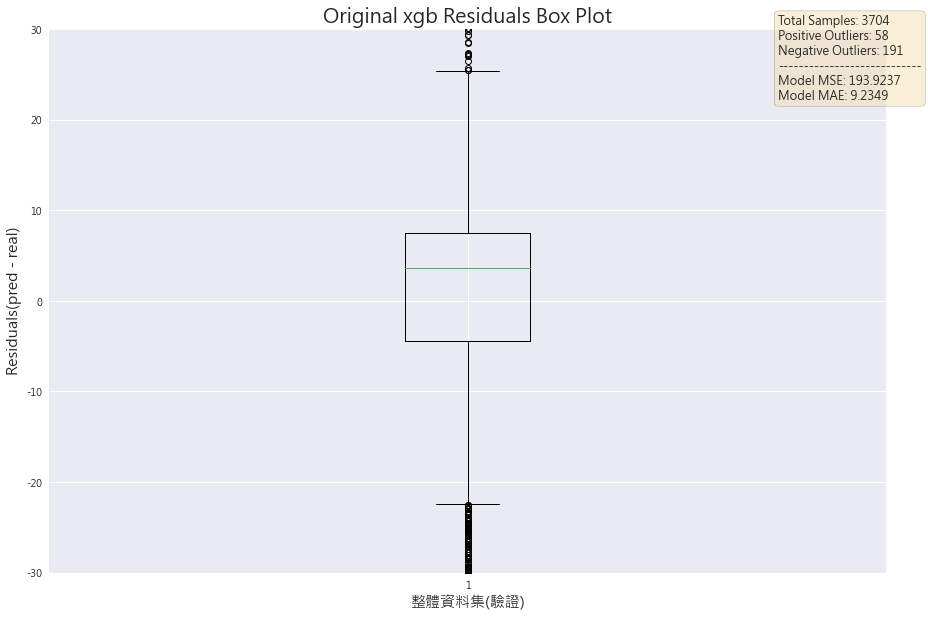

In [481]:
# get outlier
std_residuals = ori_residuals_df['Residuals'].std()
positive_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(ori_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-1.5, 1.5)
plt.title('Original xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('整體資料集(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {ori_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {ori_xgb_mse}\n"
    f"Model MAE: {ori_xgb_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

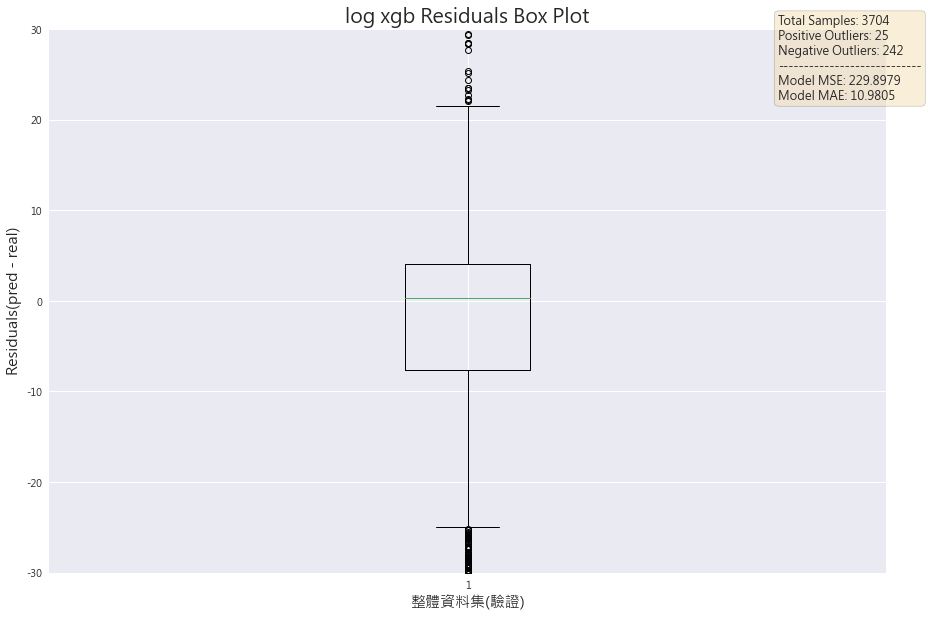

In [482]:
# get outlier
std_residuals = log_residuals_df['Residuals'].std()
positive_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(log_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-1.5, 1.5)
plt.title('log xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('整體資料集(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {log_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {log_xgb_mse}\n"
    f"Model MAE: {log_xgb_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

In [483]:
# show feature importance
feature_importances = log_xgb_model.feature_importances_
column_names = X.columns.tolist()
# use df to show
feature_importances_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

Feature  Importance
3           事故類型    0.433619
12          肇事車輛    0.201030
15   事故車是否包含非小客車    0.083767
7            中車道    0.069040
8           中外車道    0.036604
1             里程    0.026492
5            內車道    0.025173
10           外路肩    0.024341
9            外車道    0.019409
13         是否為假日    0.017330
0           國道名稱    0.016810
11            匝道    0.015547
2             方向    0.012513
14  相近時間&地點是否有事件    0.010314
6           中內車道    0.008010
4            內路肩    0.000000

In [484]:
file_name = "real_log_xgb_imp.xlsx"
feature_importances_df.to_excel(file_name, index=False)

#### qreg

In [485]:
# use median --> quantile==0.5
# set param
param_grid = {
    # set quantile
    'quantile': [0.5],
    # solver : 'highs', 'highs-ds', 'highs-ipm', 'highs-simplex'
    'solver': ['highs'],
    # alpha
    'alpha': [0, 0.0019, 0.002, 0.0025],
}

# set Quantile Regression model
qreg_model = QuantileRegressor()

# grid search
grid_search = GridSearchCV(estimator=qreg_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# fit
grid_search.fit(X_train_log, y_train_log)

# get best model
best_params = grid_search.best_params_
mid_qreg_model = grid_search.best_estimator_

# pred
y_pred = mid_qreg_model.predict(X_test_log)
y_pred = np.expm1(y_pred)

# evaluate
mid_qreg_mse = round(mean_squared_error(y_test, y_pred), 4)
mid_qreg_mae = round(mean_absolute_error(y_test, y_pred), 4)
#r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mid_qreg_mse}")
print(f"Mean Absolute Error: {mid_qreg_mae}")
#print(f"R-squared: {r2}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 245.2954
Mean Absolute Error: 9.6247
Best Parameters: {'alpha': 0.0019, 'quantile': 0.5, 'solver': 'highs'}


In [486]:
# use median --> quantile==all
# set param
param_grid = {
    # set quantile
    'quantile': [0.2,0.4 ,0.45, 0.5, 0.55, 0.6,0.8],
    # solver : 'highs', 'highs-ds', 'highs-ipm', 'highs-simplex'
    'solver': ['highs'],
    # alpha
    'alpha': [0, 0.0018, 0.002, 0.0025],
}

# set Quantile Regression model
qreg_model = QuantileRegressor()

# grid search
grid_search = GridSearchCV(estimator=qreg_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# fit
grid_search.fit(X_train_log, y_train_log)

# get best model
best_params = grid_search.best_params_
best_qreg_model = grid_search.best_estimator_

# pred
y_pred = best_qreg_model.predict(X_test_log)
y_pred = np.expm1(y_pred)

# evaluate
best_qreg_mse = round(mean_squared_error(y_test, y_pred), 4)
best_qreg_mae = round(mean_absolute_error(y_test, y_pred), 4)
#r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {best_qreg_mse}")
print(f"Mean Absolute Error: {best_qreg_mae}")
#print(f"R-squared: {r2}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 245.3732
Mean Absolute Error: 9.621
Best Parameters: {'alpha': 0.0018, 'quantile': 0.5, 'solver': 'highs'}


In [487]:
# pred
y_pred_mid = mid_qreg_model.predict(X)
y_pred_best = best_qreg_model.predict(X)

# caculate res
mid_log_residuals = np.expm1(y_pred_mid) - y
best_log_residuals = np.expm1(y_pred_best) - y

# save to df
mid_qreg_residuals_df = pd.DataFrame({'Residuals': mid_log_residuals})
best_qreg_residuals_df = pd.DataFrame({'Residuals': best_log_residuals})

# get total samples
mid_qreg_total_samples = mid_qreg_residuals_df.shape[0]
best_qreg_total_samples = best_qreg_residuals_df.shape[0]

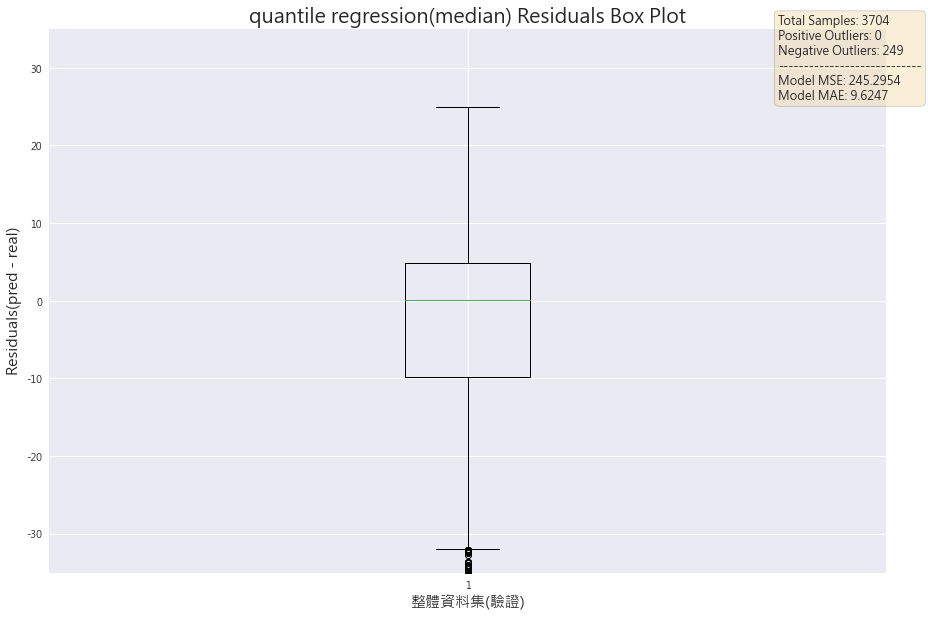

In [488]:
# get outlier
std_residuals = mid_qreg_residuals_df['Residuals'].std()
positive_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(mid_qreg_residuals_df['Residuals'])
plt.ylim(-35, 35)
# plt.ylim(-5, 2)
plt.title('quantile regression(median) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('整體資料集(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mid_qreg_mse}\n"
    f"Model MAE: {mid_qreg_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

In [489]:
best_params["quantile"]

0.5

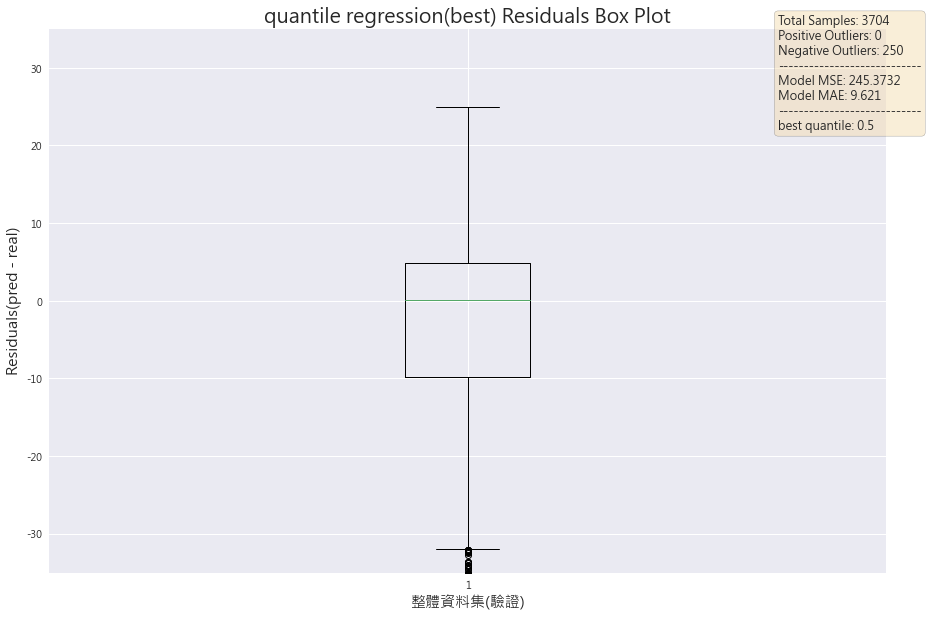

In [490]:
# get outlier
std_residuals = best_qreg_residuals_df['Residuals'].std()
positive_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(mid_qreg_residuals_df['Residuals'])
plt.ylim(-35, 35)
plt.title('quantile regression(best) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('整體資料集(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {best_qreg_mse}\n"
    f"Model MAE: {best_qreg_mae}\n"
    "----------------------------\n"
    f"best quantile: {best_params['quantile']}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

#### xgb+qreg

In [491]:
# set param
param_grid = {
    'alpha': [0],
    'colsample_bytree': [1.0],
    'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 0.05, 0.1, 0.5, 0.7],
    'lambda': [0.1, 0.3, 0.5, 1],
    'max_depth': [1, 2, 3],
    'min_child_weight': [1],
    'subsample': [1.0],
}

# fixed param
params_fixed = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'n_jobs': -1,
}

# change data tyoe into DMatrix
dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)

# evaluate
evals = [(dtest_log, 'eval')]

# save best result
best_mae = float("inf")
best_params = None

# grid search
for params in ParameterGrid(param_grid):
    # combine fixed & param
    current_params = {**params_fixed, **params}
    
    # train
    bst = xgb.train(
        params=current_params, 
        dtrain=dtrain_log, 
        num_boost_round=1000, 
        obj=quantile_loss_obj,
        custom_metric=custom_metric,
        early_stopping_rounds=50, 
        evals=evals, 
        verbose_eval=False
    )
    
    # predict
    y_pred_log = bst.predict(dtest_log)
    
    # mae
    mae = mean_absolute_error(y_test_log, y_pred_log)
    # save best model, use mae to define
    if mae < best_mae:
        best_mae = mae
        best_params = params

# show best para,
print(f"Best parameters found: {best_params}")

# use best param to train
xgb_qreg_best_model = xgb.train(
    params={**params_fixed, **best_params},
    dtrain=dtrain_log,
    num_boost_round=1000,
    obj=quantile_loss_obj,
    custom_metric=custom_metric,
    early_stopping_rounds=50,
    evals=evals,
    verbose_eval=True
)


Best parameters found: {'alpha': 0, 'colsample_bytree': 1.0, 'eta': 0.7, 'gamma': 0.5, 'lambda': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
[0]	eval-mae:1.63937	eval-quantile_loss:0.81968
[1]	eval-mae:1.31323	eval-quantile_loss:0.65662
[2]	eval-mae:1.04540	eval-quantile_loss:0.52270
[3]	eval-mae:0.85603	eval-quantile_loss:0.42802
[4]	eval-mae:0.73427	eval-quantile_loss:0.36713
[5]	eval-mae:0.65768	eval-quantile_loss:0.32884
[6]	eval-mae:0.60334	eval-quantile_loss:0.30167
[7]	eval-mae:0.57043	eval-quantile_loss:0.28521
[8]	eval-mae:0.55157	eval-quantile_loss:0.27579
[9]	eval-mae:0.54504	eval-quantile_loss:0.27252
[10]	eval-mae:0.54178	eval-quantile_loss:0.27089
[11]	eval-mae:0.53986	eval-quantile_loss:0.26993
[12]	eval-mae:0.54000	eval-quantile_loss:0.27000
[13]	eval-mae:0.54089	eval-quantile_loss:0.27045
[14]	eval-mae:0.53966	eval-quantile_loss:0.26983
[15]	eval-mae:0.53882	eval-quantile_loss:0.26941
[16]	eval-mae:0.53774	eval-quantile_loss:0.26887
[17]	eval-mae:0.53

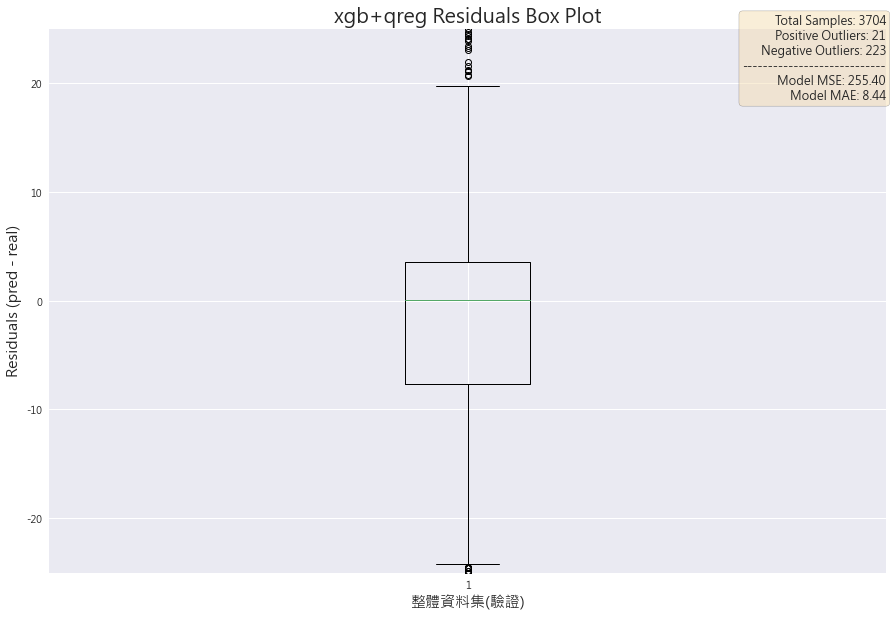

In [492]:
# change data type into DMatrix
dall = xgb.DMatrix(X)

# use best model
y_all_pred_log = xgb_qreg_best_model.predict(dall)
y_all_pred = np.expm1(y_all_pred_log)

# count res and build df
residuals = y_all_pred - y
residuals_df = pd.DataFrame({'Residuals': residuals})

# count samples & std
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()

# count outlier
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]

# count mse & mae
mse = mean_squared_error(y, y_all_pred)
mae = mean_absolute_error(y, y_all_pred)

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
plt.ylim(-25, 25)
# plt.ylim(-1, 1)
plt.title('xgb+qreg Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('整體資料集(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# show
plt.show()

#### 分割國道1號

In [1106]:
# change str into datetime
def str_to_time(time_str):
    # 判斷時間格式，如果只有小時和分鐘，則添加秒數
    if len(time_str.split(':')) == 2:
        time_str += ":00"
    return datetime.strptime(time_str, "%H:%M:%S")

# change time into sec
def time_to_seconds(time_val):
    return time_val.hour * 3600 + time_val.minute * 60 + time_val.second

# Convert seconds to 6-hour intervals format
def format_seconds(x, pos):
    hours = int(x / 3600)
    # Round to the nearest 6-hour interval
    rounded_hours = 6 * round(hours / 6)
    return f"{rounded_hours:02d}:00:00"

# def func to change sec into 24hr type
def format_time_label(time_interval):
    try:
        # get start time & end time
        start_str, end_str = time_interval.split('-')
        start_hour = int(start_str.split(':')[0])
        end_hour = int(end_str.split(':')[0])
        # change into 24hr type
        return f"{start_hour:02d}:00-{end_hour:02d}:00"
    except (IndexError, ValueError) as e:
        print(f"Error formatting time interval '{time_interval}': {e}")
        return time_interval

# "國道1號"
real_df_highway_1 = real_sorted_df[real_sorted_df['國道名稱'] == '國道1號']
# variable
real_df_highway_1 = real_df_highway_1[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]

# change str into datetime to calculate
real_df_highway_1['事件發生'] = real_df_highway_1['事件發生'].apply(str_to_time)
real_df_highway_1['事件排除'] = real_df_highway_1['事件排除'].apply(str_to_time)

# check
real_df_highway_1

國道名稱 方向     里程                事件發生                事件排除  處理分鐘
0     國道1號  北  155.8 1900-01-01 00:22:00 1900-01-01 00:30:00     8
1     國道1號  南  268.9 1900-01-01 01:37:00 1900-01-01 02:00:00    23
2     國道1號  北  117.9 1900-01-01 02:01:00 1900-01-01 02:02:00     1
3     國道1號  南   66.5 1900-01-01 02:31:00 1900-01-01 03:12:00    41
5     國道1號  南  308.5 1900-01-01 05:08:00 1900-01-01 06:14:00    66
...    ... ..    ...                 ...                 ...   ...
3698  國道1號  南   49.0 1900-01-01 18:29:00 1900-01-01 18:48:00    19
3699  國道1號  南  198.4 1900-01-01 18:45:00 1900-01-01 18:47:00     2
3701  國道1號  南   95.0 1900-01-01 18:49:00 1900-01-01 18:55:00     6
3702  國道1號  南  109.5 1900-01-01 19:08:00 1900-01-01 19:10:00     2
3703  國道1號  南  294.8 1900-01-01 23:17:00 1900-01-01 01:20:00   123

[2299 rows x 6 columns]

In [1107]:
# save "事件發生" sec to new col "事件發生(秒數)"
real_df_highway_1['事件發生(秒數)'] = real_df_highway_1['事件發生'].apply(time_to_seconds)

# save "事件排除" sec to new col "事件排除(秒數)"
real_df_highway_1['事件排除(秒數)'] = real_df_highway_1['事件排除'].apply(time_to_seconds)

# save "處理分鐘" sec to new col "處理分鐘(秒數)"
real_df_highway_1['處理分鐘(秒數)'] = real_df_highway_1['處理分鐘'] * 60

# take "北"向的
real_df_north_direction = real_df_highway_1[real_df_highway_1['方向'] == '北']
real_df_north_direction

# take "南"向的
real_df_south_direction = real_df_highway_1[real_df_highway_1['方向'] == '南']
real_df_south_direction

國道名稱 方向     里程                事件發生                事件排除  處理分鐘  事件發生(秒數)  \
1     國道1號  南  268.9 1900-01-01 01:37:00 1900-01-01 02:00:00    23      5820   
3     國道1號  南   66.5 1900-01-01 02:31:00 1900-01-01 03:12:00    41      9060   
5     國道1號  南  308.5 1900-01-01 05:08:00 1900-01-01 06:14:00    66     18480   
9     國道1號  南   43.5 1900-01-01 08:51:00 1900-01-01 09:19:00    28     31860   
13    國道1號  南  327.4 1900-01-01 10:58:00 1900-01-01 11:03:00     5     39480   
...    ... ..    ...                 ...                 ...   ...       ...   
3698  國道1號  南   49.0 1900-01-01 18:29:00 1900-01-01 18:48:00    19     66540   
3699  國道1號  南  198.4 1900-01-01 18:45:00 1900-01-01 18:47:00     2     67500   
3701  國道1號  南   95.0 1900-01-01 18:49:00 1900-01-01 18:55:00     6     67740   
3702  國道1號  南  109.5 1900-01-01 19:08:00 1900-01-01 19:10:00     2     68880   
3703  國道1號  南  294.8 1900-01-01 23:17:00 1900-01-01 01:20:00   123     83820   

      事件排除(秒數)  處理分鐘(秒數)  
1         7200      1380  
3        11520      2460  
5        22440      3960  
9        33540      1680  
13       39780       300  
...        ...       ...  
3698     67680      1140  
3699     67620       120  
3701     68100       360  
3702     69000       120  
3703      4800      7380  

[1150 rows x 9 columns]

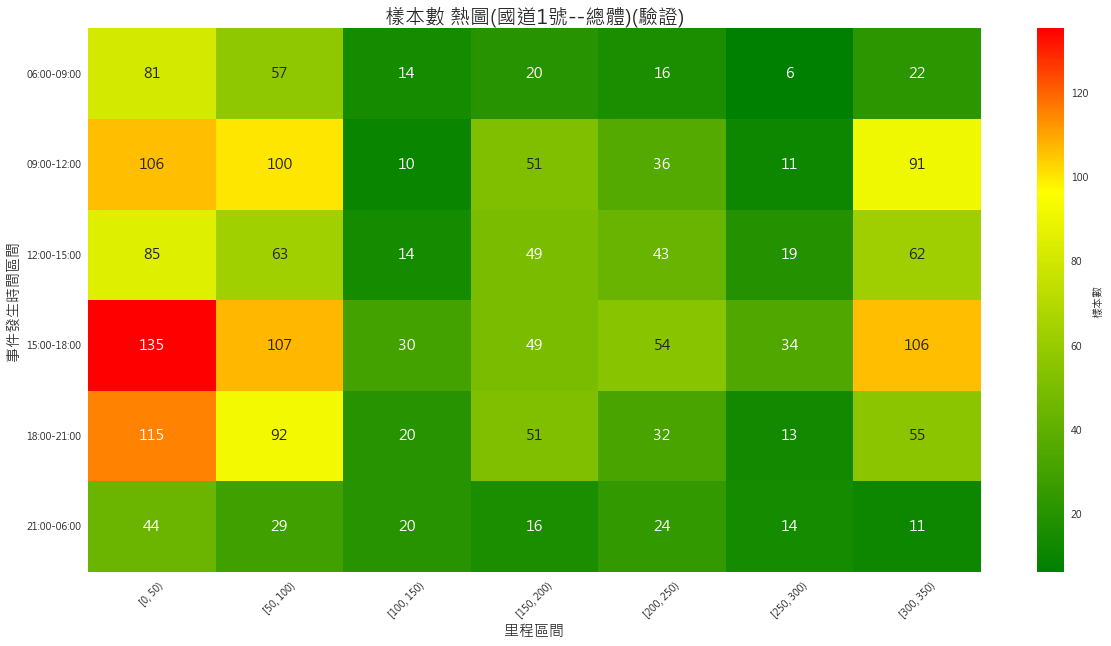

In [1108]:
# set time & mile interval
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(real_df_highway_1['里程'].min(), real_df_highway_1['里程'].max() + 1, mile_block, dtype=int)

# add new row to cut
real_df_highway_1['事件發生時間區間'] = pd.cut(real_df_highway_1['事件發生(秒數)'], bins=time_bins, right=False)
real_df_highway_1['里程區間'] = pd.cut(real_df_highway_1['里程'], bins=mile_bins, right=False)

# count sample
sample_counts = real_df_highway_1.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].apply(merge_time_intervals)

# del repeat row and sum sample
sample_counts = sample_counts.groupby(['事件發生時間區間', '里程區間'], as_index=False).sum()

# pivot table
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# reset index
pivot_table.index = pivot_table.index.map(format_time_label)

# adjust
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.7, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道1號--總體)(驗證)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [1109]:
# def time interval
time_intervals = [
    (6 * 3600, 9 * 3600),    # 06:00-09:00
    (9 * 3600, 12 * 3600),   # 09:00-12:00
    (12 * 3600, 15 * 3600),  # 12:00-15:00
    (15 * 3600, 18 * 3600),  # 15:00-18:00
    (18 * 3600, 21 * 3600),   # 18:00-21:00
    (21 * 3600, 6 * 3600),  # 21:00-06:00
]
# def mile interval with every 50km
mile_interval_size = 50
mile_intervals = [(0, 50), (50, 100), (100, 150), (150, 200),
                  (200, 250), (250, 300), (300, 350)]

# init result saving
result_indices = {}

# mile interval
mile_intervals = 7
mile_interval_size = 50

# save
for time_idx, (time_start, time_end) in enumerate(time_intervals):
    for mile_idx in range(mile_intervals):
        mile_start = mile_idx * mile_interval_size
        mile_end = (mile_idx + 1) * mile_interval_size
        # for 21:00~06:00 doing special case
        if time_start > time_end:
            filtered_data = real_df_highway_1[
                ((real_df_highway_1['事件發生(秒數)'] >= time_start) | (real_df_highway_1['事件發生(秒數)'] < time_end)) &
                (real_df_highway_1['里程'] >= mile_start) & (
                    real_df_highway_1['里程'] < mile_end)
            ]
        else:
            filtered_data = real_df_highway_1[
                (real_df_highway_1['事件發生(秒數)'] >= time_start) & (real_df_highway_1['事件發生(秒數)'] < time_end) &
                (real_df_highway_1['里程'] >= mile_start) & (
                    real_df_highway_1['里程'] < mile_end)
            ]

        # save
        result_indices[(time_idx, mile_idx)] = filtered_data.index.tolist()

# result
for (time_idx, mile_idx), indices in result_indices.items():
    print(f"格子 [時間區間: {time_idx}, 里程區間: {mile_idx}] 共有 {len(indices)} 筆資料。")

格子 [時間區間: 0, 里程區間: 0] 共有 81 筆資料。
格子 [時間區間: 0, 里程區間: 1] 共有 57 筆資料。
格子 [時間區間: 0, 里程區間: 2] 共有 14 筆資料。
格子 [時間區間: 0, 里程區間: 3] 共有 20 筆資料。
格子 [時間區間: 0, 里程區間: 4] 共有 16 筆資料。
格子 [時間區間: 0, 里程區間: 5] 共有 6 筆資料。
格子 [時間區間: 0, 里程區間: 6] 共有 22 筆資料。
格子 [時間區間: 1, 里程區間: 0] 共有 106 筆資料。
格子 [時間區間: 1, 里程區間: 1] 共有 100 筆資料。
格子 [時間區間: 1, 里程區間: 2] 共有 10 筆資料。
格子 [時間區間: 1, 里程區間: 3] 共有 51 筆資料。
格子 [時間區間: 1, 里程區間: 4] 共有 36 筆資料。
格子 [時間區間: 1, 里程區間: 5] 共有 11 筆資料。
格子 [時間區間: 1, 里程區間: 6] 共有 91 筆資料。
格子 [時間區間: 2, 里程區間: 0] 共有 85 筆資料。
格子 [時間區間: 2, 里程區間: 1] 共有 63 筆資料。
格子 [時間區間: 2, 里程區間: 2] 共有 14 筆資料。
格子 [時間區間: 2, 里程區間: 3] 共有 49 筆資料。
格子 [時間區間: 2, 里程區間: 4] 共有 43 筆資料。
格子 [時間區間: 2, 里程區間: 5] 共有 19 筆資料。
格子 [時間區間: 2, 里程區間: 6] 共有 62 筆資料。
格子 [時間區間: 3, 里程區間: 0] 共有 135 筆資料。
格子 [時間區間: 3, 里程區間: 1] 共有 107 筆資料。
格子 [時間區間: 3, 里程區間: 2] 共有 30 筆資料。
格子 [時間區間: 3, 里程區間: 3] 共有 49 筆資料。
格子 [時間區間: 3, 里程區間: 4] 共有 54 筆資料。
格子 [時間區間: 3, 里程區間: 5] 共有 34 筆資料。
格子 [時間區間: 3, 里程區間: 6] 共有 106 筆資料。
格子 [時間區間: 4, 里程區間: 0] 共有 115 筆資料。
格子 [時間區間: 4, 里程區間: 1] 共有 92 筆資料。
格子 [時

In [1110]:
# filter
indices_to_use = result_indices[(0, 0)]
filtered_df = real_sorted_df.loc[indices_to_use]
filtered_df

年  月   日  時   分  國道名稱 方向    里程   事件發生   事件排除  ...  車輛起火註記 冒煙車事故註記  \
9     2024  1   1  8  51  國道1號  南  43.5  08:51  09:19  ...     NaN     NaN   
95    2024  1   2  8   4  國道1號  北  42.7  08:04  08:08  ...     NaN     NaN   
163   2024  1   4  7  34  國道1號  南  10.0  07:34  07:55  ...     NaN     NaN   
207   2024  1   5  7  28  國道1號  北  33.0  07:28  07:38  ...     NaN     NaN   
209   2024  1   5  8  25  國道1號  南  49.0  08:25  08:31  ...     NaN     NaN   
...    ... ..  .. ..  ..   ... ..   ...    ...    ...  ...     ...     ...   
3553  2024  2  26  8  37  國道1號  北  11.0  08:37  08:42  ...     NaN     NaN   
3582  2024  2  27  7   1  國道1號  北  30.1  07:01  07:08  ...     NaN     NaN   
3586  2024  2  27  8  21  國道1號  北  41.0  08:21  08:24  ...     NaN     NaN   
3652  2024  2  29  7  40  國道1號  北  49.0  07:40  07:42  ...     NaN     NaN   
3653  2024  2  29  7  46  國道1號  北  29.7  07:46  08:05  ...     NaN     NaN   

      主線中斷註記  肇事車輛  回堵長度 事故車是否包含非小客車  是否為假日  是否為相近時間  是否為相近地點  相近時間&地點是否有事件  
9        NaN     1     0           0      1        0        0             0  
95       NaN     2     1           0      0        0        0             0  
163      NaN     2     0           0      0        0        0             0  
207      NaN     2     0           0      0        0        0             0  
209      NaN     2     0           1      0        0        0             0  
...      ...   ...   ...         ...    ...      ...      ...           ...  
3553     NaN     2     0           0      0        0        0             0  
3582     NaN     2     1           0      0        0        0             0  
3586     NaN     2     1           0      0        0        0             0  
3652     NaN     2     0           0      0        0        0             0  
3653     NaN     3     0           0      0        0        0             0  

[81 rows x 36 columns]

In [1111]:
# preprocess
# keep specific & target var
## '國道名稱'、"回堵長度"、"處理分鐘"
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
                     '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
selected_df = filtered_df[selected_features].copy()
selected_df.dropna(subset=['里程'], inplace=True)

# specify the var to process
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# fill NA to 0
selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

# if >1 --> ==1
# selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

# label encoding for cate var
# 指定 "事故類型" 的編碼
accident_type_mapping = {'A2': 1, 'A3': 2}
selected_df['事故類型'] = selected_df['事故類型'].map(accident_type_mapping).fillna(-1).astype(int)

label_encoders = {}
categorical_features = [
    '方向', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    selected_df[feature] = label_encoders[feature].fit_transform(
        selected_df[feature].astype(str))

# fill NA to 0
# selected_df['死亡'].fillna(0, inplace=True)
# selected_df['受傷'].fillna(0, inplace=True)
selected_df['肇事車輛'].fillna(0, inplace=True)

# split specific & target var
X = selected_df.drop(columns=['回堵長度'])
y = selected_df['回堵長度']
y_log = np.log1p(y)

# split train & test
# y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# y_log
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42)

#### model 分割後的資料

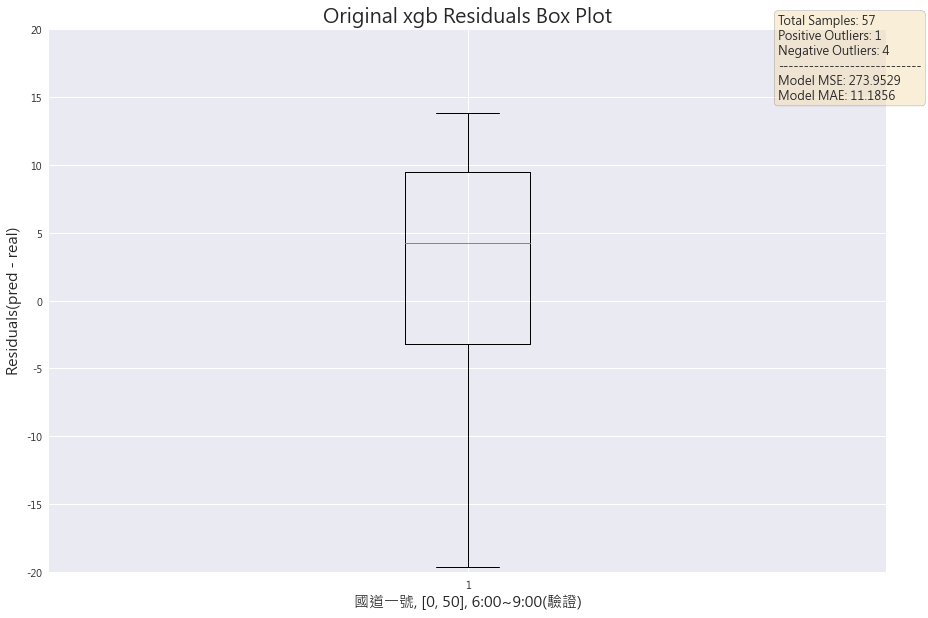

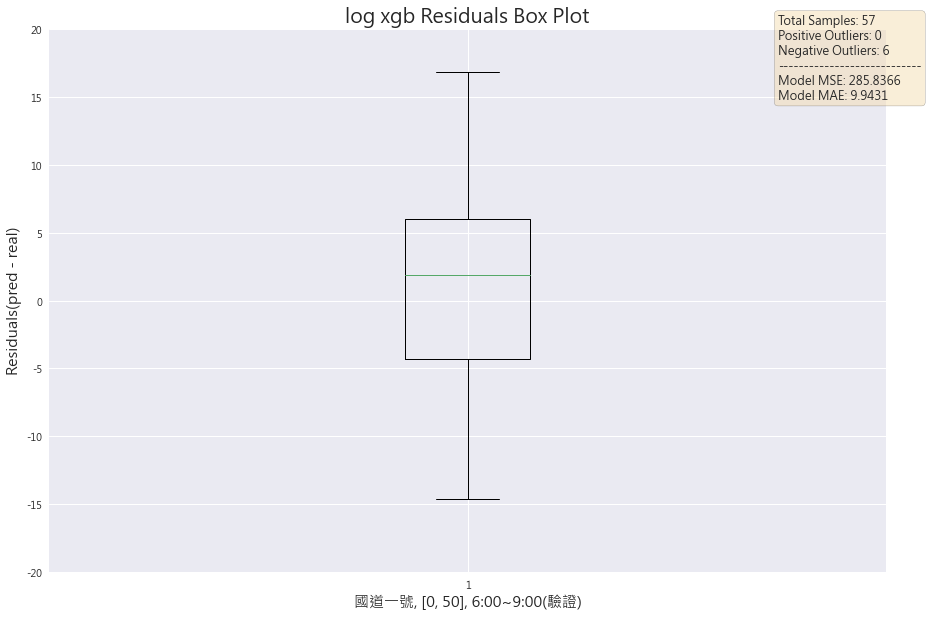

In [850]:
# pred
y_pred_ori = ori_xgb_model.predict(X)
y_pred_log = log_xgb_model.predict(X)

# caculate res
ori_residuals = y_pred_ori - y
log_residuals = np.expm1(y_pred_log) - y

# count mse mae
ori_xgb_mse = mean_squared_error(y, y_pred_ori)
ori_xgb_mae = mean_absolute_error(y, y_pred_ori)
log_xgb_mse = mean_squared_error(y, np.expm1(y_pred_log))
log_xgb_mae = mean_absolute_error(y, np.expm1(y_pred_log))

# save to df
ori_residuals_df = pd.DataFrame({'Residuals': ori_residuals})
log_residuals_df = pd.DataFrame({'Residuals': log_residuals})

# get total samples
ori_total_samples = ori_residuals_df.shape[0]
log_total_samples = log_residuals_df.shape[0]

# get outlier
std_residuals = ori_residuals_df['Residuals'].std()
positive_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(ori_residuals_df['Residuals'])
# plt.ylim(-30, 30)
plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('Original xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {ori_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {ori_xgb_mse:.4f}\n"
    f"Model MAE: {ori_xgb_mae:.4f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

# get outlier
std_residuals = log_residuals_df['Residuals'].std()
positive_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(log_residuals_df['Residuals'])
# plt.ylim(-30, 30)
plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('log xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {log_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {log_xgb_mse:.4f}\n"
    f"Model MAE: {log_xgb_mae:.4f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

In [706]:
# # 使用原始模型和對數模型進行預測
# y_pred_ori = ori_xgb_model.predict(X)
# y_pred_log = log_xgb_model.predict(X)

# # 計算殘差
# ori_residuals = abs(y_pred_ori - y)
# log_residuals = abs(np.expm1(y_pred_log) - y)

# # 將預測值和殘差保存到 DataFrame 中
# result_df = selected_df.copy()
# result_df['實際值'] = y
# result_df['原始模型預測值'] = y_pred_ori
# result_df['對數模型預測值'] = np.expm1(y_pred_log)
# result_df['原始模型殘差'] = ori_residuals
# result_df['對數模型殘差'] = log_residuals

# # 根據 "原始模型殘差" 進行升序排序
# result_df_sorted = result_df.sort_values(by='原始模型殘差', ascending=True)

# # 顯示排序後的結果
# result_df_sorted



里程  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  ...  肇事車輛  處理分鐘  \
809    8.5   1     1    0    1     0    0     0    1    0  ...     6    35   
1832  43.3   0     2    0    0     0    0     0    1    0  ...     2    11   
3200  39.2   1     2    0    1     0    1     0    0    0  ...     2    10   
927   41.0   0     2    0    0     0    0     0    0    0  ...     2    10   
2036  42.7   0     2    0    0     0    0     0    1    0  ...     4    20   
...    ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ...   ...   ...   
3288  36.0   0     2    0    1     0    0     0    0    0  ...     2    28   
3283  29.0   0     2    0    0     0    0     0    1    0  ...     3    33   
1391  34.6   1     1    0    1     1    0     0    0    0  ...     3    25   
2379  41.0   1     2    0    0     0    0     0    0    0  ...     1    13   
1197  31.5   1     2    0    0     0    0     1    1    0  ...     3    59   

      是否為假日  相近時間&地點是否有事件  事故車是否包含非小客車  實際值    原始模型預測值    對數模型預測值     原始模型殘差  \
809       0             0            0   35  34.934574  33.246346   0.065426   
1832      0             0            0   11  10.927444   8.580217   0.072556   
3200      0             0            0   10  10.148759   8.553370   0.148759   
927       0             0            0   10  10.148759   8.553370   0.148759   
2036      0             0            0   20  20.321238  20.061630   0.321238   
...     ...           ...          ...  ...        ...        ...        ...   
3288      0             0            0   28   9.436743   8.252370  18.563257   
3283      0             0            0   33  14.301875  11.405127  18.698125   
1391      0             0            0   25  46.150322  31.601120  21.150322   
2379      1             0            0   13  45.023670  25.620340  32.023670   
1197      0             0            0   59  14.301875  11.022713  44.698125   

         對數模型殘差  
809    1.753654  
1832   2.419783  
3200   1.446630  
927    1.446630  
2036   0.061630  
...         ...  
3288  19.747630  
3283  21.594873  
1391   6.601120  
2379  12.620340  
1197  47.977287  

[81 rows x 21 columns]

In [707]:
# # save
# result_df_sorted.to_excel('r1_0609_50km_xgb_result.xlsx', index=False)

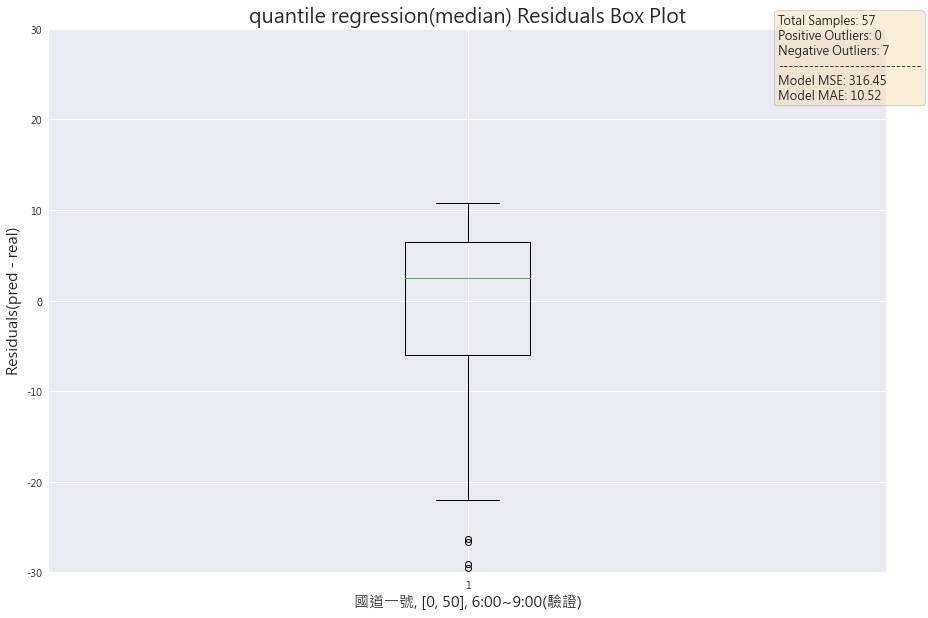

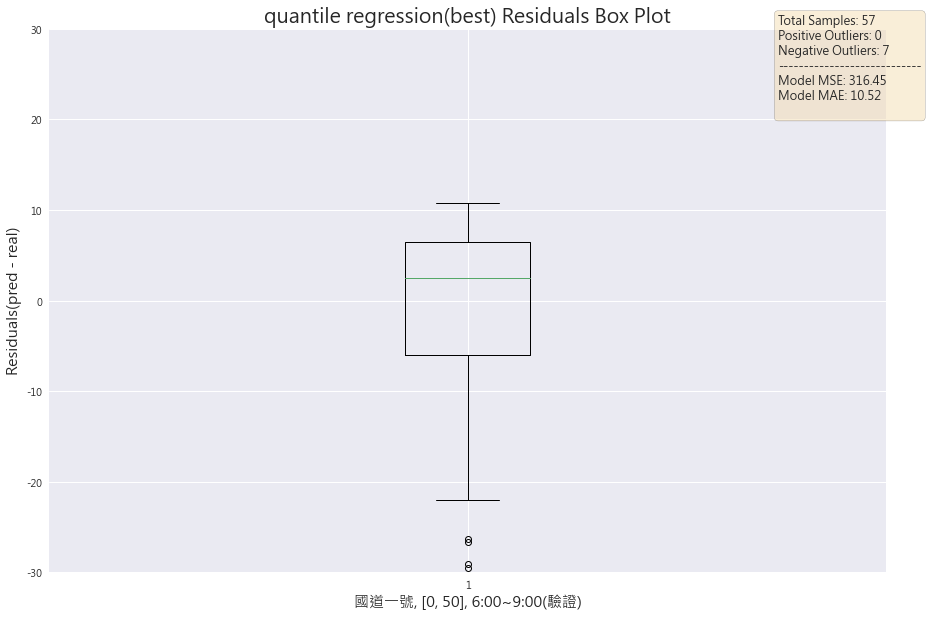

In [852]:
# pred
y_pred_mid = mid_qreg_model.predict(X)
y_pred_best = best_qreg_model.predict(X)

# caculate res
mid_log_residuals = np.expm1(y_pred_mid) - y
best_log_residuals = np.expm1(y_pred_best) - y

# count mse mae
mid_qreg_mse = mean_squared_error(y, np.expm1(y_pred_mid))
mid_qreg_mae = mean_absolute_error(y, np.expm1(y_pred_mid))
best_qreg_mse = mean_squared_error(y, np.expm1(y_pred_best))
best_qreg_mae = mean_absolute_error(y, np.expm1(y_pred_best))

# save to df
mid_qreg_residuals_df = pd.DataFrame({'Residuals': mid_log_residuals})
best_qreg_residuals_df = pd.DataFrame({'Residuals': best_log_residuals})

# get total samples
mid_qreg_total_samples = mid_qreg_residuals_df.shape[0]
best_qreg_total_samples = best_qreg_residuals_df.shape[0]

# get outlier
std_residuals = mid_qreg_residuals_df['Residuals'].std()
positive_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(mid_qreg_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('quantile regression(median) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mid_qreg_mse:.2f}\n"
    f"Model MAE: {mid_qreg_mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

# get outlier
std_residuals = best_qreg_residuals_df['Residuals'].std()
positive_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(mid_qreg_residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('quantile regression(best) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {best_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {best_qreg_mse:.2f}\n"
    f"Model MAE: {best_qreg_mae:.2f}\n"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

In [724]:
# # 使用原始模型和對數模型進行預測
# y_pred_mid = mid_qreg_model.predict(X)
# y_pred_best = best_qreg_model.predict(X)

# # 計算殘差
# mid_log_residuals = abs(np.expm1(y_pred_mid) - y)
# best_log_residuals = abs(np.expm1(y_pred_best) - y)

# # 將預測值和殘差保存到 DataFrame 中
# result_df = selected_df.copy()
# result_df['實際值'] = y
# result_df['qreg median 預測值'] = np.expm1(y_pred_mid)
# result_df['qreg best 預測值'] = np.expm1(y_pred_best)
# result_df['qreg median 殘差'] = mid_log_residuals
# result_df['qreg best 殘差'] = best_log_residuals

# # 根據 "原始模型殘差" 進行升序排序
# result_df_sorted = result_df.sort_values(by='qreg median 殘差', ascending=True)

# # 顯示排序後的結果
# result_df_sorted



里程  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  ...  肇事車輛  處理分鐘  \
1611  33.7   0     2    0    0     0    0     1    0    0  ...     2     7   
3329  27.0   0     2    0    0     0    0     0    0    0  ...     2     8   
3549  43.8   0     2    0    0     0    0     1    0    0  ...     2     7   
2292  30.0   1     2    0    0     0    0     0    0    1  ...     2     8   
2098  19.7   0     2    0    0     0    0     0    1    0  ...     2     9   
...    ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ...   ...   ...   
3288  36.0   0     2    0    1     0    0     0    0    0  ...     2    28   
3283  29.0   0     2    0    0     0    0     0    1    0  ...     3    33   
9     43.5   1     2    0    1     0    0     0    0    0  ...     1    28   
1197  31.5   1     2    0    0     0    0     1    1    0  ...     3    59   
809    8.5   1     1    0    1     0    0     0    1    0  ...     6    35   

      是否為假日  相近時間&地點是否有事件  事故車是否包含非小客車  實際值  qreg median 預測值  qreg best 預測值  \
1611      0             0            0    7         6.975852       6.975852   
3329      0             0            0    8         8.065861       8.065861   
3549      0             0            0    7         7.286147       7.286147   
2292      0             0            1    8         7.677124       7.677124   
2098      0             0            0    9         8.522579       8.522579   
...     ...           ...          ...  ...              ...            ...   
3288      0             0            0   28         7.675633       7.675633   
3283      0             0            0   33        12.303704      12.303704   
9         1             0            0   28         6.040304       6.040304   
1197      0             0            0   59        11.454491      11.454491   
809       0             0            0   35       104.711046     104.711046   

      qreg median 殘差  qreg best 殘差  
1611        0.024148      0.024148  
3329        0.065861      0.065861  
3549        0.286147      0.286147  
2292        0.322876      0.322876  
2098        0.477421      0.477421  
...              ...           ...  
3288       20.324367     20.324367  
3283       20.696296     20.696296  
9          21.959696     21.959696  
1197       47.545509     47.545509  
809        69.711046     69.711046  

[81 rows x 21 columns]

In [725]:
# # save
# result_df_sorted.to_excel('r1_0609_50km_qreg_result.xlsx', index=False)

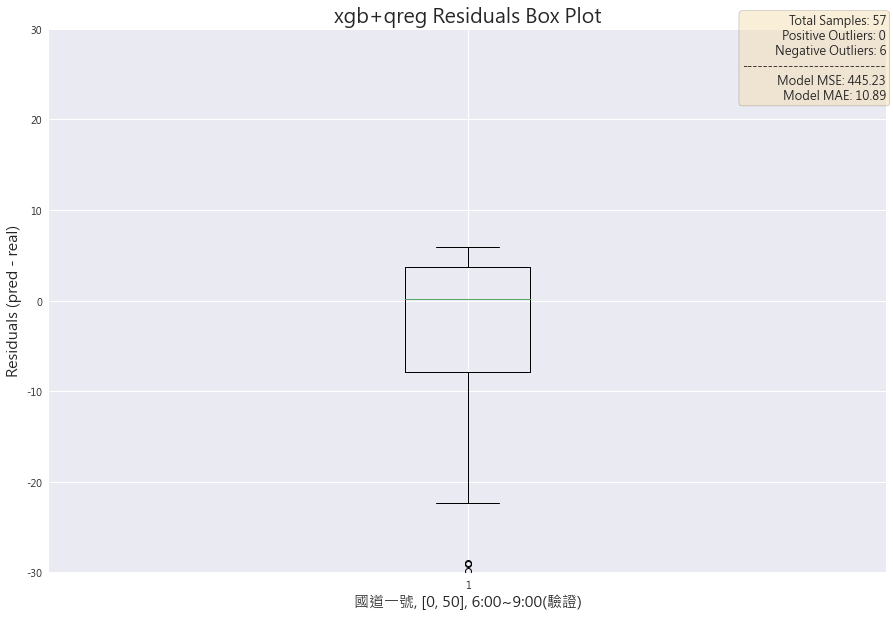

In [854]:
# change data type into DMatrix
dall = xgb.DMatrix(X)

# use best model
y_all_pred_log = xgb_qreg_best_model.predict(dall)
y_all_pred = np.expm1(y_all_pred_log)

# count res and build df
residuals = y_all_pred - y
residuals_df = pd.DataFrame({'Residuals': residuals})

# count samples & std
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()

# count outlier
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]

# count mse & mae
mse = mean_squared_error(y, y_all_pred)
mae = mean_absolute_error(y, y_all_pred)

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
plt.ylim(-30, 30)
# plt.ylim(-20, 20)
# plt.ylim(-5, 5)
plt.title('xgb+qreg Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00(驗證)', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# show
plt.show()

In [727]:
# # change data type into DMatrix
# dall = xgb.DMatrix(X)

# # use best model
# y_all_pred_log = xgb_qreg_best_model.predict(dall)
# y_all_pred = np.expm1(y_all_pred_log)

# # count res and build df
# residuals = y_all_pred - y
# residuals_df = pd.DataFrame({'Residuals': residuals})

In [728]:
# # change data type into DMatrix
# dall = xgb.DMatrix(X)

# # 使用原始模型和對數模型進行預測
# y_all_pred_log = xgb_qreg_best_model.predict(dall)
# y_all_pred = np.expm1(y_all_pred_log)

# # 計算殘差
# mid_log_residuals = abs(y_all_pred - y)

# # 將預測值和殘差保存到 DataFrame 中
# result_df = selected_df.copy()
# result_df['實際值'] = y
# result_df['xgb+qreg 預測值'] = y_all_pred
# result_df['xgb+qreg 殘差'] = mid_log_residuals

# # 根據 "原始模型殘差" 進行升序排序
# result_df_sorted = result_df.sort_values(by='xgb+qreg 殘差', ascending=True)

# # 顯示排序後的結果
# result_df_sorted



里程  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  匝道  肇事車輛  處理分鐘  \
3329  27.0   0     2    0    0     0    0     0    0    0   1     2     8   
3202  21.5   0     2    0    0     0    0     0    1    0   0     3    11   
3028   9.5   1     2    0    1     0    0     0    0    0   0     3    15   
1611  33.7   0     2    0    0     0    0     1    0    0   0     2     7   
3549  43.8   0     2    0    0     0    0     1    0    0   0     2     7   
...    ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ..   ...   ...   
1277  39.6   1     2    0    1     0    0     0    0    0   0     2    27   
3288  36.0   0     2    0    1     0    0     0    0    0   0     2    28   
3283  29.0   0     2    0    0     0    0     0    1    0   0     3    33   
809    8.5   1     1    0    1     0    0     0    1    0   0     6    35   
1197  31.5   1     2    0    0     0    0     1    1    0   0     3    59   

      是否為假日  相近時間&地點是否有事件  事故車是否包含非小客車  實際值  xgb+qreg 預測值  xgb+qreg 殘差  
3329      0             0            0    8      7.755117     0.244883  
3202      0             0            0   11     11.290185     0.290185  
3028      1             0            0   15     14.689327     0.310673  
1611      0             0            0    7      7.564980     0.564980  
3549      0             0            0    7      7.642687     0.642687  
...     ...           ...          ...  ...           ...          ...  
1277      0             0            0   27      8.900170    18.099830  
3288      0             0            0   28      7.517621    20.482379  
3283      0             0            0   33     11.457762    21.542238  
809       0             0            0   35     68.177933    33.177933  
1197      0             0            0   59     12.550205    46.449795  

[81 rows x 19 columns]

In [729]:
# # save
# result_df_sorted.to_excel('r1_0609_50km_xgbqreg_result.xlsx', index=False)

### 國道2號

In [175]:
# "國道2號"
df_highway_2 = sorted_df[sorted_df['國道名稱'] == '國道2號']
# variable
df_highway_2 = df_highway_2[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_2


國道名稱 方向    里程      事件發生      事件排除  處理分鐘
5091   國道2號  東  16.2  09:02:00  09:36:00    34
5118   國道2號  西   4.0  11:21:00  11:51:00    30
5134   國道2號  東  19.6  07:18:00  07:46:00    28
5153   國道2號  東  11.0  16:39:00  16:46:00     7
5167   國道2號  東  17.6  07:42:00  07:52:00    10
...     ... ..   ...       ...       ...   ...
15496  國道2號  東  19.0  09:16:00  09:36:00    20
15747  國道2號  西   4.0  12:48:00  13:12:00    24
16266  國道2號  西   4.0  18:37:00  18:52:00    15
16265  國道2號  西  12.2  18:49:00  18:50:00     1
16273  國道2號  東   4.8  18:33:00  18:56:00    23

[1072 rows x 6 columns]

In [176]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_2['事件發生(秒數)'] = df_highway_2['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_2['事件排除(秒數)'] = df_highway_2['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_2['處理分鐘(秒數)'] = df_highway_2['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_2[df_highway_2['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_2[df_highway_2['方向'] == '西']
df_west_direction

國道名稱 方向    里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
5118   國道2號  西   4.0  11:21:00  11:51:00    30     40860     42660      1800
5170   國道2號  西  10.3  08:35:00  09:14:00    39     30900     33240      2340
5190   國道2號  西  11.0  16:58:00  17:00:00     2     61080     61200       120
5221   國道2號  西   1.0  09:48:00  10:12:00    24     35280     36720      1440
9570   國道2號  西  10.8  10:19:00  10:25:00     6     37140     37500       360
...     ... ..   ...       ...       ...   ...       ...       ...       ...
14688  國道2號  西   5.8  16:32:00  16:36:00     4     59520     59760       240
14987  國道2號  西  10.5  16:10:00  16:16:00     6     58200     58560       360
15747  國道2號  西   4.0  12:48:00  13:12:00    24     46080     47520      1440
16266  國道2號  西   4.0  18:37:00  18:52:00    15     67020     67920       900
16265  國道2號  西  12.2  18:49:00  18:50:00     1     67740     67800        60

[604 rows x 9 columns]

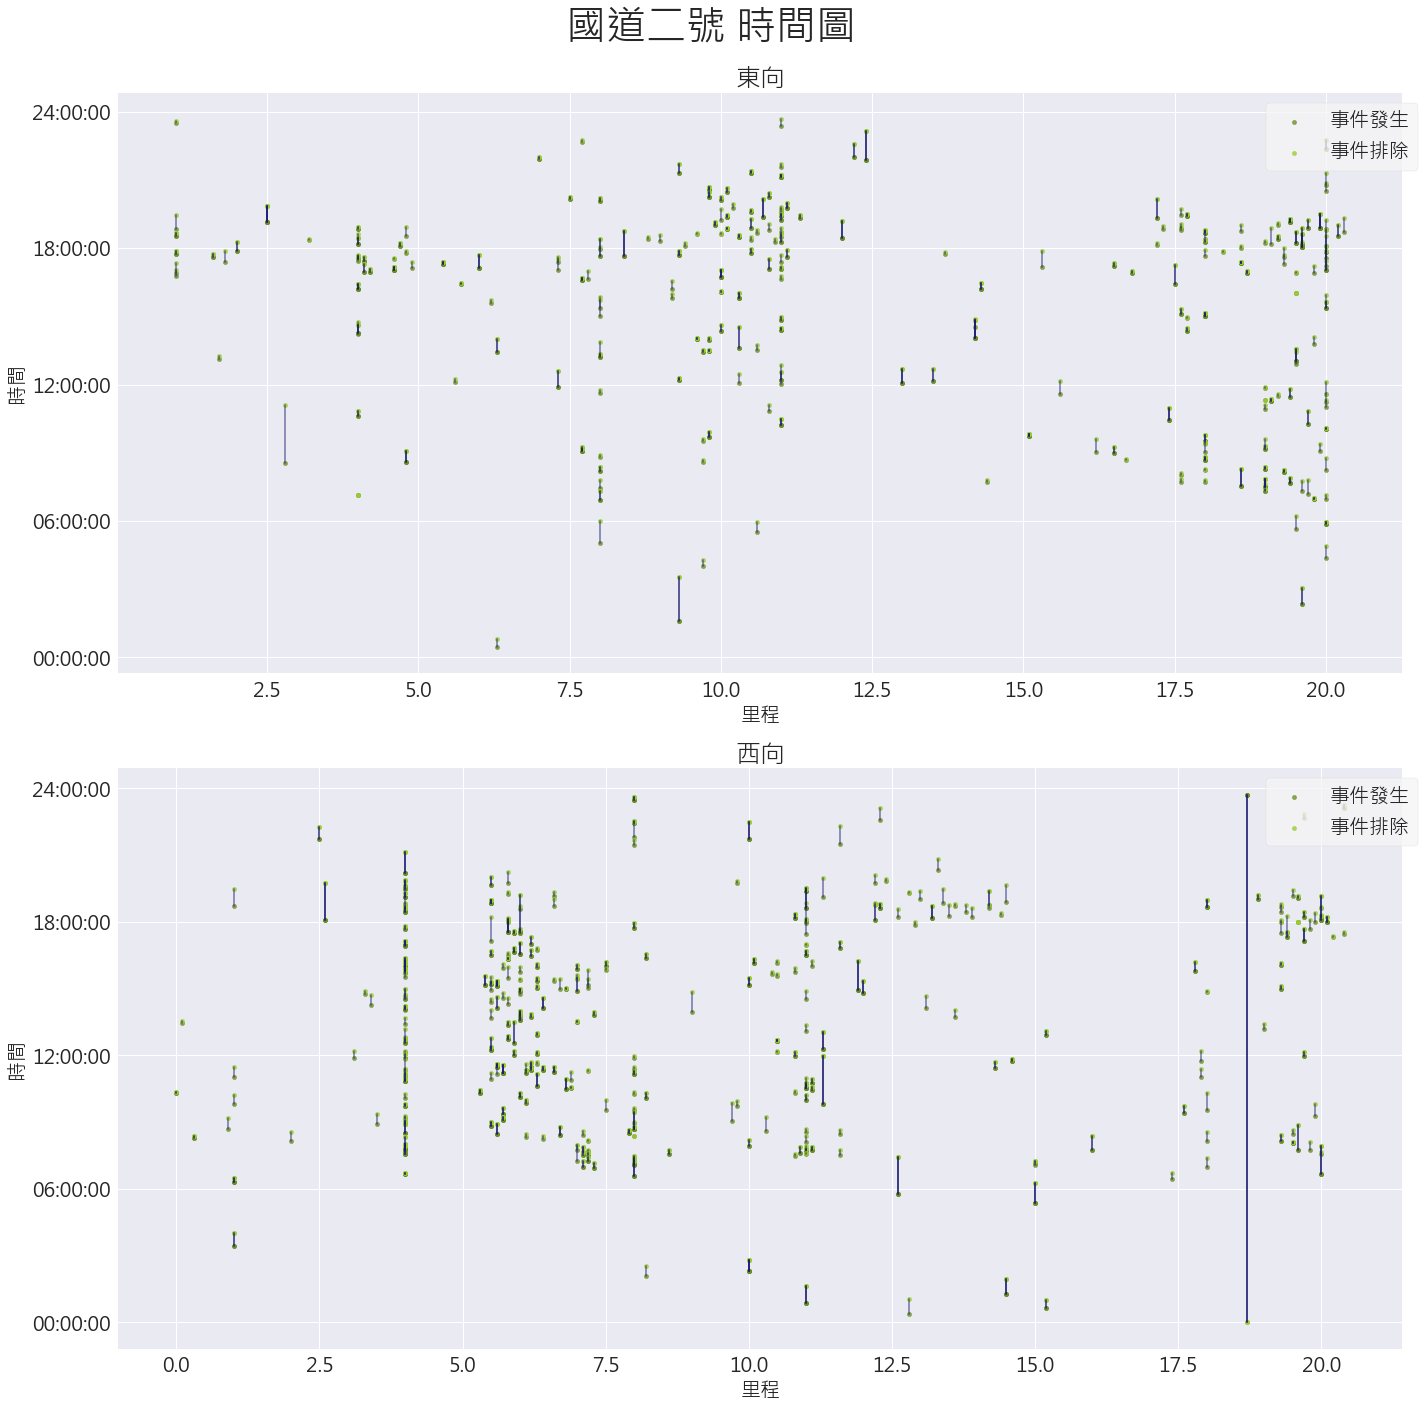

In [178]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道二號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道2甲(幾乎沒東西)

In [855]:
# "國道2甲"
df_highway_2_i = sorted_df[sorted_df['國道名稱'] == '國道2甲']
# variable
df_highway_2_i = df_highway_2_i[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_2_i


國道名稱 方向   里程      事件發生      事件排除  處理分鐘
12030  國道2甲  東  0.0  08:56:00  09:33:00    37

In [217]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_2_i['事件發生(秒數)'] = df_highway_2_i['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_2_i['事件排除(秒數)'] = df_highway_2_i['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_2_i['處理分鐘(秒數)'] = df_highway_2_i['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_2_i[df_highway_2_i['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_2_i[df_highway_2_i['方向'] == '西']
df_west_direction

Empty DataFrame
Columns: [國道名稱, 方向, 里程, 事件發生, 事件排除, 處理分鐘, 事件發生(秒數), 事件排除(秒數), 處理分鐘(秒數)]
Index: []

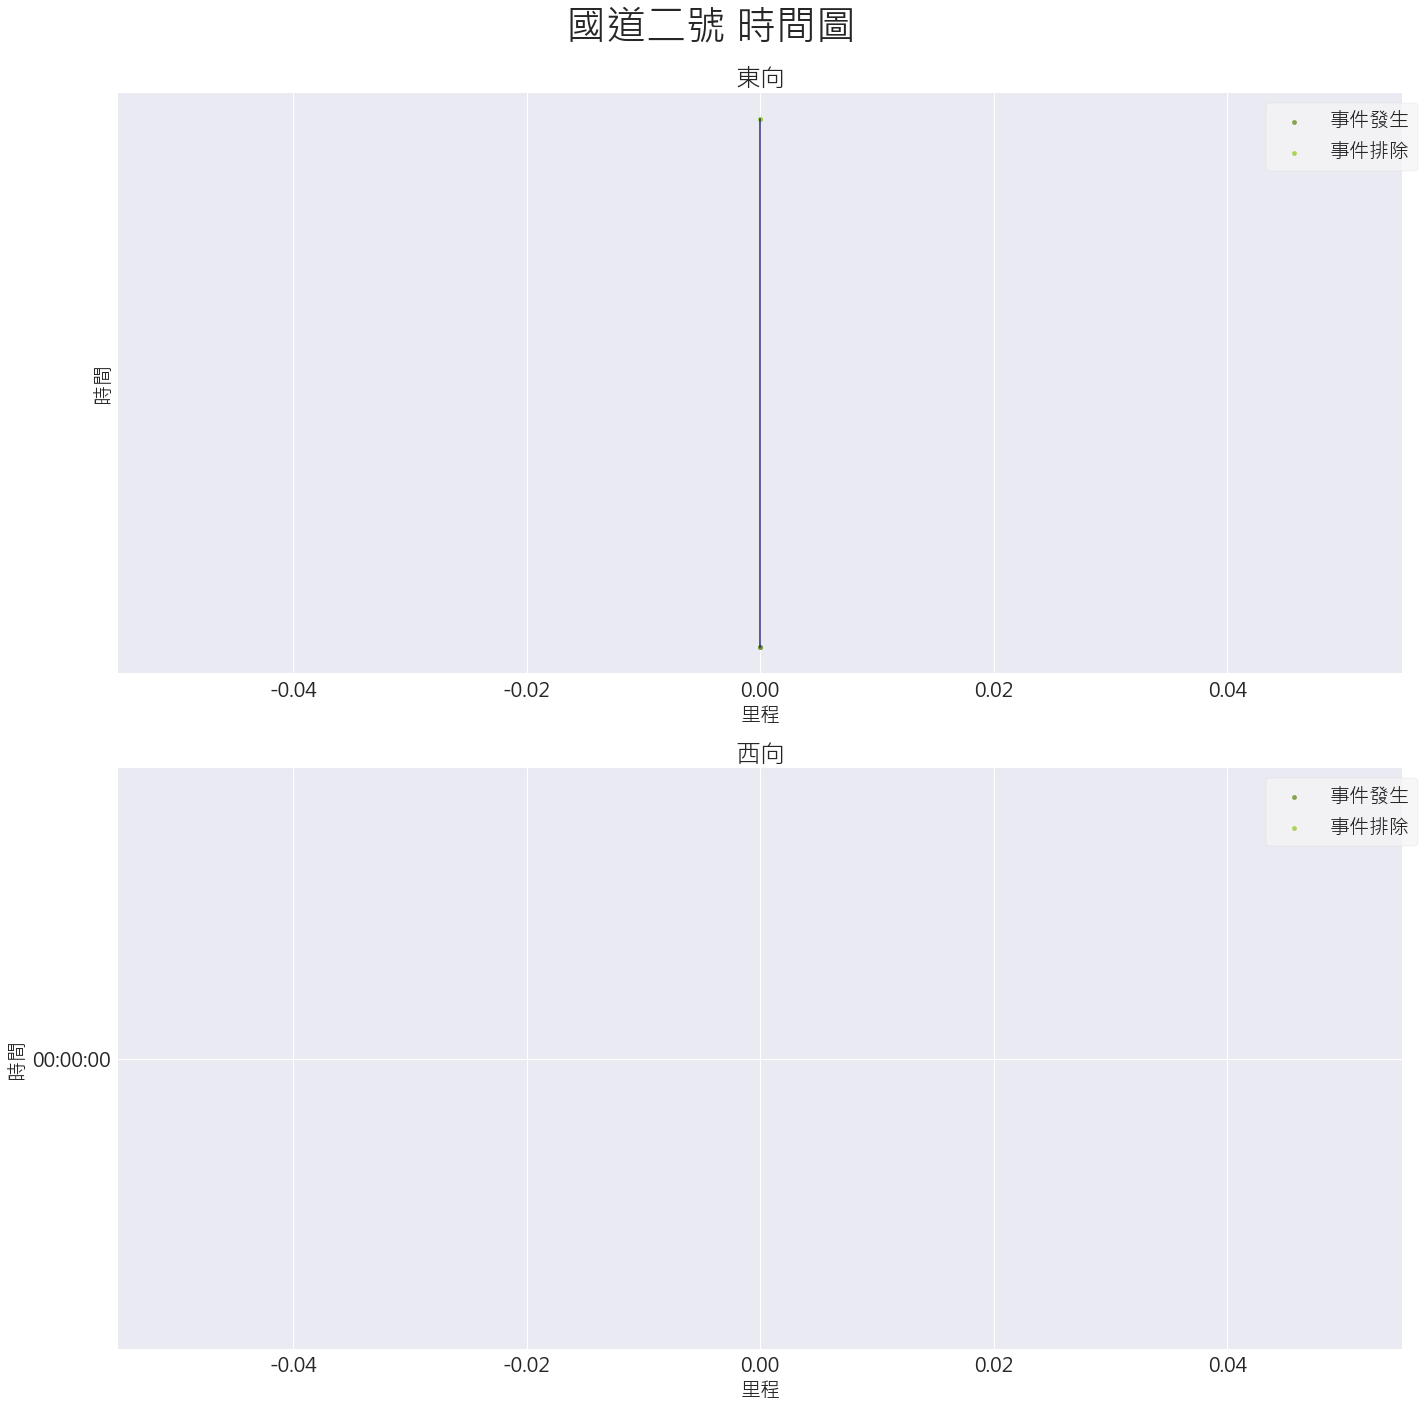

In [218]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道二甲 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道3號

In [1115]:
# "國道3號"
df_highway_3 = sorted_df[sorted_df['國道名稱'] == '國道3號']
# variable
df_highway_3 = df_highway_3[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]

# change str into datetime to caculate
df_highway_3['事件發生'] = df_highway_3['事件發生'].apply(str_to_time)
df_highway_3['事件排除'] = df_highway_3['事件排除'].apply(str_to_time)

# check
df_highway_3

國道名稱 方向     里程                事件發生                事件排除  處理分鐘
1      國道3號  北   42.0 1900-01-01 01:52:00 1900-01-01 02:27:00    35
2      國道3號  北  195.3 1900-01-01 04:07:00 1900-01-01 04:52:00    45
5      國道3號  南  211.0 1900-01-01 08:55:00 1900-01-01 09:16:00    21
13     國道3號  南  357.0 1900-01-01 12:50:00 1900-01-01 12:53:00     3
15     國道3號  南  290.1 1900-01-01 13:35:00 1900-01-01 14:07:00    32
...     ... ..    ...                 ...                 ...   ...
17726  國道3號  南  211.3 1900-01-01 12:30:00 1900-01-01 12:46:00    16
17731  國道3號  南  157.9 1900-01-01 15:59:00 1900-01-01 16:24:00    25
17732  國道3號  北  166.5 1900-01-01 17:43:00 1900-01-01 17:48:00     5
17738  國道3號  南   55.8 1900-01-01 19:28:00 1900-01-01 20:09:00    41
17740  國道3號  北  360.4 1900-01-01 22:34:00 1900-01-01 23:16:00    42

[4809 rows x 6 columns]

In [1116]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_3['事件發生(秒數)'] = df_highway_3['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_3['事件排除(秒數)'] = df_highway_3['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_3['處理分鐘(秒數)'] = df_highway_3['處理分鐘'] * 60

# take "北"向的
df_north_direction = df_highway_3[df_highway_3['方向'] == '北']
df_north_direction

# take "南"向的
df_south_direction = df_highway_3[df_highway_3['方向'] == '南']
df_south_direction

國道名稱 方向     里程                事件發生                事件排除  處理分鐘  事件發生(秒數)  \
5      國道3號  南  211.0 1900-01-01 08:55:00 1900-01-01 09:16:00    21     32100   
13     國道3號  南  357.0 1900-01-01 12:50:00 1900-01-01 12:53:00     3     46200   
15     國道3號  南  290.1 1900-01-01 13:35:00 1900-01-01 14:07:00    32     48900   
18     國道3號  南   31.0 1900-01-01 14:17:00 1900-01-01 14:22:00     5     51420   
19     國道3號  南   62.3 1900-01-01 14:58:00 1900-01-01 15:34:00    36     53880   
...     ... ..    ...                 ...                 ...   ...       ...   
17715  國道3號  南  196.8 1900-01-01 07:16:00 1900-01-01 07:45:00    29     26160   
17724  國道3號  南  188.0 1900-01-01 10:43:00 1900-01-01 11:33:00    50     38580   
17726  國道3號  南  211.3 1900-01-01 12:30:00 1900-01-01 12:46:00    16     45000   
17731  國道3號  南  157.9 1900-01-01 15:59:00 1900-01-01 16:24:00    25     57540   
17738  國道3號  南   55.8 1900-01-01 19:28:00 1900-01-01 20:09:00    41     70080   

       事件排除(秒數)  處理分鐘(秒數)  
5         33360      1260  
13        46380       180  
15        50820      1920  
18        51720       300  
19        56040      2160  
...         ...       ...  
17715     27900      1740  
17724     41580      3000  
17726     45960       960  
17731     59040      1500  
17738     72540      2460  

[2152 rows x 9 columns]

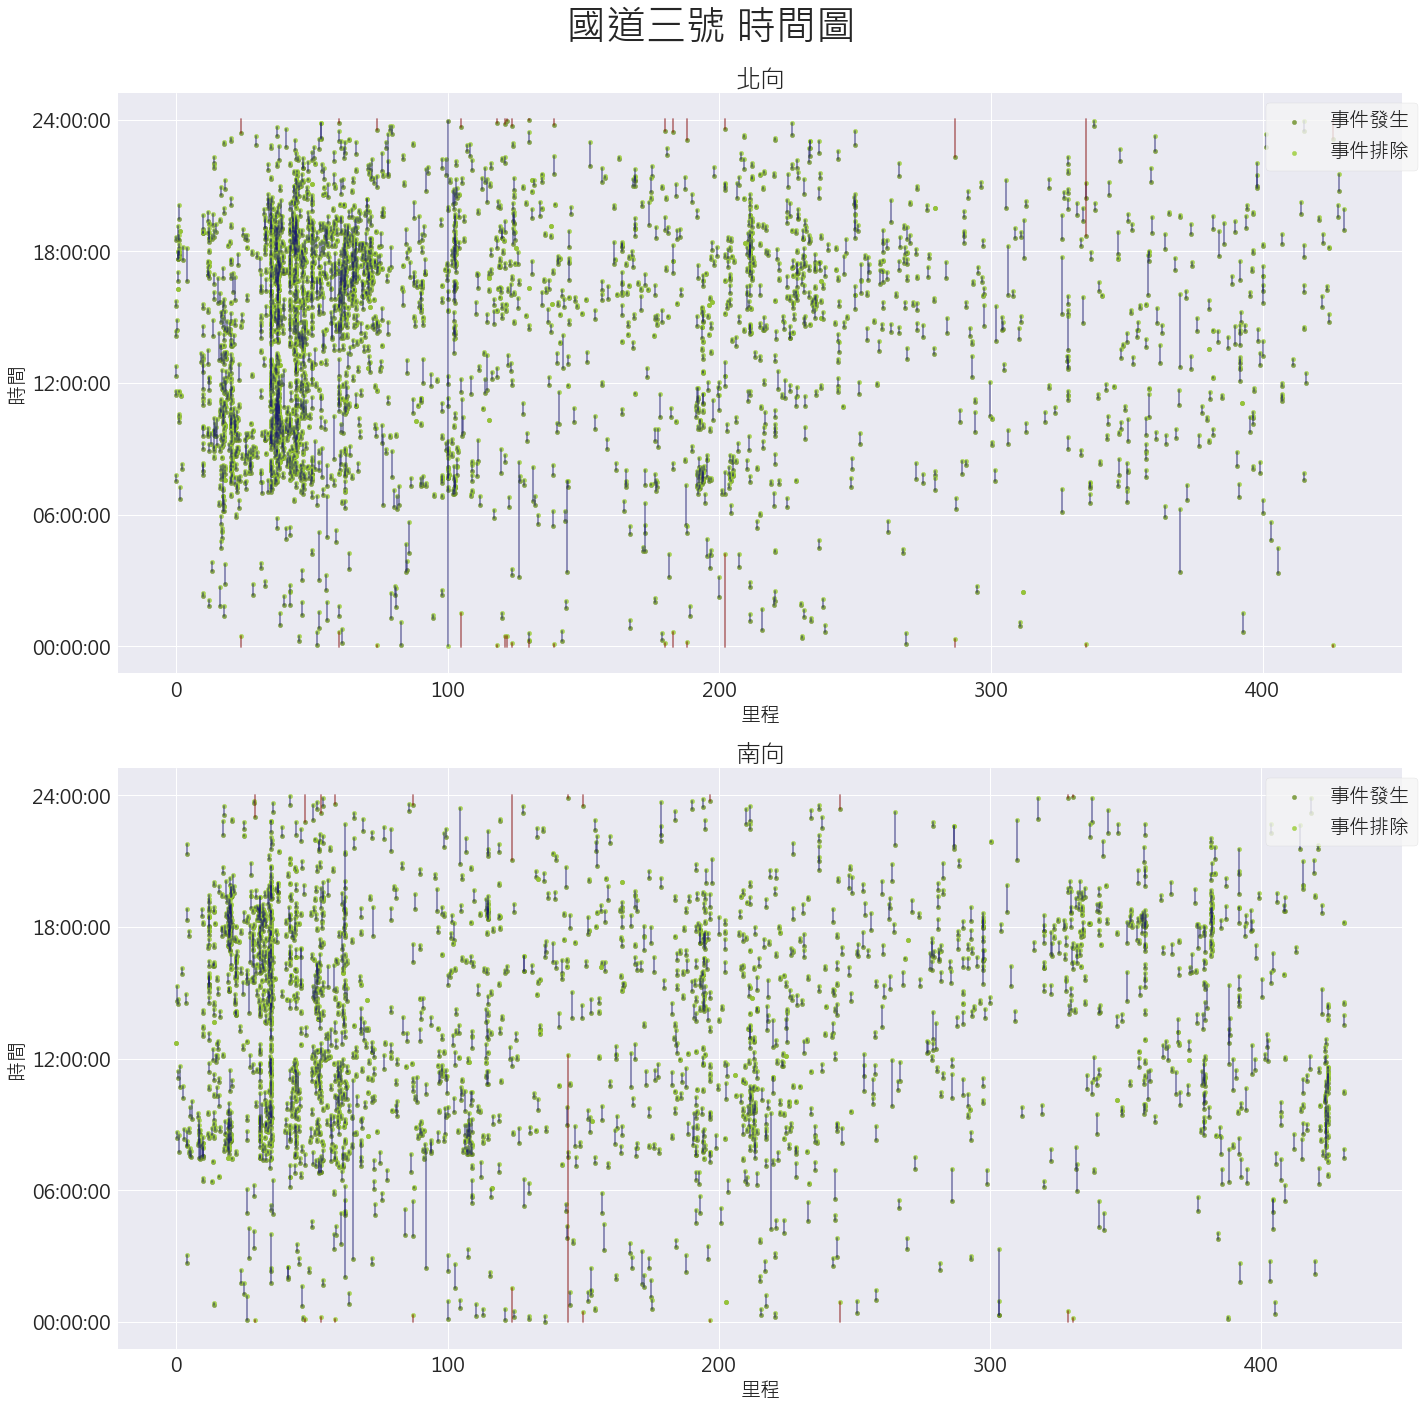

In [1117]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# 上半部分 - 北向資料
# def x, y
x = df_north_direction['里程']
y_event = df_north_direction['事件發生(秒數)']
y_clear = df_north_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_north_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('北向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 南向資料
# def x, y
x = df_south_direction['里程']
y_event = df_south_direction['事件發生(秒數)']
y_clear = df_south_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_south_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('南向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道三號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


#### 里程 --- 處理分鐘

C:\Users\ACER\AppData\Local\Temp\ipykernel_19248\4278031049.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ACER\AppData\Local\Temp\ipykernel_19248\4278031049.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ACER\AppData\Local\Temp\ipykernel_19248\4278031049.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

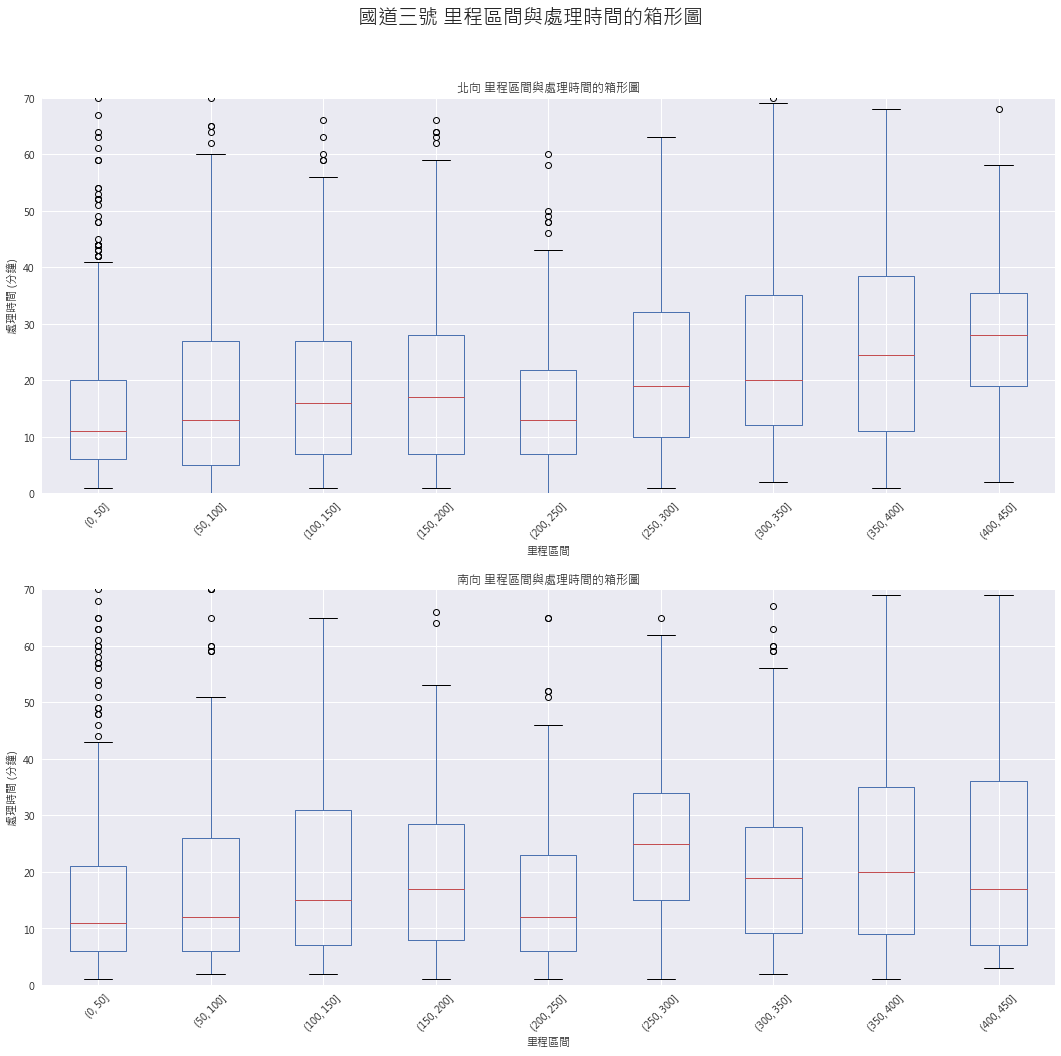

In [112]:
# change sec into min
df_north_direction.loc[:, '處理分鐘(分鐘)'] = df_north_direction['處理分鐘(秒數)'] / 60
df_south_direction.loc[:, '處理分鐘(分鐘)'] = df_south_direction['處理分鐘(秒數)'] / 60

# change "里程" to every 50km
bins = range(0, int(max(df_north_direction['里程'].max(), df_south_direction['里程'].max())) + 50, 50)
df_north_direction.loc[:, '里程區間'] = pd.cut(df_north_direction['里程'], bins=bins)
df_south_direction.loc[:, '里程區間'] = pd.cut(df_south_direction['里程'], bins=bins)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# box plot for "北向"
df_north_boxplot = df_north_direction[['里程區間', '處理分鐘(分鐘)']]
df_north_boxplot.boxplot(by='里程區間', column=['處理分鐘(分鐘)'], ax=ax1)
ax1.set_title('北向 里程區間與處理時間的箱形圖')
ax1.set_xlabel('里程區間')
ax1.set_ylabel('處理時間 (分鐘)')
ax1.set_ylim(0,70)
ax1.tick_params(axis='x', rotation=45)

# box plot for "南向"
df_south_boxplot = df_south_direction[['里程區間', '處理分鐘(分鐘)']]
df_south_boxplot.boxplot(by='里程區間', column=['處理分鐘(分鐘)'], ax=ax2)
ax2.set_title('南向 里程區間與處理時間的箱形圖')
ax2.set_xlabel('里程區間')
ax2.set_ylabel('處理時間 (分鐘)')
ax2.set_ylim(0,70)
ax2.tick_params(axis='x', rotation=45)

# adjust
plt.suptitle('國道三號 里程區間與處理時間的箱形圖', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show
plt.show()


In [113]:
# count samples in every time group
north_sample_count = df_north_boxplot.groupby('里程區間').size()
south_sample_count = df_south_boxplot.groupby('里程區間').size()

# use df to show
df_sample_count = pd.DataFrame({
    '北向樣本數': north_sample_count,
    '南向樣本數': south_sample_count
})
df_sample_count.reset_index(inplace=True)
df_sample_count.rename(columns={'發生時間(小時)': '時間區間'}, inplace=True)
df_sample_count

里程區間  北向樣本數  南向樣本數
0     (0, 50]   1084    682
1   (50, 100]    567    372
2  (100, 150]    238    189
3  (150, 200]    183    215
4  (200, 250]    282    218
5  (250, 300]     89    109
6  (300, 350]     75    106
7  (350, 400]     92    166
8  (400, 450]     30     93

#### 事件發生 --- 處理分鐘

C:\Users\ACER\AppData\Local\Temp\ipykernel_19248\3449964268.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ACER\AppData\Local\Temp\ipykernel_19248\3449964268.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ACER\AppData\Local\Temp\ipykernel_19248\3449964268.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

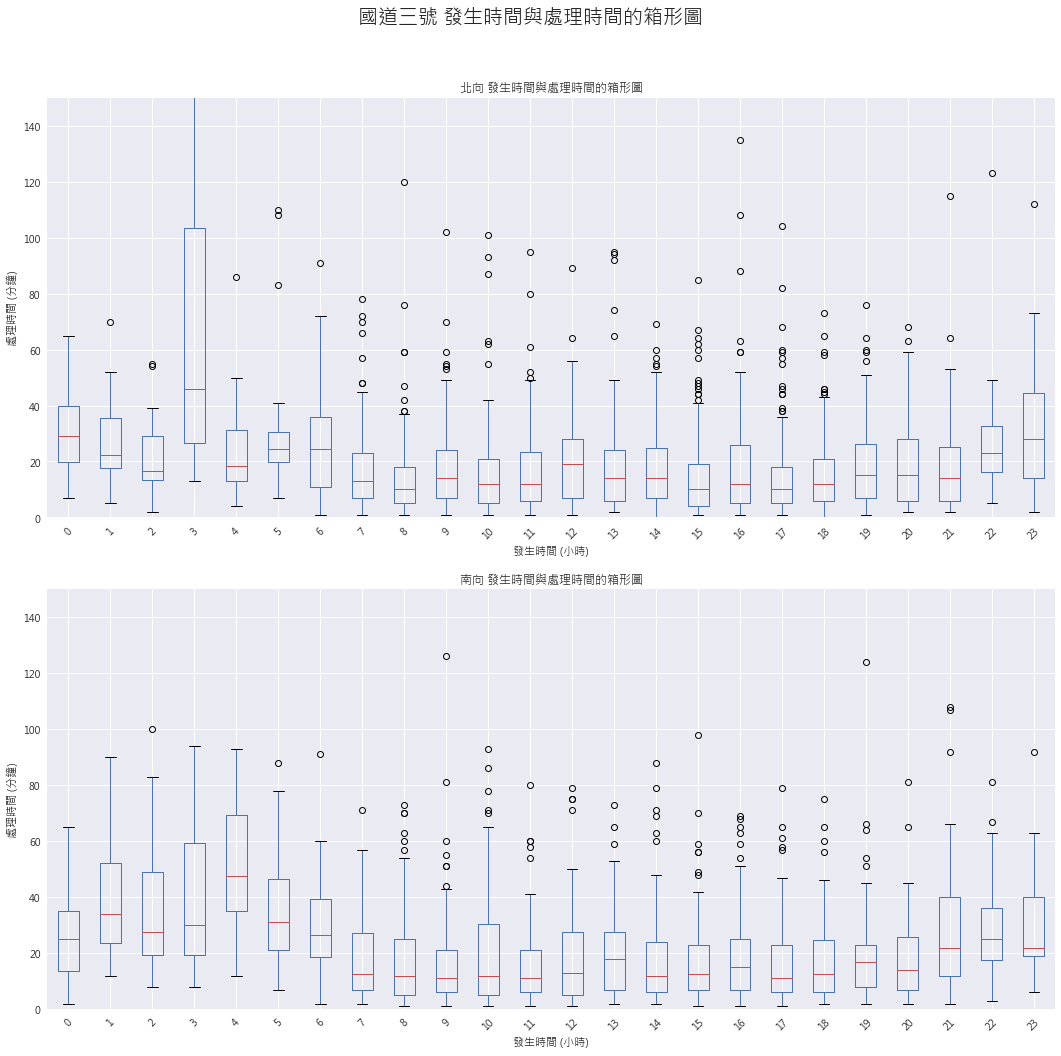

In [116]:
# change sec into min
df_north_direction.loc[:, '處理分鐘(分鐘)'] = df_north_direction['處理分鐘(秒數)'] / 60
df_south_direction.loc[:, '處理分鐘(分鐘)'] = df_south_direction['處理分鐘(秒數)'] / 60

# change "事件發生時間" into hr & group
df_north_direction.loc[:, '發生時間(小時)'] = df_north_direction['事件發生(秒數)'] // 3600
df_south_direction.loc[:, '發生時間(小時)'] = df_south_direction['事件發生(秒數)'] // 3600

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# box plot for "北向"
df_north_boxplot = df_north_direction[['發生時間(小時)', '處理分鐘(分鐘)']]
df_north_boxplot.boxplot(by='發生時間(小時)', column=['處理分鐘(分鐘)'], ax=ax1)
ax1.set_title('北向 發生時間與處理時間的箱形圖')
ax1.set_xlabel('發生時間 (小時)')
ax1.set_ylabel('處理時間 (分鐘)')
ax1.set_ylim(0,150)
ax1.tick_params(axis='x', rotation=45)

# box plot for "南向"
df_south_boxplot = df_south_direction[['發生時間(小時)', '處理分鐘(分鐘)']]
df_south_boxplot.boxplot(by='發生時間(小時)', column=['處理分鐘(分鐘)'], ax=ax2)
ax2.set_title('南向 發生時間與處理時間的箱形圖')
ax2.set_xlabel('發生時間 (小時)')
ax2.set_ylabel('處理時間 (分鐘)')
ax2.set_ylim(0,150)
ax2.tick_params(axis='x', rotation=45)

# adjust
plt.suptitle('國道三號 發生時間與處理時間的箱形圖', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show
plt.show()


In [117]:
# count samples in every time group
north_sample_count = df_north_boxplot.groupby('發生時間(小時)').size()
south_sample_count = df_south_boxplot.groupby('發生時間(小時)').size()

# use df to show
df_sample_count = pd.DataFrame({
    '北向樣本數': north_sample_count,
    '南向樣本數': south_sample_count
})
df_sample_count.reset_index(inplace=True)
df_sample_count.rename(columns={'發生時間(小時)': '時間區間'}, inplace=True)
df_sample_count

時間區間  北向樣本數  南向樣本數
0      0     16     27
1      1     20     16
2      2     14     24
3      3     15     15
4      4     14     18
5      5     18     18
6      6     44     40
7      7    163    120
8      8    148    193
9      9    155    152
10    10    173    143
11    11    131    141
12    12     95     94
13    13     98     83
14    14    190    131
15    15    194    140
16    16    245    157
17    17    291    193
18    18    255    198
19    19    136    105
20    20     94     46
21    21     72     41
22    22     38     35
23    23     30     22

#### 切割 heat map

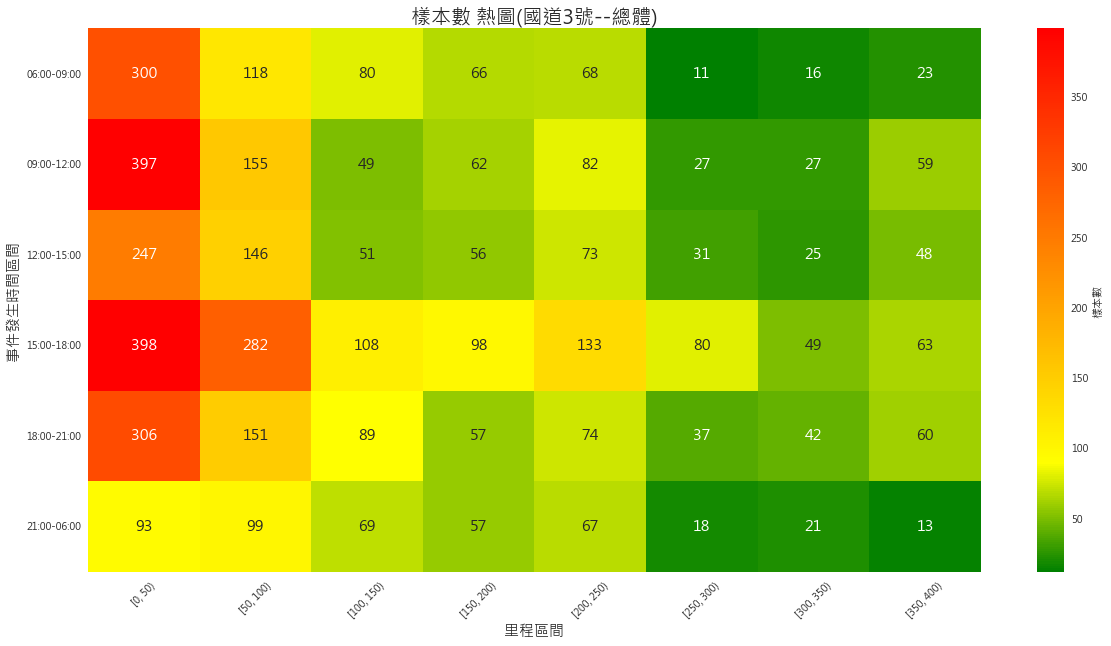

格子 [時間區間: 0, 里程區間: 0] 共有 300 筆資料。
格子 [時間區間: 0, 里程區間: 1] 共有 118 筆資料。
格子 [時間區間: 0, 里程區間: 2] 共有 80 筆資料。
格子 [時間區間: 0, 里程區間: 3] 共有 66 筆資料。
格子 [時間區間: 0, 里程區間: 4] 共有 68 筆資料。
格子 [時間區間: 0, 里程區間: 5] 共有 11 筆資料。
格子 [時間區間: 0, 里程區間: 6] 共有 16 筆資料。
格子 [時間區間: 0, 里程區間: 7] 共有 23 筆資料。
格子 [時間區間: 1, 里程區間: 0] 共有 397 筆資料。
格子 [時間區間: 1, 里程區間: 1] 共有 155 筆資料。
格子 [時間區間: 1, 里程區間: 2] 共有 49 筆資料。
格子 [時間區間: 1, 里程區間: 3] 共有 62 筆資料。
格子 [時間區間: 1, 里程區間: 4] 共有 82 筆資料。
格子 [時間區間: 1, 里程區間: 5] 共有 27 筆資料。
格子 [時間區間: 1, 里程區間: 6] 共有 27 筆資料。
格子 [時間區間: 1, 里程區間: 7] 共有 59 筆資料。
格子 [時間區間: 2, 里程區間: 0] 共有 247 筆資料。
格子 [時間區間: 2, 里程區間: 1] 共有 146 筆資料。
格子 [時間區間: 2, 里程區間: 2] 共有 51 筆資料。
格子 [時間區間: 2, 里程區間: 3] 共有 56 筆資料。
格子 [時間區間: 2, 里程區間: 4] 共有 73 筆資料。
格子 [時間區間: 2, 里程區間: 5] 共有 31 筆資料。
格子 [時間區間: 2, 里程區間: 6] 共有 25 筆資料。
格子 [時間區間: 2, 里程區間: 7] 共有 48 筆資料。
格子 [時間區間: 3, 里程區間: 0] 共有 398 筆資料。
格子 [時間區間: 3, 里程區間: 1] 共有 282 筆資料。
格子 [時間區間: 3, 里程區間: 2] 共有 108 筆資料。
格子 [時間區間: 3, 里程區間: 3] 共有 98 筆資料。
格子 [時間區間: 3, 里程區間: 4] 共有 133 筆資料。
格子 [時間區間: 3, 里程區間: 5] 共有 80 筆資料。


In [1118]:
# set time & mile interval
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(df_highway_3['里程'].min(), df_highway_3['里程'].max() + 1, mile_block, dtype=int)

# add new row to cut
df_highway_3['事件發生時間區間'] = pd.cut(df_highway_3['事件發生(秒數)'], bins=time_bins, right=False)
df_highway_3['里程區間'] = pd.cut(df_highway_3['里程'], bins=mile_bins, right=False)

# count sample
sample_counts = df_highway_3.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].apply(merge_time_intervals)

# del repeat row and sum sample
sample_counts = sample_counts.groupby(['事件發生時間區間', '里程區間'], as_index=False).sum()

# pivot table
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# reset index
pivot_table.index = pivot_table.index.map(format_time_label)

# adjust
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.2, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道3號--總體)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# def time interval
time_intervals = [
    (6 * 3600, 9 * 3600),    # 06:00-09:00
    (9 * 3600, 12 * 3600),   # 09:00-12:00
    (12 * 3600, 15 * 3600),  # 12:00-15:00
    (15 * 3600, 18 * 3600),  # 15:00-18:00
    (18 * 3600, 21 * 3600),   # 18:00-21:00
    (21 * 3600, 6 * 3600),  # 21:00-06:00
]
# def mile interval with every 50km
mile_interval_size = 50
mile_intervals = [(0, 50), (50, 100), (100, 150), (150, 200),
                  (200, 250), (250, 300), (300, 350), (350, 400)]

# init result saving
result_indices = {}

# mile interval
mile_intervals = 8
mile_interval_size = 50

# save
for time_idx, (time_start, time_end) in enumerate(time_intervals):
    for mile_idx in range(mile_intervals):
        mile_start = mile_idx * mile_interval_size
        mile_end = (mile_idx + 1) * mile_interval_size
        # for 21:00~06:00 doing special case
        if time_start > time_end:
            filtered_data = df_highway_3[
                ((df_highway_3['事件發生(秒數)'] >= time_start) | (df_highway_3['事件發生(秒數)'] < time_end)) &
                (df_highway_3['里程'] >= mile_start) & (
                    df_highway_3['里程'] < mile_end)
            ]
        else:
            filtered_data = df_highway_3[
                (df_highway_3['事件發生(秒數)'] >= time_start) & (df_highway_3['事件發生(秒數)'] < time_end) &
                (df_highway_3['里程'] >= mile_start) & (
                    df_highway_3['里程'] < mile_end)
            ]

        # save
        result_indices[(time_idx, mile_idx)] = filtered_data.index.tolist()

# result
for (time_idx, mile_idx), indices in result_indices.items():
    print(f"格子 [時間區間: {time_idx}, 里程區間: {mile_idx}] 共有 {len(indices)} 筆資料。")

In [1119]:
# # 設定儲存資料夾
# save_dir = 'saved_model'
# os.makedirs(save_dir, exist_ok=True)

# # 結果儲存變數
# results = []
# selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
#          '肇事車輛', '處理分鐘', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
# categorical_features = [
#     '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
#     "相近時間&地點是否有事件", "事故車是否包含非小客車"]
# columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
# # 設定參數網格
# param_grid = {
#     'alpha': [0],
#     'colsample_bytree': [1.0],
#     'eta': [0.01, 0.1, 0.3, 0.5, 0.7],
#     'gamma': [0, 0.05, 0.1, 0.5, 0.7],
#     'lambda': [0.1, 0.3, 0.5, 1],
#     'max_depth': [1, 2, 3],
#     'min_child_weight': [1],
#     'subsample': [1.0],
# }

# # 固定參數
# params_fixed = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'mae',
#     'verbosity': 0,
#     'n_jobs': -1,
# }

# # 假設有35個格子，範例設定為(5, 7)
# for i in range(6):
#     for j in range(8):
#         grid_key = (i, j)
#         if grid_key in result_indices:
#             indices_to_use = result_indices[grid_key]
#             filtered_df = sorted_df.loc[indices_to_use]
#             print(f"start {grid_key} with {filtered_df.shape[0]} samples")
#             # 前處理和特徵工程
#             selected_df = filtered_df[selected_features].copy()
#             # 指定要處理的變數
#             selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)
#             selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

#             # 類別變數的Label Encoding
#             label_encoders = {}
#             for feature in categorical_features:
#                 label_encoders[feature] = LabelEncoder()
#                 selected_df[feature] = label_encoders[feature].fit_transform(
#                     selected_df[feature].astype(str))

#             selected_df['肇事車輛'].fillna(0, inplace=True)

#             # 分割特徵和目標變數
#             X = selected_df.drop(columns=['處理分鐘'])
#             y = selected_df['處理分鐘']
#             y_log = np.log1p(y)

#             # 訓練與測試集切分
#             X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
#                 X, y_log, test_size=0.2, random_state=42)
            
#             # XGBoost模型參數
#             dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
#             dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)
#             evals = [(dtest_log, 'eval')]

#             best_mae = float("inf")
#             best_params = None

#             for params in ParameterGrid(param_grid):
#                 current_params = {**params_fixed, **params}

#                 bst = xgb.train(
#                     params=current_params,
#                     dtrain=dtrain_log,
#                     num_boost_round=1000,
#                     obj=quantile_loss_obj,
#                     custom_metric=custom_metric,
#                     early_stopping_rounds=50,
#                     evals=evals,
#                     verbose_eval=False
#                 )

#                 y_pred_log = bst.predict(dtest_log)
#                 mae = mean_absolute_error(y_test_log, y_pred_log)
#                 if mae < best_mae:
#                     best_mae = mae
#                     best_params = params

#             # 用最佳參數重訓模型
#             xgb_qreg_best_model = xgb.train(
#                 params={**params_fixed, **best_params},
#                 dtrain=dtrain_log,
#                 num_boost_round=1000,
#                 obj=quantile_loss_obj,
#                 custom_metric=custom_metric,
#                 early_stopping_rounds=50,
#                 evals=evals,
#                 verbose_eval=True
#             )

#             # 預測與殘差計算
#             dall = xgb.DMatrix(X)
#             y_all_pred_log = xgb_qreg_best_model.predict(dall)
#             y_all_pred = np.expm1(y_all_pred_log)
#             residuals = y_all_pred - y
#             residuals_df = pd.DataFrame({'Residuals': residuals})

#             # 計算統計量
#             total_samples = residuals_df.shape[0]
#             std_residuals = residuals_df['Residuals'].std()
#             positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
#             negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
#             mse = mean_squared_error(y, y_all_pred)
#             mae = mean_absolute_error(y, y_all_pred)
            
#             Q1 = np.percentile(residuals, 25)
#             Q2 = np.percentile(residuals, 50)
#             Q3 = np.percentile(residuals, 75)
#             median = np.median(residuals)
#             mean = np.mean(residuals)

#             # 儲存模型
#             model_filename = f'r3_{grid_key[0]}_{grid_key[1]}.pkl'
#             xgb_qreg_best_model.save_model(os.path.join(save_dir, model_filename))
#             print(f"Model saved: {model_filename}")

#             # 儲存結果
#             results.append({
#                 'Grid': grid_key,
#                 'Total Samples': total_samples,
#                 'Positive Outliers': positive_outliers,
#                 'Negative Outliers': negative_outliers,
#                 'MSE': mse,
#                 'MAE': mae,
#                 'Q1': Q1,
#                 'Q2': Q2,
#                 'Q3': Q3,
#                 'Median': median,
#                 'Mean': mean
#             })
#             print(f"saved {grid_key} data")

# # 將結果轉為DataFrame
# training_r3all_results_df = pd.DataFrame(results)
# print("finish")


In [1120]:
# # 新增「國道」變數並全部填上「國道一號」
# training_r3all_results_df.insert(0, '國道', '國道三號')
# training_r3all_results_df.insert(1, '月份資料', '112年1~10月資料')

# # 定義時間區間和里程區間
# time_intervals = [
#     "06:00-09:00",
#     "09:00-12:00",
#     "12:00-15:00",
#     "15:00-18:00",
#     "18:00-21:00",
#     "21:00-06:00"
# ]

# mile_intervals = [
#     (0, 50),
#     (50, 100),
#     (100, 150),
#     (150, 200),
#     (200, 250),
#     (250, 300),
#     (300, 350),
#     (350, 400)
# ]

# # 使用apply方法將「時間」和「里程」加入到DataFrame
# training_r3all_results_df['時間'] = training_r3all_results_df['Grid'].apply(
#     lambda x: time_intervals[x[0]])
# training_r3all_results_df['里程'] = training_r3all_results_df['Grid'].apply(
#     lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# # 調整列的順序
# cols = ['國道', '月份資料', '時間', '里程'] + \
#     [col for col in training_r3all_results_df.columns if col not in [
#         '國道', '月份資料', '時間', '里程']]
# training_r3all_results_df = training_r3all_results_df[cols]

# # 刪除「grid」列
# training_r3all_results_df.drop(columns=['Grid'], inplace=True)
# # save
# training_r3all_results_df.to_excel(
#     'training_r3all_results_df.xlsx', index=False)
# training_r3all_results_df

#### 零膨脹模型

In [1122]:
# 設定儲存資料夾
save_dir = 'saved_model'
os.makedirs(save_dir, exist_ok=True)

# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
                     '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
categorical_features = [
    '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# 設定參數網格
param_grid = {
    'colsample_bytree': [1.0],
    'eta': [0.1, 0.3, 0.5, 0.7],
    'gamma': [0, 0.05, 0.1, 0.5],
    'lambda': [0.1, 0.3, 0.5, 1],
    'max_depth': [1, 2, 3],
    'min_child_weight': [1],
    'subsample': [1.0],
}

# 固定參數
params_fixed = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'n_jobs': -1,
}

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(8):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = sorted_df.loc[indices_to_use]
            print(f"Start processing {grid_key} with {filtered_df.shape[0]} samples")
            
            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            # 指定要處理的變數
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)
            selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

            # 類別變數的Label Encoding
            label_encoders = {}
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割資料集
            X = selected_df.drop(columns=['回堵長度'])
            y = selected_df['回堵長度']
            X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, np.log1p(y), test_size=0.2, random_state=42)
            
            # 訓練 Zero-Inflated Poisson 模型
            zip_model = sm.ZeroInflatedPoisson(y_train_log, X_train_log, inflation='logit')
            zip_result = zip_model.fit(maxiter=100, disp=False)
            zip_preds_train = zip_result.predict(X_train_log)
            zip_preds_test = zip_result.predict(X_test_log)

            # 使用 XGBoost 模型進行預測
            dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
            dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)
            evals = [(dtest_log, 'eval')]

            best_mae = float("inf")
            best_params = None

            for params in ParameterGrid(param_grid):
                current_params = {**params_fixed, **params}

                bst = xgb.train(
                    params=current_params,
                    dtrain=dtrain_log,
                    num_boost_round=1000,
                    obj=quantile_loss_obj,
                    custom_metric=custom_metric,
                    early_stopping_rounds=50,
                    evals=evals,
                    verbose_eval=False
                )

                y_pred_log = bst.predict(dtest_log)
                mae = mean_absolute_error(y_test_log, y_pred_log)
                if mae < best_mae:
                    best_mae = mae
                    best_params = params

            # 用最佳參數重訓模型
            xgb_qreg_best_model = xgb.train(
                params={**params_fixed, **best_params},
                dtrain=dtrain_log,
                num_boost_round=1000,
                obj=quantile_loss_obj,
                custom_metric=custom_metric,
                early_stopping_rounds=50,
                evals=evals,
                verbose_eval=True
            )

            # 使用最佳 XGBoost 模型進行預測
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)

            # 結合 ZIP 和 XGBoost 模型的預測
            zip_preds_all = zip_result.predict(X)
            y_pred_combined = np.where(zip_preds_all == 0, 0, y_all_pred)

            # 計算殘差
            residuals = y - y_pred_combined
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_pred_combined)
            mae = mean_absolute_error(y, y_pred_combined)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存模型
            model_filename = f'r3_zero_{grid_key[0]}_{grid_key[1]}.pkl'
            xgb_qreg_best_model.save_model(os.path.join(save_dir, model_filename))
            print(f"Model saved: {model_filename}")

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"Saved data for {grid_key}")

# 將結果轉為DataFrame
training_r3all_zero_results_df = pd.DataFrame(results)
print("Finish processing all grids")


Start processing (0, 0) with 300 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.45839	eval-quantile_loss:0.22920
[1]	eval-mae:0.43187	eval-quantile_loss:0.21594
[2]	eval-mae:0.41351	eval-quantile_loss:0.20675
[3]	eval-mae:0.40833	eval-quantile_loss:0.20416
[4]	eval-mae:0.36979	eval-quantile_loss:0.18490
[5]	eval-mae:0.37179	eval-quantile_loss:0.18590
[6]	eval-mae:0.35805	eval-quantile_loss:0.17903
[7]	eval-mae:0.34397	eval-quantile_loss:0.17199
[8]	eval-mae:0.37503	eval-quantile_loss:0.18751
[9]	eval-mae:0.34957	eval-quantile_loss:0.17478
[10]	eval-mae:0.35095	eval-quantile_loss:0.17548
[11]	eval-mae:0.36461	eval-quantile_loss:0.18230
[12]	eval-mae:0.33435	eval-quantile_loss:0.16717
[13]	eval-mae:0.36988	eval-quantile_loss:0.18494
[14]	eval-mae:0.34032	eval-quantile_loss:0.17016
[15]	eval-mae:0.33894	eval-quantile_loss:0.16947
[16]	eval-mae:0.34930	eval-quantile_loss:0.17465
[17]	eval-mae:0.32636	eval-quantile_loss:0.16318
[18]	eval-mae:0.36106	eval-quantile_loss:0.18053
[19]	eval-mae:0.32859	eval-quantile_loss:0.16429
[20]	eval-mae:0.34061	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.64855	eval-quantile_loss:0.32427
[1]	eval-mae:0.63330	eval-quantile_loss:0.31665
[2]	eval-mae:0.61805	eval-quantile_loss:0.30902
[3]	eval-mae:0.60280	eval-quantile_loss:0.30140
[4]	eval-mae:0.59061	eval-quantile_loss:0.29531
[5]	eval-mae:0.58034	eval-quantile_loss:0.29017
[6]	eval-mae:0.57041	eval-quantile_loss:0.28520
[7]	eval-mae:0.56403	eval-quantile_loss:0.28201
[8]	eval-mae:0.55403	eval-quantile_loss:0.27702
[9]	eval-mae:0.55514	eval-quantile_loss:0.27757
[10]	eval-mae:0.54601	eval-quantile_loss:0.27300
[11]	eval-mae:0.54649	eval-quantile_loss:0.27324
[12]	eval-mae:0.53559	eval-quantile_loss:0.26780
[13]	eval-mae:0.53562	eval-quantile_loss:0.26781
[14]	eval-mae:0.53355	eval-quantile_loss:0.26677
[15]	eval-mae:0.53485	eval-quantile_loss:0.26743
[16]	eval-mae:0.53778	eval-quantile_loss:0.26889
[17]	eval-mae:0.53361	eval-quantile_loss:0.26681
[18]	eval-mae:0.53829	eval-quantile_loss:0.26915
[19]	eval-mae:0.53400	eval-quantile_loss:0.26700
[20]	eval-mae:0.53007	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.48221	eval-quantile_loss:0.24110
[1]	eval-mae:0.47273	eval-quantile_loss:0.23637
[2]	eval-mae:0.46326	eval-quantile_loss:0.23163
[3]	eval-mae:0.45378	eval-quantile_loss:0.22689
[4]	eval-mae:0.45005	eval-quantile_loss:0.22503
[5]	eval-mae:0.43631	eval-quantile_loss:0.21816
[6]	eval-mae:0.43765	eval-quantile_loss:0.21882
[7]	eval-mae:0.43384	eval-quantile_loss:0.21692
[8]	eval-mae:0.42872	eval-quantile_loss:0.21436
[9]	eval-mae:0.43587	eval-quantile_loss:0.21793
[10]	eval-mae:0.43249	eval-quantile_loss:0.21624
[11]	eval-mae:0.43007	eval-quantile_loss:0.21504
[12]	eval-mae:0.41686	eval-quantile_loss:0.20843
[13]	eval-mae:0.41754	eval-quantile_loss:0.20877
[14]	eval-mae:0.42149	eval-quantile_loss:0.21074
[15]	eval-mae:0.41769	eval-quantile_loss:0.20885
[16]	eval-mae:0.42672	eval-quantile_loss:0.21336
[17]	eval-mae:0.42300	eval-quantile_loss:0.21150
[18]	eval-mae:0.42071	eval-quantile_loss:0.21035
[19]	eval-mae:0.42212	eval-quantile_loss:0.21106
[20]	eval-mae:0.42144	eval-qua

[167]	eval-mae:0.38395	eval-quantile_loss:0.19198
[168]	eval-mae:0.38494	eval-quantile_loss:0.19247
[169]	eval-mae:0.38395	eval-quantile_loss:0.19198
[170]	eval-mae:0.38494	eval-quantile_loss:0.19247
Model saved: r3_zero_0_2.pkl
Saved data for (0, 2)
Start processing (0, 3) with 66 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.41597	eval-quantile_loss:0.20799
[1]	eval-mae:0.40584	eval-quantile_loss:0.20292
[2]	eval-mae:0.39570	eval-quantile_loss:0.19785
[3]	eval-mae:0.38557	eval-quantile_loss:0.19278
[4]	eval-mae:0.37543	eval-quantile_loss:0.18771
[5]	eval-mae:0.36529	eval-quantile_loss:0.18265
[6]	eval-mae:0.35516	eval-quantile_loss:0.17758
[7]	eval-mae:0.34502	eval-quantile_loss:0.17251
[8]	eval-mae:0.34854	eval-quantile_loss:0.17427
[9]	eval-mae:0.34880	eval-quantile_loss:0.17440
[10]	eval-mae:0.35183	eval-quantile_loss:0.17592
[11]	eval-mae:0.35270	eval-quantile_loss:0.17635
[12]	eval-mae:0.35296	eval-quantile_loss:0.17648
[13]	eval-mae:0.35867	eval-quantile_loss:0.17934
[14]	eval-mae:0.35686	eval-quantile_loss:0.17843
[15]	eval-mae:0.35875	eval-quantile_loss:0.17938
[16]	eval-mae:0.36077	eval-quantile_loss:0.18038
[17]	eval-mae:0.36103	eval-quantile_loss:0.18051
[18]	eval-mae:0.36559	eval-quantile_loss:0.18280
[19]	eval-mae:0.36424	eval-quantile_loss:0.18212
[20]	eval-mae:0.36519	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.47000	eval-quantile_loss:0.23500
[1]	eval-mae:0.44919	eval-quantile_loss:0.22459
[2]	eval-mae:0.42839	eval-quantile_loss:0.21419
[3]	eval-mae:0.40758	eval-quantile_loss:0.20379
[4]	eval-mae:0.38678	eval-quantile_loss:0.19339
[5]	eval-mae:0.36597	eval-quantile_loss:0.18299
[6]	eval-mae:0.34517	eval-quantile_loss:0.17258
[7]	eval-mae:0.32436	eval-quantile_loss:0.16218
[8]	eval-mae:0.36372	eval-quantile_loss:0.18186
[9]	eval-mae:0.36139	eval-quantile_loss:0.18070
[10]	eval-mae:0.34483	eval-quantile_loss:0.17241
[11]	eval-mae:0.32170	eval-quantile_loss:0.16085
[12]	eval-mae:0.33625	eval-quantile_loss:0.16812
[13]	eval-mae:0.35265	eval-quantile_loss:0.17633
[14]	eval-mae:0.34637	eval-quantile_loss:0.17318
[15]	eval-mae:0.34314	eval-quantile_loss:0.17157
[16]	eval-mae:0.36102	eval-quantile_loss:0.18051
[17]	eval-mae:0.34517	eval-quantile_loss:0.17259
[18]	eval-mae:0.33096	eval-quantile_loss:0.16548
[19]	eval-mae:0.32808	eval-quantile_loss:0.16404
[20]	eval-mae:0.35447	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45062	eval-quantile_loss:0.22531
[1]	eval-mae:0.40123	eval-quantile_loss:0.20062
[2]	eval-mae:0.35185	eval-quantile_loss:0.17593
[3]	eval-mae:0.30247	eval-quantile_loss:0.15124
[4]	eval-mae:0.25309	eval-quantile_loss:0.12654
[5]	eval-mae:0.20370	eval-quantile_loss:0.10185
[6]	eval-mae:0.15432	eval-quantile_loss:0.07716
[7]	eval-mae:0.10494	eval-quantile_loss:0.05247
[8]	eval-mae:0.05556	eval-quantile_loss:0.02778
[9]	eval-mae:0.00617	eval-quantile_loss:0.00309
[10]	eval-mae:0.04321	eval-quantile_loss:0.02160
[11]	eval-mae:0.00617	eval-quantile_loss:0.00309
[12]	eval-mae:0.04321	eval-quantile_loss:0.02160
[13]	eval-mae:0.00617	eval-quantile_loss:0.00309
[14]	eval-mae:0.04321	eval-quantile_loss:0.02160
[15]	eval-mae:0.00617	eval-quantile_loss:0.00309
[16]	eval-mae:0.04321	eval-quantile_loss:0.02160
[17]	eval-mae:0.00617	eval-quantile_loss:0.00309
[18]	eval-mae:0.04321	eval-quantile_loss:0.02160
[19]	eval-mae:0.00617	eval-quantile_loss:0.00309
[20]	eval-mae:0.04321	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25207	eval-quantile_loss:0.12603
[1]	eval-mae:0.00413	eval-quantile_loss:0.00207
[2]	eval-mae:0.24380	eval-quantile_loss:0.12190
[3]	eval-mae:0.00413	eval-quantile_loss:0.00207
[4]	eval-mae:0.24380	eval-quantile_loss:0.12190
[5]	eval-mae:0.00413	eval-quantile_loss:0.00207
[6]	eval-mae:0.24380	eval-quantile_loss:0.12190
[7]	eval-mae:0.00413	eval-quantile_loss:0.00207
[8]	eval-mae:0.24380	eval-quantile_loss:0.12190
[9]	eval-mae:0.00413	eval-quantile_loss:0.00207
[10]	eval-mae:0.24380	eval-quantile_loss:0.12190
[11]	eval-mae:0.00413	eval-quantile_loss:0.00207
[12]	eval-mae:0.24380	eval-quantile_loss:0.12190
[13]	eval-mae:0.00413	eval-quantile_loss:0.00207
[14]	eval-mae:0.24380	eval-quantile_loss:0.12190
[15]	eval-mae:0.00413	eval-quantile_loss:0.00207
[16]	eval-mae:0.24380	eval-quantile_loss:0.12190
[17]	eval-mae:0.00413	eval-quantile_loss:0.00207
[18]	eval-mae:0.24380	eval-quantile_loss:0.12190
[19]	eval-mae:0.00413	eval-quantile_loss:0.00207
[20]	eval-mae:0.24380	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25138	eval-quantile_loss:0.12569
[1]	eval-mae:0.00276	eval-quantile_loss:0.00138
[2]	eval-mae:0.24586	eval-quantile_loss:0.12293
[3]	eval-mae:0.00276	eval-quantile_loss:0.00138
[4]	eval-mae:0.24586	eval-quantile_loss:0.12293
[5]	eval-mae:0.00276	eval-quantile_loss:0.00138
[6]	eval-mae:0.24586	eval-quantile_loss:0.12293
[7]	eval-mae:0.00276	eval-quantile_loss:0.00138
[8]	eval-mae:0.24586	eval-quantile_loss:0.12293
[9]	eval-mae:0.00276	eval-quantile_loss:0.00138
[10]	eval-mae:0.24586	eval-quantile_loss:0.12293
[11]	eval-mae:0.00276	eval-quantile_loss:0.00138
[12]	eval-mae:0.24586	eval-quantile_loss:0.12293
[13]	eval-mae:0.00276	eval-quantile_loss:0.00138
[14]	eval-mae:0.24586	eval-quantile_loss:0.12293
[15]	eval-mae:0.00276	eval-quantile_loss:0.00138
[16]	eval-mae:0.24586	eval-quantile_loss:0.12293
[17]	eval-mae:0.00276	eval-quantile_loss:0.00138
[18]	eval-mae:0.24586	eval-quantile_loss:0.12293
[19]	eval-mae:0.00276	eval-quantile_loss:0.00138
[20]	eval-mae:0.24586	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.53701	eval-quantile_loss:0.26851
[1]	eval-mae:0.52495	eval-quantile_loss:0.26247
[2]	eval-mae:0.51288	eval-quantile_loss:0.25644
[3]	eval-mae:0.50081	eval-quantile_loss:0.25041
[4]	eval-mae:0.50408	eval-quantile_loss:0.25204
[5]	eval-mae:0.50615	eval-quantile_loss:0.25308
[6]	eval-mae:0.50007	eval-quantile_loss:0.25003
[7]	eval-mae:0.51149	eval-quantile_loss:0.25575
[8]	eval-mae:0.49943	eval-quantile_loss:0.24971
[9]	eval-mae:0.51205	eval-quantile_loss:0.25603
[10]	eval-mae:0.50477	eval-quantile_loss:0.25238
[11]	eval-mae:0.50803	eval-quantile_loss:0.25402
[12]	eval-mae:0.51092	eval-quantile_loss:0.25546
[13]	eval-mae:0.49387	eval-quantile_loss:0.24694
[14]	eval-mae:0.50908	eval-quantile_loss:0.25454
[15]	eval-mae:0.49983	eval-quantile_loss:0.24991
[16]	eval-mae:0.50568	eval-quantile_loss:0.25284
[17]	eval-mae:0.50578	eval-quantile_loss:0.25289
[18]	eval-mae:0.50228	eval-quantile_loss:0.25114
[19]	eval-mae:0.51237	eval-quantile_loss:0.25619
[20]	eval-mae:0.49544	eval-qua

[167]	eval-mae:0.39780	eval-quantile_loss:0.19890
[168]	eval-mae:0.40504	eval-quantile_loss:0.20252
[169]	eval-mae:0.39460	eval-quantile_loss:0.19730
[170]	eval-mae:0.40050	eval-quantile_loss:0.20025
[171]	eval-mae:0.40307	eval-quantile_loss:0.20154
[172]	eval-mae:0.39548	eval-quantile_loss:0.19774
[173]	eval-mae:0.40741	eval-quantile_loss:0.20370
[174]	eval-mae:0.39581	eval-quantile_loss:0.19790
[175]	eval-mae:0.39241	eval-quantile_loss:0.19621
[176]	eval-mae:0.38924	eval-quantile_loss:0.19462
[177]	eval-mae:0.40036	eval-quantile_loss:0.20018
[178]	eval-mae:0.39661	eval-quantile_loss:0.19831
[179]	eval-mae:0.39601	eval-quantile_loss:0.19801
[180]	eval-mae:0.39747	eval-quantile_loss:0.19874
[181]	eval-mae:0.39077	eval-quantile_loss:0.19539
[182]	eval-mae:0.39851	eval-quantile_loss:0.19925
[183]	eval-mae:0.38784	eval-quantile_loss:0.19392
[184]	eval-mae:0.40761	eval-quantile_loss:0.20380
[185]	eval-mae:0.41132	eval-quantile_loss:0.20566
[186]	eval-mae:0.39873	eval-quantile_loss:0.19936


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.54843	eval-quantile_loss:0.27421
[1]	eval-mae:0.53484	eval-quantile_loss:0.26742
[2]	eval-mae:0.52125	eval-quantile_loss:0.26063
[3]	eval-mae:0.50766	eval-quantile_loss:0.25383
[4]	eval-mae:0.49977	eval-quantile_loss:0.24988
[5]	eval-mae:0.46958	eval-quantile_loss:0.23479
[6]	eval-mae:0.48018	eval-quantile_loss:0.24009
[7]	eval-mae:0.45364	eval-quantile_loss:0.22682
[8]	eval-mae:0.47936	eval-quantile_loss:0.23968
[9]	eval-mae:0.47303	eval-quantile_loss:0.23651
[10]	eval-mae:0.47429	eval-quantile_loss:0.23714
[11]	eval-mae:0.48939	eval-quantile_loss:0.24469
[12]	eval-mae:0.47731	eval-quantile_loss:0.23866
[13]	eval-mae:0.46488	eval-quantile_loss:0.23244
[14]	eval-mae:0.47536	eval-quantile_loss:0.23768
[15]	eval-mae:0.45756	eval-quantile_loss:0.22878
[16]	eval-mae:0.45327	eval-quantile_loss:0.22663
[17]	eval-mae:0.45202	eval-quantile_loss:0.22601
[18]	eval-mae:0.45327	eval-quantile_loss:0.22663
[19]	eval-mae:0.44327	eval-quantile_loss:0.22163
[20]	eval-mae:0.44763	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.53096	eval-quantile_loss:0.26548
[1]	eval-mae:0.39563	eval-quantile_loss:0.19781
[2]	eval-mae:0.38566	eval-quantile_loss:0.19283
[3]	eval-mae:0.48078	eval-quantile_loss:0.24039
[4]	eval-mae:0.39345	eval-quantile_loss:0.19672
[5]	eval-mae:0.40458	eval-quantile_loss:0.20229
[6]	eval-mae:0.49060	eval-quantile_loss:0.24530
[7]	eval-mae:0.40326	eval-quantile_loss:0.20163
[8]	eval-mae:0.43013	eval-quantile_loss:0.21507
[9]	eval-mae:0.44148	eval-quantile_loss:0.22074
[10]	eval-mae:0.34600	eval-quantile_loss:0.17300
[11]	eval-mae:0.44600	eval-quantile_loss:0.22300
[12]	eval-mae:0.26869	eval-quantile_loss:0.13435
[13]	eval-mae:0.36017	eval-quantile_loss:0.18008
[14]	eval-mae:0.22788	eval-quantile_loss:0.11394
[15]	eval-mae:0.33383	eval-quantile_loss:0.16691
[16]	eval-mae:0.32136	eval-quantile_loss:0.16068
[17]	eval-mae:0.22527	eval-quantile_loss:0.11264
[18]	eval-mae:0.41958	eval-quantile_loss:0.20979
[19]	eval-mae:0.29625	eval-quantile_loss:0.14813
[20]	eval-mae:0.27227	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.36023	eval-quantile_loss:0.18011
[1]	eval-mae:0.30400	eval-quantile_loss:0.15200
[2]	eval-mae:0.41572	eval-quantile_loss:0.20786
[3]	eval-mae:0.40316	eval-quantile_loss:0.20158
[4]	eval-mae:0.43761	eval-quantile_loss:0.21881
[5]	eval-mae:0.38556	eval-quantile_loss:0.19278
[6]	eval-mae:0.36773	eval-quantile_loss:0.18387
[7]	eval-mae:0.32767	eval-quantile_loss:0.16384
[8]	eval-mae:0.35337	eval-quantile_loss:0.17669
[9]	eval-mae:0.33264	eval-quantile_loss:0.16632
[10]	eval-mae:0.35123	eval-quantile_loss:0.17562
[11]	eval-mae:0.36853	eval-quantile_loss:0.18426
[12]	eval-mae:0.34239	eval-quantile_loss:0.17119
[13]	eval-mae:0.35862	eval-quantile_loss:0.17931
[14]	eval-mae:0.34961	eval-quantile_loss:0.17481
[15]	eval-mae:0.38780	eval-quantile_loss:0.19390
[16]	eval-mae:0.38927	eval-quantile_loss:0.19464
[17]	eval-mae:0.40343	eval-quantile_loss:0.20171
[18]	eval-mae:0.40202	eval-quantile_loss:0.20101
[19]	eval-mae:0.34684	eval-quantile_loss:0.17342
[20]	eval-mae:0.37696	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.43977	eval-quantile_loss:0.21988
[1]	eval-mae:0.38995	eval-quantile_loss:0.19498
[2]	eval-mae:0.41113	eval-quantile_loss:0.20556
[3]	eval-mae:0.42215	eval-quantile_loss:0.21107
[4]	eval-mae:0.43911	eval-quantile_loss:0.21956
[5]	eval-mae:0.37500	eval-quantile_loss:0.18750
[6]	eval-mae:0.40158	eval-quantile_loss:0.20079
[7]	eval-mae:0.36788	eval-quantile_loss:0.18394
[8]	eval-mae:0.41069	eval-quantile_loss:0.20534
[9]	eval-mae:0.38775	eval-quantile_loss:0.19387
[10]	eval-mae:0.39960	eval-quantile_loss:0.19980
[11]	eval-mae:0.43538	eval-quantile_loss:0.21769
[12]	eval-mae:0.41217	eval-quantile_loss:0.20608
[13]	eval-mae:0.44685	eval-quantile_loss:0.22342
[14]	eval-mae:0.41702	eval-quantile_loss:0.20851
[15]	eval-mae:0.39609	eval-quantile_loss:0.19805
[16]	eval-mae:0.41707	eval-quantile_loss:0.20854
[17]	eval-mae:0.41477	eval-quantile_loss:0.20739
[18]	eval-mae:0.45998	eval-quantile_loss:0.22999
[19]	eval-mae:0.42546	eval-quantile_loss:0.21273
[20]	eval-mae:0.46752	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25124	eval-quantile_loss:0.12562
[1]	eval-mae:0.00249	eval-quantile_loss:0.00124
[2]	eval-mae:0.24627	eval-quantile_loss:0.12313
[3]	eval-mae:0.00255	eval-quantile_loss:0.00127
[4]	eval-mae:0.24621	eval-quantile_loss:0.12311
[5]	eval-mae:0.00261	eval-quantile_loss:0.00130
[6]	eval-mae:0.24615	eval-quantile_loss:0.12308
[7]	eval-mae:0.00261	eval-quantile_loss:0.00130
[8]	eval-mae:0.24615	eval-quantile_loss:0.12308
[9]	eval-mae:0.00261	eval-quantile_loss:0.00130
[10]	eval-mae:0.24615	eval-quantile_loss:0.12308
[11]	eval-mae:0.00261	eval-quantile_loss:0.00130
[12]	eval-mae:0.24615	eval-quantile_loss:0.12308
[13]	eval-mae:0.00261	eval-quantile_loss:0.00130
[14]	eval-mae:0.24615	eval-quantile_loss:0.12308
[15]	eval-mae:0.00261	eval-quantile_loss:0.00130
[16]	eval-mae:0.24615	eval-quantile_loss:0.12308
[17]	eval-mae:0.00261	eval-quantile_loss:0.00130
[18]	eval-mae:0.24615	eval-quantile_loss:0.12308
[19]	eval-mae:0.00261	eval-quantile_loss:0.00130
[20]	eval-mae:0.24615	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25118	eval-quantile_loss:0.12559
[1]	eval-mae:0.00237	eval-quantile_loss:0.00119
[2]	eval-mae:0.24645	eval-quantile_loss:0.12322
[3]	eval-mae:0.00237	eval-quantile_loss:0.00119
[4]	eval-mae:0.24645	eval-quantile_loss:0.12322
[5]	eval-mae:0.00237	eval-quantile_loss:0.00119
[6]	eval-mae:0.24645	eval-quantile_loss:0.12322
[7]	eval-mae:0.00237	eval-quantile_loss:0.00119
[8]	eval-mae:0.24645	eval-quantile_loss:0.12322
[9]	eval-mae:0.00237	eval-quantile_loss:0.00119
[10]	eval-mae:0.24645	eval-quantile_loss:0.12322
[11]	eval-mae:0.00237	eval-quantile_loss:0.00119
[12]	eval-mae:0.24645	eval-quantile_loss:0.12322
[13]	eval-mae:0.00237	eval-quantile_loss:0.00119
[14]	eval-mae:0.24645	eval-quantile_loss:0.12322
[15]	eval-mae:0.00237	eval-quantile_loss:0.00119
[16]	eval-mae:0.24645	eval-quantile_loss:0.12322
[17]	eval-mae:0.00237	eval-quantile_loss:0.00119
[18]	eval-mae:0.24645	eval-quantile_loss:0.12322
[19]	eval-mae:0.00237	eval-quantile_loss:0.00119
[20]	eval-mae:0.24645	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45011	eval-quantile_loss:0.22505
[1]	eval-mae:0.40021	eval-quantile_loss:0.20011
[2]	eval-mae:0.35032	eval-quantile_loss:0.17516
[3]	eval-mae:0.30042	eval-quantile_loss:0.15021
[4]	eval-mae:0.25053	eval-quantile_loss:0.12526
[5]	eval-mae:0.20064	eval-quantile_loss:0.10032
[6]	eval-mae:0.15074	eval-quantile_loss:0.07537
[7]	eval-mae:0.10085	eval-quantile_loss:0.05042
[8]	eval-mae:0.05096	eval-quantile_loss:0.02548
[9]	eval-mae:0.00106	eval-quantile_loss:0.00053
[10]	eval-mae:0.04883	eval-quantile_loss:0.02442
[11]	eval-mae:0.00106	eval-quantile_loss:0.00053
[12]	eval-mae:0.04883	eval-quantile_loss:0.02442
[13]	eval-mae:0.00106	eval-quantile_loss:0.00053
[14]	eval-mae:0.04883	eval-quantile_loss:0.02442
[15]	eval-mae:0.00106	eval-quantile_loss:0.00053
[16]	eval-mae:0.04883	eval-quantile_loss:0.02442
[17]	eval-mae:0.00106	eval-quantile_loss:0.00053
[18]	eval-mae:0.04883	eval-quantile_loss:0.02442
[19]	eval-mae:0.00106	eval-quantile_loss:0.00053
[20]	eval-mae:0.04883	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.54861	eval-quantile_loss:0.27431
[1]	eval-mae:0.54195	eval-quantile_loss:0.27098
[2]	eval-mae:0.53529	eval-quantile_loss:0.26764
[3]	eval-mae:0.52862	eval-quantile_loss:0.26431
[4]	eval-mae:0.52196	eval-quantile_loss:0.26098
[5]	eval-mae:0.51535	eval-quantile_loss:0.25767
[6]	eval-mae:0.50868	eval-quantile_loss:0.25434
[7]	eval-mae:0.50207	eval-quantile_loss:0.25104
[8]	eval-mae:0.49546	eval-quantile_loss:0.24773
[9]	eval-mae:0.48885	eval-quantile_loss:0.24442
[10]	eval-mae:0.48223	eval-quantile_loss:0.24112
[11]	eval-mae:0.47562	eval-quantile_loss:0.23781
[12]	eval-mae:0.47460	eval-quantile_loss:0.23730
[13]	eval-mae:0.46940	eval-quantile_loss:0.23470
[14]	eval-mae:0.46602	eval-quantile_loss:0.23301
[15]	eval-mae:0.46024	eval-quantile_loss:0.23012
[16]	eval-mae:0.45739	eval-quantile_loss:0.22870
[17]	eval-mae:0.45255	eval-quantile_loss:0.22628
[18]	eval-mae:0.44724	eval-quantile_loss:0.22362
[19]	eval-mae:0.44312	eval-quantile_loss:0.22156
[20]	eval-mae:0.43855	eval-qua

[167]	eval-mae:0.34899	eval-quantile_loss:0.17450
[168]	eval-mae:0.34786	eval-quantile_loss:0.17393
[169]	eval-mae:0.34887	eval-quantile_loss:0.17444
[170]	eval-mae:0.34774	eval-quantile_loss:0.17387
[171]	eval-mae:0.34899	eval-quantile_loss:0.17450
[172]	eval-mae:0.34786	eval-quantile_loss:0.17393
[173]	eval-mae:0.34887	eval-quantile_loss:0.17444
[174]	eval-mae:0.34774	eval-quantile_loss:0.17387
Model saved: r3_zero_2_0.pkl
Saved data for (2, 0)
Start processing (2, 1) with 146 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.51149	eval-quantile_loss:0.25575
[1]	eval-mae:0.50226	eval-quantile_loss:0.25113
[2]	eval-mae:0.49303	eval-quantile_loss:0.24651
[3]	eval-mae:0.48379	eval-quantile_loss:0.24190
[4]	eval-mae:0.47456	eval-quantile_loss:0.23728
[5]	eval-mae:0.46533	eval-quantile_loss:0.23266
[6]	eval-mae:0.45610	eval-quantile_loss:0.22805
[7]	eval-mae:0.44693	eval-quantile_loss:0.22346
[8]	eval-mae:0.44576	eval-quantile_loss:0.22288
[9]	eval-mae:0.44085	eval-quantile_loss:0.22042
[10]	eval-mae:0.44006	eval-quantile_loss:0.22003
[11]	eval-mae:0.43759	eval-quantile_loss:0.21879
[12]	eval-mae:0.43730	eval-quantile_loss:0.21865
[13]	eval-mae:0.43094	eval-quantile_loss:0.21547
[14]	eval-mae:0.43001	eval-quantile_loss:0.21501
[15]	eval-mae:0.42659	eval-quantile_loss:0.21329
[16]	eval-mae:0.42817	eval-quantile_loss:0.21408
[17]	eval-mae:0.42514	eval-quantile_loss:0.21257
[18]	eval-mae:0.41961	eval-quantile_loss:0.20981
[19]	eval-mae:0.41865	eval-quantile_loss:0.20932
[20]	eval-mae:0.41910	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.44913	eval-quantile_loss:0.22457
[1]	eval-mae:0.38418	eval-quantile_loss:0.19209
[2]	eval-mae:0.26071	eval-quantile_loss:0.13036
[3]	eval-mae:0.36497	eval-quantile_loss:0.18248
[4]	eval-mae:0.24542	eval-quantile_loss:0.12271
[5]	eval-mae:0.39072	eval-quantile_loss:0.19536
[6]	eval-mae:0.19919	eval-quantile_loss:0.09959
[7]	eval-mae:0.43465	eval-quantile_loss:0.21733
[8]	eval-mae:0.21479	eval-quantile_loss:0.10740
[9]	eval-mae:0.43192	eval-quantile_loss:0.21596
[10]	eval-mae:0.20515	eval-quantile_loss:0.10258
[11]	eval-mae:0.43192	eval-quantile_loss:0.21596
[12]	eval-mae:0.20515	eval-quantile_loss:0.10258
[13]	eval-mae:0.43192	eval-quantile_loss:0.21596
[14]	eval-mae:0.20515	eval-quantile_loss:0.10258
[15]	eval-mae:0.43192	eval-quantile_loss:0.21596
[16]	eval-mae:0.20515	eval-quantile_loss:0.10258
[17]	eval-mae:0.43192	eval-quantile_loss:0.21596
[18]	eval-mae:0.20515	eval-quantile_loss:0.10258
[19]	eval-mae:0.43192	eval-quantile_loss:0.21596
[20]	eval-mae:0.20515	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.53689	eval-quantile_loss:0.26845
[1]	eval-mae:0.50087	eval-quantile_loss:0.25043
[2]	eval-mae:0.47251	eval-quantile_loss:0.23626
[3]	eval-mae:0.51116	eval-quantile_loss:0.25558
[4]	eval-mae:0.47594	eval-quantile_loss:0.23797
[5]	eval-mae:0.54839	eval-quantile_loss:0.27419
[6]	eval-mae:0.41290	eval-quantile_loss:0.20645
[7]	eval-mae:0.45541	eval-quantile_loss:0.22770
[8]	eval-mae:0.47529	eval-quantile_loss:0.23765
[9]	eval-mae:0.35133	eval-quantile_loss:0.17566
[10]	eval-mae:0.41558	eval-quantile_loss:0.20779
[11]	eval-mae:0.42914	eval-quantile_loss:0.21457
[12]	eval-mae:0.45195	eval-quantile_loss:0.22597
[13]	eval-mae:0.34027	eval-quantile_loss:0.17013
[14]	eval-mae:0.41548	eval-quantile_loss:0.20774
[15]	eval-mae:0.51586	eval-quantile_loss:0.25793
[16]	eval-mae:0.37340	eval-quantile_loss:0.18670
[17]	eval-mae:0.35669	eval-quantile_loss:0.17835
[18]	eval-mae:0.42132	eval-quantile_loss:0.21066
[19]	eval-mae:0.31820	eval-quantile_loss:0.15910
[20]	eval-mae:0.30330	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.44935	eval-quantile_loss:0.22468
[1]	eval-mae:0.44035	eval-quantile_loss:0.22018
[2]	eval-mae:0.43135	eval-quantile_loss:0.21568
[3]	eval-mae:0.42235	eval-quantile_loss:0.21118
[4]	eval-mae:0.41335	eval-quantile_loss:0.20668
[5]	eval-mae:0.40435	eval-quantile_loss:0.20218
[6]	eval-mae:0.39535	eval-quantile_loss:0.19768
[7]	eval-mae:0.38635	eval-quantile_loss:0.19318
[8]	eval-mae:0.37735	eval-quantile_loss:0.18868
[9]	eval-mae:0.36835	eval-quantile_loss:0.18418
[10]	eval-mae:0.35935	eval-quantile_loss:0.17968
[11]	eval-mae:0.35485	eval-quantile_loss:0.17742
[12]	eval-mae:0.34201	eval-quantile_loss:0.17100
[13]	eval-mae:0.33763	eval-quantile_loss:0.16881
[14]	eval-mae:0.32474	eval-quantile_loss:0.16237
[15]	eval-mae:0.31631	eval-quantile_loss:0.15816
[16]	eval-mae:0.30752	eval-quantile_loss:0.15376
[17]	eval-mae:0.29896	eval-quantile_loss:0.14948
[18]	eval-mae:0.29030	eval-quantile_loss:0.14515
[19]	eval-mae:0.28162	eval-quantile_loss:0.14081
[20]	eval-mae:0.27308	eval-qua

[167]	eval-mae:0.13946	eval-quantile_loss:0.06973
[168]	eval-mae:0.13654	eval-quantile_loss:0.06827
[169]	eval-mae:0.13946	eval-quantile_loss:0.06973
[170]	eval-mae:0.13654	eval-quantile_loss:0.06827
[171]	eval-mae:0.13946	eval-quantile_loss:0.06973
[172]	eval-mae:0.13654	eval-quantile_loss:0.06827
Model saved: r3_zero_2_4.pkl
Saved data for (2, 4)
Start processing (2, 5) with 31 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25104	eval-quantile_loss:0.12552
[1]	eval-mae:0.00207	eval-quantile_loss:0.00104
[2]	eval-mae:0.24689	eval-quantile_loss:0.12344
[3]	eval-mae:0.00207	eval-quantile_loss:0.00104
[4]	eval-mae:0.24689	eval-quantile_loss:0.12344
[5]	eval-mae:0.00207	eval-quantile_loss:0.00104
[6]	eval-mae:0.24689	eval-quantile_loss:0.12344
[7]	eval-mae:0.00207	eval-quantile_loss:0.00104
[8]	eval-mae:0.24689	eval-quantile_loss:0.12344
[9]	eval-mae:0.00207	eval-quantile_loss:0.00104
[10]	eval-mae:0.24689	eval-quantile_loss:0.12344
[11]	eval-mae:0.00207	eval-quantile_loss:0.00104
[12]	eval-mae:0.24689	eval-quantile_loss:0.12344
[13]	eval-mae:0.00207	eval-quantile_loss:0.00104
[14]	eval-mae:0.24689	eval-quantile_loss:0.12344
[15]	eval-mae:0.00207	eval-quantile_loss:0.00104
[16]	eval-mae:0.24689	eval-quantile_loss:0.12344
[17]	eval-mae:0.00207	eval-quantile_loss:0.00104
[18]	eval-mae:0.24689	eval-quantile_loss:0.12344
[19]	eval-mae:0.00207	eval-quantile_loss:0.00104
[20]	eval-mae:0.24689	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45025	eval-quantile_loss:0.22512
[1]	eval-mae:0.40050	eval-quantile_loss:0.20025
[2]	eval-mae:0.35075	eval-quantile_loss:0.17537
[3]	eval-mae:0.30099	eval-quantile_loss:0.15050
[4]	eval-mae:0.25124	eval-quantile_loss:0.12562
[5]	eval-mae:0.20149	eval-quantile_loss:0.10075
[6]	eval-mae:0.15174	eval-quantile_loss:0.07587
[7]	eval-mae:0.10199	eval-quantile_loss:0.05099
[8]	eval-mae:0.05224	eval-quantile_loss:0.02612
[9]	eval-mae:0.00249	eval-quantile_loss:0.00124
[10]	eval-mae:0.04726	eval-quantile_loss:0.02363
[11]	eval-mae:0.00249	eval-quantile_loss:0.00124
[12]	eval-mae:0.04726	eval-quantile_loss:0.02363
[13]	eval-mae:0.00249	eval-quantile_loss:0.00124
[14]	eval-mae:0.04726	eval-quantile_loss:0.02363
[15]	eval-mae:0.00249	eval-quantile_loss:0.00124
[16]	eval-mae:0.04726	eval-quantile_loss:0.02363
[17]	eval-mae:0.00249	eval-quantile_loss:0.00124
[18]	eval-mae:0.04726	eval-quantile_loss:0.02363
[19]	eval-mae:0.00249	eval-quantile_loss:0.00124
[20]	eval-mae:0.04726	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.25066	eval-quantile_loss:0.12533
[1]	eval-mae:0.00131	eval-quantile_loss:0.00066
[2]	eval-mae:0.24803	eval-quantile_loss:0.12402
[3]	eval-mae:0.00131	eval-quantile_loss:0.00066
[4]	eval-mae:0.24803	eval-quantile_loss:0.12402
[5]	eval-mae:0.00131	eval-quantile_loss:0.00066
[6]	eval-mae:0.24803	eval-quantile_loss:0.12402
[7]	eval-mae:0.00131	eval-quantile_loss:0.00066
[8]	eval-mae:0.24803	eval-quantile_loss:0.12402
[9]	eval-mae:0.00131	eval-quantile_loss:0.00066
[10]	eval-mae:0.24803	eval-quantile_loss:0.12402
[11]	eval-mae:0.00131	eval-quantile_loss:0.00066
[12]	eval-mae:0.24803	eval-quantile_loss:0.12402
[13]	eval-mae:0.00131	eval-quantile_loss:0.00066
[14]	eval-mae:0.24803	eval-quantile_loss:0.12402
[15]	eval-mae:0.00131	eval-quantile_loss:0.00066
[16]	eval-mae:0.24803	eval-quantile_loss:0.12402
[17]	eval-mae:0.00131	eval-quantile_loss:0.00066
[18]	eval-mae:0.24803	eval-quantile_loss:0.12402
[19]	eval-mae:0.00131	eval-quantile_loss:0.00066
[20]	eval-mae:0.24803	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.52337	eval-quantile_loss:0.26168
[1]	eval-mae:0.51893	eval-quantile_loss:0.25946
[2]	eval-mae:0.51449	eval-quantile_loss:0.25725
[3]	eval-mae:0.51005	eval-quantile_loss:0.25503
[4]	eval-mae:0.50562	eval-quantile_loss:0.25281
[5]	eval-mae:0.50118	eval-quantile_loss:0.25059
[6]	eval-mae:0.49674	eval-quantile_loss:0.24837
[7]	eval-mae:0.49231	eval-quantile_loss:0.24615
[8]	eval-mae:0.48787	eval-quantile_loss:0.24394
[9]	eval-mae:0.48343	eval-quantile_loss:0.24172
[10]	eval-mae:0.48048	eval-quantile_loss:0.24024
[11]	eval-mae:0.47751	eval-quantile_loss:0.23875
[12]	eval-mae:0.47640	eval-quantile_loss:0.23820
[13]	eval-mae:0.47198	eval-quantile_loss:0.23599
[14]	eval-mae:0.47153	eval-quantile_loss:0.23577
[15]	eval-mae:0.47076	eval-quantile_loss:0.23538
[16]	eval-mae:0.46963	eval-quantile_loss:0.23481
[17]	eval-mae:0.46935	eval-quantile_loss:0.23467
[18]	eval-mae:0.47011	eval-quantile_loss:0.23506
[19]	eval-mae:0.46888	eval-quantile_loss:0.23444
[20]	eval-mae:0.47059	eval-qua

[167]	eval-mae:0.45342	eval-quantile_loss:0.22671
[168]	eval-mae:0.45694	eval-quantile_loss:0.22847
[169]	eval-mae:0.45331	eval-quantile_loss:0.22666
[170]	eval-mae:0.45617	eval-quantile_loss:0.22809
[171]	eval-mae:0.45360	eval-quantile_loss:0.22680
[172]	eval-mae:0.45686	eval-quantile_loss:0.22843
[173]	eval-mae:0.45442	eval-quantile_loss:0.22721
[174]	eval-mae:0.45833	eval-quantile_loss:0.22916
[175]	eval-mae:0.45624	eval-quantile_loss:0.22812
[176]	eval-mae:0.46129	eval-quantile_loss:0.23065
[177]	eval-mae:0.45865	eval-quantile_loss:0.22932
Model saved: r3_zero_3_0.pkl
Saved data for (3, 0)
Start processing (3, 1) with 282 samples


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.66787	eval-quantile_loss:0.33393
[1]	eval-mae:0.63322	eval-quantile_loss:0.31661
[2]	eval-mae:0.60230	eval-quantile_loss:0.30115
[3]	eval-mae:0.59525	eval-quantile_loss:0.29763
[4]	eval-mae:0.58276	eval-quantile_loss:0.29138
[5]	eval-mae:0.57774	eval-quantile_loss:0.28887
[6]	eval-mae:0.56328	eval-quantile_loss:0.28164
[7]	eval-mae:0.54582	eval-quantile_loss:0.27291
[8]	eval-mae:0.54274	eval-quantile_loss:0.27137
[9]	eval-mae:0.52925	eval-quantile_loss:0.26462
[10]	eval-mae:0.52912	eval-quantile_loss:0.26456
[11]	eval-mae:0.52175	eval-quantile_loss:0.26088
[12]	eval-mae:0.51321	eval-quantile_loss:0.25661
[13]	eval-mae:0.50793	eval-quantile_loss:0.25396
[14]	eval-mae:0.50134	eval-quantile_loss:0.25067
[15]	eval-mae:0.49651	eval-quantile_loss:0.24825
[16]	eval-mae:0.49978	eval-quantile_loss:0.24989
[17]	eval-mae:0.48961	eval-quantile_loss:0.24480
[18]	eval-mae:0.49189	eval-quantile_loss:0.24594
[19]	eval-mae:0.48271	eval-quantile_loss:0.24135
[20]	eval-mae:0.48149	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.41689	eval-quantile_loss:0.20844
[1]	eval-mae:0.35094	eval-quantile_loss:0.17547
[2]	eval-mae:0.32687	eval-quantile_loss:0.16344
[3]	eval-mae:0.32938	eval-quantile_loss:0.16469
[4]	eval-mae:0.33556	eval-quantile_loss:0.16778
[5]	eval-mae:0.34267	eval-quantile_loss:0.17133
[6]	eval-mae:0.36621	eval-quantile_loss:0.18310
[7]	eval-mae:0.33866	eval-quantile_loss:0.16933
[8]	eval-mae:0.32354	eval-quantile_loss:0.16177
[9]	eval-mae:0.32773	eval-quantile_loss:0.16386
[10]	eval-mae:0.31474	eval-quantile_loss:0.15737
[11]	eval-mae:0.33007	eval-quantile_loss:0.16503
[12]	eval-mae:0.31915	eval-quantile_loss:0.15957
[13]	eval-mae:0.32742	eval-quantile_loss:0.16371
[14]	eval-mae:0.31874	eval-quantile_loss:0.15937
[15]	eval-mae:0.31257	eval-quantile_loss:0.15628
[16]	eval-mae:0.31570	eval-quantile_loss:0.15785
[17]	eval-mae:0.32188	eval-quantile_loss:0.16094
[18]	eval-mae:0.30600	eval-quantile_loss:0.15300
[19]	eval-mae:0.31263	eval-quantile_loss:0.15632
[20]	eval-mae:0.30623	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.53734	eval-quantile_loss:0.26867
[1]	eval-mae:0.51258	eval-quantile_loss:0.25629
[2]	eval-mae:0.48781	eval-quantile_loss:0.24391
[3]	eval-mae:0.46304	eval-quantile_loss:0.23152
[4]	eval-mae:0.43827	eval-quantile_loss:0.21914
[5]	eval-mae:0.41351	eval-quantile_loss:0.20675
[6]	eval-mae:0.39606	eval-quantile_loss:0.19803
[7]	eval-mae:0.38338	eval-quantile_loss:0.19169
[8]	eval-mae:0.37195	eval-quantile_loss:0.18598
[9]	eval-mae:0.35801	eval-quantile_loss:0.17901
[10]	eval-mae:0.35113	eval-quantile_loss:0.17556
[11]	eval-mae:0.34538	eval-quantile_loss:0.17269
[12]	eval-mae:0.33800	eval-quantile_loss:0.16900
[13]	eval-mae:0.34157	eval-quantile_loss:0.17078
[14]	eval-mae:0.33539	eval-quantile_loss:0.16769
[15]	eval-mae:0.33686	eval-quantile_loss:0.16843
[16]	eval-mae:0.33315	eval-quantile_loss:0.16657
[17]	eval-mae:0.33262	eval-quantile_loss:0.16631
[18]	eval-mae:0.33208	eval-quantile_loss:0.16604
[19]	eval-mae:0.32838	eval-quantile_loss:0.16419
[20]	eval-mae:0.33204	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.41856	eval-quantile_loss:0.20928
[1]	eval-mae:0.42109	eval-quantile_loss:0.21055
[2]	eval-mae:0.39352	eval-quantile_loss:0.19676
[3]	eval-mae:0.36634	eval-quantile_loss:0.18317
[4]	eval-mae:0.36298	eval-quantile_loss:0.18149
[5]	eval-mae:0.34826	eval-quantile_loss:0.17413
[6]	eval-mae:0.35601	eval-quantile_loss:0.17801
[7]	eval-mae:0.35241	eval-quantile_loss:0.17621
[8]	eval-mae:0.36036	eval-quantile_loss:0.18018
[9]	eval-mae:0.36303	eval-quantile_loss:0.18151
[10]	eval-mae:0.35548	eval-quantile_loss:0.17774
[11]	eval-mae:0.35768	eval-quantile_loss:0.17884
[12]	eval-mae:0.37218	eval-quantile_loss:0.18609
[13]	eval-mae:0.37189	eval-quantile_loss:0.18595
[14]	eval-mae:0.33329	eval-quantile_loss:0.16665
[15]	eval-mae:0.36534	eval-quantile_loss:0.18267
[16]	eval-mae:0.35123	eval-quantile_loss:0.17561
[17]	eval-mae:0.33712	eval-quantile_loss:0.16856
[18]	eval-mae:0.32736	eval-quantile_loss:0.16368
[19]	eval-mae:0.35696	eval-quantile_loss:0.17848
[20]	eval-mae:0.33875	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.41394	eval-quantile_loss:0.20697
[1]	eval-mae:0.37924	eval-quantile_loss:0.18962
[2]	eval-mae:0.34455	eval-quantile_loss:0.17228
[3]	eval-mae:0.30986	eval-quantile_loss:0.15493
[4]	eval-mae:0.27517	eval-quantile_loss:0.13758
[5]	eval-mae:0.24048	eval-quantile_loss:0.12024
[6]	eval-mae:0.21388	eval-quantile_loss:0.10694
[7]	eval-mae:0.17497	eval-quantile_loss:0.08748
[8]	eval-mae:0.14122	eval-quantile_loss:0.07061
[9]	eval-mae:0.10946	eval-quantile_loss:0.05473
[10]	eval-mae:0.12955	eval-quantile_loss:0.06477
[11]	eval-mae:0.10896	eval-quantile_loss:0.05448
[12]	eval-mae:0.12924	eval-quantile_loss:0.06462
[13]	eval-mae:0.10641	eval-quantile_loss:0.05320
[14]	eval-mae:0.13018	eval-quantile_loss:0.06509
[15]	eval-mae:0.10497	eval-quantile_loss:0.05248
[16]	eval-mae:0.13506	eval-quantile_loss:0.06753
[17]	eval-mae:0.10279	eval-quantile_loss:0.05140
[18]	eval-mae:0.12821	eval-quantile_loss:0.06411
[19]	eval-mae:0.10021	eval-quantile_loss:0.05010
[20]	eval-mae:0.12083	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45013	eval-quantile_loss:0.22506
[1]	eval-mae:0.40026	eval-quantile_loss:0.20013
[2]	eval-mae:0.35038	eval-quantile_loss:0.17519
[3]	eval-mae:0.30051	eval-quantile_loss:0.15026
[4]	eval-mae:0.25064	eval-quantile_loss:0.12532
[5]	eval-mae:0.20077	eval-quantile_loss:0.10038
[6]	eval-mae:0.15090	eval-quantile_loss:0.07545
[7]	eval-mae:0.10102	eval-quantile_loss:0.05051
[8]	eval-mae:0.05115	eval-quantile_loss:0.02558
[9]	eval-mae:0.00128	eval-quantile_loss:0.00064
[10]	eval-mae:0.04859	eval-quantile_loss:0.02430
[11]	eval-mae:0.00128	eval-quantile_loss:0.00064
[12]	eval-mae:0.04859	eval-quantile_loss:0.02430
[13]	eval-mae:0.00128	eval-quantile_loss:0.00064
[14]	eval-mae:0.04859	eval-quantile_loss:0.02430
[15]	eval-mae:0.00128	eval-quantile_loss:0.00064
[16]	eval-mae:0.04859	eval-quantile_loss:0.02430
[17]	eval-mae:0.00128	eval-quantile_loss:0.00064
[18]	eval-mae:0.04859	eval-quantile_loss:0.02430
[19]	eval-mae:0.00128	eval-quantile_loss:0.00064
[20]	eval-mae:0.04859	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45010	eval-quantile_loss:0.22505
[1]	eval-mae:0.40020	eval-quantile_loss:0.20010
[2]	eval-mae:0.35030	eval-quantile_loss:0.17515
[3]	eval-mae:0.30040	eval-quantile_loss:0.15020
[4]	eval-mae:0.25050	eval-quantile_loss:0.12525
[5]	eval-mae:0.20060	eval-quantile_loss:0.10030
[6]	eval-mae:0.15070	eval-quantile_loss:0.07535
[7]	eval-mae:0.10080	eval-quantile_loss:0.05040
[8]	eval-mae:0.05090	eval-quantile_loss:0.02545
[9]	eval-mae:0.00100	eval-quantile_loss:0.00050
[10]	eval-mae:0.04890	eval-quantile_loss:0.02445
[11]	eval-mae:0.00100	eval-quantile_loss:0.00050
[12]	eval-mae:0.04890	eval-quantile_loss:0.02445
[13]	eval-mae:0.00100	eval-quantile_loss:0.00050
[14]	eval-mae:0.04890	eval-quantile_loss:0.02445
[15]	eval-mae:0.00100	eval-quantile_loss:0.00050
[16]	eval-mae:0.04890	eval-quantile_loss:0.02445
[17]	eval-mae:0.00100	eval-quantile_loss:0.00050
[18]	eval-mae:0.04890	eval-quantile_loss:0.02445
[19]	eval-mae:0.00100	eval-quantile_loss:0.00050
[20]	eval-mae:0.04890	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.50507	eval-quantile_loss:0.25254
[1]	eval-mae:0.48665	eval-quantile_loss:0.24333
[2]	eval-mae:0.47197	eval-quantile_loss:0.23599
[3]	eval-mae:0.45028	eval-quantile_loss:0.22514
[4]	eval-mae:0.46400	eval-quantile_loss:0.23200
[5]	eval-mae:0.45835	eval-quantile_loss:0.22918
[6]	eval-mae:0.45744	eval-quantile_loss:0.22872
[7]	eval-mae:0.46371	eval-quantile_loss:0.23186
[8]	eval-mae:0.45335	eval-quantile_loss:0.22667
[9]	eval-mae:0.47311	eval-quantile_loss:0.23656
[10]	eval-mae:0.45519	eval-quantile_loss:0.22759
[11]	eval-mae:0.46664	eval-quantile_loss:0.23332
[12]	eval-mae:0.44056	eval-quantile_loss:0.22028
[13]	eval-mae:0.45953	eval-quantile_loss:0.22976
[14]	eval-mae:0.44621	eval-quantile_loss:0.22310
[15]	eval-mae:0.45201	eval-quantile_loss:0.22601
[16]	eval-mae:0.44363	eval-quantile_loss:0.22182
[17]	eval-mae:0.43878	eval-quantile_loss:0.21939
[18]	eval-mae:0.43145	eval-quantile_loss:0.21572
[19]	eval-mae:0.42613	eval-quantile_loss:0.21306
[20]	eval-mae:0.43900	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.48368	eval-quantile_loss:0.24184
[1]	eval-mae:0.46074	eval-quantile_loss:0.23037
[2]	eval-mae:0.48238	eval-quantile_loss:0.24119
[3]	eval-mae:0.44516	eval-quantile_loss:0.22258
[4]	eval-mae:0.46964	eval-quantile_loss:0.23482
[5]	eval-mae:0.47554	eval-quantile_loss:0.23777
[6]	eval-mae:0.46723	eval-quantile_loss:0.23361
[7]	eval-mae:0.46580	eval-quantile_loss:0.23290
[8]	eval-mae:0.47014	eval-quantile_loss:0.23507
[9]	eval-mae:0.45593	eval-quantile_loss:0.22796
[10]	eval-mae:0.44587	eval-quantile_loss:0.22293
[11]	eval-mae:0.44053	eval-quantile_loss:0.22027
[12]	eval-mae:0.44022	eval-quantile_loss:0.22011
[13]	eval-mae:0.44411	eval-quantile_loss:0.22205
[14]	eval-mae:0.45028	eval-quantile_loss:0.22514
[15]	eval-mae:0.44886	eval-quantile_loss:0.22443
[16]	eval-mae:0.44910	eval-quantile_loss:0.22455
[17]	eval-mae:0.44240	eval-quantile_loss:0.22120
[18]	eval-mae:0.44891	eval-quantile_loss:0.22446
[19]	eval-mae:0.44140	eval-quantile_loss:0.22070
[20]	eval-mae:0.44869	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.47280	eval-quantile_loss:0.23640
[1]	eval-mae:0.46981	eval-quantile_loss:0.23490
[2]	eval-mae:0.46681	eval-quantile_loss:0.23341
[3]	eval-mae:0.46506	eval-quantile_loss:0.23253
[4]	eval-mae:0.44827	eval-quantile_loss:0.22414
[5]	eval-mae:0.46120	eval-quantile_loss:0.23060
[6]	eval-mae:0.47585	eval-quantile_loss:0.23792
[7]	eval-mae:0.45324	eval-quantile_loss:0.22662
[8]	eval-mae:0.44955	eval-quantile_loss:0.22477
[9]	eval-mae:0.45425	eval-quantile_loss:0.22712
[10]	eval-mae:0.45640	eval-quantile_loss:0.22820
[11]	eval-mae:0.46186	eval-quantile_loss:0.23093
[12]	eval-mae:0.44818	eval-quantile_loss:0.22409
[13]	eval-mae:0.46521	eval-quantile_loss:0.23261
[14]	eval-mae:0.43526	eval-quantile_loss:0.21763
[15]	eval-mae:0.46677	eval-quantile_loss:0.23339
[16]	eval-mae:0.44082	eval-quantile_loss:0.22041
[17]	eval-mae:0.46492	eval-quantile_loss:0.23246
[18]	eval-mae:0.44638	eval-quantile_loss:0.22319
[19]	eval-mae:0.46307	eval-quantile_loss:0.23153
[20]	eval-mae:0.45193	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.56294	eval-quantile_loss:0.28147
[1]	eval-mae:0.53560	eval-quantile_loss:0.26780
[2]	eval-mae:0.50826	eval-quantile_loss:0.25413
[3]	eval-mae:0.49432	eval-quantile_loss:0.24716
[4]	eval-mae:0.46399	eval-quantile_loss:0.23200
[5]	eval-mae:0.43188	eval-quantile_loss:0.21594
[6]	eval-mae:0.41967	eval-quantile_loss:0.20983
[7]	eval-mae:0.39358	eval-quantile_loss:0.19679
[8]	eval-mae:0.37871	eval-quantile_loss:0.18935
[9]	eval-mae:0.36766	eval-quantile_loss:0.18383
[10]	eval-mae:0.39635	eval-quantile_loss:0.19818
[11]	eval-mae:0.38152	eval-quantile_loss:0.19076
[12]	eval-mae:0.36988	eval-quantile_loss:0.18494
[13]	eval-mae:0.34521	eval-quantile_loss:0.17260
[14]	eval-mae:0.35486	eval-quantile_loss:0.17743
[15]	eval-mae:0.34242	eval-quantile_loss:0.17121
[16]	eval-mae:0.35009	eval-quantile_loss:0.17504
[17]	eval-mae:0.33786	eval-quantile_loss:0.16893
[18]	eval-mae:0.35342	eval-quantile_loss:0.17671
[19]	eval-mae:0.35801	eval-quantile_loss:0.17900
[20]	eval-mae:0.37574	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.27427	eval-quantile_loss:0.13713
[1]	eval-mae:0.26679	eval-quantile_loss:0.13340
[2]	eval-mae:0.23194	eval-quantile_loss:0.11597
[3]	eval-mae:0.29127	eval-quantile_loss:0.14563
[4]	eval-mae:0.25839	eval-quantile_loss:0.12920
[5]	eval-mae:0.23855	eval-quantile_loss:0.11928
[6]	eval-mae:0.27000	eval-quantile_loss:0.13500
[7]	eval-mae:0.23260	eval-quantile_loss:0.11630
[8]	eval-mae:0.25101	eval-quantile_loss:0.12550
[9]	eval-mae:0.24832	eval-quantile_loss:0.12416
[10]	eval-mae:0.24278	eval-quantile_loss:0.12139
[11]	eval-mae:0.21523	eval-quantile_loss:0.10762
[12]	eval-mae:0.20053	eval-quantile_loss:0.10027
[13]	eval-mae:0.23463	eval-quantile_loss:0.11732
[14]	eval-mae:0.19433	eval-quantile_loss:0.09716
[15]	eval-mae:0.24498	eval-quantile_loss:0.12249
[16]	eval-mae:0.20412	eval-quantile_loss:0.10206
[17]	eval-mae:0.22946	eval-quantile_loss:0.11473
[18]	eval-mae:0.19743	eval-quantile_loss:0.09871
[19]	eval-mae:0.23980	eval-quantile_loss:0.11990
[20]	eval-mae:0.19895	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.41604	eval-quantile_loss:0.20802
[1]	eval-mae:0.37045	eval-quantile_loss:0.18522
[2]	eval-mae:0.32485	eval-quantile_loss:0.16242
[3]	eval-mae:0.27925	eval-quantile_loss:0.13962
[4]	eval-mae:0.23365	eval-quantile_loss:0.11682
[5]	eval-mae:0.18805	eval-quantile_loss:0.09403
[6]	eval-mae:0.14245	eval-quantile_loss:0.07123
[7]	eval-mae:0.09686	eval-quantile_loss:0.04843
[8]	eval-mae:0.05126	eval-quantile_loss:0.02563
[9]	eval-mae:0.00566	eval-quantile_loss:0.00283
[10]	eval-mae:0.04387	eval-quantile_loss:0.02194
[11]	eval-mae:0.00365	eval-quantile_loss:0.00182
[12]	eval-mae:0.04387	eval-quantile_loss:0.02194
[13]	eval-mae:0.00365	eval-quantile_loss:0.00182
[14]	eval-mae:0.04387	eval-quantile_loss:0.02194
[15]	eval-mae:0.00365	eval-quantile_loss:0.00182
[16]	eval-mae:0.04387	eval-quantile_loss:0.02194
[17]	eval-mae:0.00365	eval-quantile_loss:0.00182
[18]	eval-mae:0.04387	eval-quantile_loss:0.02194
[19]	eval-mae:0.00365	eval-quantile_loss:0.00182
[20]	eval-mae:0.04387	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45015	eval-quantile_loss:0.22508
[1]	eval-mae:0.40030	eval-quantile_loss:0.20015
[2]	eval-mae:0.35045	eval-quantile_loss:0.17523
[3]	eval-mae:0.30060	eval-quantile_loss:0.15030
[4]	eval-mae:0.25076	eval-quantile_loss:0.12538
[5]	eval-mae:0.20091	eval-quantile_loss:0.10045
[6]	eval-mae:0.15106	eval-quantile_loss:0.07553
[7]	eval-mae:0.10121	eval-quantile_loss:0.05060
[8]	eval-mae:0.05136	eval-quantile_loss:0.02568
[9]	eval-mae:0.00151	eval-quantile_loss:0.00076
[10]	eval-mae:0.04834	eval-quantile_loss:0.02417
[11]	eval-mae:0.00151	eval-quantile_loss:0.00076
[12]	eval-mae:0.04834	eval-quantile_loss:0.02417
[13]	eval-mae:0.00151	eval-quantile_loss:0.00076
[14]	eval-mae:0.04834	eval-quantile_loss:0.02417
[15]	eval-mae:0.00151	eval-quantile_loss:0.00076
[16]	eval-mae:0.04834	eval-quantile_loss:0.02417
[17]	eval-mae:0.00151	eval-quantile_loss:0.00076
[18]	eval-mae:0.04834	eval-quantile_loss:0.02417
[19]	eval-mae:0.00151	eval-quantile_loss:0.00076
[20]	eval-mae:0.04834	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45010	eval-quantile_loss:0.22505
[1]	eval-mae:0.40021	eval-quantile_loss:0.20010
[2]	eval-mae:0.35031	eval-quantile_loss:0.17516
[3]	eval-mae:0.30042	eval-quantile_loss:0.15021
[4]	eval-mae:0.25052	eval-quantile_loss:0.12526
[5]	eval-mae:0.20062	eval-quantile_loss:0.10031
[6]	eval-mae:0.15073	eval-quantile_loss:0.07536
[7]	eval-mae:0.10083	eval-quantile_loss:0.05042
[8]	eval-mae:0.05094	eval-quantile_loss:0.02547
[9]	eval-mae:0.00104	eval-quantile_loss:0.00052
[10]	eval-mae:0.04886	eval-quantile_loss:0.02443
[11]	eval-mae:0.00104	eval-quantile_loss:0.00052
[12]	eval-mae:0.04886	eval-quantile_loss:0.02443
[13]	eval-mae:0.00104	eval-quantile_loss:0.00052
[14]	eval-mae:0.04886	eval-quantile_loss:0.02443
[15]	eval-mae:0.00104	eval-quantile_loss:0.00052
[16]	eval-mae:0.04886	eval-quantile_loss:0.02443
[17]	eval-mae:0.00104	eval-quantile_loss:0.00052
[18]	eval-mae:0.04886	eval-quantile_loss:0.02443
[19]	eval-mae:0.00104	eval-quantile_loss:0.00052
[20]	eval-mae:0.04886	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45485	eval-quantile_loss:0.22742
[1]	eval-mae:0.42066	eval-quantile_loss:0.21033
[2]	eval-mae:0.38647	eval-quantile_loss:0.19323
[3]	eval-mae:0.35228	eval-quantile_loss:0.17614
[4]	eval-mae:0.31809	eval-quantile_loss:0.15904
[5]	eval-mae:0.28390	eval-quantile_loss:0.14195
[6]	eval-mae:0.24971	eval-quantile_loss:0.12486
[7]	eval-mae:0.21552	eval-quantile_loss:0.10776
[8]	eval-mae:0.18133	eval-quantile_loss:0.09067
[9]	eval-mae:0.14714	eval-quantile_loss:0.07357
[10]	eval-mae:0.11295	eval-quantile_loss:0.05648
[11]	eval-mae:0.11399	eval-quantile_loss:0.05699
[12]	eval-mae:0.11675	eval-quantile_loss:0.05838
[13]	eval-mae:0.10722	eval-quantile_loss:0.05361
[14]	eval-mae:0.12183	eval-quantile_loss:0.06092
[15]	eval-mae:0.10271	eval-quantile_loss:0.05135
[16]	eval-mae:0.12539	eval-quantile_loss:0.06270
[17]	eval-mae:0.09956	eval-quantile_loss:0.04978
[18]	eval-mae:0.13080	eval-quantile_loss:0.06540
[19]	eval-mae:0.09889	eval-quantile_loss:0.04944
[20]	eval-mae:0.13118	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0]	eval-mae:0.48056	eval-quantile_loss:0.24028
[1]	eval-mae:0.46263	eval-quantile_loss:0.23131
[2]	eval-mae:0.44469	eval-quantile_loss:0.22235
[3]	eval-mae:0.42676	eval-quantile_loss:0.21338
[4]	eval-mae:0.40883	eval-quantile_loss:0.20441
[5]	eval-mae:0.39090	eval-quantile_loss:0.19545
[6]	eval-mae:0.37296	eval-quantile_loss:0.18648
[7]	eval-mae:0.35503	eval-quantile_loss:0.17752
[8]	eval-mae:0.33710	eval-quantile_loss:0.16855
[9]	eval-mae:0.31917	eval-quantile_loss:0.15958
[10]	eval-mae:0.30123	eval-quantile_loss:0.15062
[11]	eval-mae:0.28330	eval-quantile_loss:0.14165
[12]	eval-mae:0.26537	eval-quantile_loss:0.13268
[13]	eval-mae:0.24997	eval-quantile_loss:0.12498
[14]	eval-mae:0.27240	eval-quantile_loss:0.13620
[15]	eval-mae:0.25491	eval-quantile_loss:0.12745
[16]	eval-mae:0.26567	eval-quantile_loss:0.13283
[17]	eval-mae:0.26194	eval-quantile_loss:0.13097
[18]	eval-mae:0.25582	eval-quantile_loss:0.12791
[19]	eval-mae:0.26897	eval-quantile_loss:0.13449
[20]	eval-mae:0.25104	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.47760	eval-quantile_loss:0.23880
[1]	eval-mae:0.45339	eval-quantile_loss:0.22669
[2]	eval-mae:0.42917	eval-quantile_loss:0.21459
[3]	eval-mae:0.40496	eval-quantile_loss:0.20248
[4]	eval-mae:0.38075	eval-quantile_loss:0.19037
[5]	eval-mae:0.35653	eval-quantile_loss:0.17827
[6]	eval-mae:0.33232	eval-quantile_loss:0.16616
[7]	eval-mae:0.30811	eval-quantile_loss:0.15405
[8]	eval-mae:0.28390	eval-quantile_loss:0.14195
[9]	eval-mae:0.25968	eval-quantile_loss:0.12984
[10]	eval-mae:0.26268	eval-quantile_loss:0.13134
[11]	eval-mae:0.25308	eval-quantile_loss:0.12654
[12]	eval-mae:0.25943	eval-quantile_loss:0.12971
[13]	eval-mae:0.24815	eval-quantile_loss:0.12408
[14]	eval-mae:0.25811	eval-quantile_loss:0.12905
[15]	eval-mae:0.25733	eval-quantile_loss:0.12866
[16]	eval-mae:0.27273	eval-quantile_loss:0.13637
[17]	eval-mae:0.25323	eval-quantile_loss:0.12662
[18]	eval-mae:0.28347	eval-quantile_loss:0.14173
[19]	eval-mae:0.25320	eval-quantile_loss:0.12660
[20]	eval-mae:0.28248	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInve

[0]	eval-mae:0.43820	eval-quantile_loss:0.21910
[1]	eval-mae:0.40196	eval-quantile_loss:0.20098
[2]	eval-mae:0.36573	eval-quantile_loss:0.18287
[3]	eval-mae:0.32950	eval-quantile_loss:0.16475
[4]	eval-mae:0.29327	eval-quantile_loss:0.14663
[5]	eval-mae:0.25703	eval-quantile_loss:0.12852
[6]	eval-mae:0.22080	eval-quantile_loss:0.11040
[7]	eval-mae:0.18457	eval-quantile_loss:0.09228
[8]	eval-mae:0.14834	eval-quantile_loss:0.07417
[9]	eval-mae:0.11210	eval-quantile_loss:0.05605
[10]	eval-mae:0.13593	eval-quantile_loss:0.06797
[11]	eval-mae:0.09319	eval-quantile_loss:0.04660
[12]	eval-mae:0.11692	eval-quantile_loss:0.05846
[13]	eval-mae:0.07428	eval-quantile_loss:0.03714
[14]	eval-mae:0.09790	eval-quantile_loss:0.04895
[15]	eval-mae:0.05910	eval-quantile_loss:0.02955
[16]	eval-mae:0.09559	eval-quantile_loss:0.04779
[17]	eval-mae:0.06460	eval-quantile_loss:0.03230
[18]	eval-mae:0.09681	eval-quantile_loss:0.04841
[19]	eval-mae:0.06553	eval-quantile_loss:0.03276
[20]	eval-mae:0.09804	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.war

[0]	eval-mae:0.42376	eval-quantile_loss:0.21188
[1]	eval-mae:0.39135	eval-quantile_loss:0.19567
[2]	eval-mae:0.35894	eval-quantile_loss:0.17947
[3]	eval-mae:0.32653	eval-quantile_loss:0.16327
[4]	eval-mae:0.29413	eval-quantile_loss:0.14706
[5]	eval-mae:0.26172	eval-quantile_loss:0.13086
[6]	eval-mae:0.22931	eval-quantile_loss:0.11466
[7]	eval-mae:0.19690	eval-quantile_loss:0.09845
[8]	eval-mae:0.16450	eval-quantile_loss:0.08225
[9]	eval-mae:0.13209	eval-quantile_loss:0.06605
[10]	eval-mae:0.09968	eval-quantile_loss:0.04984
[11]	eval-mae:0.14347	eval-quantile_loss:0.07173
[12]	eval-mae:0.10233	eval-quantile_loss:0.05116
[13]	eval-mae:0.13976	eval-quantile_loss:0.06988
[14]	eval-mae:0.10497	eval-quantile_loss:0.05249
[15]	eval-mae:0.13606	eval-quantile_loss:0.06803
[16]	eval-mae:0.10762	eval-quantile_loss:0.05381
[17]	eval-mae:0.13235	eval-quantile_loss:0.06618
[18]	eval-mae:0.11026	eval-quantile_loss:0.05513
[19]	eval-mae:0.12865	eval-quantile_loss:0.06432
[20]	eval-mae:0.11291	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45035	eval-quantile_loss:0.22518
[1]	eval-mae:0.40071	eval-quantile_loss:0.20036
[2]	eval-mae:0.35106	eval-quantile_loss:0.17553
[3]	eval-mae:0.30142	eval-quantile_loss:0.15071
[4]	eval-mae:0.25177	eval-quantile_loss:0.12589
[5]	eval-mae:0.20213	eval-quantile_loss:0.10106
[6]	eval-mae:0.15248	eval-quantile_loss:0.07624
[7]	eval-mae:0.10284	eval-quantile_loss:0.05142
[8]	eval-mae:0.05319	eval-quantile_loss:0.02660
[9]	eval-mae:0.00355	eval-quantile_loss:0.00177
[10]	eval-mae:0.04610	eval-quantile_loss:0.02305
[11]	eval-mae:0.00355	eval-quantile_loss:0.00177
[12]	eval-mae:0.04610	eval-quantile_loss:0.02305
[13]	eval-mae:0.00355	eval-quantile_loss:0.00177
[14]	eval-mae:0.04610	eval-quantile_loss:0.02305
[15]	eval-mae:0.00355	eval-quantile_loss:0.00177
[16]	eval-mae:0.04610	eval-quantile_loss:0.02305
[17]	eval-mae:0.00355	eval-quantile_loss:0.00177
[18]	eval-mae:0.04610	eval-quantile_loss:0.02305
[19]	eval-mae:0.00355	eval-quantile_loss:0.00177
[20]	eval-mae:0.04610	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45031	eval-quantile_loss:0.22515
[1]	eval-mae:0.40062	eval-quantile_loss:0.20031
[2]	eval-mae:0.35093	eval-quantile_loss:0.17547
[3]	eval-mae:0.30124	eval-quantile_loss:0.15062
[4]	eval-mae:0.25155	eval-quantile_loss:0.12578
[5]	eval-mae:0.20186	eval-quantile_loss:0.10093
[6]	eval-mae:0.15217	eval-quantile_loss:0.07609
[7]	eval-mae:0.10248	eval-quantile_loss:0.05124
[8]	eval-mae:0.05280	eval-quantile_loss:0.02640
[9]	eval-mae:0.00311	eval-quantile_loss:0.00155
[10]	eval-mae:0.04658	eval-quantile_loss:0.02329
[11]	eval-mae:0.00311	eval-quantile_loss:0.00155
[12]	eval-mae:0.04658	eval-quantile_loss:0.02329
[13]	eval-mae:0.00311	eval-quantile_loss:0.00155
[14]	eval-mae:0.04658	eval-quantile_loss:0.02329
[15]	eval-mae:0.00311	eval-quantile_loss:0.00155
[16]	eval-mae:0.04658	eval-quantile_loss:0.02329
[17]	eval-mae:0.00311	eval-quantile_loss:0.00155
[18]	eval-mae:0.04658	eval-quantile_loss:0.02329
[19]	eval-mae:0.00311	eval-quantile_loss:0.00155
[20]	eval-mae:0.04658	eval-qua

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


[0]	eval-mae:0.45455	eval-quantile_loss:0.22727
[1]	eval-mae:0.40909	eval-quantile_loss:0.20455
[2]	eval-mae:0.36364	eval-quantile_loss:0.18182
[3]	eval-mae:0.31818	eval-quantile_loss:0.15909
[4]	eval-mae:0.27273	eval-quantile_loss:0.13636
[5]	eval-mae:0.22727	eval-quantile_loss:0.11364
[6]	eval-mae:0.18182	eval-quantile_loss:0.09091
[7]	eval-mae:0.13636	eval-quantile_loss:0.06818
[8]	eval-mae:0.09091	eval-quantile_loss:0.04546
[9]	eval-mae:0.04545	eval-quantile_loss:0.02273
[10]	eval-mae:0.00000	eval-quantile_loss:0.00000
[11]	eval-mae:0.04545	eval-quantile_loss:0.02273
[12]	eval-mae:0.00000	eval-quantile_loss:0.00000
[13]	eval-mae:0.04545	eval-quantile_loss:0.02273
[14]	eval-mae:0.00000	eval-quantile_loss:0.00000
[15]	eval-mae:0.04545	eval-quantile_loss:0.02273
[16]	eval-mae:0.00000	eval-quantile_loss:0.00000
[17]	eval-mae:0.04545	eval-quantile_loss:0.02273
[18]	eval-mae:0.00000	eval-quantile_loss:0.00000
[19]	eval-mae:0.04545	eval-quantile_loss:0.02273
[20]	eval-mae:0.00000	eval-qua

In [1123]:
# 新增「國道」變數並全部填上「國道一號」
training_r3all_zero_results_df.insert(0, '國道', '國道三號')
training_r3all_zero_results_df.insert(1, '月份資料', '112年1~10月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350),
    (350, 400)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
training_r3all_zero_results_df['時間'] = training_r3all_zero_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
training_r3all_zero_results_df['里程'] = training_r3all_zero_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in training_r3all_zero_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
training_r3all_zero_results_df = training_r3all_zero_results_df[cols]

# 刪除「grid」列
training_r3all_zero_results_df.drop(columns=['Grid'], inplace=True)
# save
training_r3all_zero_results_df.to_excel(
    'training_r3all_zero_results_df.xlsx', index=False)
training_r3all_zero_results_df

國道         月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道三號  112年1~10月資料  06:00-09:00     0~50            300                 35   
1   國道三號  112年1~10月資料  06:00-09:00   50~100            118                 14   
2   國道三號  112年1~10月資料  06:00-09:00  100~150             80                  5   
3   國道三號  112年1~10月資料  06:00-09:00  150~200             66                  6   
4   國道三號  112年1~10月資料  06:00-09:00  200~250             68                  7   
5   國道三號  112年1~10月資料  06:00-09:00  250~300             11                  0   
6   國道三號  112年1~10月資料  06:00-09:00  300~350             16                  0   
7   國道三號  112年1~10月資料  06:00-09:00  350~400             23                  0   
8   國道三號  112年1~10月資料  09:00-12:00     0~50            397                 49   
9   國道三號  112年1~10月資料  09:00-12:00   50~100            155                 12   
10  國道三號  112年1~10月資料  09:00-12:00  100~150             49                  6   
11  國道三號  112年1~10月資料  09:00-12:00  150~200             62                  4   
12  國道三號  112年1~10月資料  09:00-12:00  200~250             82                  5   
13  國道三號  112年1~10月資料  09:00-12:00  250~300             27                  1   
14  國道三號  112年1~10月資料  09:00-12:00  300~350             27                  0   
15  國道三號  112年1~10月資料  09:00-12:00  350~400             59                  0   
16  國道三號  112年1~10月資料  12:00-15:00     0~50            247                 29   
17  國道三號  112年1~10月資料  12:00-15:00   50~100            146                 14   
18  國道三號  112年1~10月資料  12:00-15:00  100~150             51                  7   
19  國道三號  112年1~10月資料  12:00-15:00  150~200             56                  3   
20  國道三號  112年1~10月資料  12:00-15:00  200~250             73                  6   
21  國道三號  112年1~10月資料  12:00-15:00  250~300             31                  0   
22  國道三號  112年1~10月資料  12:00-15:00  300~350             25                  0   
23  國道三號  112年1~10月資料  12:00-15:00  350~400             48                  0   
24  國道三號  112年1~10月資料  15:00-18:00     0~50            398                 28   
25  國道三號  112年1~10月資料  15:00-18:00   50~100            282                 24   
26  國道三號  112年1~10月資料  15:00-18:00  100~150            108                  8   
27  國道三號  112年1~10月資料  15:00-18:00  150~200             98                 10   
28  國道三號  112年1~10月資料  15:00-18:00  200~250            133                  5   
29  國道三號  112年1~10月資料  15:00-18:00  250~300             80                  1   
30  國道三號  112年1~10月資料  15:00-18:00  300~350             49                  0   
31  國道三號  112年1~10月資料  15:00-18:00  350~400             63                  0   
32  國道三號  112年1~10月資料  18:00-21:00     0~50            306                 35   
33  國道三號  112年1~10月資料  18:00-21:00   50~100            151                 15   
34  國道三號  112年1~10月資料  18:00-21:00  100~150             89                 12   
35  國道三號  112年1~10月資料  18:00-21:00  150~200             57                  5   
36  國道三號  112年1~10月資料  18:00-21:00  200~250             74                  9   
37  國道三號  112年1~10月資料  18:00-21:00  250~300             37                  1   
38  國道三號  112年1~10月資料  18:00-21:00  300~350             42                  0   
39  國道三號  112年1~10月資料  18:00-21:00  350~400             60                  0   
40  國道三號  112年1~10月資料  21:00-06:00     0~50             93                  6   
41  國道三號  112年1~10月資料  21:00-06:00   50~100             99                  2   
42  國道三號  112年1~10月資料  21:00-06:00  100~150             69                  3   
43  國道三號  112年1~10月資料  21:00-06:00  150~200             57                  1   
44  國道三號  112年1~10月資料  21:00-06:00  200~250             67                  4   
45  國道三號  112年1~10月資料  21:00-06:00  250~300             18                  0   
46  國道三號  112年1~10月資料  21:00-06:00  300~350             21                  0   
47  國道三號  112年1~10月資料  21:00-06:00  350~400             13                 13   

    Negative Outliers           MSE 

### 國道3號--實際測試資料

#### 分割國道3號

In [1124]:
# change str into datetime
def str_to_time(time_str):
    # 判斷時間格式，如果只有小時和分鐘，則添加秒數
    if len(time_str.split(':')) == 2:
        time_str += ":00"
    return datetime.strptime(time_str, "%H:%M:%S")

# change time into sec
def time_to_seconds(time_val):
    return time_val.hour * 3600 + time_val.minute * 60 + time_val.second

# Convert seconds to 6-hour intervals format
def format_seconds(x, pos):
    hours = int(x / 3600)
    # Round to the nearest 6-hour interval
    rounded_hours = 6 * round(hours / 6)
    return f"{rounded_hours:02d}:00:00"

# def func to change sec into 24hr type
def format_time_label(time_interval):
    try:
        # get start time & end time
        start_str, end_str = time_interval.split('-')
        start_hour = int(start_str.split(':')[0])
        end_hour = int(end_str.split(':')[0])
        # change into 24hr type
        return f"{start_hour:02d}:00-{end_hour:02d}:00"
    except (IndexError, ValueError) as e:
        print(f"Error formatting time interval '{time_interval}': {e}")
        return time_interval

# "國道1號"
real_df_highway_3 = real_sorted_df[real_sorted_df['國道名稱'] == '國道3號']
# variable
real_df_highway_3 = real_df_highway_3[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]

# change str into datetime to calculate
real_df_highway_3['事件發生'] = real_df_highway_3['事件發生'].apply(str_to_time)
real_df_highway_3['事件排除'] = real_df_highway_3['事件排除'].apply(str_to_time)

# check
real_df_highway_3

國道名稱 方向       里程                事件發生                事件排除  處理分鐘
4     國道3號  南  160.800 1900-01-01 04:46:00 1900-01-01 04:51:00     5
6     國道3號  北  334.900 1900-01-01 06:31:00 1900-01-01 06:43:00    12
8     國道3號  南  122.278 1900-01-01 07:06:00 1900-01-01 08:05:00    59
10    國道3號  南   26.800 1900-01-01 08:52:00 1900-01-01 09:29:00    37
11    國道3號  北  414.700 1900-01-01 09:55:00 1900-01-01 10:07:00    12
...    ... ..      ...                 ...                 ...   ...
3686  國道3號  北   61.900 1900-01-01 16:38:00 1900-01-01 16:57:00    19
3687  國道3號  南   61.200 1900-01-01 16:45:00 1900-01-01 16:48:00     3
3688  國道3號  北   48.700 1900-01-01 16:47:00 1900-01-01 16:51:00     4
3697  國道3號  北  102.500 1900-01-01 18:16:00 1900-01-01 19:23:00    67
3700  國道3號  南  115.000 1900-01-01 18:43:00 1900-01-01 18:48:00     5

[1012 rows x 6 columns]

In [1125]:
# save "事件發生" sec to new col "事件發生(秒數)"
real_df_highway_3['事件發生(秒數)'] = real_df_highway_3['事件發生'].apply(time_to_seconds)

# save "事件排除" sec to new col "事件排除(秒數)"
real_df_highway_3['事件排除(秒數)'] = real_df_highway_3['事件排除'].apply(time_to_seconds)

# save "處理分鐘" sec to new col "處理分鐘(秒數)"
real_df_highway_3['處理分鐘(秒數)'] = real_df_highway_3['處理分鐘'] * 60

# take "北"向的
real_df_north_direction = real_df_highway_3[real_df_highway_3['方向'] == '北']
real_df_north_direction

# take "南"向的
real_df_south_direction = real_df_highway_3[real_df_highway_3['方向'] == '南']
real_df_south_direction

國道名稱 方向       里程                事件發生                事件排除  處理分鐘  \
4     國道3號  南  160.800 1900-01-01 04:46:00 1900-01-01 04:51:00     5   
8     國道3號  南  122.278 1900-01-01 07:06:00 1900-01-01 08:05:00    59   
10    國道3號  南   26.800 1900-01-01 08:52:00 1900-01-01 09:29:00    37   
17    國道3號  南  334.900 1900-01-01 11:41:00 1900-01-01 12:12:00    31   
40    國道3號  南   44.000 1900-01-01 15:20:00 1900-01-01 15:40:00    20   
...    ... ..      ...                 ...                 ...   ...   
3661  國道3號  南   35.000 1900-01-01 08:49:00 1900-01-01 09:13:00    24   
3673  國道3號  南  154.700 1900-01-01 12:17:00 1900-01-01 12:35:00    18   
3680  國道3號  南  218.600 1900-01-01 15:07:00 1900-01-01 15:19:00    12   
3687  國道3號  南   61.200 1900-01-01 16:45:00 1900-01-01 16:48:00     3   
3700  國道3號  南  115.000 1900-01-01 18:43:00 1900-01-01 18:48:00     5   

      事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)  
4        17160     17460       300  
8        25560     29100      3540  
10       31920     34140      2220  
17       42060     43920      1860  
40       55200     56400      1200  
...        ...       ...       ...  
3661     31740     33180      1440  
3673     44220     45300      1080  
3680     54420     55140       720  
3687     60300     60480       180  
3700     67380     67680       300  

[432 rows x 9 columns]

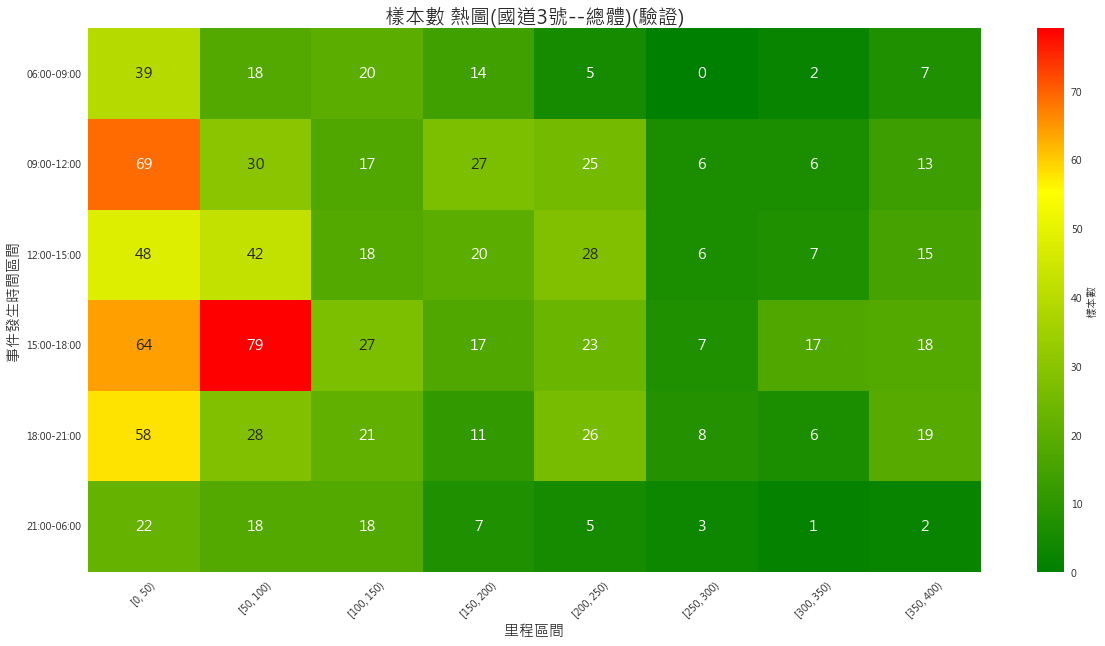

In [1126]:
# set time & mile interval
time_block = 3
mile_block = 50
time_bins = np.arange(0, 86400 + 1, time_block * 3600)
mile_bins = np.arange(real_df_highway_3['里程'].min(), real_df_highway_3['里程'].max() + 1, mile_block, dtype=int)

# add new row to cut
real_df_highway_3['事件發生時間區間'] = pd.cut(real_df_highway_3['事件發生(秒數)'], bins=time_bins, right=False)
real_df_highway_3['里程區間'] = pd.cut(real_df_highway_3['里程'], bins=mile_bins, right=False)

# count sample
sample_counts = real_df_highway_3.groupby(['事件發生時間區間', '里程區間']).size().reset_index(name='樣本數')
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].apply(merge_time_intervals)

# del repeat row and sum sample
sample_counts = sample_counts.groupby(['事件發生時間區間', '里程區間'], as_index=False).sum()

# pivot table
sample_counts['事件發生時間區間'] = sample_counts['事件發生時間區間'].astype(str)
sample_counts['里程區間'] = sample_counts['里程區間'].astype(str)
pivot_table = sample_counts.pivot("事件發生時間區間", "里程區間", "樣本數")

# reset index
pivot_table.index = pivot_table.index.map(format_time_label)

# adjust
pivot_table = pivot_table.reindex(columns=sorted(pivot_table.columns, key=lambda x: int(x.split(',')[0][1:])))
colors = [(0, "green"), (0.5, "yellow"), (1, "red")]
nodes = [0.0, 0.7, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, [color[1] for color in colors])))

# heat map
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(pivot_table, cmap=custom_cmap, annot=True, fmt="d", cbar_kws={'label': '樣本數'})
heatmap.set_title('樣本數 熱圖(國道3號--總體)(驗證)', fontsize=20)
heatmap.set_xlabel('里程區間', fontsize=15)
heatmap.set_ylabel('事件發生時間區間', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [1127]:
# def time interval
time_intervals = [
    (6 * 3600, 9 * 3600),    # 06:00-09:00
    (9 * 3600, 12 * 3600),   # 09:00-12:00
    (12 * 3600, 15 * 3600),  # 12:00-15:00
    (15 * 3600, 18 * 3600),  # 15:00-18:00
    (18 * 3600, 21 * 3600),   # 18:00-21:00
    (21 * 3600, 6 * 3600),  # 21:00-06:00
]
# def mile interval with every 50km
mile_interval_size = 50
mile_intervals = [(0, 50), (50, 100), (100, 150), (150, 200),
                  (200, 250), (250, 300), (300, 350), (350, 400)]

# init result saving
result_indices = {}

# mile interval
mile_intervals = 8
mile_interval_size = 50

# save
for time_idx, (time_start, time_end) in enumerate(time_intervals):
    for mile_idx in range(mile_intervals):
        mile_start = mile_idx * mile_interval_size
        mile_end = (mile_idx + 1) * mile_interval_size
        # for 21:00~06:00 doing special case
        if time_start > time_end:
            filtered_data = real_df_highway_3[
                ((real_df_highway_3['事件發生(秒數)'] >= time_start) | (real_df_highway_3['事件發生(秒數)'] < time_end)) &
                (real_df_highway_3['里程'] >= mile_start) & (
                    real_df_highway_3['里程'] < mile_end)
            ]
        else:
            filtered_data = real_df_highway_3[
                (real_df_highway_3['事件發生(秒數)'] >= time_start) & (real_df_highway_3['事件發生(秒數)'] < time_end) &
                (real_df_highway_3['里程'] >= mile_start) & (
                    real_df_highway_3['里程'] < mile_end)
            ]

        # save
        result_indices[(time_idx, mile_idx)] = filtered_data.index.tolist()

# result
for (time_idx, mile_idx), indices in result_indices.items():
    print(f"格子 [時間區間: {time_idx}, 里程區間: {mile_idx}] 共有 {len(indices)} 筆資料。")

格子 [時間區間: 0, 里程區間: 0] 共有 39 筆資料。
格子 [時間區間: 0, 里程區間: 1] 共有 18 筆資料。
格子 [時間區間: 0, 里程區間: 2] 共有 20 筆資料。
格子 [時間區間: 0, 里程區間: 3] 共有 14 筆資料。
格子 [時間區間: 0, 里程區間: 4] 共有 5 筆資料。
格子 [時間區間: 0, 里程區間: 5] 共有 0 筆資料。
格子 [時間區間: 0, 里程區間: 6] 共有 2 筆資料。
格子 [時間區間: 0, 里程區間: 7] 共有 7 筆資料。
格子 [時間區間: 1, 里程區間: 0] 共有 69 筆資料。
格子 [時間區間: 1, 里程區間: 1] 共有 30 筆資料。
格子 [時間區間: 1, 里程區間: 2] 共有 17 筆資料。
格子 [時間區間: 1, 里程區間: 3] 共有 27 筆資料。
格子 [時間區間: 1, 里程區間: 4] 共有 25 筆資料。
格子 [時間區間: 1, 里程區間: 5] 共有 6 筆資料。
格子 [時間區間: 1, 里程區間: 6] 共有 6 筆資料。
格子 [時間區間: 1, 里程區間: 7] 共有 13 筆資料。
格子 [時間區間: 2, 里程區間: 0] 共有 48 筆資料。
格子 [時間區間: 2, 里程區間: 1] 共有 42 筆資料。
格子 [時間區間: 2, 里程區間: 2] 共有 18 筆資料。
格子 [時間區間: 2, 里程區間: 3] 共有 20 筆資料。
格子 [時間區間: 2, 里程區間: 4] 共有 28 筆資料。
格子 [時間區間: 2, 里程區間: 5] 共有 6 筆資料。
格子 [時間區間: 2, 里程區間: 6] 共有 7 筆資料。
格子 [時間區間: 2, 里程區間: 7] 共有 15 筆資料。
格子 [時間區間: 3, 里程區間: 0] 共有 64 筆資料。
格子 [時間區間: 3, 里程區間: 1] 共有 79 筆資料。
格子 [時間區間: 3, 里程區間: 2] 共有 27 筆資料。
格子 [時間區間: 3, 里程區間: 3] 共有 17 筆資料。
格子 [時間區間: 3, 里程區間: 4] 共有 23 筆資料。
格子 [時間區間: 3, 里程區間: 5] 共有 7 筆資料。
格子 [時間區間: 3, 里程區間: 

#### 儲存個模型的指標到 df 當中(testing)

In [1131]:
# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
         '肇事車輛', '處理分鐘', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
categorical_features = [
    '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(8):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = real_sorted_df.loc[indices_to_use]
            print(f"start {grid_key} with {filtered_df.shape[0]} samples")

            # 檢查樣本數是否為0
            if filtered_df.shape[0] == 0:
                print(f"Skipped {grid_key} due to 0 samples")
                continue

            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

            # 指定 "事故類型" 的編碼
            accident_type_mapping = {'A2': 1, 'A3': 2}
            selected_df['事故類型'] = selected_df['事故類型'].map(accident_type_mapping).fillna(-1).astype(int)

            # Label Encoding for categorical features
            label_encoders = {}
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割特徵和目標變數
            X = selected_df.drop(columns=['處理分鐘'])
            y = selected_df['處理分鐘']
            y_log = np.log1p(y)

            # 調用已儲存的模型
            model_path = os.path.join(save_dir, f'r3_{i}_{j}.pkl')
            xgb_qreg_best_model = xgb.Booster()
            xgb_qreg_best_model.load_model(model_path)

            # 預測與殘差計算
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)
            
            # 確保 y 和 y_all_pred 具有相同的形狀
            if len(y_all_pred) != len(y):
                print(f"Size mismatch for {grid_key}: y_all_pred length {len(y_all_pred)} vs y length {len(y)}")
                continue
            
            residuals = y_all_pred - y
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_all_pred)
            mae = mean_absolute_error(y, y_all_pred)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"saved {grid_key} data")

# 將結果轉為DataFrame
testing_r3all_results_df = pd.DataFrame(results)
print("finish")


start (0, 0) with 39 samples
saved (0, 0) data
start (0, 1) with 18 samples
saved (0, 1) data
start (0, 2) with 20 samples
saved (0, 2) data
start (0, 3) with 14 samples
saved (0, 3) data
start (0, 4) with 5 samples
saved (0, 4) data
start (0, 5) with 0 samples
Skipped (0, 5) due to 0 samples
start (0, 6) with 2 samples
saved (0, 6) data
start (0, 7) with 7 samples
saved (0, 7) data
start (1, 0) with 69 samples
saved (1, 0) data
start (1, 1) with 30 samples
saved (1, 1) data
start (1, 2) with 17 samples
saved (1, 2) data
start (1, 3) with 27 samples
saved (1, 3) data
start (1, 4) with 25 samples
saved (1, 4) data
start (1, 5) with 6 samples
saved (1, 5) data
start (1, 6) with 6 samples
saved (1, 6) data
start (1, 7) with 13 samples
saved (1, 7) data
start (2, 0) with 48 samples
saved (2, 0) data
start (2, 1) with 42 samples
saved (2, 1) data
start (2, 2) with 18 samples
saved (2, 2) data
start (2, 3) with 20 samples
saved (2, 3) data
start (2, 4) with 28 samples
saved (2, 4) data
start

In [1132]:
# 新增「國道」變數並全部填上「國道一號」
testing_r3all_results_df.insert(0, '國道', '國道三號')
testing_r3all_results_df.insert(1, '月份資料', '113年1~2月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350),
    (350, 400)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
testing_r3all_results_df['時間'] = testing_r3all_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
testing_r3all_results_df['里程'] = testing_r3all_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in testing_r3all_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
testing_r3all_results_df = testing_r3all_results_df[cols]

# 刪除「grid」列
testing_r3all_results_df.drop(columns=['Grid'], inplace=True)
# save
testing_r3all_results_df.to_excel(
    'testing_r3all_results_df.xlsx', index=False)
testing_r3all_results_df

國道        月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道三號  113年1~2月資料  06:00-09:00     0~50             39                  0   
1   國道三號  113年1~2月資料  06:00-09:00   50~100             18                  1   
2   國道三號  113年1~2月資料  06:00-09:00  100~150             20                  2   
3   國道三號  113年1~2月資料  06:00-09:00  150~200             14                  0   
4   國道三號  113年1~2月資料  06:00-09:00  200~250              5                  1   
5   國道三號  113年1~2月資料  06:00-09:00  300~350              2                  0   
6   國道三號  113年1~2月資料  06:00-09:00  350~400              7                  0   
7   國道三號  113年1~2月資料  09:00-12:00     0~50             69                  0   
8   國道三號  113年1~2月資料  09:00-12:00   50~100             30                  0   
9   國道三號  113年1~2月資料  09:00-12:00  100~150             17                  4   
10  國道三號  113年1~2月資料  09:00-12:00  150~200             27                  0   
11  國道三號  113年1~2月資料  09:00-12:00  200~250             25                  0   
12  國道三號  113年1~2月資料  09:00-12:00  250~300              6                  0   
13  國道三號  113年1~2月資料  09:00-12:00  300~350              6                  0   
14  國道三號  113年1~2月資料  09:00-12:00  350~400             13                  2   
15  國道三號  113年1~2月資料  12:00-15:00     0~50             48                  1   
16  國道三號  113年1~2月資料  12:00-15:00   50~100             42                 19   
17  國道三號  113年1~2月資料  12:00-15:00  100~150             18                  6   
18  國道三號  113年1~2月資料  12:00-15:00  150~200             20                  2   
19  國道三號  113年1~2月資料  12:00-15:00  200~250             28                  2   
20  國道三號  113年1~2月資料  12:00-15:00  250~300              6                  0   
21  國道三號  113年1~2月資料  12:00-15:00  300~350              7                  1   
22  國道三號  113年1~2月資料  12:00-15:00  350~400             15                  0   
23  國道三號  113年1~2月資料  15:00-18:00     0~50             64                  1   
24  國道三號  113年1~2月資料  15:00-18:00   50~100             79                  1   
25  國道三號  113年1~2月資料  15:00-18:00  100~150             27                  2   
26  國道三號  113年1~2月資料  15:00-18:00  150~200             17                  0   
27  國道三號  113年1~2月資料  15:00-18:00  200~250             23                  4   
28  國道三號  113年1~2月資料  15:00-18:00  250~300              7                  0   
29  國道三號  113年1~2月資料  15:00-18:00  300~350             17                  0   
30  國道三號  113年1~2月資料  15:00-18:00  350~400             18                  2   
31  國道三號  113年1~2月資料  18:00-21:00     0~50             58                 12   
32  國道三號  113年1~2月資料  18:00-21:00   50~100             28                  9   
33  國道三號  113年1~2月資料  18:00-21:00  100~150             21                  0   
34  國道三號  113年1~2月資料  18:00-21:00  150~200             11                  2   
35  國道三號  113年1~2月資料  18:00-21:00  200~250             26                 14   
36  國道三號  113年1~2月資料  18:00-21:00  250~300              8                  1   
37  國道三號  113年1~2月資料  18:00-21:00  300~350              6                  0   
38  國道三號  113年1~2月資料  18:00-21:00  350~400             19                  0   
39  國道三號  113年1~2月資料  21:00-06:00     0~50             22                  0   
40  國道三號  113年1~2月資料  21:00-06:00   50~100             18                  1   
41  國道三號  113年1~2月資料  21:00-06:00  100~150             18                  0   
42  國道三號  113年1~2月資料  21:00-06:00  150~200              7                  1   
43  國道三號  113年1~2月資料  21:00-06:00  200~250              5                  0   
44  國道三號  113年1~2月資料  21:00-06:00  250~300              3                  0   
45  國道三號  113年1~2月資料  21:00-06:00  300~350              1                  0   
46  國道三號  113年1~2月資料  21:00-06:00  350~400              2                  0   

    Negative Outliers          MSE        MAE         Q1         Q2  \
0                   1   672.814311  16.636396   3.705298  14.009335   
1                   0  

In [1138]:
# 結果儲存變數
results = []
selected_features = ['里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
         '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
categorical_features = [
    '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]

# 假設有35個格子，範例設定為(5, 6)
for i in range(6):
    for j in range(8):
        grid_key = (i, j)
        if grid_key in result_indices:
            indices_to_use = result_indices[grid_key]
            filtered_df = real_sorted_df.loc[indices_to_use]
            print(f"start {grid_key} with {filtered_df.shape[0]} samples")

            # 檢查樣本數是否為0
            if filtered_df.shape[0] == 0:
                print(f"Skipped {grid_key} due to 0 samples")
                continue

            # 前處理和特徵工程
            selected_df = filtered_df[selected_features].copy()
            selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

            # 指定 "事故類型" 的編碼
            accident_type_mapping = {'A2': 1, 'A3': 2}
            selected_df['事故類型'] = selected_df['事故類型'].map(accident_type_mapping).fillna(-1).astype(int)

            # Label Encoding for categorical features
            label_encoders = {}
            for feature in categorical_features:
                label_encoders[feature] = LabelEncoder()
                selected_df[feature] = label_encoders[feature].fit_transform(
                    selected_df[feature].astype(str))

            selected_df['肇事車輛'].fillna(0, inplace=True)

            # 分割特徵和目標變數
            X = selected_df.drop(columns=['回堵長度'])
            y = selected_df['回堵長度']
            y_log = np.log1p(y)

            # 調用已儲存的模型
            model_path = os.path.join(save_dir, f'r3_zero_{i}_{j}.pkl')
            xgb_qreg_best_model = xgb.Booster()
            xgb_qreg_best_model.load_model(model_path)

            # 預測與殘差計算
            dall = xgb.DMatrix(X)
            y_all_pred_log = xgb_qreg_best_model.predict(dall)
            y_all_pred = np.expm1(y_all_pred_log)
            
            # 確保 y 和 y_all_pred 具有相同的形狀
            if len(y_all_pred) != len(y):
                print(f"Size mismatch for {grid_key}: y_all_pred length {len(y_all_pred)} vs y length {len(y)}")
                continue
            
            residuals = y_all_pred - y
            residuals_df = pd.DataFrame({'Residuals': residuals})

            # 計算統計量
            total_samples = residuals_df.shape[0]
            std_residuals = residuals_df['Residuals'].std()
            positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
            negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]
            mse = mean_squared_error(y, y_all_pred)
            mae = mean_absolute_error(y, y_all_pred)
            
            Q1 = np.percentile(residuals, 25)
            Q2 = np.percentile(residuals, 50)
            Q3 = np.percentile(residuals, 75)
            median = np.median(residuals)
            mean = np.mean(residuals)

            # 儲存結果
            results.append({
                'Grid': grid_key,
                'Total Samples': total_samples,
                'Positive Outliers': positive_outliers,
                'Negative Outliers': negative_outliers,
                'MSE': mse,
                'MAE': mae,
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'Median': median,
                'Mean': mean
            })
            print(f"saved {grid_key} data")

# 將結果轉為DataFrame
testing_r3all_zero_results_df = pd.DataFrame(results)
print("finish")

start (0, 0) with 39 samples
saved (0, 0) data
start (0, 1) with 18 samples
saved (0, 1) data
start (0, 2) with 20 samples
saved (0, 2) data
start (0, 3) with 14 samples
saved (0, 3) data
start (0, 4) with 5 samples
saved (0, 4) data
start (0, 5) with 0 samples
Skipped (0, 5) due to 0 samples
start (0, 6) with 2 samples
saved (0, 6) data
start (0, 7) with 7 samples
saved (0, 7) data
start (1, 0) with 69 samples
saved (1, 0) data
start (1, 1) with 30 samples
saved (1, 1) data
start (1, 2) with 17 samples
saved (1, 2) data
start (1, 3) with 27 samples
saved (1, 3) data
start (1, 4) with 25 samples
saved (1, 4) data
start (1, 5) with 6 samples
saved (1, 5) data
start (1, 6) with 6 samples
saved (1, 6) data
start (1, 7) with 13 samples
saved (1, 7) data
start (2, 0) with 48 samples
saved (2, 0) data
start (2, 1) with 42 samples
saved (2, 1) data
start (2, 2) with 18 samples
saved (2, 2) data
start (2, 3) with 20 samples
saved (2, 3) data
start (2, 4) with 28 samples
saved (2, 4) data
start

In [1139]:
# 新增「國道」變數並全部填上「國道一號」
testing_r3all_zero_results_df.insert(0, '國道', '國道三號')
testing_r3all_zero_results_df.insert(1, '月份資料', '113年1~2月資料')

# 定義時間區間和里程區間
time_intervals = [
    "06:00-09:00",
    "09:00-12:00",
    "12:00-15:00",
    "15:00-18:00",
    "18:00-21:00",
    "21:00-06:00"
]

mile_intervals = [
    (0, 50),
    (50, 100),
    (100, 150),
    (150, 200),
    (200, 250),
    (250, 300),
    (300, 350),
    (350, 400)
]

# 使用apply方法將「時間」和「里程」加入到DataFrame
testing_r3all_zero_results_df['時間'] = testing_r3all_zero_results_df['Grid'].apply(
    lambda x: time_intervals[x[0]])
testing_r3all_zero_results_df['里程'] = testing_r3all_zero_results_df['Grid'].apply(
    lambda x: f"{mile_intervals[x[1]][0]}~{mile_intervals[x[1]][1]}")

# 調整列的順序
cols = ['國道', '月份資料', '時間', '里程'] + \
    [col for col in testing_r3all_zero_results_df.columns if col not in [
        '國道', '月份資料', '時間', '里程']]
testing_r3all_zero_results_df = testing_r3all_zero_results_df[cols]

# 刪除「grid」列
testing_r3all_zero_results_df.drop(columns=['Grid'], inplace=True)
# save
testing_r3all_zero_results_df.to_excel(
    'testing_r3all_zero_results_df.xlsx', index=False)
testing_r3all_zero_results_df

國道        月份資料           時間       里程  Total Samples  Positive Outliers  \
0   國道三號  113年1~2月資料  06:00-09:00     0~50             39                 10   
1   國道三號  113年1~2月資料  06:00-09:00   50~100             18                  0   
2   國道三號  113年1~2月資料  06:00-09:00  100~150             20                  1   
3   國道三號  113年1~2月資料  06:00-09:00  150~200             14                  2   
4   國道三號  113年1~2月資料  06:00-09:00  200~250              5                  2   
5   國道三號  113年1~2月資料  06:00-09:00  300~350              2                  2   
6   國道三號  113年1~2月資料  06:00-09:00  350~400              7                  7   
7   國道三號  113年1~2月資料  09:00-12:00     0~50             69                  0   
8   國道三號  113年1~2月資料  09:00-12:00   50~100             30                  0   
9   國道三號  113年1~2月資料  09:00-12:00  100~150             17                  1   
10  國道三號  113年1~2月資料  09:00-12:00  150~200             27                  1   
11  國道三號  113年1~2月資料  09:00-12:00  200~250             25                  1   
12  國道三號  113年1~2月資料  09:00-12:00  250~300              6                  1   
13  國道三號  113年1~2月資料  09:00-12:00  300~350              6                  6   
14  國道三號  113年1~2月資料  09:00-12:00  350~400             13                 13   
15  國道三號  113年1~2月資料  12:00-15:00     0~50             48                  1   
16  國道三號  113年1~2月資料  12:00-15:00   50~100             42                 16   
17  國道三號  113年1~2月資料  12:00-15:00  100~150             18                  2   
18  國道三號  113年1~2月資料  12:00-15:00  150~200             20                  1   
19  國道三號  113年1~2月資料  12:00-15:00  200~250             28                  0   
20  國道三號  113年1~2月資料  12:00-15:00  250~300              6                  6   
21  國道三號  113年1~2月資料  12:00-15:00  300~350              7                  7   
22  國道三號  113年1~2月資料  12:00-15:00  350~400             15                 15   
23  國道三號  113年1~2月資料  15:00-18:00     0~50             64                  2   
24  國道三號  113年1~2月資料  15:00-18:00   50~100             79                  4   
25  國道三號  113年1~2月資料  15:00-18:00  100~150             27                  0   
26  國道三號  113年1~2月資料  15:00-18:00  150~200             17                  0   
27  國道三號  113年1~2月資料  15:00-18:00  200~250             23                  2   
28  國道三號  113年1~2月資料  15:00-18:00  250~300              7                  0   
29  國道三號  113年1~2月資料  15:00-18:00  300~350             17                 17   
30  國道三號  113年1~2月資料  15:00-18:00  350~400             18                  0   
31  國道三號  113年1~2月資料  18:00-21:00     0~50             58                  1   
32  國道三號  113年1~2月資料  18:00-21:00   50~100             28                  0   
33  國道三號  113年1~2月資料  18:00-21:00  100~150             21                  0   
34  國道三號  113年1~2月資料  18:00-21:00  150~200             11                  1   
35  國道三號  113年1~2月資料  18:00-21:00  200~250             26                  0   
36  國道三號  113年1~2月資料  18:00-21:00  250~300              8                  0   
37  國道三號  113年1~2月資料  18:00-21:00  300~350              6                  6   
38  國道三號  113年1~2月資料  18:00-21:00  350~400             19                 19   
39  國道三號  113年1~2月資料  21:00-06:00     0~50             22                  0   
40  國道三號  113年1~2月資料  21:00-06:00   50~100             18                  0   
41  國道三號  113年1~2月資料  21:00-06:00  100~150             18                  0   
42  國道三號  113年1~2月資料  21:00-06:00  150~200              7                  0   
43  國道三號  113年1~2月資料  21:00-06:00  200~250              5                  0   
44  國道三號  113年1~2月資料  21:00-06:00  250~300              3                  3   
45  國道三號  113年1~2月資料  21:00-06:00  300~350              1                  0   
46  國道三號  113年1~2月資料  21:00-06:00  350~400              2                  0   

    Negative Outliers           MSE           MAE            Q1            Q2  \
0                   0  6.775397e+00  2.117823e+00  5.356050e-01  1.254263e+00   
1  

### 國道3甲

In [207]:
# "國道3甲"
df_highway_3_i = sorted_df[sorted_df['國道名稱'] == '國道3甲']
# variable
df_highway_3_i = df_highway_3_i[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_3_i


國道名稱 方向   里程      事件發生      事件排除  處理分鐘
5111   國道3甲  東  5.0  18:36:00  18:46:00    10
5141   國道3甲  東  4.8  09:31:00  09:38:00     7
5211   國道3甲  西  4.8  08:13:00  08:45:00    32
9936   國道3甲  西  4.5  08:24:00  08:33:00     9
10060  國道3甲  西  4.7  22:15:00  22:45:00    30
...     ... ..  ...       ...       ...   ...
788    國道3甲  西  3.0  08:55:00  09:09:00    14
1731   國道3甲  東  5.3  22:05:00  22:17:00    12
5140   國道3甲  西  0.4  09:13:00  09:26:00    13
7279   國道3甲  東  4.8  08:54:00  09:00:00     6
14833  國道3甲  西  5.6  17:17:00  17:20:00     3

[147 rows x 6 columns]

In [209]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_3_i['事件發生(秒數)'] = df_highway_3_i['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_4['事件排除(秒數)'] = df_highway_3_i['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_3_i['處理分鐘(秒數)'] = df_highway_3_i['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_3_i[df_highway_3_i['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_3_i[df_highway_3_i['方向'] == '西']
df_west_direction

國道名稱 方向   里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
5211   國道3甲  西  4.8  08:13:00  08:45:00    32     29580     31500      1920
9936   國道3甲  西  4.5  08:24:00  08:33:00     9     30240     30780       540
10060  國道3甲  西  4.7  22:15:00  22:45:00    30     80100     81900      1800
10313  國道3甲  西  5.6  17:06:00  17:15:00     9     61560     62100       540
7343   國道3甲  西  0.8  08:45:00  08:46:00     1     31500     31560        60
8405   國道3甲  西  0.8  08:45:00  08:46:00     1     31500     31560        60
22022  國道3甲  西  0.8  08:45:00  08:46:00     1     31500     31560        60
3368   國道3甲  西  5.4  13:10:00  13:24:00    14     47400     48240       840
7828   國道3甲  西  5.4  13:10:00  13:24:00    14     47400     48240       840
13028  國道3甲  西  5.4  13:10:00  13:24:00    14     47400     48240       840
6580   國道3甲  西  0.8  08:26:00  08:52:00    26     30360     31920      1560
7150   國道3甲  西  0.9  09:05:00  09:19:00    14     32700     33540       840
7165   國道3甲  西  4.1  18:38:00  18:49:00    11     67080     67740       660
9509   國道3甲  西  1.2  06:16:00  07:18:00    62     22560     26280      3720
20329  國道3甲  西  4.5  07:45:00  08:02:00    17     27900     28920      1020
15646  國道3甲  西  5.0  17:06:00  17:10:00     4     61560     61800       240
22690  國道3甲  西  5.0  17:06:00  17:10:00     4     61560     61800       240
24325  國道3甲  西  5.0  17:06:00  17:10:00     4     61560     61800       240
2957   國道3甲  西  5.0  18:53:00  19:09:00    16     67980     68940       960
13642  國道3甲  西  5.0  18:53:00  19:09:00    16     67980     68940       960
16408  國道3甲  西  5.0  18:53:00  19:09:00    16     67980     68940       960
13365  國道3甲  西  5.0  17:49:00  17:51:00     2     64140     64260       120
21331  國道3甲  西  5.0  17:49:00  17:51:00     2     64140     64260       120
26682  國道3甲  西  5.0  17:49:00  17:51:00     2     64140     64260       120
21627  國道3甲  西  3.0  08:39:00  09:10:00    31     31140     33000      1860
26695  國道3甲  西  3.0  08:39:00  09:10:00    31     31140     33000      1860
15926  國道3甲  西  0.2  07:40:00  07:46:00     6     27600     27960       360
18748  國道3甲  西  0.2  07:40:00  07:46:00     6     27600     27960       360
21104  國道3甲  西  0.2  07:40:00  07:46:00     6     27600     27960       360
24729  國道3甲  西  0.2  07:40:00  07:46:00     6     27600     27960       360
24842  國道3甲  西  0.2  07:40:00  07:46:00     6     27600     27960       360
12902  國道3甲  西  0.2  17:54:00  17:59:00     5     64440     64740       300
21768  國道3甲  西  0.2  17:54:00  17:59:00     5     64440     64740       300
256    國道3甲  西  3.0  15:33:00  15:39:00     6     55980     56340       360
14463  國道3甲  西  3.0  15:33:00  15:39:00     6     55980     56340       360
7761   國道3甲  西  0.5  12:37:00  13:00:00    23     45420     46800      1380
20675  國道3甲  西  0.5  12:37:00  13:00:00    23     45420     46800      1380
18762  國道3甲  西  0.1  15:22:00  15:29:00     7     55320     55740       420
575    國道3甲  西  3.0  16:58:00  17:22:00    24     61080     62520      1440
788    國道3甲  西  3.0  08:55:00  09:09:00    14     32100     32940       840
5140   國道3甲  西  0.4  09:13:00  09:26:00    13     33180     33960       780
14833  國道3甲  西  5.6  17:17:00  17:20:00     3     62220     62400       180

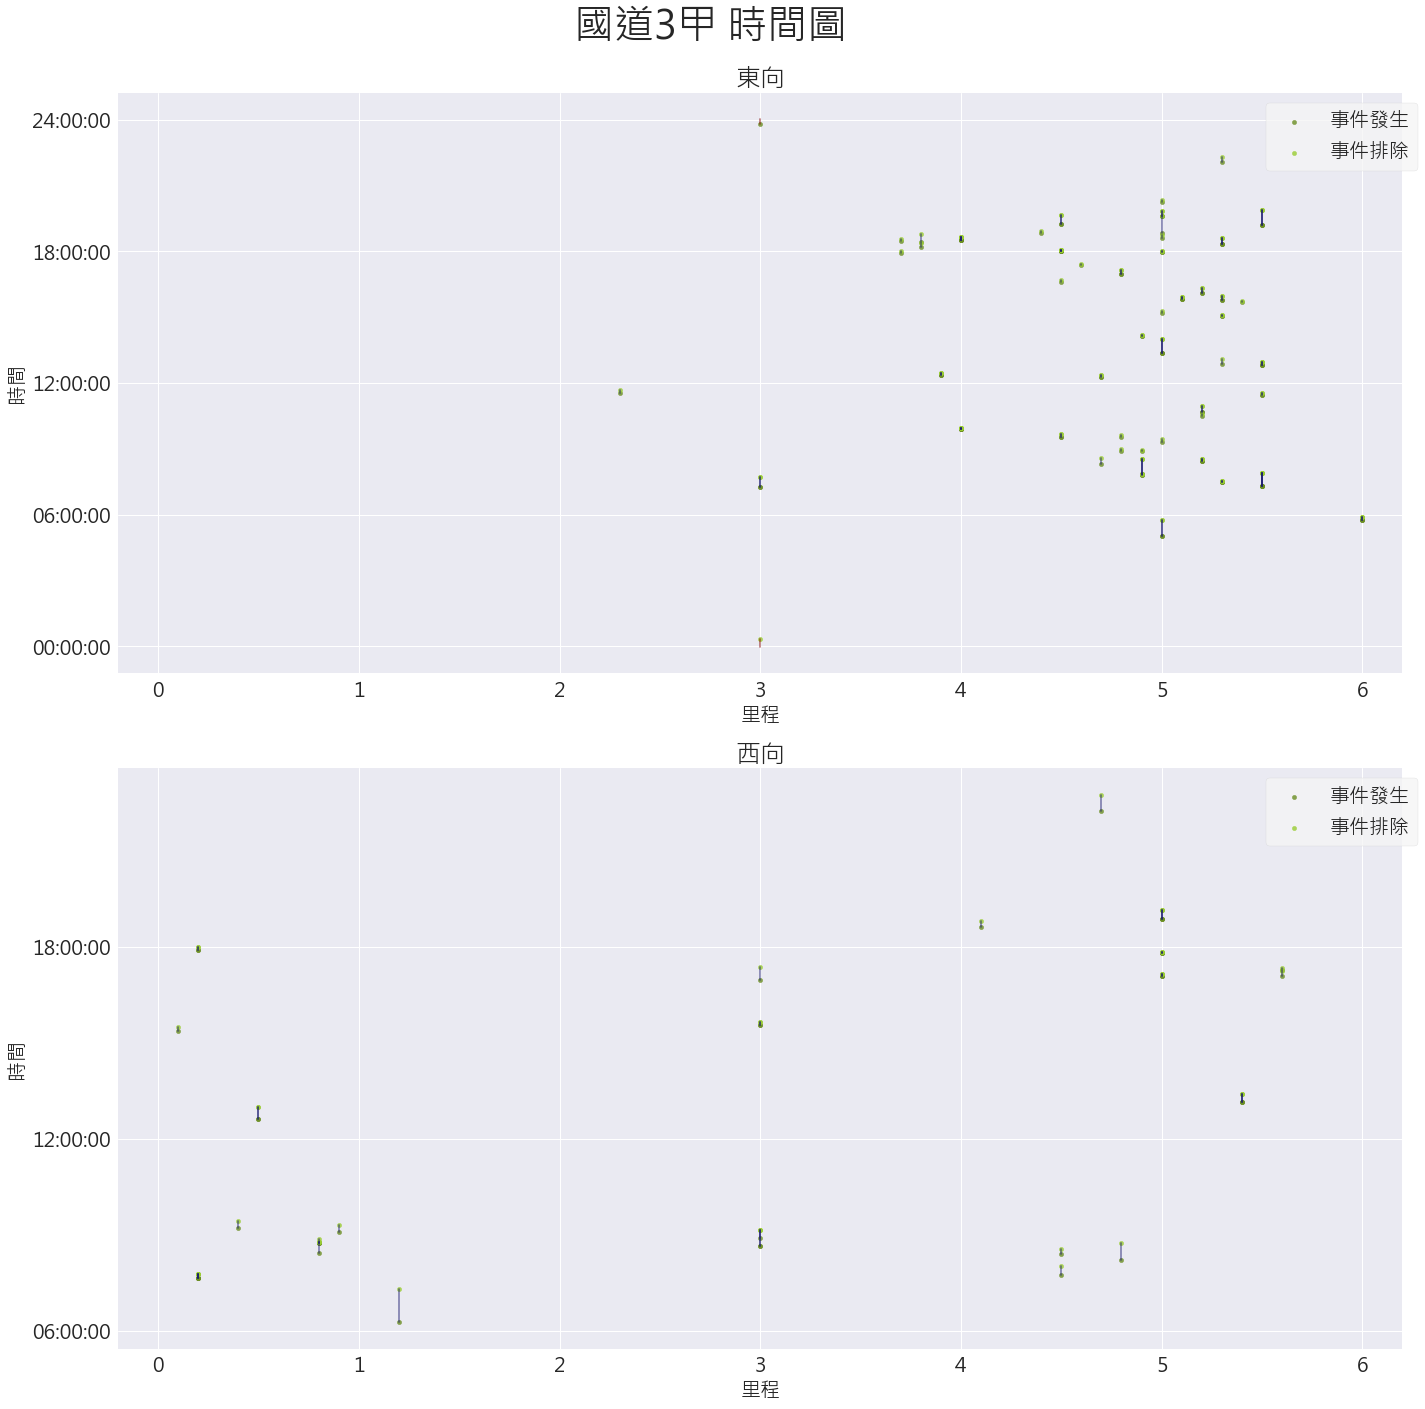

In [213]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道3甲 時間圖', fontsize=40)


# set xlim
ax1.set_xlim(-0.2, 6.2)
ax2.set_xlim(-0.2, 6.2)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道4號

In [198]:
# "國道4號"
df_highway_4 = sorted_df[sorted_df['國道名稱'] == '國道2號']
# variable
df_highway_4 = df_highway_4[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_4


國道名稱 方向    里程      事件發生      事件排除  處理分鐘
5091   國道2號  東  16.2  09:02:00  09:36:00    34
5118   國道2號  西   4.0  11:21:00  11:51:00    30
5134   國道2號  東  19.6  07:18:00  07:46:00    28
5153   國道2號  東  11.0  16:39:00  16:46:00     7
5167   國道2號  東  17.6  07:42:00  07:52:00    10
...     ... ..   ...       ...       ...   ...
15496  國道2號  東  19.0  09:16:00  09:36:00    20
15747  國道2號  西   4.0  12:48:00  13:12:00    24
16266  國道2號  西   4.0  18:37:00  18:52:00    15
16265  國道2號  西  12.2  18:49:00  18:50:00     1
16273  國道2號  東   4.8  18:33:00  18:56:00    23

[1072 rows x 6 columns]

In [199]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_4['事件發生(秒數)'] = df_highway_4['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_4['事件排除(秒數)'] = df_highway_4['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_4['處理分鐘(秒數)'] = df_highway_4['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_4[df_highway_4['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_4[df_highway_4['方向'] == '西']
df_west_direction

國道名稱 方向    里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
5118   國道2號  西   4.0  11:21:00  11:51:00    30     40860     42660      1800
5170   國道2號  西  10.3  08:35:00  09:14:00    39     30900     33240      2340
5190   國道2號  西  11.0  16:58:00  17:00:00     2     61080     61200       120
5221   國道2號  西   1.0  09:48:00  10:12:00    24     35280     36720      1440
9570   國道2號  西  10.8  10:19:00  10:25:00     6     37140     37500       360
...     ... ..   ...       ...       ...   ...       ...       ...       ...
14688  國道2號  西   5.8  16:32:00  16:36:00     4     59520     59760       240
14987  國道2號  西  10.5  16:10:00  16:16:00     6     58200     58560       360
15747  國道2號  西   4.0  12:48:00  13:12:00    24     46080     47520      1440
16266  國道2號  西   4.0  18:37:00  18:52:00    15     67020     67920       900
16265  國道2號  西  12.2  18:49:00  18:50:00     1     67740     67800        60

[604 rows x 9 columns]

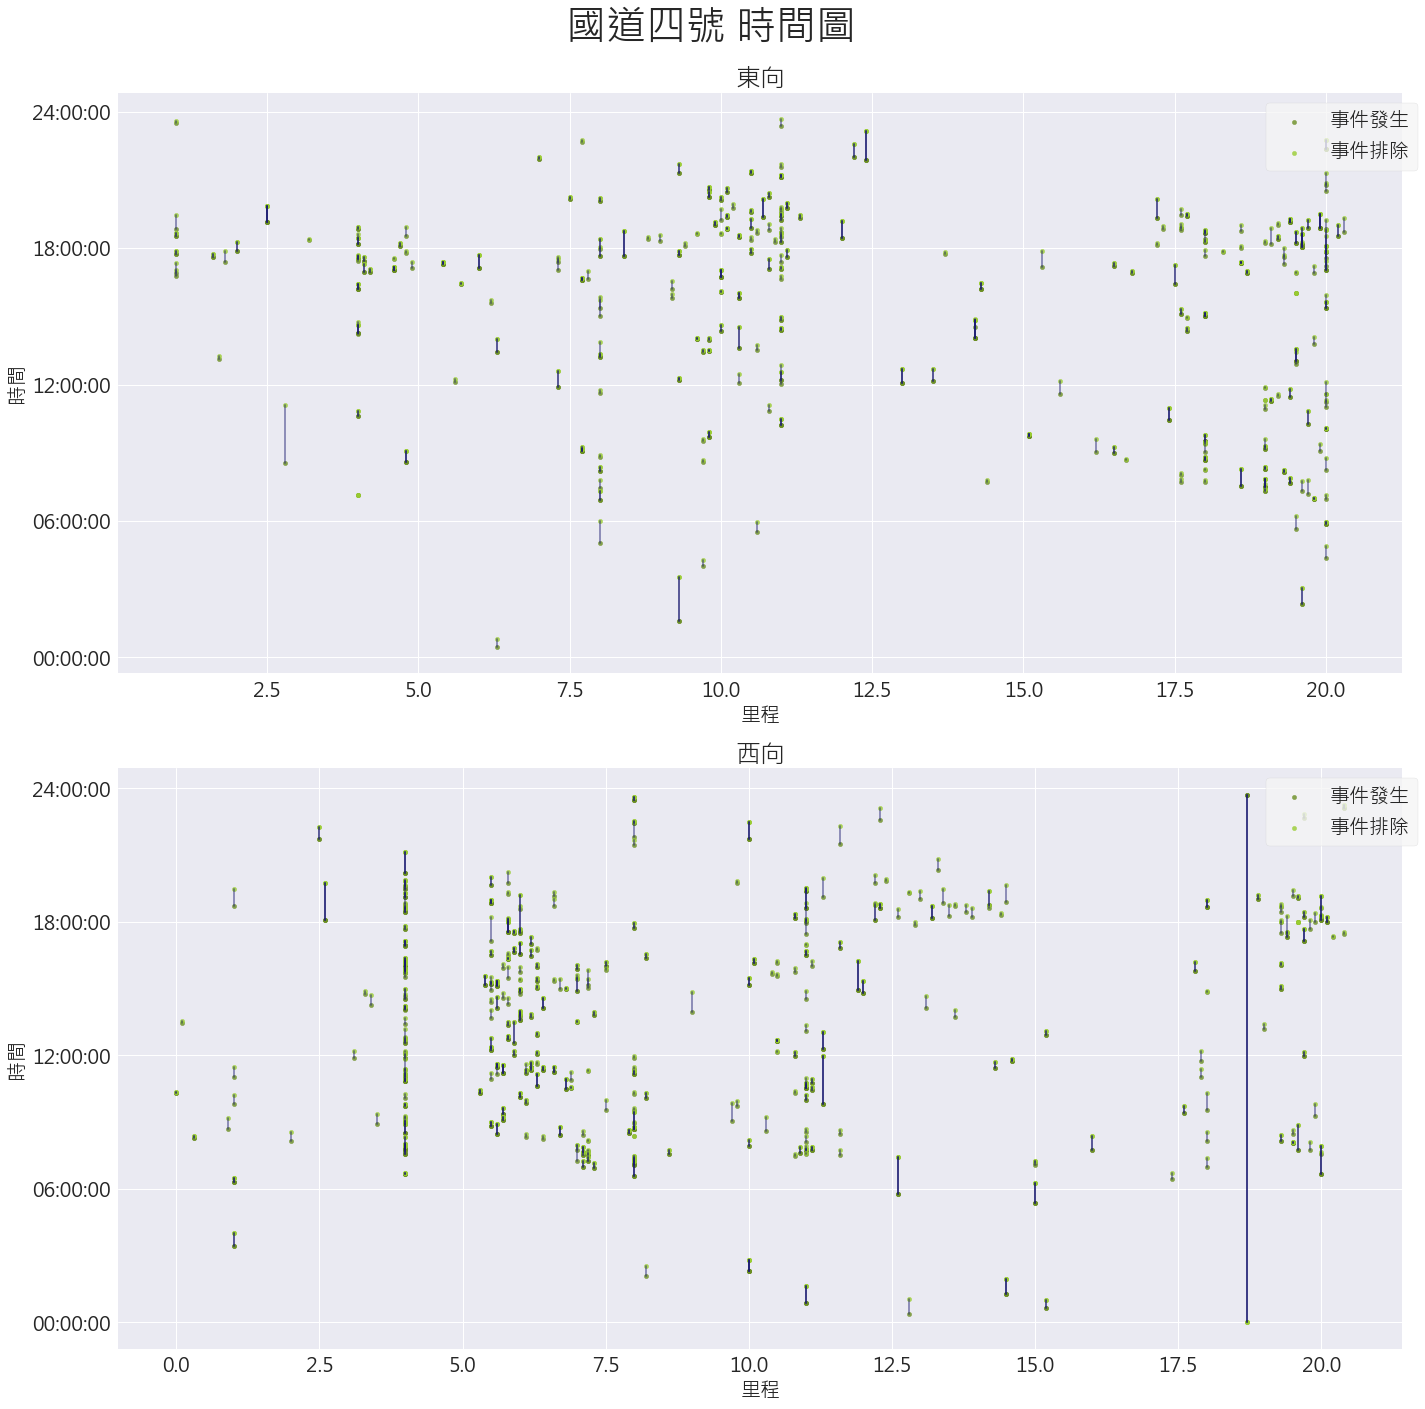

In [201]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道四號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道5號

In [195]:
# "國道5號"
df_highway_5 = sorted_df[sorted_df['國道名稱'] == '國道5號']
# variable
df_highway_5 = df_highway_5[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_5


國道名稱 方向    里程      事件發生      事件排除  處理分鐘
14455  國道5號  南  15.6  13:28:00  14:21:00    53
19661  國道5號  南  15.6  13:28:00  14:21:00    53
19662  國道5號  南  15.6  13:48:00  13:55:00     7
19663  國道5號  北  24.3  16:51:00  16:55:00     4
19664  國道5號  南  48.7  01:32:00  02:16:00    44
...     ... ..   ...       ...       ...   ...
16186  國道5號  南  14.8  18:11:00  18:20:00     9
16192  國道5號  北  36.4  08:35:00  09:20:00    45
16191  國道5號  北   6.4  15:10:00  15:49:00    39
16190  國道5號  北  20.0  16:49:00  16:51:00     2
16193  國道5號  南  23.6  11:51:00  13:05:00    14

[327 rows x 6 columns]

In [196]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_5['事件發生(秒數)'] = df_highway_5['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_5['事件排除(秒數)'] = df_highway_5['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_5['處理分鐘(秒數)'] = df_highway_5['處理分鐘'] * 60

# take "北"向的
df_north_direction = df_highway_5[df_highway_5['方向'] == '北']
df_north_direction

# take "南"向的
df_south_direction = df_highway_5[df_highway_5['方向'] == '南']
df_south_direction

國道名稱 方向    里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
14455  國道5號  南  15.6  13:28:00  14:21:00    53     48480     51660      3180
19661  國道5號  南  15.6  13:28:00  14:21:00    53     48480     51660      3180
19662  國道5號  南  15.6  13:48:00  13:55:00     7     49680     50100       420
19664  國道5號  南  48.7  01:32:00  02:16:00    44      5520      8160      2640
19667  國道5號  南   2.0  06:04:00  06:36:00    32     21840     23760      1920
...     ... ..   ...       ...       ...   ...       ...       ...       ...
16185  國道5號  南  15.7  11:33:00  11:38:00     5     41580     41880       300
16189  國道5號  南   9.3  15:37:00  16:01:00    24     56220     57660      1440
16187  國道5號  南  19.4  17:42:00  17:52:00    10     63720     64320       600
16186  國道5號  南  14.8  18:11:00  18:20:00     9     65460     66000       540
16193  國道5號  南  23.6  11:51:00  13:05:00    14     42660     47100       840

[148 rows x 9 columns]

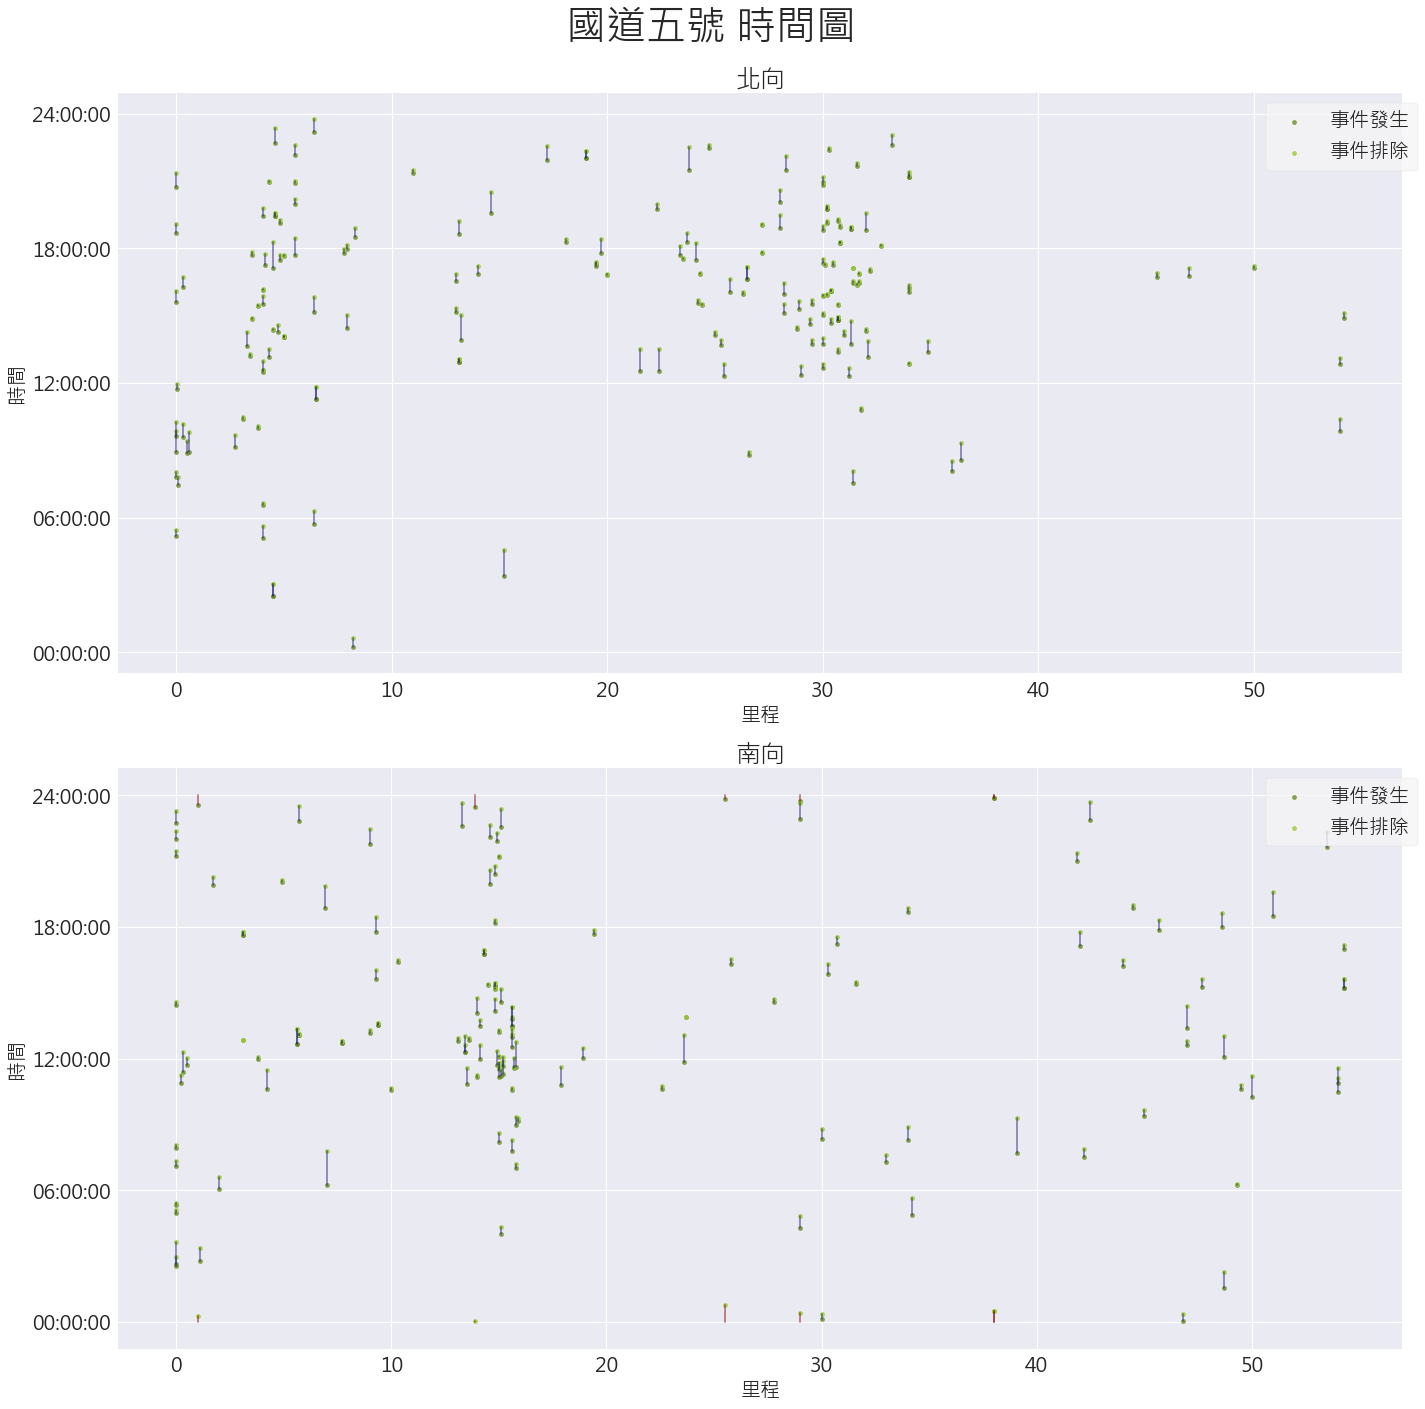

In [197]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# 上半部分 - 北向資料
# def x, y
x = df_north_direction['里程']
y_event = df_north_direction['事件發生(秒數)']
y_clear = df_north_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_north_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('北向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 南向資料
# def x, y
x = df_south_direction['里程']
y_event = df_south_direction['事件發生(秒數)']
y_clear = df_south_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_south_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('南向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道五號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道6號

In [227]:
# "國道6號"
df_highway_6 = sorted_df[sorted_df['國道名稱'] == '國道6號']
# variable
df_highway_6 = df_highway_6[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_6


國道名稱 方向    里程      事件發生      事件排除  處理分鐘
4571  國道6號  西   3.0  19:04:00  19:17:00    13
4647  國道6號  西   0.8  17:15:00  17:21:00     6
4704  國道6號  西   1.0  14:37:00  14:47:00    10
4721  國道6號  西   4.0  19:30:00  19:46:00    16
4726  國道6號  東  20.1  10:40:00  11:29:00    49
...    ... ..   ...       ...       ...   ...
6332  國道6號  西   8.1  14:25:00  14:32:00     7
6323  國道6號  西   2.0  18:22:00  18:25:00     3
2684  國道6號  東   3.0  17:28:00  17:40:00    12
737   國道6號  西   0.5  17:59:00  18:12:00    13
508   國道6號  西   4.7  15:36:00  15:52:00    16

[142 rows x 6 columns]

In [228]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_6['事件發生(秒數)'] = df_highway_6['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_6['事件排除(秒數)'] = df_highway_6['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_6['處理分鐘(秒數)'] = df_highway_6['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_6[df_highway_6['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_6[df_highway_6['方向'] == '西']
df_west_direction

國道名稱 方向    里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
4571  國道6號  西   3.0  19:04:00  19:17:00    13     68640     69420       780
4647  國道6號  西   0.8  17:15:00  17:21:00     6     62100     62460       360
4704  國道6號  西   1.0  14:37:00  14:47:00    10     52620     53220       600
4721  國道6號  西   4.0  19:30:00  19:46:00    16     70200     71160       960
4776  國道6號  西   0.0  05:25:00  06:06:00    41     19500     21960      2460
...    ... ..   ...       ...       ...   ...       ...       ...       ...
3029  國道6號  西  11.3  14:05:00  14:10:00     5     50700     51000       300
6332  國道6號  西   8.1  14:25:00  14:32:00     7     51900     52320       420
6323  國道6號  西   2.0  18:22:00  18:25:00     3     66120     66300       180
737   國道6號  西   0.5  17:59:00  18:12:00    13     64740     65520       780
508   國道6號  西   4.7  15:36:00  15:52:00    16     56160     57120       960

[92 rows x 9 columns]

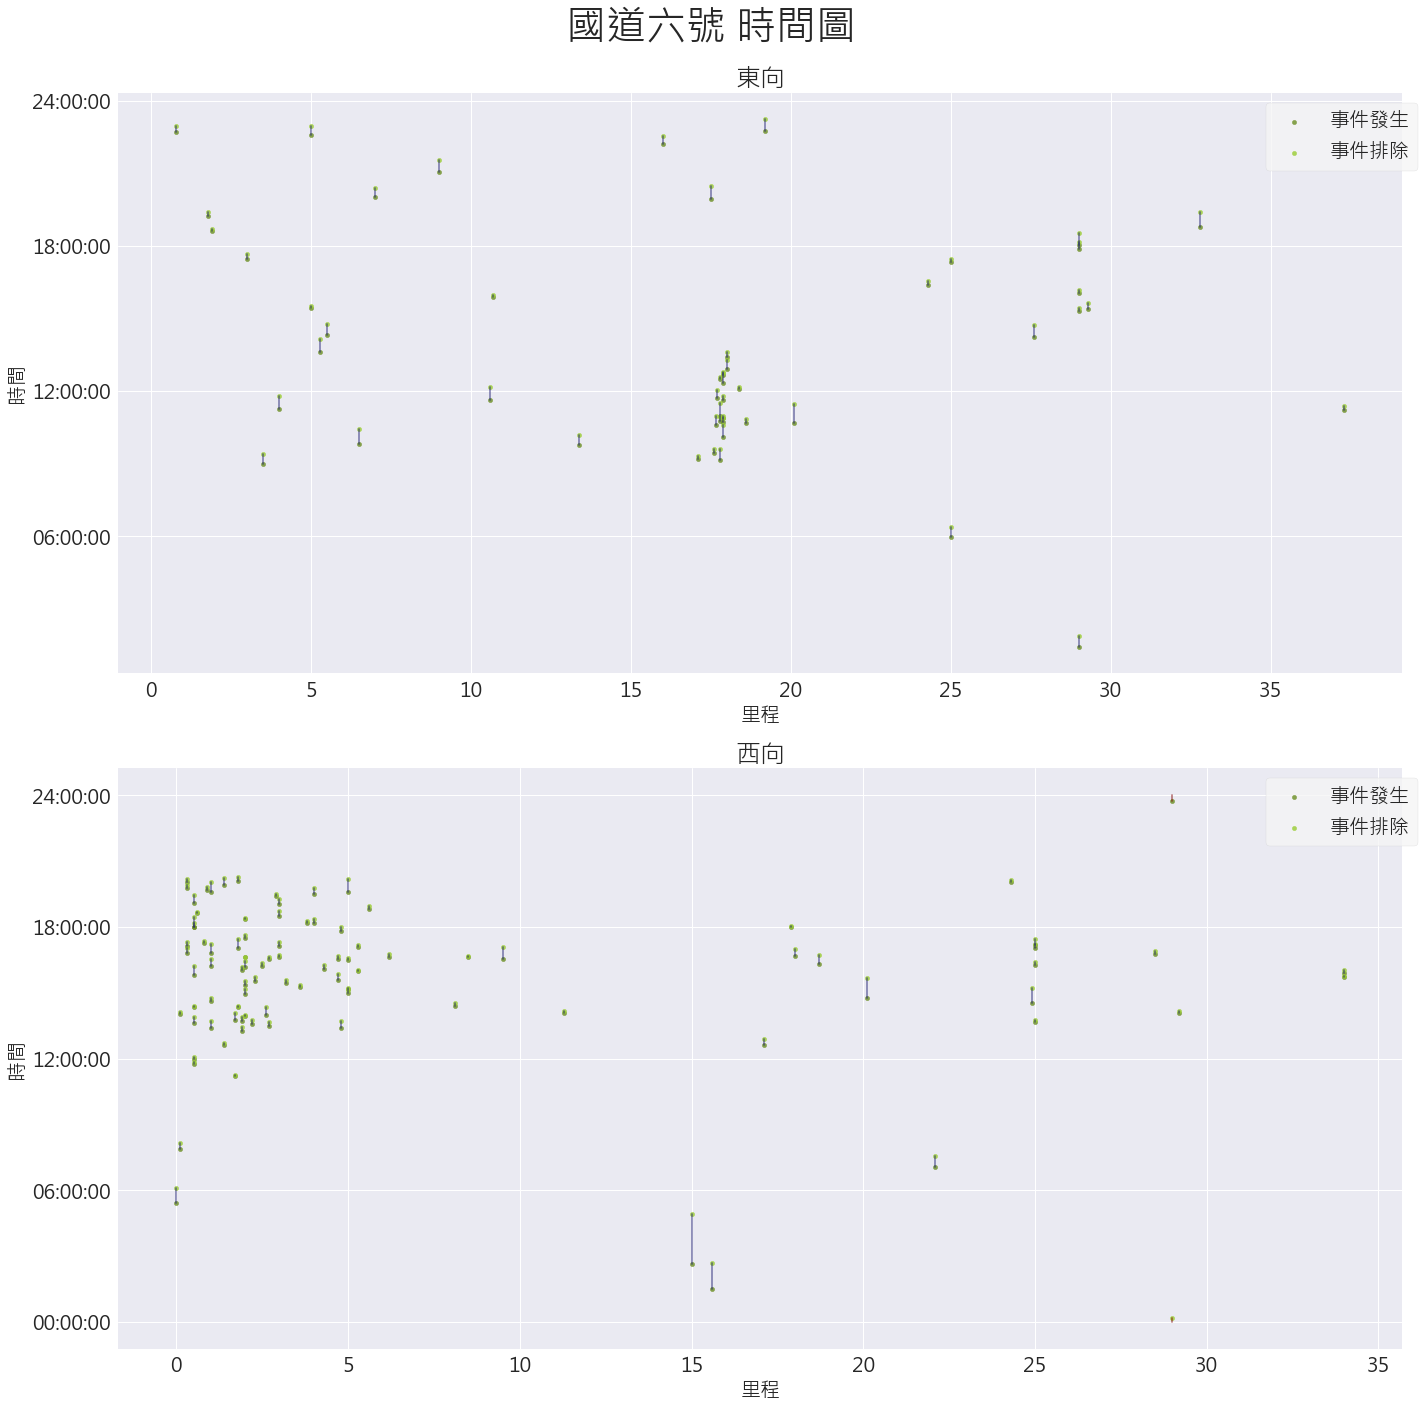

In [230]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道六號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道8號

In [232]:
# "國道8號"
df_highway_8 = sorted_df[sorted_df['國道名稱'] == '國道8號']
# variable
df_highway_8 = df_highway_8[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_8


國道名稱 方向    里程      事件發生      事件排除  處理分鐘
4047   國道8號  西   4.5  08:53:00  08:57:00     4
4096   國道8號  西   6.5  06:27:00  08:04:00    97
4212   國道8號  西   0.8  17:55:00  18:04:00     9
4272   國道8號  東   5.2  18:11:00  18:18:00     7
4329   國道8號  東  15.5  12:37:00  12:45:00     8
...     ... ..   ...       ...       ...   ...
2574   國道8號  東   4.2  07:10:00  07:26:00    16
6546   國道8號  東  10.2  07:25:00  07:52:00    27
2612   國道8號  西   9.3  11:42:00  12:05:00    23
10951  國道8號  西   8.4  15:50:00  15:54:00     4
12004  國道8號  西   8.7  20:14:00  20:53:00    39

[109 rows x 6 columns]

In [233]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_8['事件發生(秒數)'] = df_highway_8['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_8['事件排除(秒數)'] = df_highway_8['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_8['處理分鐘(秒數)'] = df_highway_8['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_8[df_highway_8['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_8[df_highway_8['方向'] == '西']
df_west_direction

國道名稱 方向    里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
4047   國道8號  西   4.5  08:53:00  08:57:00     4     31980     32220       240
4096   國道8號  西   6.5  06:27:00  08:04:00    97     23220     29040      5820
4212   國道8號  西   0.8  17:55:00  18:04:00     9     64500     65040       540
4530   國道8號  西   7.0  22:52:00  23:38:00    46     82320     85080      2760
8751   國道8號  西   4.2  09:16:00  09:37:00    21     33360     34620      1260
9013   國道8號  西   7.3  08:43:00  09:12:00    29     31380     33120      1740
9040   國道8號  西   0.7  20:44:00  21:11:00    27     74640     76260      1620
3416   國道8號  西   9.1  16:17:00  16:21:00     4     58620     58860       240
3423   國道8號  西   0.0  11:57:00  12:25:00    28     43020     44700      1680
3431   國道8號  西   0.5  17:27:00  17:39:00    12     62820     63540       720
6624   國道8號  西   6.5  17:49:00  17:51:00     2     64140     64260       120
5714   國道8號  西   0.0  12:31:00  13:11:00    40     45060     47460      2400
6020   國道8號  西   5.1  08:02:00  08:07:00     5     28920     29220       300
6120   國道8號  西   0.7  20:27:00  20:31:00     4     73620     73860       240
6129   國道8號  西   4.5  07:56:00  08:02:00     6     28560     28920       360
22090  國道8號  西   7.5  10:36:00  10:41:00     5     38160     38460       300
23511  國道8號  西   1.7  21:51:00  22:35:00    44     78660     81300      2640
23522  國道8號  西   4.6  16:33:00  16:41:00     8     59580     60060       480
23599  國道8號  西   5.7  17:42:00  17:53:00    11     63720     64380       660
21645  國道8號  西   4.4  16:24:00  16:32:00     8     59040     59520       480
21747  國道8號  西   6.5  08:36:00  09:14:00    38     30960     33240      2280
21759  國道8號  西  14.6  20:05:00  20:25:00    20     72300     73500      1200
22056  國道8號  西   9.7  17:17:00  17:19:00     2     62220     62340       120
22059  國道8號  西   6.5  17:52:00  17:59:00     7     64320     64740       420
22077  國道8號  西   6.5  04:05:00  07:08:00   183     14700     25680     10980
22168  國道8號  西   0.8  16:32:00  16:38:00     6     59520     59880       360
22526  國道8號  西   4.2  15:07:00  15:31:00    24     54420     55860      1440
7583   國道8號  西   6.5  04:42:00  06:38:00   116     16920     23880      6960
13008  國道8號  西   4.5  18:47:00  18:55:00     8     67620     68100       480
13663  國道8號  西   4.1  12:20:00  12:28:00     8     44400     44880       480
13713  國道8號  西   4.4  17:02:00  18:07:00    65     61320     65220      3900
632    國道8號  西   4.3  12:38:00  12:42:00     4     45480     45720       240
2819   國道8號  西   6.5  19:47:00  19:49:00     2     71220     71340       120
6242   國道8號  西   4.4  09:56:00  10:08:00    12     35760     36480       720
13459  國道8號  西   4.3  10:22:00  10:36:00    14     37320     38160       840
13585  國道8號  西   3.3  07:13:00  07:31:00    18     25980     27060      1080
14766  國道8號  西   7.3  17:25:00  17:47:00    22     62700     64020      1320
16624  國道8號  西   4.4  07:22:00  07:33:00    11     26520     27180       660
16633  國道8號  西   4.6  17:34:00  17:39:00     5     63240     63540       300
17836  國道8號  西   7.9  18:47:00  19:02:00    15     67620     68520       900
3234   國道8號  西   9.7  18:47:00  19:14:00    27     67620     69240      1620
7698   國道8號  西   5.1  12:57:00  13:20:00    23     46620     48000      1380
11295  國道8號  西   0.0  16:28:00  16:42:00    14     59280     60120       840
11565  國道8號  西   0.8  13:45:00  14:08:00    23     49500     50880      1380
12021  國道8號  西  14.6  16:07:00  16:15:00     8     58020     58500       480
13050  國道8號  西   1.0  01:11:00  01:18:00     7      4260      4680       420
614    國道8號  西   5.0  17:57:00  18:22:00    25     64620     66120      1500
622    國道8號  西   0.0  00:35:00  01:03:00    28      2100      3780      1680
2612   國道8號  西   9.3  11:42:00  12:05:00    23     42120     43500      1380
10951  國道8號  西   8.4  15:50:00  15:54:00     4     57000     57240       240
12004  國道8號  西   8.7  20:14:00  20:53:00    39     72840     75180      2340

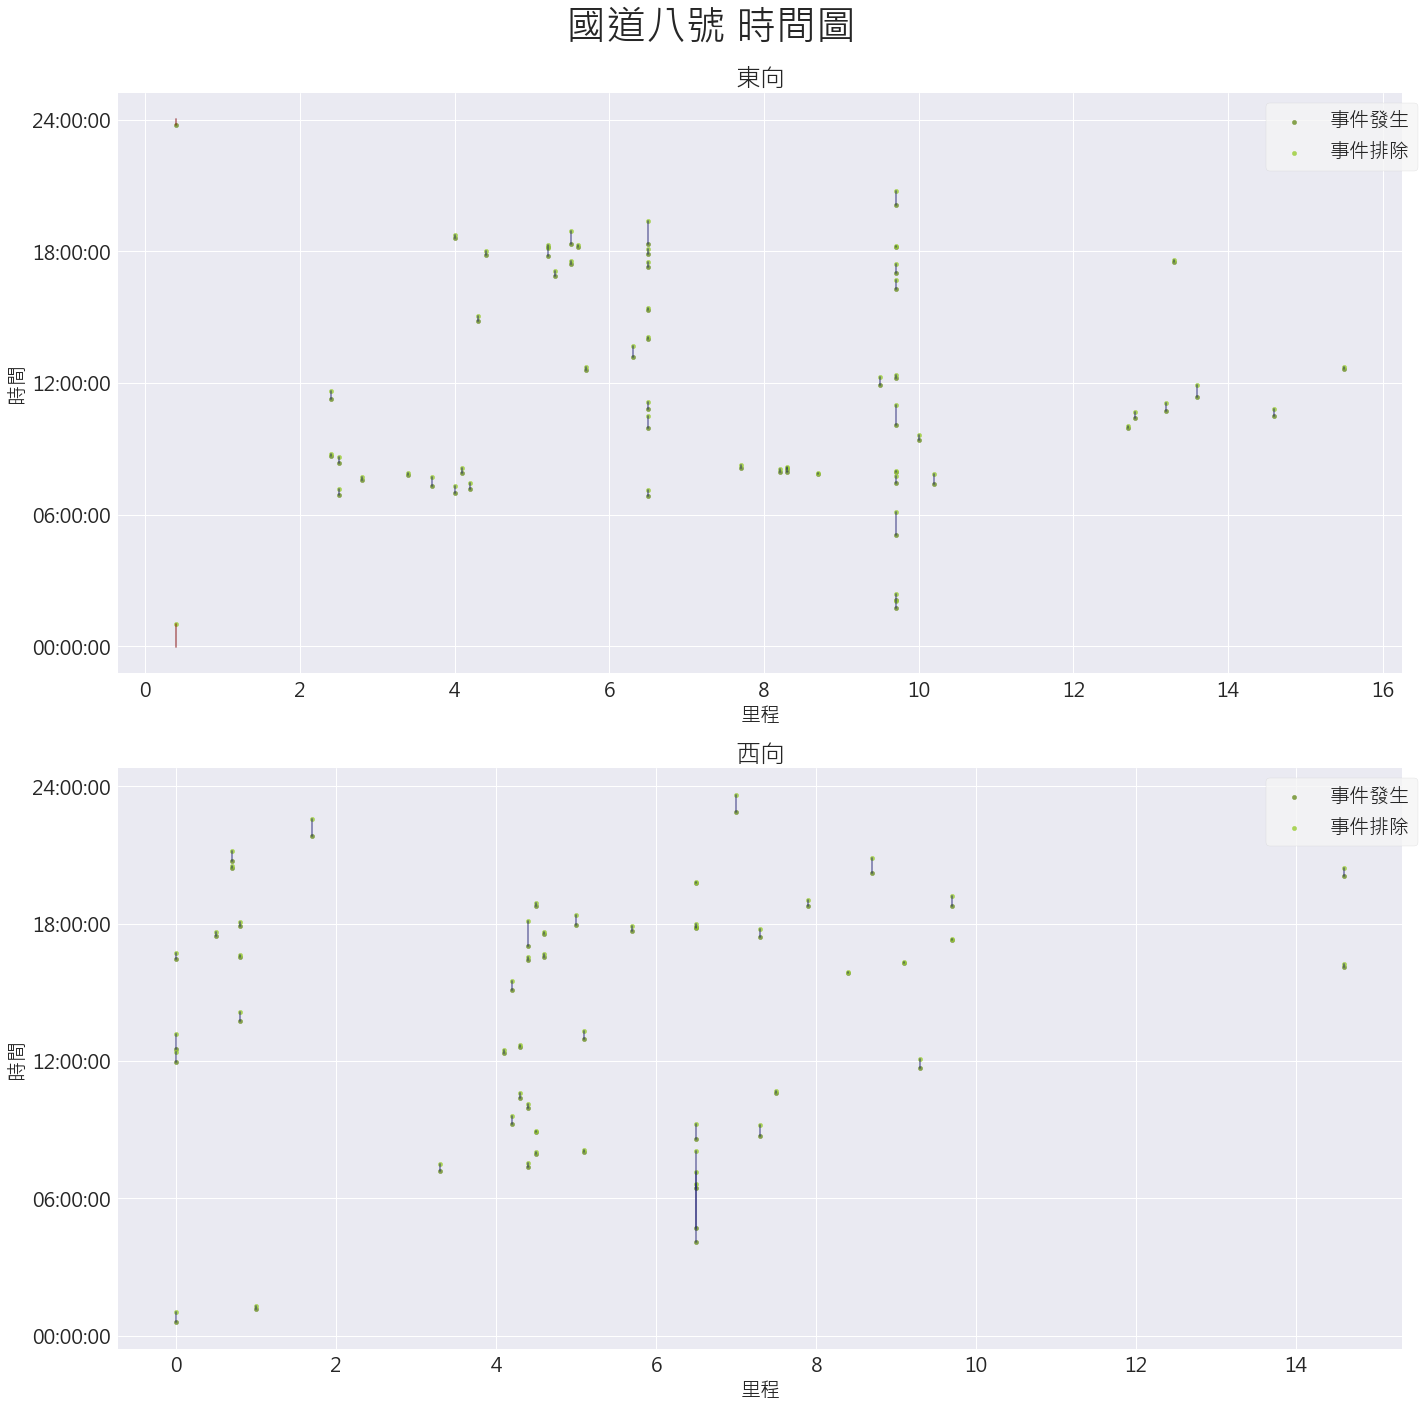

In [235]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道八號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 國道10號

In [236]:
# "國道10號"
df_highway_10 = sorted_df[sorted_df['國道名稱'] == '國道10號']
# variable
df_highway_10 = df_highway_10[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_10


國道名稱 方向    里程      事件發生      事件排除  處理分鐘
1760   國道10號  西   5.3  18:27:00  18:32:00     5
1767   國道10號  西   1.8  14:50:00  15:00:00    10
4033   國道10號  西   1.2  07:56:00  08:05:00     9
4039   國道10號  東   1.2  11:40:00  11:47:00     7
4041   國道10號  東  18.5  19:52:00  20:10:00    18
...      ... ..   ...       ...       ...   ...
10945  國道10號  西   1.8  17:36:00  17:38:00     2
10949  國道10號  西   1.5  14:53:00  14:59:00     6
10952  國道10號  西   1.8  16:02:00  16:07:00     5
10960  國道10號  西   4.7  18:20:00  18:32:00    12
12012  國道10號  西   9.5  17:30:00  17:36:00     6

[484 rows x 6 columns]

In [239]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_10['事件發生(秒數)'] = df_highway_10['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_10['事件排除(秒數)'] = df_highway_10['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_10['處理分鐘(秒數)'] = df_highway_10['處理分鐘'] * 60

# take "東"向的
df_east_direction = df_highway_10[df_highway_10['方向'] == '東']
df_east_direction

# take "西"向的
df_west_direction = df_highway_10[df_highway_10['方向'] == '西']
df_west_direction

國道名稱 方向    里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  處理分鐘(秒數)  事件排除(秒數)
1760   國道10號  西   5.3  18:27:00  18:32:00     5     66420       300     66720
1767   國道10號  西   1.8  14:50:00  15:00:00    10     53400       600     54000
4033   國道10號  西   1.2  07:56:00  08:05:00     9     28560       540     29100
4069   國道10號  西   3.5  10:55:00  11:00:00     5     39300       300     39600
4074   國道10號  西  13.0  17:59:00  18:29:00    30     64740      1800     66540
...      ... ..   ...       ...       ...   ...       ...       ...       ...
10945  國道10號  西   1.8  17:36:00  17:38:00     2     63360       120     63480
10949  國道10號  西   1.5  14:53:00  14:59:00     6     53580       360     53940
10952  國道10號  西   1.8  16:02:00  16:07:00     5     57720       300     58020
10960  國道10號  西   4.7  18:20:00  18:32:00    12     66000       720     66720
12012  國道10號  西   9.5  17:30:00  17:36:00     6     63000       360     63360

[288 rows x 9 columns]

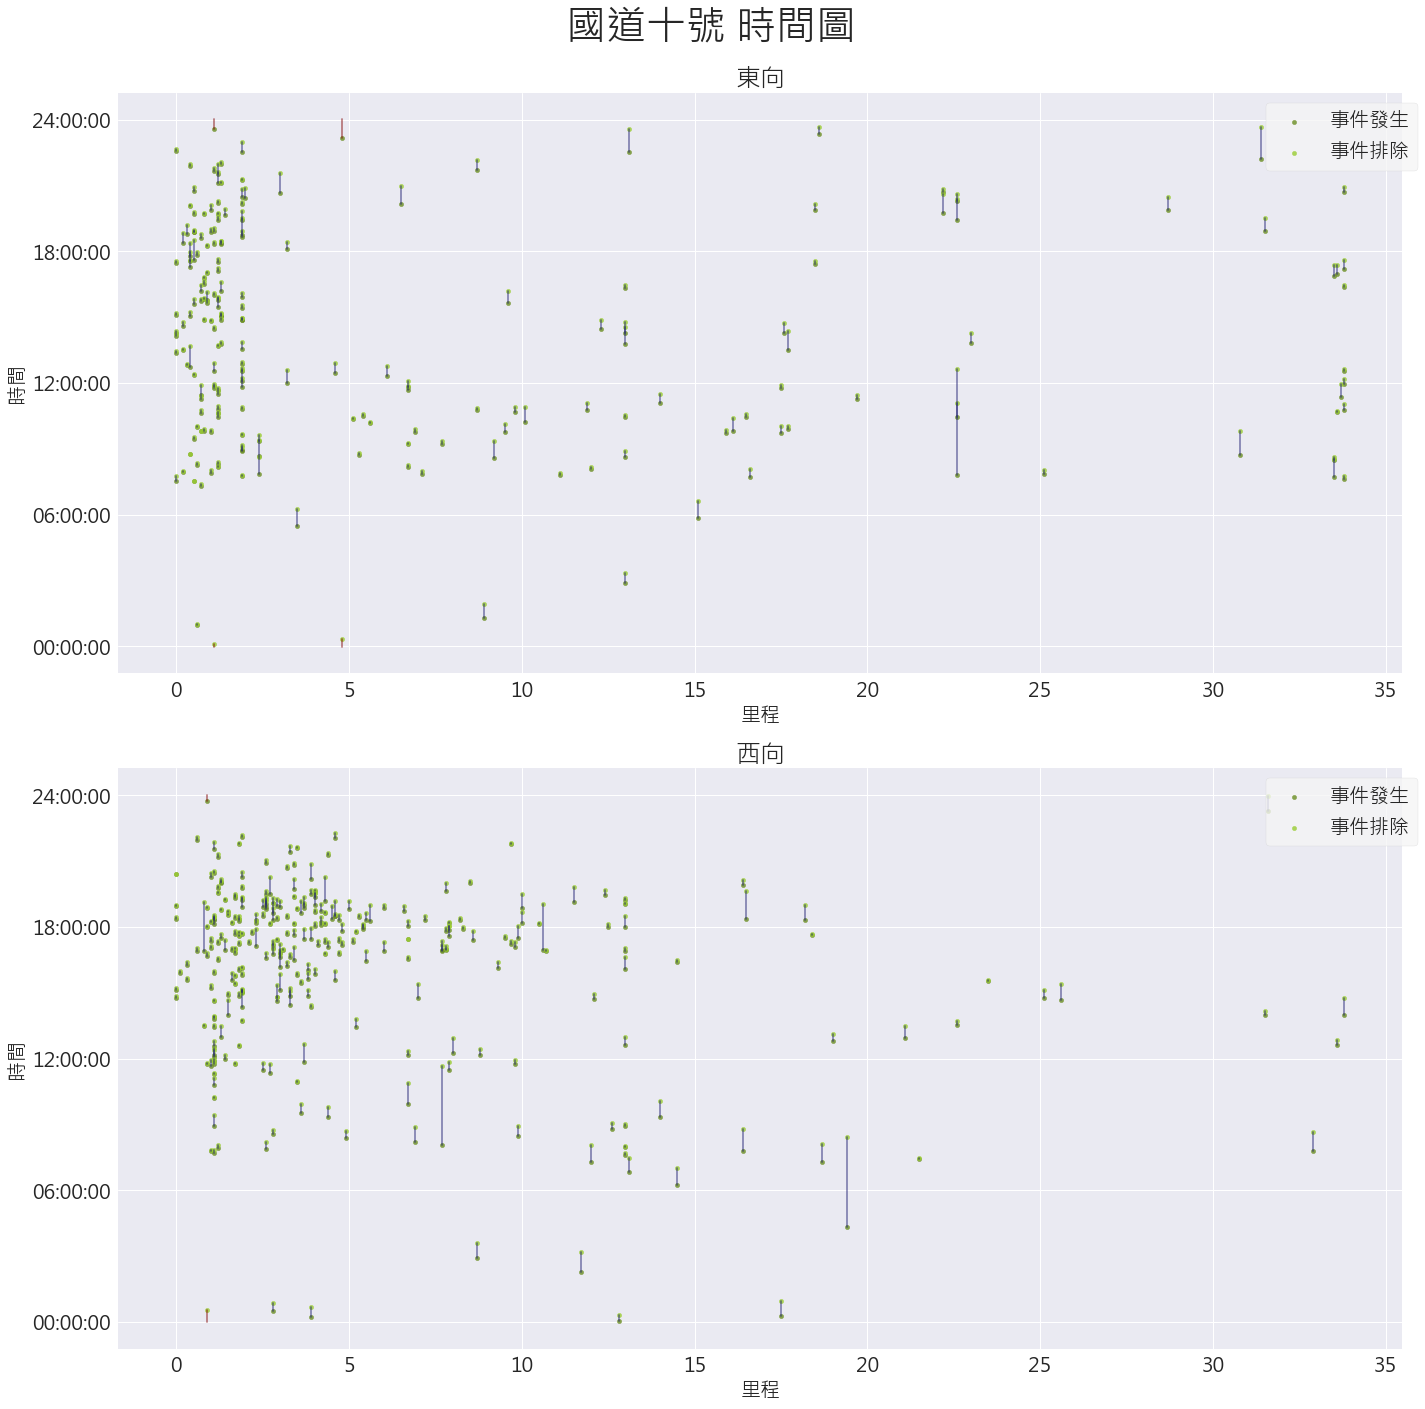

In [241]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# 上半部分 - 東向資料
# def x, y
x = df_east_direction['里程']
y_event = df_east_direction['事件發生(秒數)']
y_clear = df_east_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_east_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('東向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 西向資料
# def x, y
x = df_west_direction['里程']
y_event = df_west_direction['事件發生(秒數)']
y_clear = df_west_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_west_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('西向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('國道十號 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 南港連絡道

In [224]:
# "南港連絡道"
df_highway_s = sorted_df[sorted_df['國道名稱'] == '南港連絡道']
# variable
df_highway_s = df_highway_s[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_s


國道名稱 方向   里程      事件發生      事件排除  處理分鐘
10244  南港連絡道  北  0.7  11:35:00  13:03:00    88
10323  南港連絡道  南  0.0  18:22:00  18:51:00    29
3512   南港連絡道  北  1.4  18:40:00  19:18:00    38
12886  南港連絡道  南  0.8  12:41:00  12:53:00    12
7753   南港連絡道  南  0.8  09:03:00  09:12:00     9
17462  南港連絡道  南  0.3  10:04:00  10:42:00    38

In [225]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_s['事件發生(秒數)'] = df_highway_s['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_s['事件排除(秒數)'] = df_highway_s['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_s['處理分鐘(秒數)'] = df_highway_s['處理分鐘'] * 60

# take "北"向的
df_north_direction = df_highway_s[df_highway_s['方向'] == '北']
df_north_direction

# take "南"向的
df_south_direction = df_highway_s[df_highway_s['方向'] == '南']
df_south_direction

國道名稱 方向   里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
10323  南港連絡道  南  0.0  18:22:00  18:51:00    29     66120     67860      1740
12886  南港連絡道  南  0.8  12:41:00  12:53:00    12     45660     46380       720
7753   南港連絡道  南  0.8  09:03:00  09:12:00     9     32580     33120       540
17462  南港連絡道  南  0.3  10:04:00  10:42:00    38     36240     38520      2280

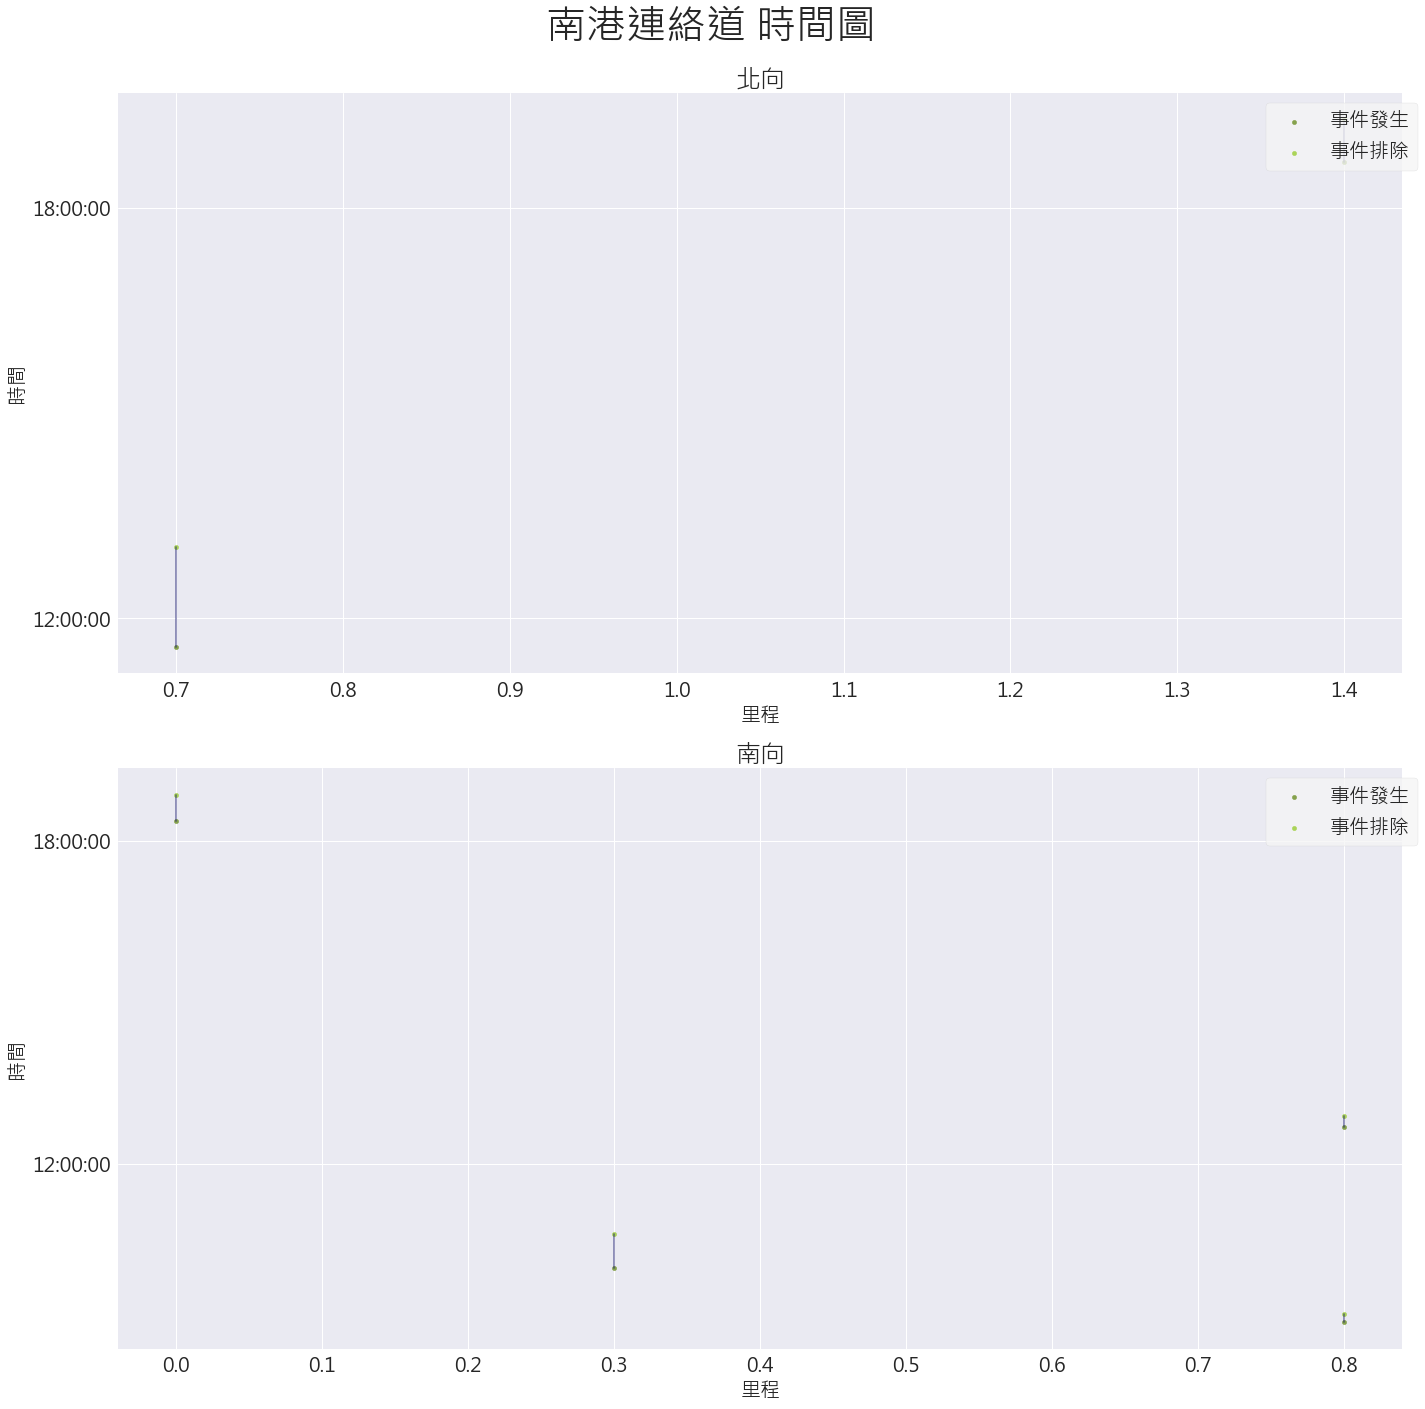

In [226]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# 上半部分 - 北向資料
# def x, y
x = df_north_direction['里程']
y_event = df_north_direction['事件發生(秒數)']
y_clear = df_north_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_north_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('北向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 南向資料
# def x, y
x = df_south_direction['里程']
y_event = df_south_direction['事件發生(秒數)']
y_clear = df_south_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_south_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('南向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('南港連絡道 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


### 港西聯外道路

In [242]:
# "港西聯外道路"
df_highway_w = sorted_df[sorted_df['國道名稱'] == '港西聯外道路']
# variable
df_highway_w = df_highway_w[['國道名稱', '方向', '里程', '事件發生', '事件排除', '處理分鐘']]
# check
df_highway_w


國道名稱 方向   里程      事件發生      事件排除  處理分鐘
2383   港西聯外道路  南  2.0  17:09:00  17:17:00     8
7347   港西聯外道路  北  0.1  11:08:00  11:55:00    47
13145  港西聯外道路  北  1.4  23:07:00  23:52:00    45
1872   港西聯外道路  北  1.0  16:56:00  17:10:00    14

In [243]:
# save '事件發生' sec to new col '事件發生(秒數)'
df_highway_w['事件發生(秒數)'] = df_highway_w['事件發生'].apply(time_to_seconds)

# save '事件排除' sec to new col '事件排除(秒數)'
df_highway_w['事件排除(秒數)'] = df_highway_w['事件排除'].apply(time_to_seconds)

# save '處理分鐘' sec to new col '處理分鐘(秒數)'
df_highway_w['處理分鐘(秒數)'] = df_highway_w['處理分鐘'] * 60

# take "北"向的
df_north_direction = df_highway_w[df_highway_w['方向'] == '北']
df_north_direction

# take "南"向的
df_south_direction = df_highway_w[df_highway_w['方向'] == '南']
df_south_direction

國道名稱 方向   里程      事件發生      事件排除  處理分鐘  事件發生(秒數)  事件排除(秒數)  處理分鐘(秒數)
2383  港西聯外道路  南  2.0  17:09:00  17:17:00     8     61740     62220       480

In [ ]:
# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# 上半部分 - 北向資料
# def x, y
x = df_north_direction['里程']
y_event = df_north_direction['事件發生(秒數)']
y_clear = df_north_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax1.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax1.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_north_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax1.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax1.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax1.set_title('北向', fontsize=25)
ax1.set_xlabel('里程', fontsize=20)
ax1.set_ylabel('時間', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
formatter = FuncFormatter(format_seconds)
ax1.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax1.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax1.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# 下半部分 - 南向資料
# def x, y
x = df_south_direction['里程']
y_event = df_south_direction['事件發生(秒數)']
y_clear = df_south_direction['事件排除(秒數)']

# scatter
# "事件發生"
ax2.scatter(x, y_event, label='事件發生', alpha=0.8, color="olivedrab", s=20)
# "事件排除"
ax2.scatter(x, y_clear, label='事件排除', alpha=0.8, color="yellowgreen", s=20)

# line of "事件發生" "事件排除"
for i in range(len(x)):
    # check if the sum of '事件發生(秒數)' and '處理分鐘(秒數)' is greater than 86400
    # means to tomorrow
    if y_event.iloc[i] + df_south_direction['處理分鐘(秒數)'].iloc[i] > 86400:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], 86500], linestyle='-', color='maroon', alpha=0.5)
        ax2.plot([x.iloc[i], x.iloc[i]], [-100, y_clear.iloc[i]], linestyle='-', color='maroon', alpha=0.5)
    else:
        ax2.plot([x.iloc[i], x.iloc[i]], [y_event.iloc[i], y_clear.iloc[i]], linestyle='-', color='midnightblue', alpha=0.5)

# adjust
ax2.set_title('南向', fontsize=25)
ax2.set_xlabel('里程', fontsize=20)
ax2.set_ylabel('時間', fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

# set formatter for y-axis
ax2.yaxis.set_major_formatter(formatter)
# set y-axis major locator to every 6 hours
ax2.yaxis.set_major_locator(plt.MultipleLocator(6 * 3600))
ax2.legend(loc='upper right', fontsize=20, bbox_to_anchor=(1.02, 1), frameon=True, facecolor='whitesmoke')

# big title
plt.suptitle('港西聯外道路 時間圖', fontsize=40)

# show
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


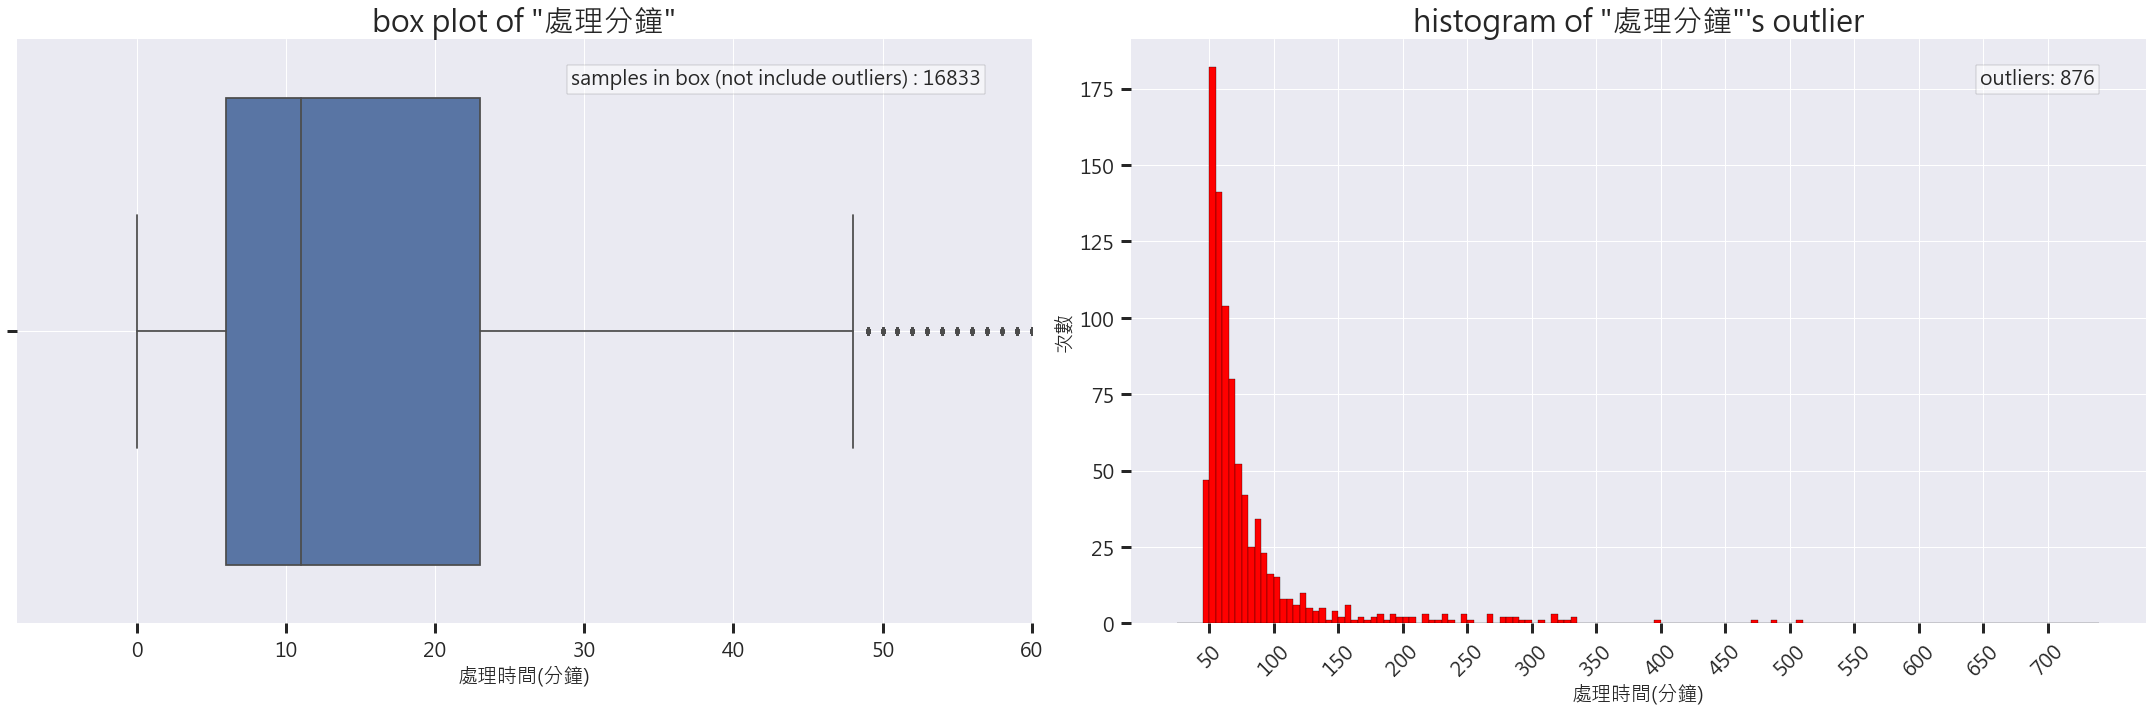

In [331]:
# "處理分鐘" box & bar plot
# find outlier
q1 = selected_df['處理分鐘'].quantile(0.25)
q3 = selected_df['處理分鐘'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = selected_df[(selected_df['處理分鐘'] < lower_bound) |
                       (selected_df['處理分鐘'] > upper_bound)]['處理分鐘']

# count how many
total_samples = len(selected_df)
total_outliers = len(outliers)

# set fig
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 1st subplot : box plot
sns.boxplot(x=selected_df['處理分鐘'], ax=axes[0])
axes[0].grid(True)
axes[0].set_xlim(-8, 60)
axes[0].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[0].set_title('box plot of "處理分鐘"', fontsize=30)
axes[0].set_xlabel('處理時間(分鐘)', fontsize=20)
axes[0].text(0.95, 0.95, f'samples in box (not include outliers) : {total_samples-total_outliers}', transform=axes[0].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# 2nd subplot : hist plot of outlier
axes[1].hist(outliers, bins=range(25, int(max(outliers)) + 2, 5), color='r', edgecolor='black')
axes[1].set_title('histogram of "處理分鐘"\'s outlier', fontsize=30)
axes[1].set_xlabel('處理時間(分鐘)', fontsize=20)
axes[1].set_ylabel('次數', fontsize=20)
axes[1].tick_params(axis='both', labelsize=20, width=3, length=10)
axes[1].set_xticks(range(50, int(max(outliers)) + 1, 50))
axes[1].tick_params(axis='x', labelsize=20, rotation=45)
axes[1].text(0.95, 0.95, f'outliers: {total_outliers}', transform=axes[1].transAxes,
             fontsize=20, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

# show
plt.tight_layout()
plt.show()

# process data

In [22]:
# # process data
# y_col = '處理分鐘'
# X = df.drop(columns=[y_col])
# y = df[y_col]
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=65536)

In [89]:
selected_df = sorted_df[selected_features].copy()
selected_df_cleaned = selected_df.dropna()
selected_df_cleaned

Empty DataFrame
Columns: [國道名稱, 里程, 方向, 事故類型, 內路肩, 內車道, 中內車道, 中車道, 中外車道, 外車道, 外路肩, 匝道, 肇事車輛, 處理分鐘, 是否為假日, 是否為相近時間, 是否為相近地點, 相近時間&地點是否有事件, 事故車是否包含非小客車]
Index: []

In [64]:
# preprocess
# keep specific & target var
## '處理分鐘'、'回堵長度'
selected_features = ['國道名稱', '里程', '方向', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道',
                     '肇事車輛', '回堵長度', "是否為假日", "相近時間&地點是否有事件", "事故車是否包含非小客車"]
selected_df = sorted_df[selected_features].copy()
selected_df.dropna(subset=['里程'], inplace=True)

# specify the var to process
columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# fill NA to 0
selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

# if >1 --> ==1
selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

# label encoding for cate var
label_encoders = {}
categorical_features = [
    '國道名稱', '方向',  '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', "是否為假日",
    "相近時間&地點是否有事件", "事故車是否包含非小客車"]
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    selected_df[feature] = label_encoders[feature].fit_transform(
        selected_df[feature].astype(str))

# fill NA to 0
# selected_df['死亡'].fillna(0, inplace=True)
# selected_df['受傷'].fillna(0, inplace=True)
selected_df['肇事車輛'].fillna(0, inplace=True)

# split specific & target var
X = selected_df.drop(columns=['回堵長度'])
y = selected_df['回堵長度']
y_log = np.log1p(y)

# split train & test
# y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# y_log
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42)

In [65]:
# check selected df
X_train_log

國道名稱     里程  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  匝道  肇事車輛  \
9150      2   63.0   0     2    0    1     0    0     0    0    0   0   2.0   
9988      6  236.7   0     3    0    0     0    0     0    0    1   0   1.0   
13560     6  400.0   0     1    0    1     0    0     0    0    0   0   4.0   
4337      6   51.7   0     2    0    0     0    0     0    1    0   0   2.0   
13588     6  424.5   1     2    0    0     0    0     0    0    0   1   4.0   
...     ...    ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ..   ...   
11287     2   49.0   1     1    0    0     0    0     0    0    0   1   3.0   
11967     1    2.0   2     2    0    1     0    0     0    0    0   0   1.0   
5391      2  373.0   0     2    0    0     0    0     0    0    0   1   2.0   
860       2   27.7   0     2    0    1     0    0     0    0    0   0   2.0   
15828     1   16.6   2     2    0    1     0    0     0    0    0   0   1.0   

       是否為假日  相近時間&地點是否有事件  事故車是否包含非小客車  
9150       0             0            0  
9988       1             0            0  
13560      0             0            1  
4337       0             0            1  
13588      0             0            0  
...      ...           ...          ...  
11287      1             0            0  
11967      0             0            0  
5391       1             0            1  
860        0             1            0  
15828      1             0            0  

[14167 rows x 16 columns]

## choose important var

In [23]:
# # decision
# # keep specific & target var
# selected_features = ['國道名稱', '方向', '事件發生', '事件排除', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道'
#                      , '死亡', '受傷', '肇事車輛', '回堵長度', '處理分鐘']
# selected_df = sorted_df[selected_features].copy()

# # specify the var to process
# columns_to_fill = ['內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']

# # fill NA to 0
# selected_df[columns_to_fill] = selected_df[columns_to_fill].fillna(0)

# # if >1 --> ==1
# selected_df[columns_to_fill] = selected_df[columns_to_fill].clip(upper=1)

# # label encoding for cate var
# label_encoders = {}
# categorical_features = ['國道名稱', '方向', '事件發生', '事件排除', '事故類型', '內路肩', '內車道', '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道']
# for feature in categorical_features:
#     label_encoders[feature] = LabelEncoder()
#     selected_df.loc[:, feature] = label_encoders[feature].fit_transform(selected_df[feature].astype(str))

# # change time into time_type
# selected_df['事件發生'] = pd.to_datetime(selected_df['事件發生'])
# selected_df['事件排除'] = pd.to_datetime(selected_df['事件排除'])

# # drop '事件發生', '事件排除'
# selected_df.drop(columns=['事件發生', '事件排除'], inplace=True)
# # fill NA to 0
# selected_df['死亡'].fillna(0, inplace=True)
# selected_df['受傷'].fillna(0, inplace=True)
# selected_df['肇事車輛'].fillna(0, inplace=True)

# # split specific & target var
# X = selected_df.drop(columns=['處理分鐘'])
# y = selected_df['處理分鐘']

# # split train & test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# check df
selected_df

國道名稱  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  匝道   死亡   受傷  \
0         2   0     2    0    0     0    0     0    1    0   0  0.0  0.0   
1         6   0     2    0    0     0    0     0    0    0   1  0.0  0.0   
2         6   0     1    0    1     1    0     0    0    0   0  0.0  1.0   
3         4   2     1    0    0     0    0     0    0    1   0  0.0  2.0   
4         2   1     1    0    0     0    0     0    0    0   1  0.0  1.0   
...     ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ..  ...  ...   
17737     7   2     3    0    1     0    0     0    0    0   0  0.0  0.0   
17738     6   1     2    0    1     0    0     0    0    0   0  0.0  0.0   
17739     2   1     2    0    0     1    0     0    0    0   0  0.0  0.0   
17740     6   0     1    0    1     0    1     0    0    0   0  0.0  1.0   
17741     2   1     2    0    0     0    0     0    0    0   1  0.0  0.0   

       肇事車輛  回堵長度  處理分鐘  
0       1.0     0     8  
1       1.0     0    35  
2       2.0     0    45  
3       2.0     0    34  
4       2.0     0    19  
...     ...   ...   ...  
17737   2.0     0    30  
17738   2.0     0    41  
17739   2.0     1    12  
17740   2.0     0    42  
17741   2.0     0     7  

[17742 rows x 16 columns]

In [653]:
# "國道名稱"
# change val back to str to compare
original_values = label_encoders['國道名稱'].inverse_transform(selected_df['國道名稱'])

# use df to see
encoded_to_original = pd.DataFrame({
    'Encoded': selected_df['國道名稱'],
    'Original': original_values
})

# del duplicate val
unique_encoded_to_original = encoded_to_original.drop_duplicates()
unique_encoded_to_original


KeyError: '國道名稱'

In [674]:
# "事故類型"
# change val back to str to compare
original_values = label_encoders['事故類型'].inverse_transform(selected_df['事故類型'])

# use df to see
encoded_to_original = pd.DataFrame({
    'Encoded': selected_df['事故類型'],
    'Original': original_values
})

# del duplicate val
unique_encoded_to_original = encoded_to_original.drop_duplicates()
unique_encoded_to_original


Encoded Original
9          1       A3
809        0       A2

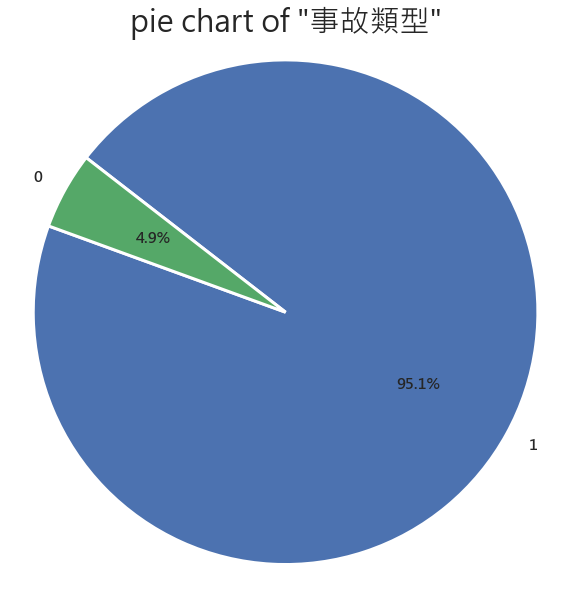

In [675]:
# "事故類型" pie chart
# count
value_counts = selected_df['事故類型'].value_counts(dropna=False)

# set font
plt.rcParams.update({'font.size': 15})
# pie
plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=160, textprops={
        'weight': 'bold', 'size': 15}, wedgeprops={'linewidth': 3, 'edgecolor': 'w'})
plt.title('pie chart of "事故類型"', fontsize=30)
plt.axis('equal')
# show
plt.show()

In [684]:
# "方向"
# change val back to str to compare
original_values = label_encoders['方向'].inverse_transform(selected_df['方向'])

# use df to see
encoded_to_original = pd.DataFrame({
    'Encoded': selected_df['方向'],
    'Original': original_values
})

# del duplicate val
unique_encoded_to_original = encoded_to_original.drop_duplicates()
unique_encoded_to_original


Encoded Original
131        1        南
137        0        北

In [28]:
# check NA
na_values = sorted_df[sorted_df['國道名稱'].isna()]
na_values

Empty DataFrame
Columns: [年, 月, 日, 時, 分, 國道名稱, 方向, 里程, 事件發生, 事件排除, 處理分鐘, 事故類型, 死亡, 受傷, 內路肩, 內車道, 中內車道, 中車道, 中外車道, 外車道, 外路肩, 匝道, 簡訊內容, 翻覆事故
註記, 施工事故
註記, 危險物品車輛
註記, 車輛起火
註記, 冒煙車事故
註記, 主線中斷
註記, 肇事車輛, 車輛1, 車輛2, 車輛3, 車輛4, 車輛5, 車輛6, 車輛7, 車輛8, 車輛9, 車輛10, 車輛11, 車輛12, 分局, 回堵長度]
Index: []

[0 rows x 44 columns]

In [682]:
# "事故類型"
# change val back to str to compare
original_values = label_encoders['事故類型'].inverse_transform(selected_df['事故類型'])

# use df to see
encoded_to_original = pd.DataFrame({
    'Encoded': selected_df['事故類型'],
    'Original': original_values
})

# del duplicate val
unique_encoded_to_original = encoded_to_original.drop_duplicates()
unique_encoded_to_original


Encoded Original
131         2       A3
2974        1       A2
8725        0       A1

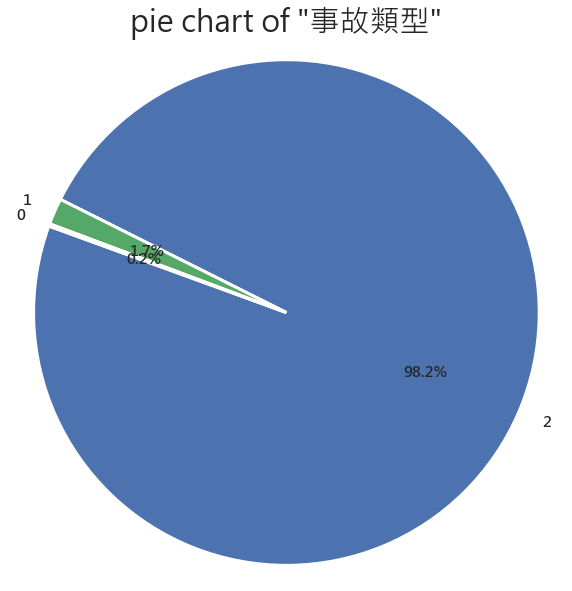

In [683]:
# "事故類型" pie chart
# count
value_counts = selected_df['事故類型'].value_counts(dropna=False)

# set font
plt.rcParams.update({'font.size': 15})
# pie
plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=160, textprops={
        'weight': 'bold', 'size': 15}, wedgeprops={'linewidth': 3, 'edgecolor': 'w'})
plt.title('pie chart of "事故類型"', fontsize=30)
plt.axis('equal')
# show
plt.show()

# decision tree

In [ ]:
# decision
# keep specific & target var
selected_features = ['國道名稱', '方向', '事件發生', '事件排除', '事故類型', '死亡', '受傷', '肇事車輛', '回堵長度', '處理分鐘']
selected_df = sorted_df[selected_features]

# do label encoding for cate var
label_encoders = {}
categorical_features = ['國道名稱', '方向', '事件發生', '事件排除', '事故類型']
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    selected_df[feature] = label_encoders[feature].fit_transform(selected_df[feature].astype(str))

# change time into time_type
selected_df['事件發生'] = pd.to_datetime(selected_df['事件發生'])
selected_df['事件排除'] = pd.to_datetime(selected_df['事件排除'])

# count '事件持續時間'
selected_df['事件持續時間'] = (selected_df['事件排除'] - selected_df['事件發生']).dt.total_seconds() / 60

# del '事件發生', '事件排除'
selected_df.drop(columns=['事件發生', '事件排除'], inplace=True)

# spilt specific & target var
X = selected_df.drop(columns=['處理分鐘'])  # 特徵變數
y = selected_df['處理分鐘']  # 目標變數

# spilt train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

# fit
tree_reg.fit(X_train, y_train)

# predict
y_pred = tree_reg.predict(X_test)

# mse
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# save
export_graphviz(tree_reg, out_file="tree.dot", feature_names=X.columns, filled=True, special_characters=True, fontname="Microsoft YaHei")

# use graphviz to load, save as picture
with open("tree.dot", encoding="utf-8") as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph)
# change into "png"
graph.render("decision_tree", format="png")


In [ ]:
# set parameter
decision_tree_model = DecisionTreeRegressor(min_samples_leaf=350)

# fit
decision_tree_model.fit(x_train, y_train)

# plot
plt.figure(figsize=(80, 40))
plot_tree(decision_tree_model,
          feature_names=x_train.columns,
          filled=True,
          fontsize=14,
          rounded=True)
plt.show()

# predict
y_pred_decision_tree = decision_tree_model.predict(x_test)

# xgboost

In [266]:
# # model xgboost
# xgb_model = xgb.XGBRegressor()

# # fit
# xgb_model.fit(X_train, y_train)

# # use test to predict
# y_pred = xgb_model.predict(X_test)

# # count mse
# mse = mean_squared_error(y_test, y_pred, squared=False)
# print("RMSE of xgboost:", mse)
# # count MAE
# mae = mean_absolute_error(y_test, y_pred)
# print("MAE of xgboost:", mae)
# # count R-squared
# r2 = r2_score(y_test, y_pred)
# print("R2 of xgboost:", r2)
# # # feature importances
# # feature_importances = xgb_model.feature_importances_
# # print("Feature Importances:", feature_importances)

RMSE of xgboost: 17.79805538152456
MAE of xgboost: 9.11341540752816
R2 of xgboost: 0.3018500077716538


In [279]:
# def train xgb model
def train_xgboost_model(X_train, y_train, X_test, y_test, param_grid, log_transform=False):
    # set xgb model
    xgboost_model = xgb.XGBRegressor()

    # grid search
    grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                               cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

    # fit
    grid_search.fit(X_train, y_train)

    # get best model
    best_params = grid_search.best_params_
    best_xgboost_model = grid_search.best_estimator_

    # predict
    y_pred = best_xgboost_model.predict(X_test)
    if log_transform:
        y_pred = np.expm1(y_pred)

    # evaluate
    mse = round(mean_squared_error(y_test, y_pred),4)
    mae = round(mean_absolute_error(y_test, y_pred),4)
#     r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
#     print(f"R-squared: {r2}")
    print(f"Best Parameters: {best_params}")

    return best_xgboost_model, mse, mae

In [280]:
# set grid param
param_grid_ori_xgb = {
    'gamma': [0, 0.005, 0.01, 0.03],
    'learning_rate': [0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [100, 150, 200, 250],
}

# ori xgb model
ori_xgb_model, ori_xgb_mse, ori_xgb_mae = train_xgboost_model(
    X_train, y_train, X_test, y_test, param_grid_ori_xgb)

Mean Squared Error: 1.2146
Mean Absolute Error: 0.6786
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}


In [283]:
# set grid param
param_grid_log_xgb = {
    'gamma': [0, 0.03, 0.05],
    'learning_rate': [0, 0.01, 0.05, 0.01, 0.15],
    'max_depth': [4, 5, 6 , 7],
    'n_estimators': [100, 150, 200, 250],
}

# log xgb model
log_xgb_model, log_xgb_mse, log_xgb_mae = train_xgboost_model(
    X_train_log, y_train_log, X_test_log, y_test_log, param_grid_log_xgb, log_transform=True)

Mean Squared Error: 0.2497
Mean Absolute Error: 0.3427
Best Parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 150}


In [284]:
# pred
y_pred_ori = ori_xgb_model.predict(X)
y_pred_log = log_xgb_model.predict(X)

# caculate res
ori_residuals = y_pred_ori - y
log_residuals = np.expm1(y_pred_log) - y

# save to df
ori_residuals_df = pd.DataFrame({'Residuals': ori_residuals})
log_residuals_df = pd.DataFrame({'Residuals': log_residuals})

# get total samples
ori_total_samples = ori_residuals_df.shape[0]
log_total_samples = log_residuals_df.shape[0]

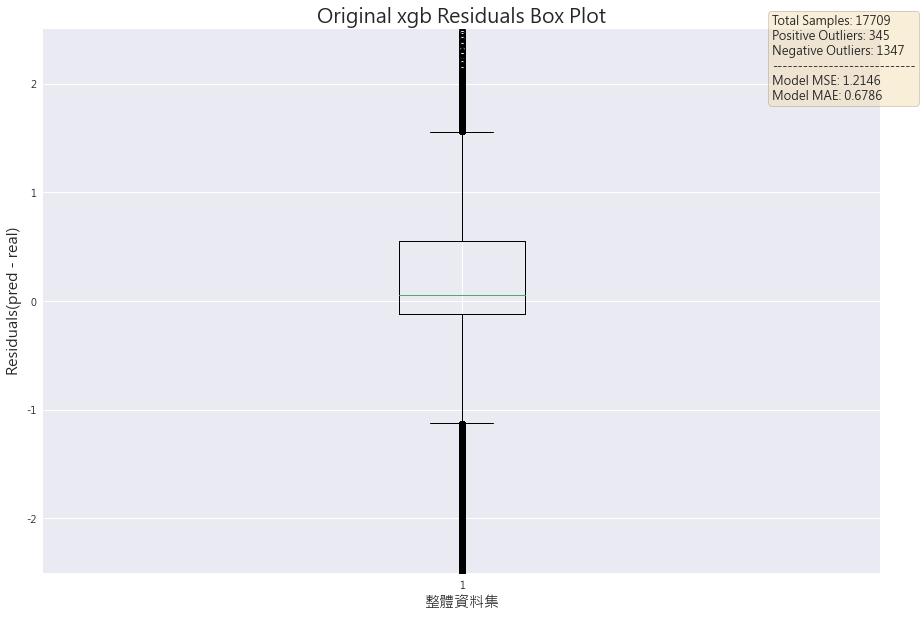

In [288]:
# get outlier
std_residuals = ori_residuals_df['Residuals'].std()
positive_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = ori_residuals_df[ori_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(ori_residuals_df['Residuals'])
# plt.ylim(-25, 25)
plt.ylim(-2.5, 2.5)
plt.title('Original xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('整體資料集', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {ori_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {ori_xgb_mse}\n"
    f"Model MAE: {ori_xgb_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

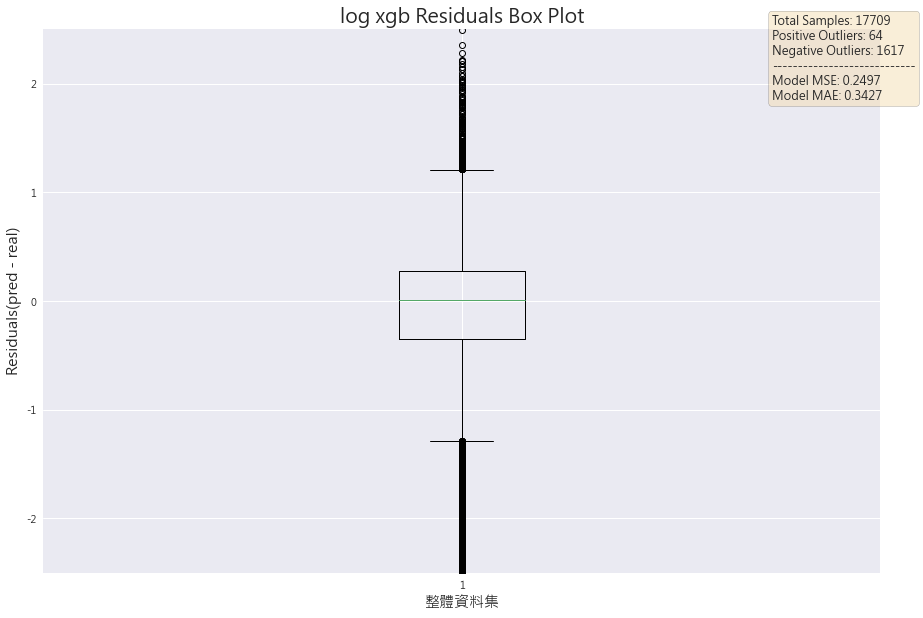

In [289]:
# get outlier
std_residuals = log_residuals_df['Residuals'].std()
positive_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = log_residuals_df[log_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(log_residuals_df['Residuals'])
# plt.ylim(-25, 25)
plt.ylim(-2.5, 2.5)
plt.title('log xgb Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('整體資料集', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {log_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {log_xgb_mse}\n"
    f"Model MAE: {log_xgb_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

# qreg

In [290]:
# use median --> quantile==0.5
# set param
param_grid = {
    # set quantile
    'quantile': [0.5],
    # solver : 'highs', 'highs-ds', 'highs-ipm', 'highs-simplex'
    'solver': ['highs'],
    # alpha
    'alpha': [0, 0.0019, 0.002, 0.0025],
}

# set Quantile Regression model
qreg_model = QuantileRegressor()

# grid search
grid_search = GridSearchCV(estimator=qreg_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# fit
grid_search.fit(X_train_log, y_train_log)

# get best model
best_params = grid_search.best_params_
mid_qreg_model = grid_search.best_estimator_

# pred
y_pred = mid_qreg_model.predict(X_test_log)
y_pred = np.expm1(y_pred)

# evaluate
mid_qreg_mse = round(mean_squared_error(y_test, y_pred), 4)
mid_qreg_mae = round(mean_absolute_error(y_test, y_pred), 4)
#r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mid_qreg_mse}")
print(f"Mean Absolute Error: {mid_qreg_mae}")
#print(f"R-squared: {r2}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 2.0884
Mean Absolute Error: 0.7315
Best Parameters: {'alpha': 0, 'quantile': 0.5, 'solver': 'highs'}


In [291]:
# use median --> quantile==all
# set param
param_grid = {
    # set quantile
    'quantile': [0.45, 0.5, 0.55, 0.6],
    # solver : 'highs', 'highs-ds', 'highs-ipm', 'highs-simplex'
    'solver': ['highs'],
    # alpha
    'alpha': [0, 0.0018, 0.002, 0.0025],
}

# set Quantile Regression model
qreg_model = QuantileRegressor()

# grid search
grid_search = GridSearchCV(estimator=qreg_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# fit
grid_search.fit(X_train_log, y_train_log)

# get best model
best_params = grid_search.best_params_
best_qreg_model = grid_search.best_estimator_

# pred
y_pred = best_qreg_model.predict(X_test_log)
y_pred = np.expm1(y_pred)

# evaluate
best_qreg_mse = round(mean_squared_error(y_test, y_pred), 4)
best_qreg_mae = round(mean_absolute_error(y_test, y_pred), 4)
#r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {best_qreg_mse}")
print(f"Mean Absolute Error: {best_qreg_mae}")
#print(f"R-squared: {r2}")
print(f"Best Parameters: {best_params}")

Mean Squared Error: 1.5048
Mean Absolute Error: 0.7349
Best Parameters: {'alpha': 0.0018, 'quantile': 0.55, 'solver': 'highs'}


In [292]:
# pred
y_pred_mid = mid_qreg_model.predict(X)
y_pred_best = best_qreg_model.predict(X)

# caculate res
mid_log_residuals = np.expm1(y_pred_mid) - y
best_log_residuals = np.expm1(y_pred_best) - y

# save to df
mid_qreg_residuals_df = pd.DataFrame({'Residuals': mid_log_residuals})
best_qreg_residuals_df = pd.DataFrame({'Residuals': best_log_residuals})

# get total samples
mid_qreg_total_samples = mid_qreg_residuals_df.shape[0]
best_qreg_total_samples = best_qreg_residuals_df.shape[0]

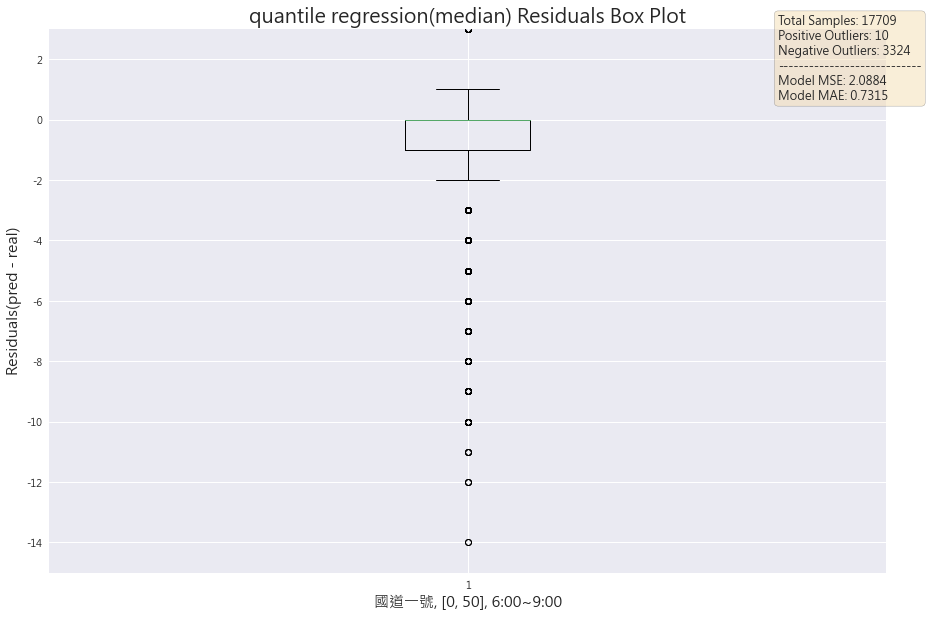

In [303]:
# get outlier
std_residuals = mid_qreg_residuals_df['Residuals'].std()
positive_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = mid_qreg_residuals_df[mid_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(mid_qreg_residuals_df['Residuals'])
# plt.ylim(-50, 50)
plt.ylim(-15, 3)
plt.title('quantile regression(median) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mid_qreg_mse}\n"
    f"Model MAE: {mid_qreg_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

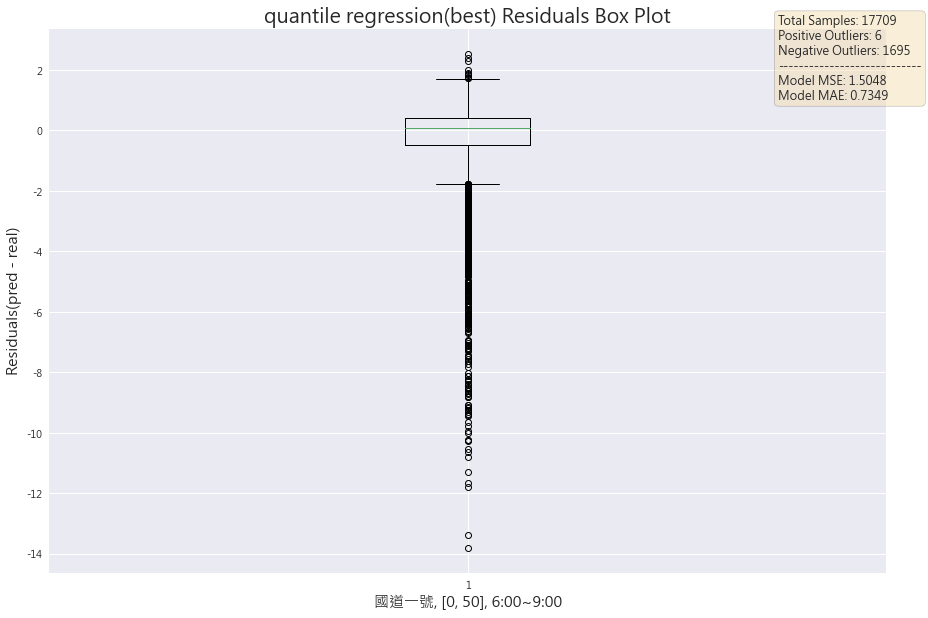

In [305]:
# get outlier
std_residuals = best_qreg_residuals_df['Residuals'].std()
positive_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     > 1.5 * std_residuals].shape[0]
negative_outliers = best_qreg_residuals_df[best_qreg_residuals_df['Residuals']
                                     < -1.5 * std_residuals].shape[0]

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(best_qreg_residuals_df['Residuals'])
# plt.ylim(-50, 50)
# plt.ylim(-15, 3)
plt.title('quantile regression(best) Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals(pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {mid_qreg_total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {best_qreg_mse}\n"
    f"Model MAE: {best_qreg_mae}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.8, 0.9, textstr, fontsize=12, verticalalignment='top',
               horizontalalignment='left', bbox=props)

# show
plt.show()

# xgb+qreg

In [306]:
# set param
param_grid = {
    'alpha': [0],
    'colsample_bytree': [1.0],
    'eta': [0, 0.1, 0.3, 0.5],
    'gamma': [0.05, 0.1, 0.5],
    'lambda': [0.3, 0.5, 1],
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1],
    'subsample': [1.0],
}

# fixed param
params_fixed = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'n_jobs': -1,
}

# change data tyoe into DMatrix
dtrain_log = xgb.DMatrix(X_train_log, label=y_train_log)
dtest_log = xgb.DMatrix(X_test_log, label=y_test_log)

# evaluate
evals = [(dtest_log, 'eval')]

# save best result
best_mae = float("inf")
best_params = None

# grid search
for params in ParameterGrid(param_grid):
    # combine fixed & param
    current_params = {**params_fixed, **params}
    
    # train
    bst = xgb.train(
        params=current_params, 
        dtrain=dtrain_log, 
        num_boost_round=1000, 
        obj=quantile_loss_obj,
        custom_metric=custom_metric,
        early_stopping_rounds=50, 
        evals=evals, 
        verbose_eval=False
    )
    
    # predict
    y_pred_log = bst.predict(dtest_log)
    
    # mae
    mae = mean_absolute_error(y_test_log, y_pred_log)
    # save best model, use mae to define
    if mae < best_mae:
        best_mae = mae
        best_params = params

# show best para,
print(f"Best parameters found: {best_params}")

# use best param to train
xgb_qreg_best_model = xgb.train(
    params={**params_fixed, **best_params},
    dtrain=dtrain_log,
    num_boost_round=1000,
    obj=quantile_loss_obj,
    custom_metric=custom_metric,
    early_stopping_rounds=50,
    evals=evals,
    verbose_eval=True
)


Best parameters found: {'alpha': 0, 'colsample_bytree': 1.0, 'eta': 0.1, 'gamma': 0.1, 'lambda': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
[0]	eval-mae:0.49263	eval-quantile_loss:0.24631
[1]	eval-mae:0.47452	eval-quantile_loss:0.23726
[2]	eval-mae:0.45640	eval-quantile_loss:0.22820
[3]	eval-mae:0.43829	eval-quantile_loss:0.21915
[4]	eval-mae:0.42018	eval-quantile_loss:0.21009
[5]	eval-mae:0.40207	eval-quantile_loss:0.20104
[6]	eval-mae:0.38396	eval-quantile_loss:0.19198
[7]	eval-mae:0.36585	eval-quantile_loss:0.18292
[8]	eval-mae:0.34771	eval-quantile_loss:0.17385
[9]	eval-mae:0.32959	eval-quantile_loss:0.16480
[10]	eval-mae:0.33537	eval-quantile_loss:0.16769
[11]	eval-mae:0.31794	eval-quantile_loss:0.15897
[12]	eval-mae:0.32463	eval-quantile_loss:0.16232
[13]	eval-mae:0.30937	eval-quantile_loss:0.15468
[14]	eval-mae:0.31692	eval-quantile_loss:0.15846
[15]	eval-mae:0.30289	eval-quantile_loss:0.15144
[16]	eval-mae:0.31451	eval-quantile_loss:0.15726
[17]	eval-mae:0.30

[163]	eval-mae:0.29016	eval-quantile_loss:0.14508
[164]	eval-mae:0.30026	eval-quantile_loss:0.15013
[165]	eval-mae:0.29056	eval-quantile_loss:0.14528
[166]	eval-mae:0.30012	eval-quantile_loss:0.15006
[167]	eval-mae:0.29039	eval-quantile_loss:0.14520
[168]	eval-mae:0.30055	eval-quantile_loss:0.15028
[169]	eval-mae:0.28957	eval-quantile_loss:0.14479
[170]	eval-mae:0.30061	eval-quantile_loss:0.15030
[171]	eval-mae:0.28970	eval-quantile_loss:0.14485
[172]	eval-mae:0.30032	eval-quantile_loss:0.15016
[173]	eval-mae:0.28986	eval-quantile_loss:0.14493
[174]	eval-mae:0.29996	eval-quantile_loss:0.14998
[175]	eval-mae:0.28990	eval-quantile_loss:0.14495
[176]	eval-mae:0.30061	eval-quantile_loss:0.15030
[177]	eval-mae:0.28948	eval-quantile_loss:0.14474
[178]	eval-mae:0.30097	eval-quantile_loss:0.15049
[179]	eval-mae:0.28944	eval-quantile_loss:0.14472
[180]	eval-mae:0.30042	eval-quantile_loss:0.15021
[181]	eval-mae:0.29019	eval-quantile_loss:0.14509
[182]	eval-mae:0.29947	eval-quantile_loss:0.14974


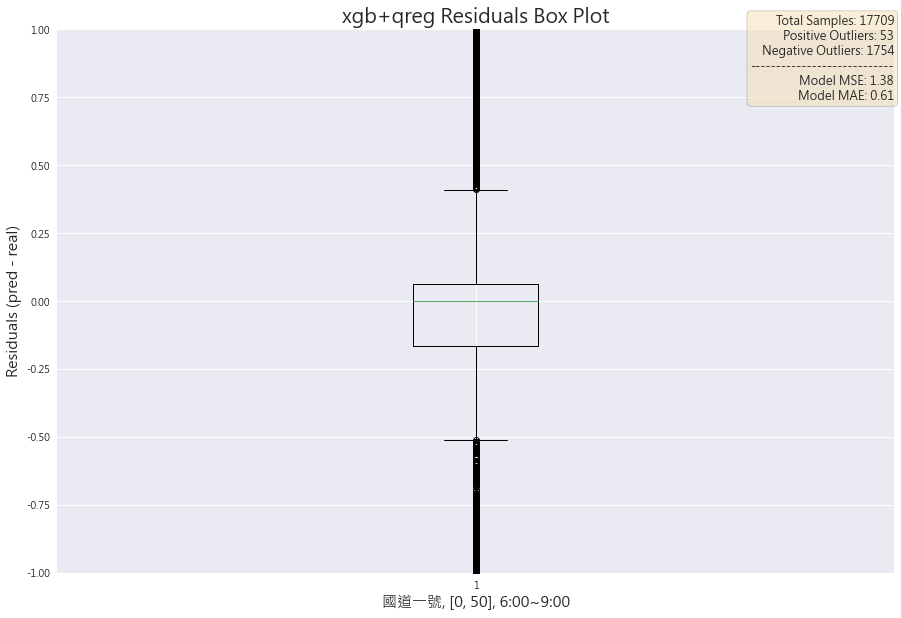

In [310]:
# change data type into DMatrix
dall = xgb.DMatrix(X)

# use best model
y_all_pred_log = xgb_qreg_best_model.predict(dall)
y_all_pred = np.expm1(y_all_pred_log)

# count res and build df
residuals = y_all_pred - y
residuals_df = pd.DataFrame({'Residuals': residuals})

# count samples & std
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()

# count outlier
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]

# count mse & mae
mse = mean_squared_error(y, y_all_pred)
mae = mean_absolute_error(y, y_all_pred)

# box plot
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
# plt.ylim(-25, 25)
plt.ylim(-1, 1)
plt.title('xgb+qreg Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# adjust
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# show
plt.show()

# zero inflated model

In [66]:
import joblib
import os

def train_and_evaluate_zip_xgb(X_train, y_train, X_test, y_test, feature_names, save_path='saved_model'):
    # 對數據進行對數轉換
    scaler = StandardScaler()
    X_train_log = scaler.fit_transform(np.log1p(X_train))
    X_test_log = scaler.transform(np.log1p(X_test))
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # 1. 訓練 Zero-Inflated Poisson 模型
    zip_model = sm.ZeroInflatedPoisson(y_train_log, X_train_log, inflation='logit')
    zip_result = zip_model.fit(maxiter=100, disp=False, method='bfgs')

    # 2. 訓練 XGBoost 模型
    xgb_model = xgb.XGBRegressor(objective='count:poisson')
    xgb_model.fit(X_train_log, y_train_log)

    # 3. 保存模型
    os.makedirs(save_path, exist_ok=True)
    joblib.dump(zip_result, os.path.join(save_path, 'zip_model.pkl'))
    joblib.dump(xgb_model, os.path.join(save_path, 'xgb_model.pkl'))
    joblib.dump(scaler, os.path.join(save_path, 'scaler.pkl'))

    print("模型已保存。")

    # 4. 預測
    zero_inflation_preds = zip_result.predict(X_test_log)
    zero_inflation_preds = np.round(zero_inflation_preds)
    xgb_preds_log = xgb_model.predict(X_test_log)
    xgb_preds = np.expm1(xgb_preds_log)

    # 5. 合併預測結果
    y_pred = np.where(zero_inflation_preds == 0, 0, xgb_preds)

    # 6. 評估模型
    mse = round(mean_squared_error(y_test, y_pred), 4)
    mae = round(mean_absolute_error(y_test, y_pred), 4)

    # 7. 提取變數重要性
    zip_importance = np.abs(zip_result.params[1:])  # 忽略截距項
    zip_importance_normalized = zip_importance / np.sum(zip_importance)
    xgb_importance = xgb_model.feature_importances_
    xgb_importance_normalized = xgb_importance / np.sum(xgb_importance)

    combined_importance = 0.5 * zip_importance_normalized + 0.5 * xgb_importance_normalized

    # 8. 存儲變數重要性到 DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'ZIP Importance': zip_importance_normalized,
        'XGB Importance': xgb_importance_normalized,
        'Combined Importance': combined_importance
    })
    importance_df['ZIP Importance (%)'] = importance_df['ZIP Importance'] * 100
    importance_df['XGB Importance (%)'] = importance_df['XGB Importance'] * 100
    importance_df['Combined Importance (%)'] = importance_df['Combined Importance'] * 100

    # 9. 按照綜合重要性排序
    importance_df = importance_df.sort_values(by='Combined Importance', ascending=False).reset_index(drop=True)

    # 10. 視覺化整體變數重要性
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Feature'], importance_df['Combined Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Combined Importance')
    plt.title('Overall Feature Importance (ZIP + XGBoost)')
    plt.xticks(rotation=90)
    plt.show()

    return mse, mae, zero_inflation_preds, xgb_preds, importance_df


In [67]:
X_train

國道名稱     里程  方向  事故類型  內路肩  內車道  中內車道  中車道  中外車道  外車道  外路肩  匝道  肇事車輛  \
9150      2   63.0   0     2    0    1     0    0     0    0    0   0   2.0   
9988      6  236.7   0     3    0    0     0    0     0    0    1   0   1.0   
13560     6  400.0   0     1    0    1     0    0     0    0    0   0   4.0   
4337      6   51.7   0     2    0    0     0    0     0    1    0   0   2.0   
13588     6  424.5   1     2    0    0     0    0     0    0    0   1   4.0   
...     ...    ...  ..   ...  ...  ...   ...  ...   ...  ...  ...  ..   ...   
11287     2   49.0   1     1    0    0     0    0     0    0    0   1   3.0   
11967     1    2.0   2     2    0    1     0    0     0    0    0   0   1.0   
5391      2  373.0   0     2    0    0     0    0     0    0    0   1   2.0   
860       2   27.7   0     2    0    1     0    0     0    0    0   0   2.0   
15828     1   16.6   2     2    0    1     0    0     0    0    0   0   1.0   

       是否為假日  相近時間&地點是否有事件  事故車是否包含非小客車  
9150       0             0            0  
9988       1             0            0  
13560      0             0            1  
4337       0             0            1  
13588      0             0            0  
...      ...           ...          ...  
11287      1             0            0  
11967      0             0            0  
5391       1             0            1  
860        0             1            0  
15828      1             0            0  

[14167 rows x 16 columns]

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


模型已保存。


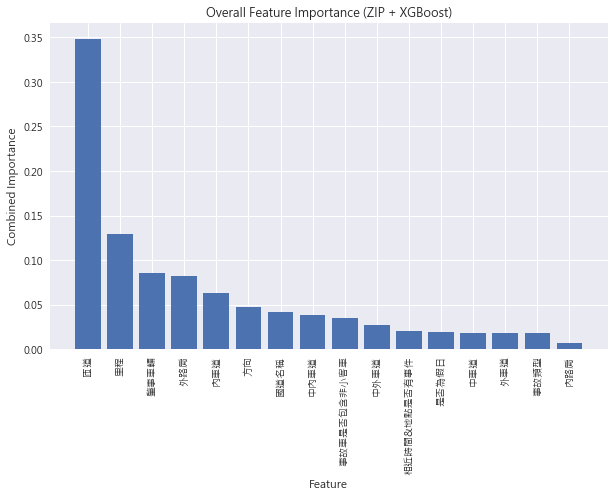

Mean Squared Error: 1.2899
Mean Absolute Error: 0.6138
Feature Importance DataFrame:


Feature  ZIP Importance  XGB Importance  Combined Importance  \
0             匝道        0.253737        0.443746             0.348741   
1             里程        0.133155        0.125346             0.129251   
2           肇事車輛        0.137001        0.034332             0.085666   
3            外路肩        0.054997        0.108853             0.081925   
4            內車道        0.081876        0.044933             0.063404   
5             方向        0.081384        0.012249             0.046817   
6           國道名稱        0.027635        0.055261             0.041448   
7           中內車道        0.052563        0.025117             0.038840   
8    事故車是否包含非小客車        0.046236        0.024494             0.035365   
9           中外車道        0.039835        0.014338             0.027087   
10  相近時間&地點是否有事件        0.025903        0.013823             0.019863   
11         是否為假日        0.020986        0.017015             0.019000   
12           中車道        0.025578        0.011698             0.018638   
13           外車道        0.003837        0.033410             0.018623   
14          事故類型        0.013702        0.022443             0.018073   
15           內路肩        0.001576        0.012944             0.007260   

    ZIP Importance (%)  XGB Importance (%)  Combined Importance (%)  
0            25.373690           44.374561                34.874126  
1            13.315540           12.534635                12.925087  
2            13.700058            3.433151                 8.566604  
3             5.499659           10.885251                 8.192455  
4             8.187608            4.493258                 6.340433  
5             8.138438            1.224894                 4.681666  
6             2.763505            5.526111                 4.144808  
7             5.256337            2.511673                 3.884005  
8             4.623563            2.449350                 3.536457  
9             3.983463            1.433839                 2.708651  
10            2.590279            1.382348                 1.986314  
11            2.098605            1.701480                 1.900043  
12            2.557830            1.169801                 1.863815  
13            0.383650            3.340970                 1.862310  
14            1.370218            2.244324                 1.807271  
15            0.157557            1.294355                 0.725956

In [68]:
# 訓練和評估模型，並將變數名稱傳入函數
feature_names = X_train.columns  # 如果 X_train 是 DataFrame 格式
mse, mae, zip_preds, xgb_preds, importance_df = train_and_evaluate_zip_xgb(X_train, y_train, X_test, y_test, feature_names)

# 輸出結果
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print("Feature Importance DataFrame:")
importance_df

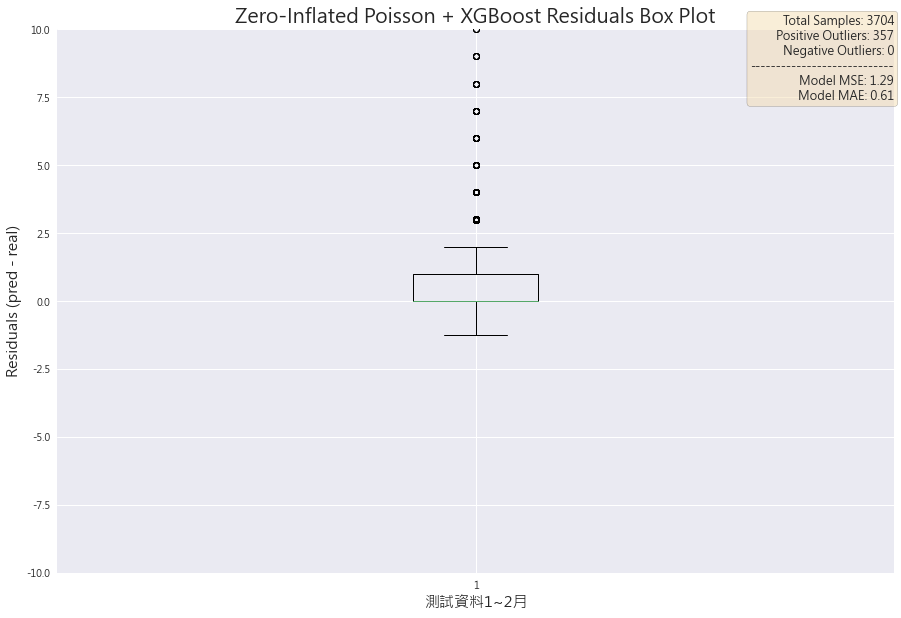

In [73]:
import joblib
import os

# 加載已保存的模型
save_path = 'saved_model'
zip_result = joblib.load(os.path.join(save_path, 'zip_model.pkl'))
xgb_model = joblib.load(os.path.join(save_path, 'xgb_model.pkl'))

# 使用 Zero-Inflated Poisson 模型進行預測
zip_preds = zip_result.predict(X)

# 使用 XGBoost 模型進行預測
xgb_preds_log = xgb_model.predict(X)
xgb_preds = np.expm1(xgb_preds_log)

# 合併預測結果
y_pred = np.where(zip_preds == 0, 0, xgb_preds)

# 計算殘差
residuals = y - y_pred
residuals_df = pd.DataFrame({'Residuals': residuals})

# 計算統計量
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]

# 繪製箱型圖
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
plt.ylim(-10, 10)  # 根據需要調整範圍
plt.title('Zero-Inflated Poisson + XGBoost Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('測試資料1~2月', fontsize=15)

# 添加統計信息
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# 顯示圖形
plt.show()

In [ ]:
# 使用 Zero-Inflated Poisson 模型進行預測
zip_preds = zip_result.predict(X)

# 訓練 XGBoost 模型
xgb_model = xgb.XGBRegressor(objective='count:poisson')
xgb_model.fit(X, y)

# 使用 XGBoost 模型進行預測
xgb_preds_log = xgb_model.predict(X)
xgb_preds = np.expm1(xgb_preds_log)

# 合併預測結果
y_pred = np.where(zip_preds == 0, 0, xgb_preds)

# 計算殘差
residuals = y - y_pred
residuals_df = pd.DataFrame({'Residuals': residuals})

# 計算統計量
total_samples = residuals_df.shape[0]
std_residuals = residuals_df['Residuals'].std()
positive_outliers = residuals_df[residuals_df['Residuals'] > 1.5 * std_residuals].shape[0]
negative_outliers = residuals_df[residuals_df['Residuals'] < -1.5 * std_residuals].shape[0]


# 繪製箱型圖
plt.figure(figsize=(15, 10))
plt.boxplot(residuals_df['Residuals'])
plt.ylim(-10, 10)  # 根據需要調整範圍
plt.title('Zero-Inflated Poisson + XGBoost Residuals Box Plot', fontsize=20)
plt.ylabel('Residuals (pred - real)', fontsize=15)
plt.xlabel('國道一號, [0, 50], 6:00~9:00', fontsize=15)

# 添加統計信息
textstr = (
    f"Total Samples: {total_samples}\n"
    f"Positive Outliers: {positive_outliers}\n"
    f"Negative Outliers: {negative_outliers}\n"
    "----------------------------\n"
    f"Model MSE: {mse:.2f}\n"
    f"Model MAE: {mae:.2f}"
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gcf().text(0.9, 0.9, textstr, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

# 顯示圖形
plt.show()


# random forest

In [274]:
# random forest
# create model with parallel computation
random_forest_model = RandomForestRegressor(n_jobs=-1)

# fit
random_forest_model.fit(X_train, y_train)

# predict
y_pred_random_forest = random_forest_model.predict(X_test)

# evaluation
# RMSE
rmse_random_forest = mean_squared_error(y_test, y_pred_random_forest, squared=False)
print("RMSE of Random Forest:", rmse_random_forest)

# MAE
mae_random_forest = mean_absolute_error(y_test, y_pred_random_forest)
print("MAE of Random Forest:", mae_random_forest)

# R-squared
r2_random_forest = r2_score(y_test, y_pred_random_forest)
print("R2 of Random Forest:", r2_random_forest)

# Feature Importance
feature_importance = random_forest_model.feature_importances_
print("Feature Importance:", feature_importance)


RMSE of Random Forest: 17.63395548866749
MAE of Random Forest: 9.077780399185992
R2 of Random Forest: 0.3146646866554931
Feature Importance: [0.06477008 0.06401994 0.33036601 0.0006433  0.02558201 0.00983801
 0.03503424 0.01139993 0.03768071 0.0252642  0.02517721 0.01357238
 0.02777605 0.18103528 0.14784065]


In [276]:
# show feature importance
# use df to save importance of var
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # original var name
    'Importance': random_forest_model.feature_importances_  # val of importance
})

# sort
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# show
importance_df

Feature  Importance
2     事故類型    0.330366
13    肇事車輛    0.181035
14    回堵長度    0.147841
0     國道名稱    0.064770
1       方向    0.064020
8      外車道    0.037681
6      中車道    0.035034
12      受傷    0.027776
4      內車道    0.025582
9      外路肩    0.025264
10      匝道    0.025177
11      死亡    0.013572
7     中外車道    0.011400
5     中內車道    0.009838
3      內路肩    0.000643